# Introduction

Ce travail, documenté dans ce notebook Python, s'inscrit dans le contexte de l'analyse de données relatives aux membres d'une salle de sport. L'objectif principal est d'exploiter les informations contenues dans le jeu de données `gym_members_exercise_tracking.csv` pour développer et évaluer des modèles d'apprentissage automatique capables de prédire des caractéristiques clés des adhérents.

Au fil de ce notebook, nous détaillerons l'ensemble du processus méthodologique, en commençant par le chargement et le prétraitement des données, incluant le nettoyage, la transformation de variables et la gestion des différents types de données. Une phase d'analyse exploratoire sera ensuite menée pour visualiser les données, identifier des tendances, des corrélations et mieux comprendre la structure sous-jacente du jeu de données.

Suite à cette exploration, nous aborderons la construction de plusieurs modèles prédictifs. Différents algorithmes d'apprentissage supervisé, adaptés à la nature de la variable cible (qu'il s'agisse d'une tâche de classification, comme la prédiction du niveau d'expérience, ou de régression pour la prédiction du nombre de calories brulées lors d'une séance), seront entraînés et rigoureusement évalués. Les performances de ces modèles seront comparées sur la base de métriques pertinentes afin d'identifier les approches les plus efficaces et robustes pour notre problématique. L'ambition est non seulement de parvenir à des prédictions précises mais aussi, dans la mesure du possible, d'extraire des informations interprétables sur les facteurs influençant les résultats.

In [1]:
# install.packages("recipes")

In [ ]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(ggpubr)
library(caret)
library(mlr3)
library(mlr3learners)
library(RColorBrewer)
library(e1071)
library(rpart)
library(MLmetrics)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 'GGally' was built under R version 4.4.2"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
"package 'plotly' was built under R version 4.4.2"

Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The follow

In [3]:
set.seed(1234)

In [4]:
options(repr.plot.width=15, repr.plot.height=8)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)


# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)

# Analyse Descriptive et Transformation des Données

### Prise en main des données

In [5]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(gym)
# Vérification du contenu
summary(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

Ce jeu de données fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures
de la condition physique des membres d’une salle de sport. Il contient 15 variables observées chez 973 individus
fréquentant une salle de sport:
- `Age` : âge du membre de la salle de sport.
- `Gender` : Sexe du membre de la salle de sport (qualitative à deux modalités : homme ou femme).
- `Weight..kg.` : Poids du membre en kilogrammes.
- `Height..m.` : Taille du membre en mètres.
- `Max_BPM` : Fréquence cardiaque maximale (battements par minute) pendant les séances d’entraînement.
- `Avg_BPM` : Fréquence cardiaque moyenne pendant les séances d’entraînement.
- `Resting_BPM` : Fréquence cardiaque au repos avant l’entraînement.
- `Session_Duration..hours.` : Durée de chaque séance d’entraînement en heures.
- `Calories_Burned` : Total des calories brûlées au cours de chaque séance.
- `Workout_Type` : Type d’entraînement effectué (qualitative à 4 modalités : cardio, musculation, yoga,
HIIT).
- `Fat_Percentage` (Pourcentage de graisse) : Pourcentage de graisse corporelle du membre.
- `Water_Intake..liters.` : Consommation quotidienne d’eau pendant les séances d’entraînement.
- `Workout_Frequency..days.week.` : Nombre de séances d’entraînement par semaine (qualitative à 4
modalités : 2 à 5).
- `Experience_Level` : Niveau d’expérience (qualitative à 3 modalités : 1 pour débutant à 3 pour expert).
- `BMI` : Indice de masse corporelle (IMC), calculé à partir de la taille et du poids. **La variable BMI est supprimée car elle est redondante. En effet, le calcul de l'IMC est donné par la formule :**
$$\text{BMI} = \frac{\text{poids}}  {\text{taille}^2}$$
**Ainsi, cette variable peut être dérivée directement à partir des variables poids et taille et ne nécessite donc pas d'être incluse dans l'analyse.**


Dans ce projet, on souhaite dans un premier temps, prédire la variable `Calories_Burned` à partir de toutes
les autres variables, et dans un second temps, prédire la variable `Experience_Level` à partir de toutes les autres
variables (dont `Calories_Burned`).

In [6]:
gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])
#remove BMI Column because redondant
gym <- gym[,-15]


In [7]:
summary(gym)

      Age           Gender     Weight..kg.       Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   : 40.00   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.: 58.10   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median : 70.00   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   : 73.85   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.: 86.00   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :129.90   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0

On distingue :

- 11 variables quantitatives : `Age`, `Weight`, `Height`, `Max_BPM`, `Avg_BPM`, `Resting_BPM`, `Session_duration`, `Calories_Burned`, `Fat_Percentage`, `Water_Intake`


- 4 variables qualitatives : `Gender`, `Workout_Type`, `Workout_frequency`, `Experience_level`

### Analyse et transformation des variables quantitatives

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


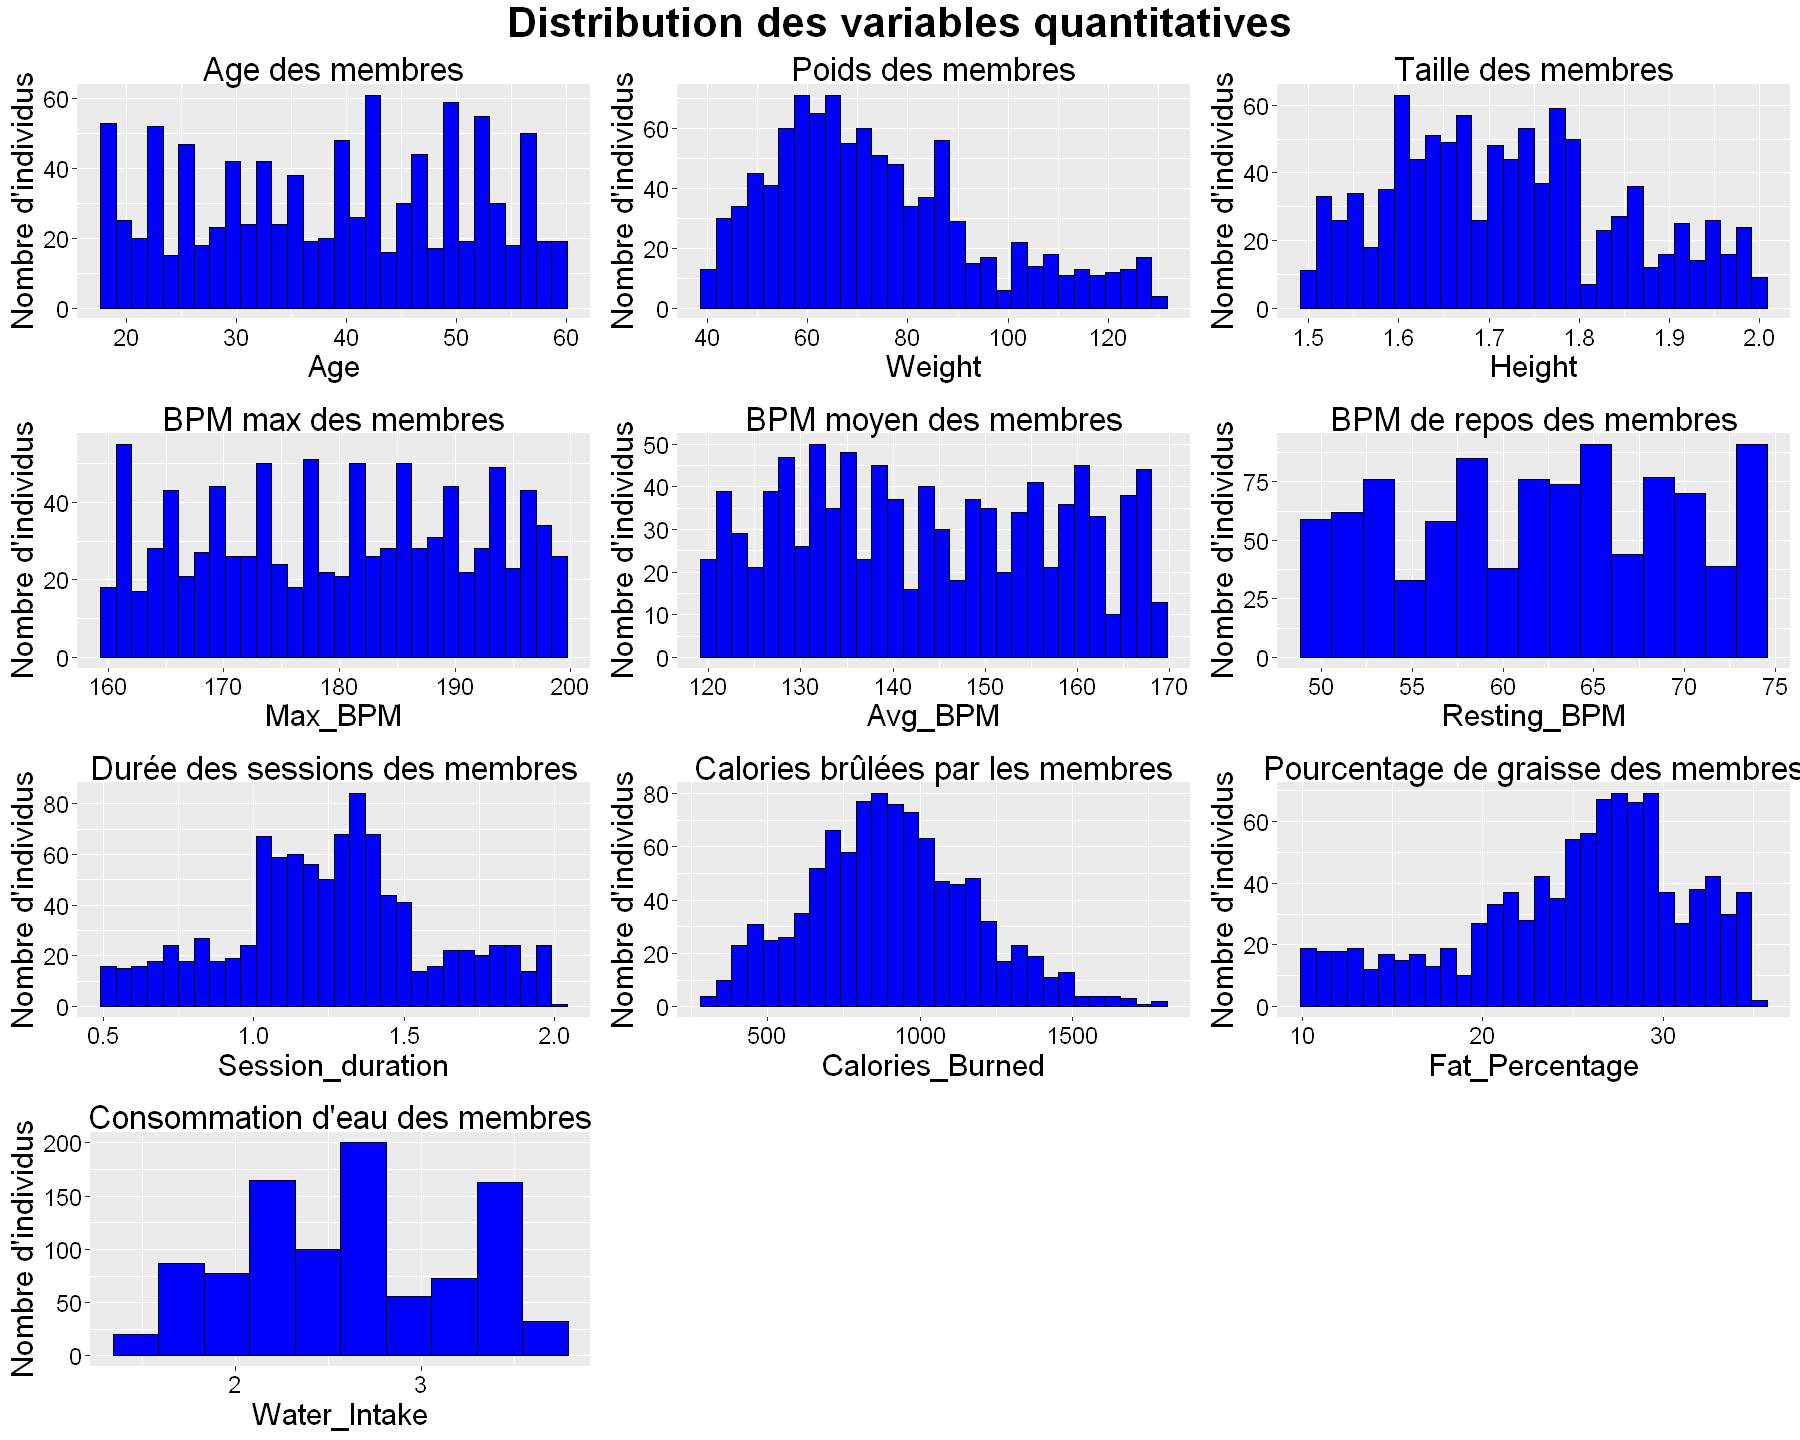

In [8]:
options(repr.plot.width=15, repr.plot.height=12)

g1 <- ggplot(gym, aes(Age)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Age des membres", x = "Age", y = "Nombre d'individus")

g2 <- ggplot(gym, aes(Weight..kg.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Poids des membres", x = "Weight", y = "Nombre d'individus")

g3 <- ggplot(gym, aes(Height..m.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Taille des membres", x = "Height", y = "Nombre d'individus")

g4 <- ggplot(gym, aes(Max_BPM)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "BPM max des membres", x = "Max_BPM", y = "Nombre d'individus")

g5 <- ggplot(gym, aes(Avg_BPM)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "BPM moyen des membres", x = "Avg_BPM", y = "Nombre d'individus")

g6 <- ggplot(gym, aes(Resting_BPM)) + 
    geom_histogram(bins = 15, fill = "blue", color = "black") + 
    labs(title = "BPM de repos des membres", x = "Resting_BPM", y = "Nombre d'individus")

g7 <- ggplot(gym, aes(Session_Duration..hours.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Durée des sessions des membres", x = "Session_duration", y = "Nombre d'individus")

g8 <- ggplot(gym, aes(Calories_Burned)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Calories brûlées par les membres", x = "Calories_Burned", y = "Nombre d'individus")

g9 <- ggplot(gym, aes(Fat_Percentage)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Pourcentage de graisse des membres", x = "Fat_Percentage", y = "Nombre d'individus")

g10 <- ggplot(gym, aes(Water_Intake..liters.)) + 
    geom_histogram(bins = 10, fill = "blue", color = "black") + 
    labs(title = "Consommation d'eau des membres", x = "Water_Intake", y = "Nombre d'individus")

main <- "Distribution des variables quantitatives"
title1=text_grob(main, size = 25, face = "bold") 
grid.arrange(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, ncol = 3, top = title1)
rm(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10)

Les histogrammes montrent la distribution des différentes variables quantitatives dans le jeu de données.


En analysant les histogrammes, nous remarquons plusieurs points importants :  


- Certaines variables, comme **`Calories_Burned`, `Session_Duration`** et **`Water_Intake`**, suivent une distribution normale.  
- D'autres variables, comme **`Weight`** et **`Fat_Percentage`**, présentent une forte asymétrie et devront être transformées.  
- Toutes les variales restantes présentent une trop grosse variabilité des valeurs pour être transformées

**Conclusion** : Certaines variables présentent des écarts d'échelle importants, ce qui peut affecter nos analyses. Nous allons donc procéder à des transformations et normalisations dans la section suivante.  




In [9]:
gym[, "LWeight"] <- log(gym[,"Weight..kg."])
gym[, "SWeight"] <- sqrt(gym[,"Weight..kg."])

max_fat = max(gym[,"Fat_Percentage"])
gym[, "SFat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])
gym[, "LFat_Percentage"] <- log((max_fat + 1) - gym[,"Fat_Percentage"])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


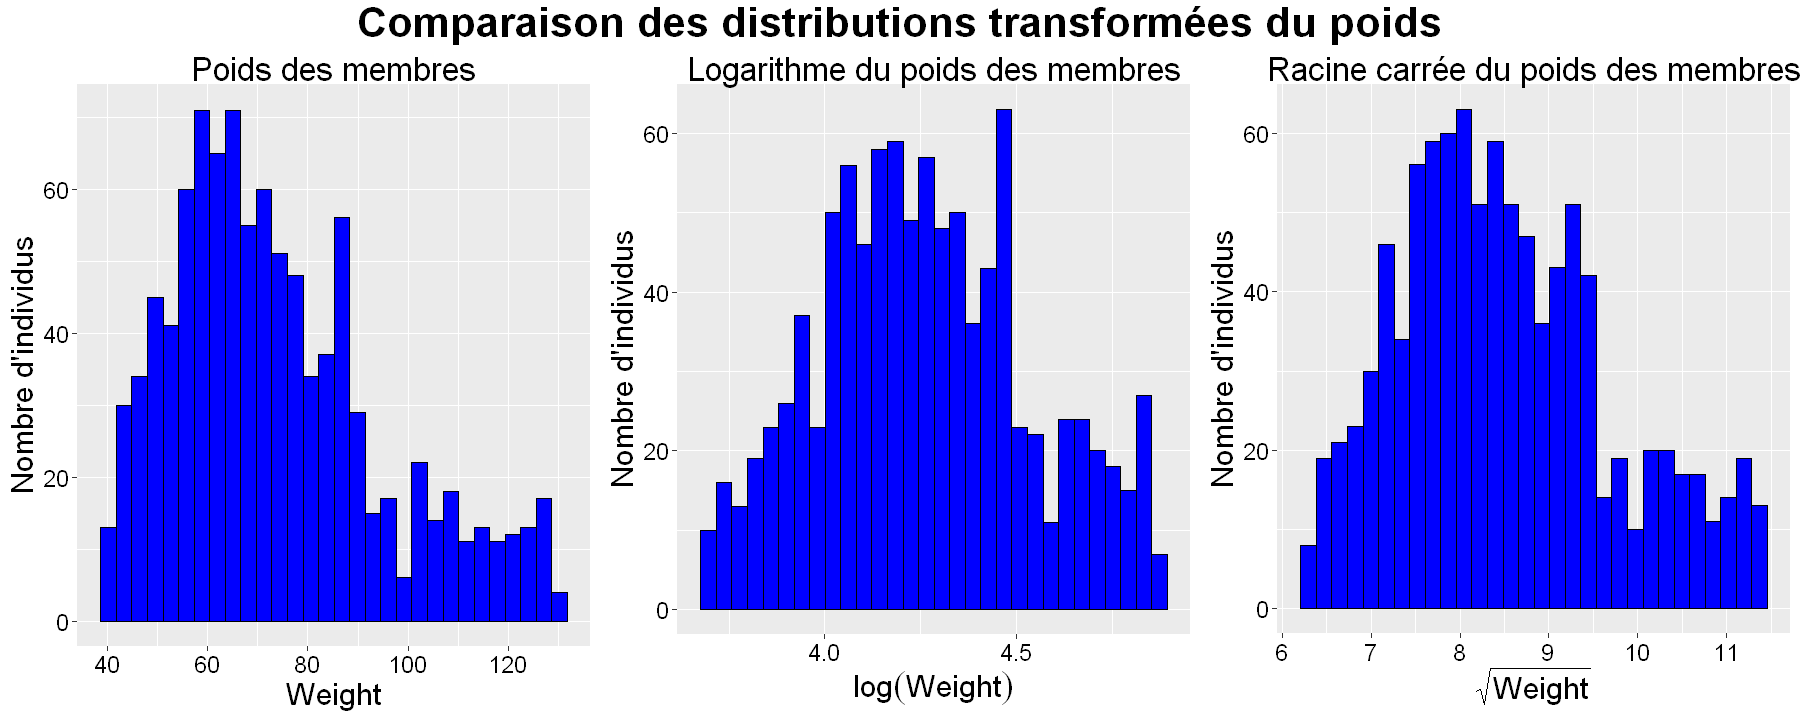

In [10]:
options(repr.plot.width=15, repr.plot.height=6)

g4 <- gg2 <- ggplot(gym, aes(Weight..kg.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Poids des membres", x = "Weight", y = "Nombre d'individus")

g5 <- ggplot(gym, aes(LWeight)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Logarithme du poids des membres", x = expression(log(Weight)), y = "Nombre d'individus")

g6 <- ggplot(gym, aes(SWeight)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Racine carrée du poids des membres", x = expression(sqrt(Weight)), y = "Nombre d'individus")

main <- "Comparaison des distributions transformées du poids"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(g4, g5, g6, ncol = 3, top = title1)
rm(g4, g5, g6)


Suite à ces transformations, nous observons que la deuxième transformation, qui consiste à appliquer **le logarithme à la variable `Weight`**, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


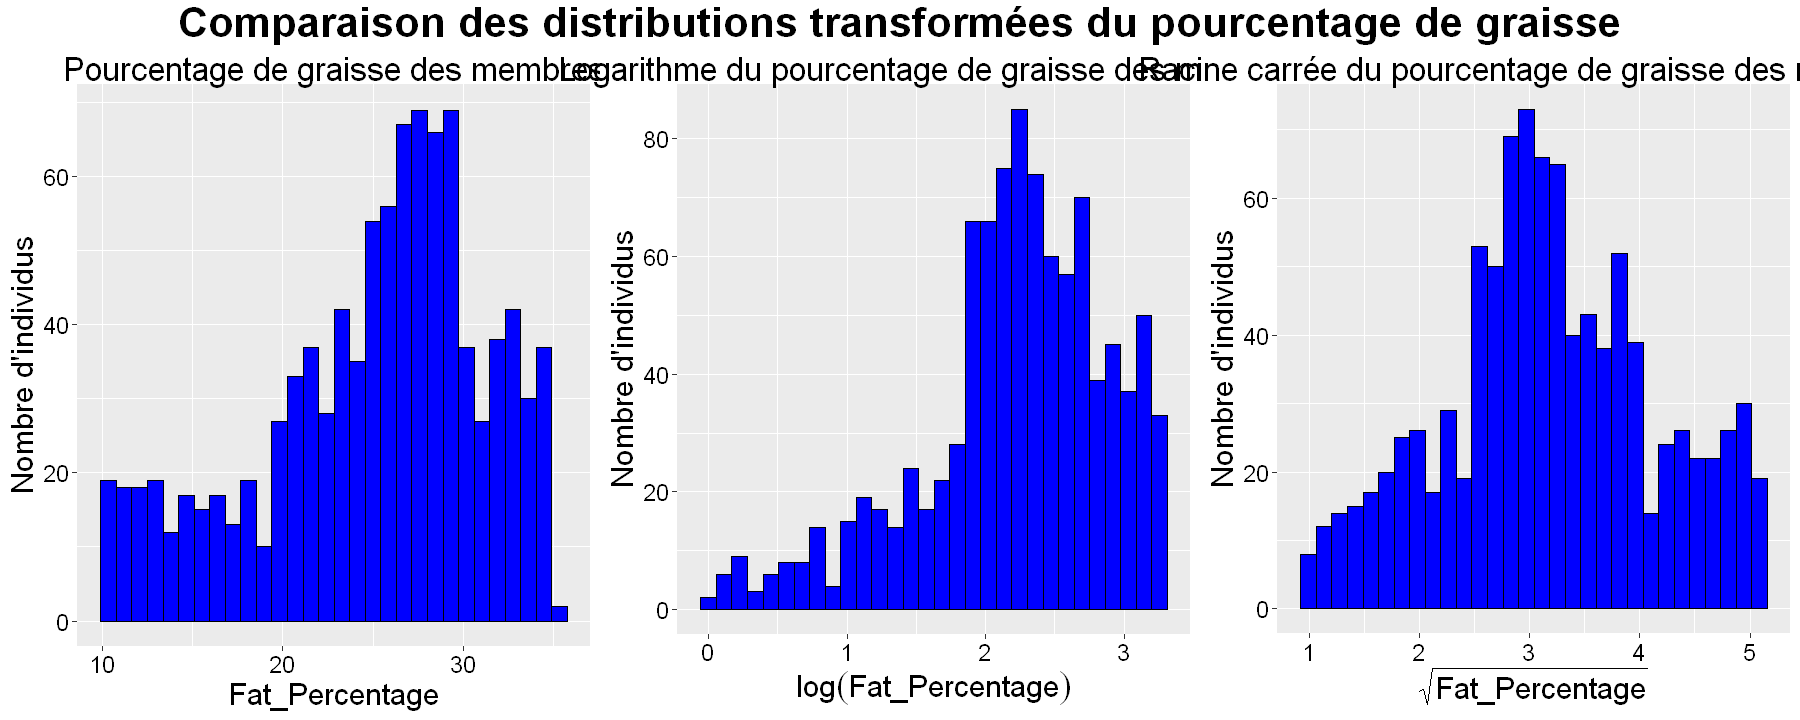

In [11]:
g1 <- ggplot(gym, aes(Fat_Percentage)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Pourcentage de graisse des membres", x = "Fat_Percentage", y = "Nombre d'individus")

g2 <- ggplot(gym, aes(LFat_Percentage)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Logarithme du pourcentage de graisse des membres", x = expression(log(Fat_Percentage)), y = "Nombre d'individus")

g3 <- ggplot(gym, aes(SFat_Percentage)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Racine carrée du pourcentage de graisse des membres", x = expression(sqrt(Fat_Percentage)), y = "Nombre d'individus")

main <- "Comparaison des distributions transformées du pourcentage de graisse"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(g1, g2, g3, ncol = 3, top = title1)
rm(g1, g2, g3)

Suite à ces transformations, nous observons que la troisième transformation, qui consiste à appliquer **la racine carrée de `Fat_Percentage`**, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

In [12]:
gym_analyse <- gym[,c(1:14)]
gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

# supprimer les colonnes 15 à 20
gym <- gym[, c(1:14)]

In [13]:
summary(gym)

      Age           Gender       LWeight        Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   :3.689   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.:4.062   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median :4.248   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   :4.263   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.:4.454   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :4.867   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0  
 Max

### Analyse des variables qualitatives

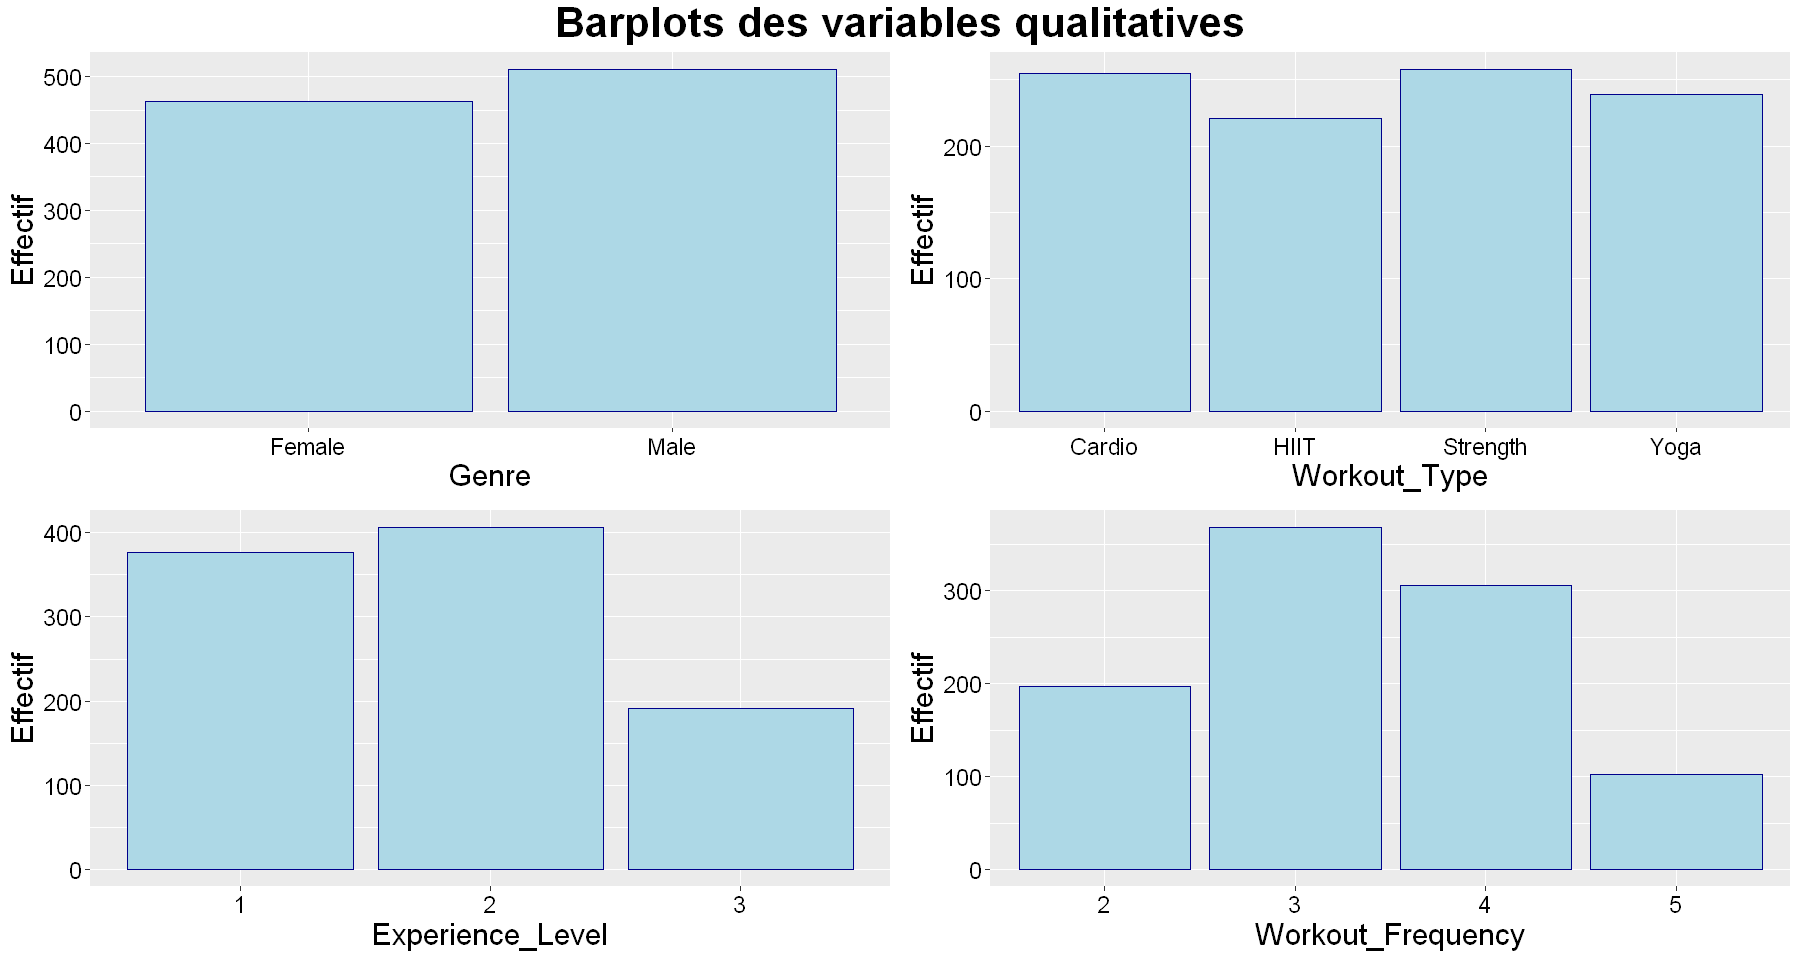

In [14]:
options(repr.plot.width=15, repr.plot.height=8)

# barplots pour les variables qualitatives
q1 <- ggplot(gym, aes(x = Gender)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Genre", y = "Effectif")

q2 <- ggplot(gym, aes(x = Workout_Type)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Workout_Type", y = "Effectif")

q3 <- ggplot(gym, aes(x = Experience_Level)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Experience_Level", y = "Effectif")

q4 <- ggplot(gym, aes(x = Workout_Frequency..days.week.)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Workout_Frequency", y = "Effectif")

main = "Barplots des variables qualitatives"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(q1, q2, q3, q4, ncol = 2, top = title1)

rm(q1, q2, q3, q4)


Les barplots illustrent la répartition des variables qualitatives comme suit :
1. **Genre** : Il y a davantage d'hommes que de femmes dans la salle de sport.
2. **Workout_Type** :  Les types d'entraînement sont divers, mais assez homogènes dans leur répartition
3. **Experience_Level** : La majorité des membres sont classés comme débutants ou intermédiaires.
4. **Workout_Frequency**: La fréquence varie, mais on observe une concentration autour de 3 à 5 jours d'entraînement par semaine.


Les mosaic plots montrent les relations entre les variables qualitatives :


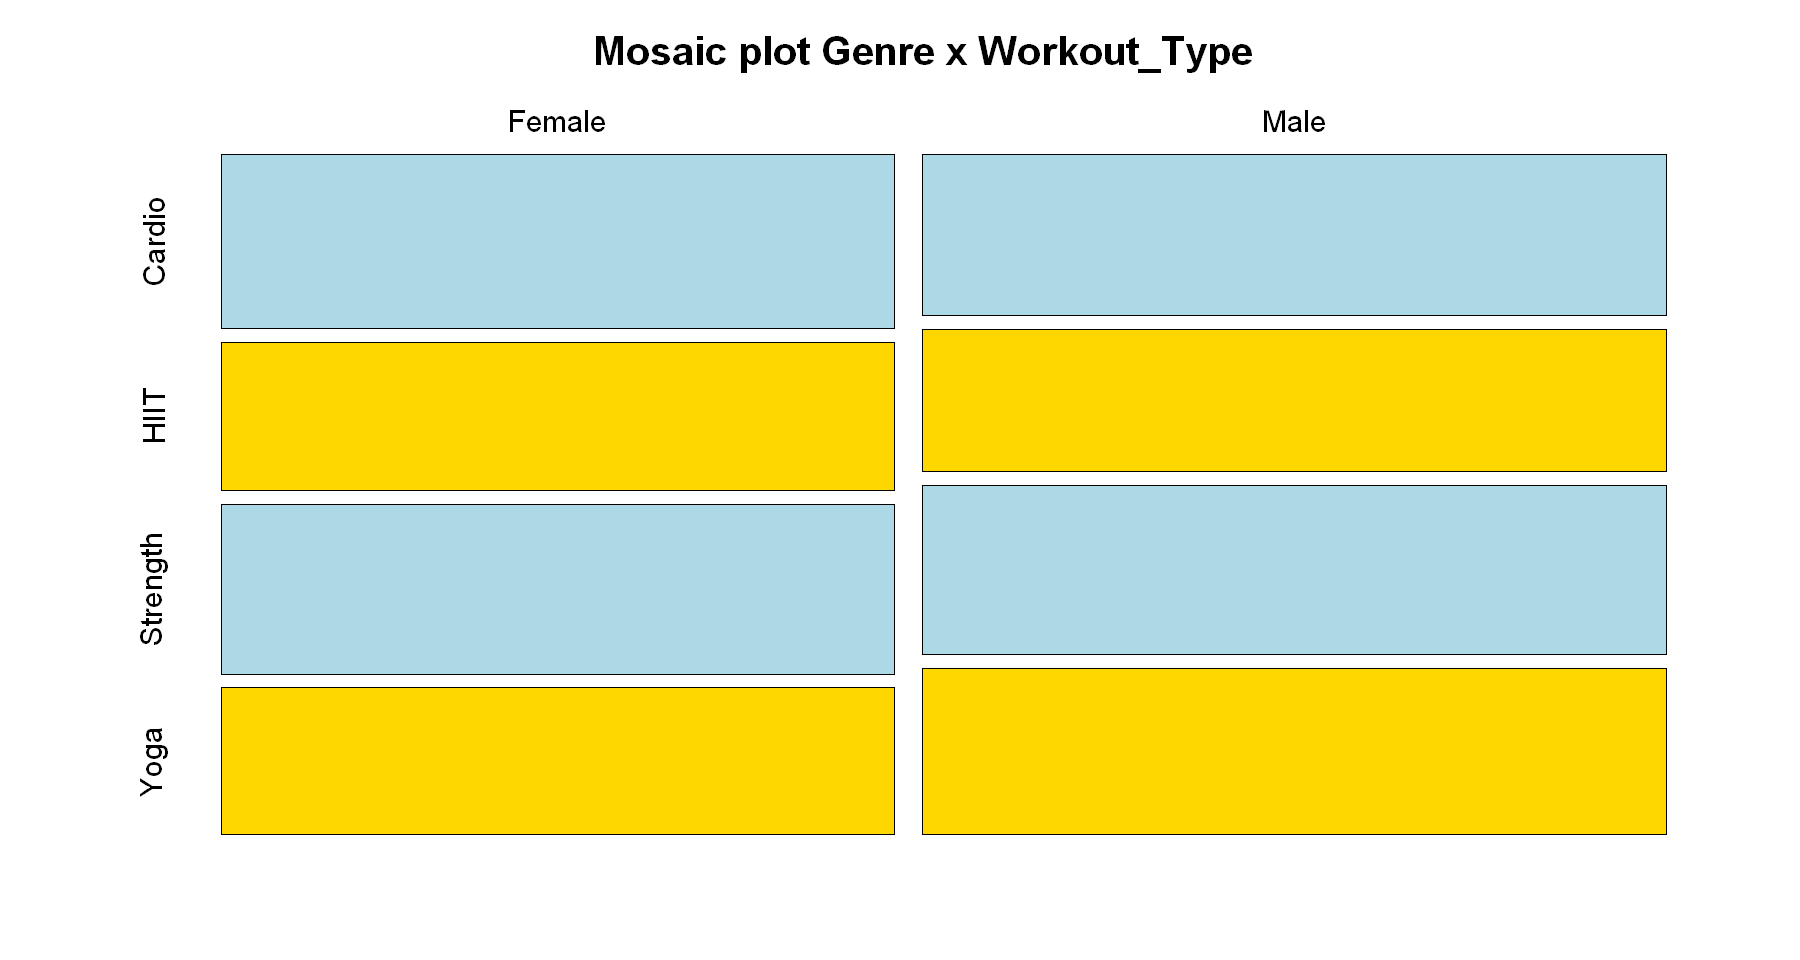

In [15]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Générer des mosaic plot pour les variables qualitatives
mosaicplot(table(gym$Gender, gym$Workout_Type),
    main = "Mosaic plot Genre x Workout_Type", 
    color = c("lightblue", "gold"), cex.axis = 1.5)


`Genre` x `Workout_Type` : les hommes et les femmes ont des préférences similaires pour les types d'entraînement HIIT et Strength mais il y a plus de pratiquant de Yoga chez les hommes que chez les femmes, et plus de pratiquant de Cardio chez les femmes que chez les hommes.


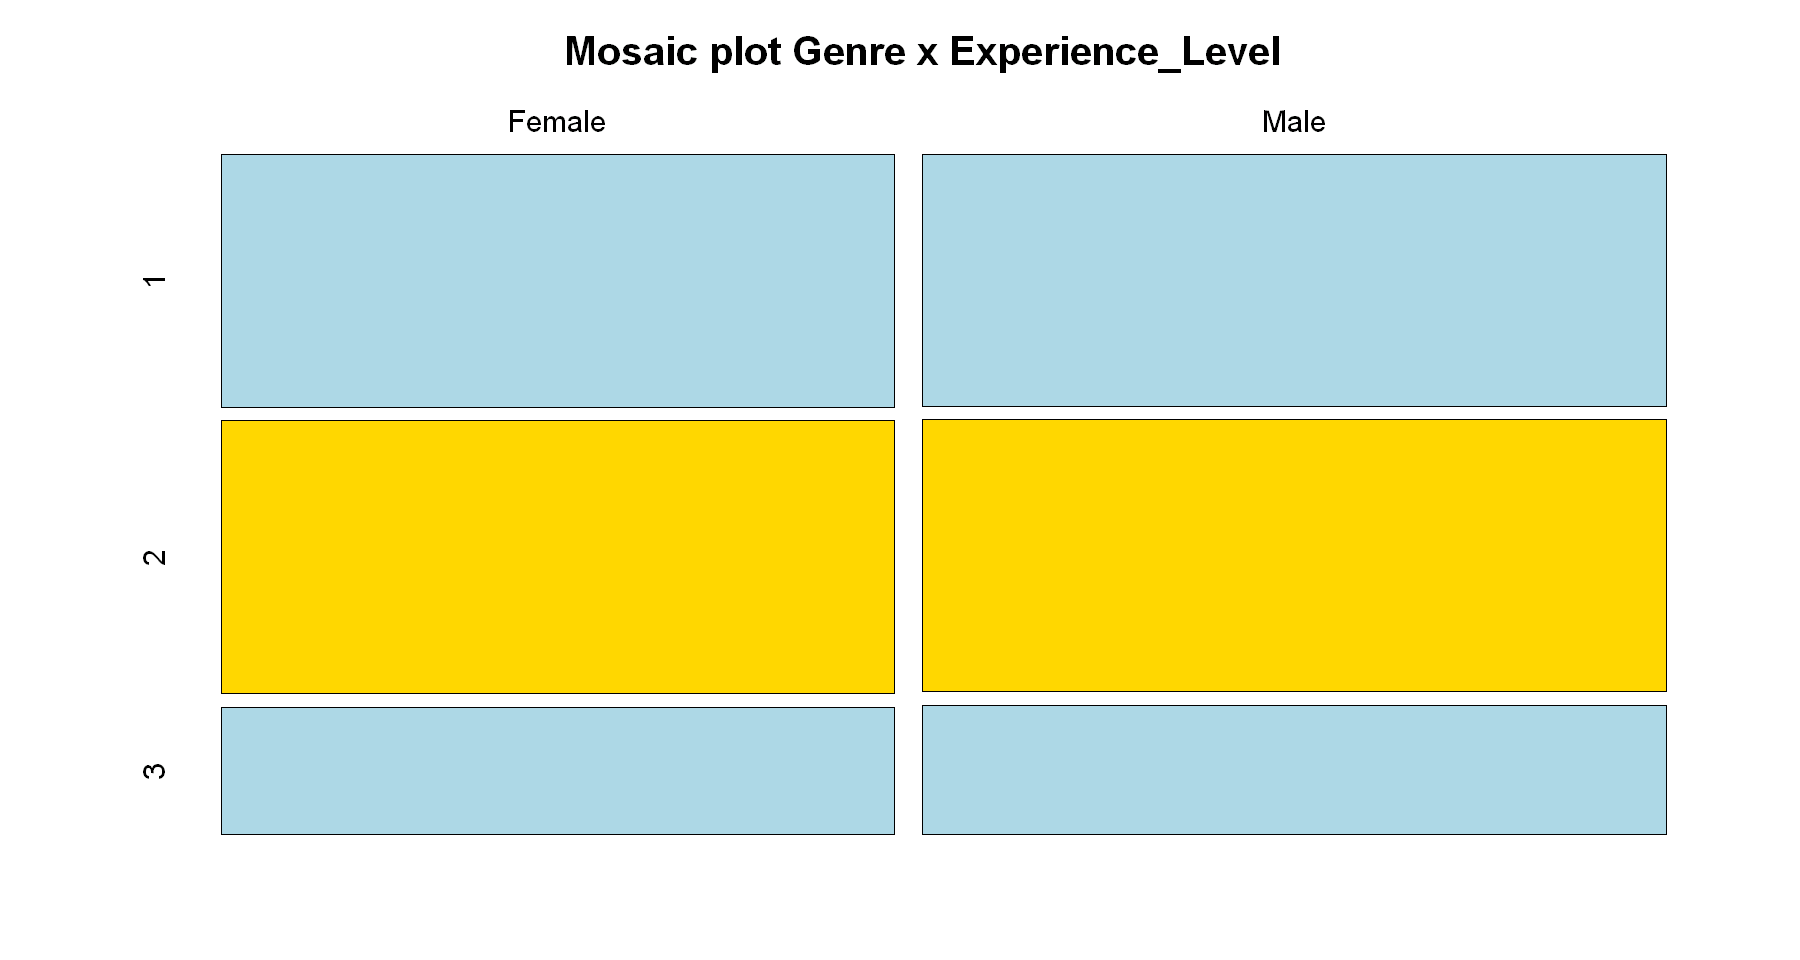

In [16]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)
mosaicplot(table(gym$Gender, gym$Experience_Level),
    main = "Mosaic plot Genre x Experience_Level",
    color = c("lightblue", "gold") , cex.axis = 1.5)

`Genre` x `Experienc_Level` : Les hommes et les femmes ont des niveaux d'expérience similaires.


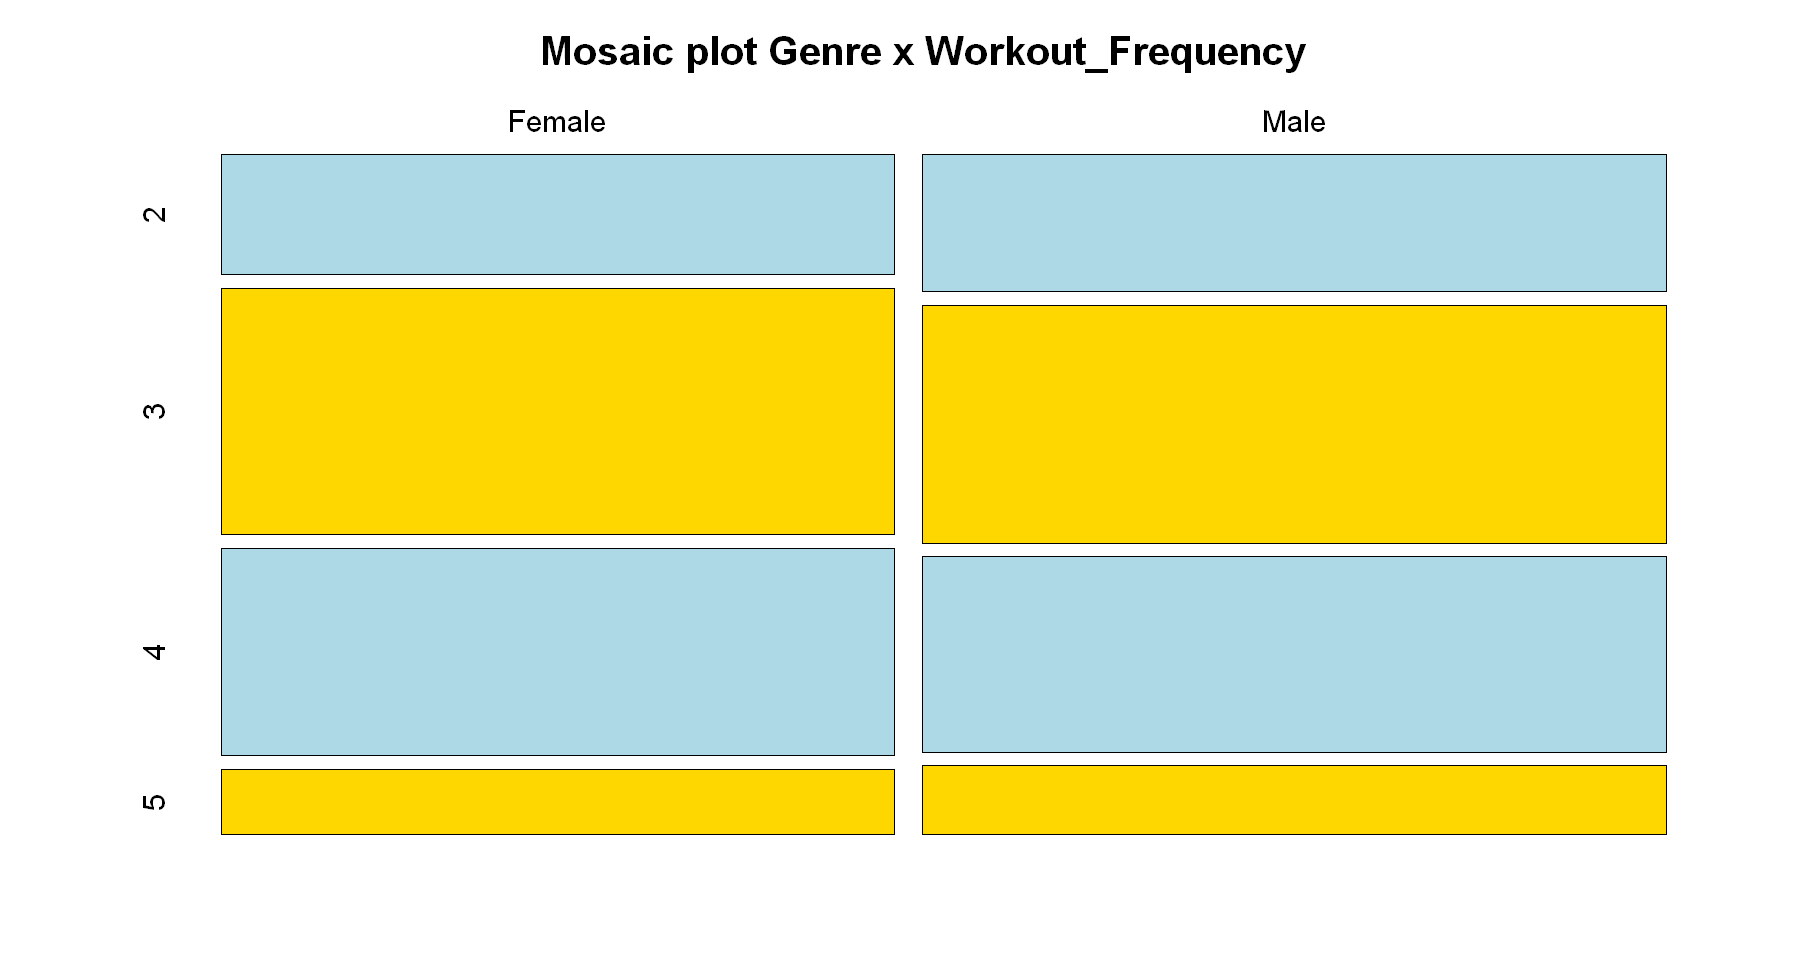

In [17]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)
mosaicplot(table(gym$Gender, gym$Workout_Frequency..days.week.),
    main = "Mosaic plot Genre x Workout_Frequency",
    color = c("lightblue", "gold"), cex.axis = 1.5)

`Genre` x `Workout_Frequency` : Il y un peu plus d'hommes qui s'entrainent 2x par semaine que les femmes, tandis qu'il y a plus de femmes qui s'entrainent 3 et 4 fois par semaine que les hommes. Pour 5 fois par semaine, il y en a autant.


In [18]:
# selectionner les variables quantitatives
gym_quanti = gym_analyse %>% select (Age, Weight..kg., Height..m., Max_BPM, Avg_BPM, Resting_BPM, Session_Duration..hours., Calories_Burned, Fat_Percentage, Water_Intake..liters.)

### Diagramme des corrélations

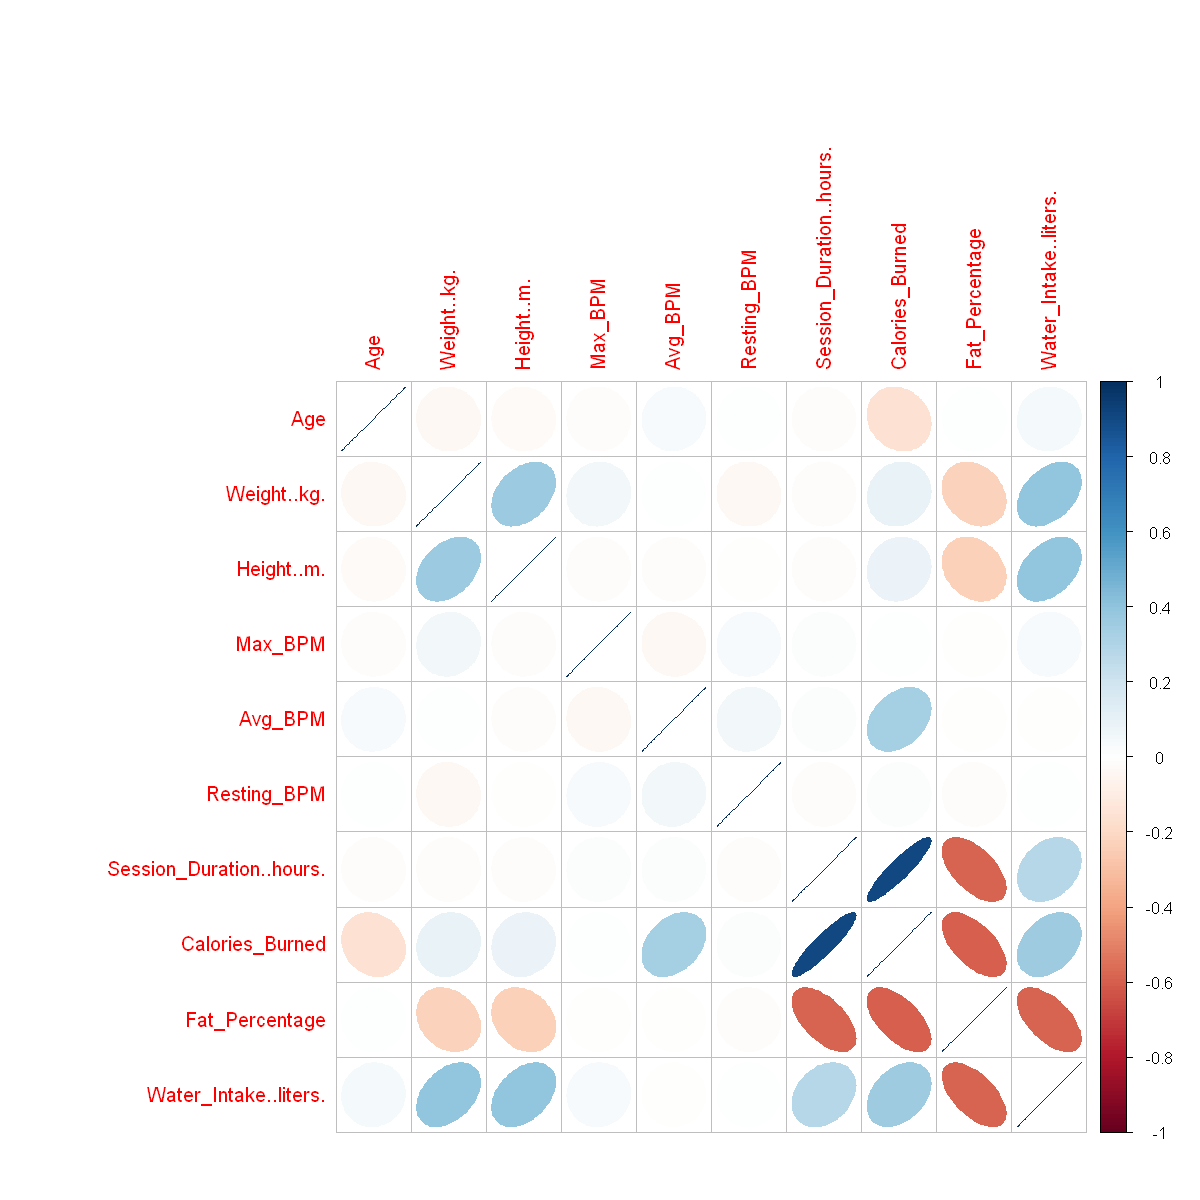

In [19]:
# matrice de corrélation
options(repr.plot.width=10, repr.plot.height=10)
corrplot(cor(gym_quanti), method = "ellipse")

Le corrplot ci-dessous montre les corrélations entre les variables quantitatives du jeu de données. Voici quelques observations clés :

- Une forte corrélation positive existe entre la durée de l'exercice (`Session_Duration`) et les calories brûlées (`Calories_Burned`), avec un coefficient de corrélation $r=0.91$. Cela correspond à l'attente selon laquelle **une durée d'exercice plus longue conduit généralement à une augmentation des calories brûlées**.
- Une moyenne correlation négative entre `Calories_Burned` et `Fat_Percentage` ($r = -0.60$) et `Session_Duration` et `Fat_Percentage` ($r = -0.58$) : Cela suggèrerait que **les individus avec un pourcentage de graisse plus élevé ne brûlent pas nécessairement plus de calories que la normale, et s'entraîraient moins longuement**, ce qui rejoindrait le point précedent sur les calories brulées et la durée de la séance.
- Une moyenne correlation entre `Fat_Percentage` et `Water_Intake` ($r = -0.59$). Cette relation pourrait indiquer que **les individus avec un meilleur niveau d'hydratation ont potentiellement une masse grasse corporelle moins élevée**.


Ces corrélations peuvent aider à identifier les relations entre les variables et à guider les analyses ultérieures, telles que la sélection de variables pour les modèles prédictifs.

### Reduction de dimension par ACP

Nous avons inclus `Calories_Burned` en tant que variable quantitative supplémentaire (`quanti.sup`) pour analyser sa corrélation avec les composantes principales, sans influencer leur construction. La variable `Experience_Level` a été placée en qualitative supplémentaire (`quali.sup`) afin de visualiser les groupes d’individus par niveau d’expérience. Cette approche permet de séparer clairement les variables explicatives (actives) des variables à prédire (supplémentaires), conformément à l’objectif de prédiction.

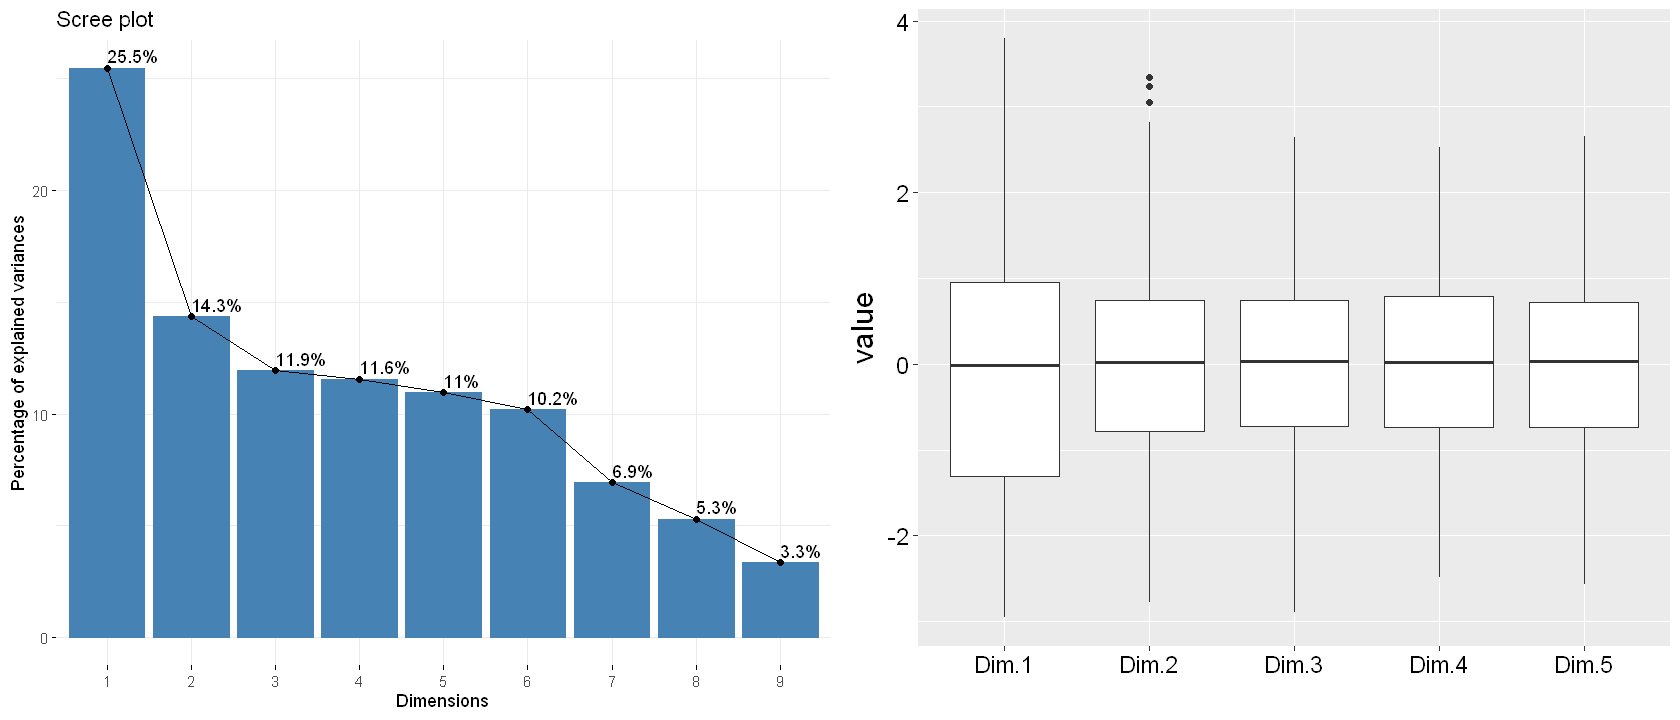

In [20]:
# Analyse en composantes principales
acp <- PCA(gym_analyse, scale.unit = TRUE, graph = FALSE, quali.sup = c(2, 10, 13, 14) , quanti.sup = c(9), ncp = 5)
# summary(acp)

options(repr.plot.width=14, repr.plot.height=6)

# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE)
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)


L’analyse des valeurs propres montre une structure multidimensionnelle des données. La méthode du coude, suggère de retenir **2 voire 3 composantes** (39% ou 51% d’inertie), mais celles-ci ne suffisent pas à résumer l’information. **Pour capturer 80% de la variance, 6 composantes sont nécessaires**, ce qui indique que les variables explicatives sont relativement indépendantes ou que plusieurs facteurs latents contribuent à la variabilité des données.

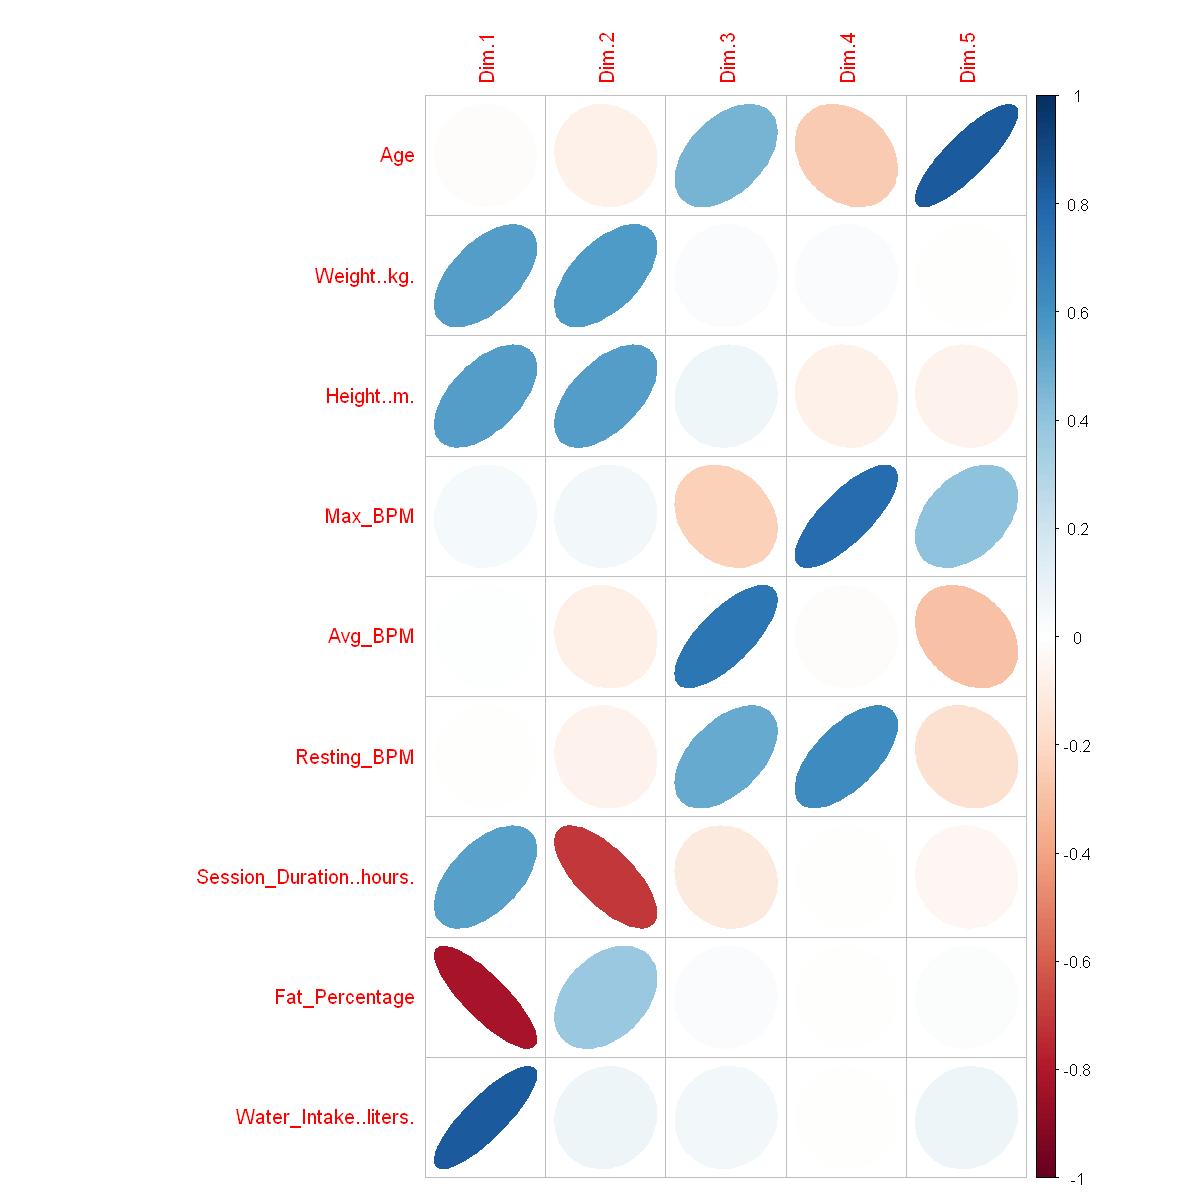

In [21]:
options(repr.plot.width=10, repr.plot.height=10)
corrplot(acp$var$cor, is.corr=TRUE,method="ellipse")

L'analyse du graphique des correlations des variables d'intérêt avec les dimensions réduites indique :

- les variables `LWeight`, `Height`, `Session_Duration..hours.`, `SFat_Percentage`, `Water_Intake..liters` contribuent fortement à la première dimension.
- pour la deuxième dimension, on retrouve `LWeight`, `Height` et `Session_Duration..hours.`, mais cette fois-ci, `Session_Duration..hours.` est opposé au deux autres.
- les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM` contribuent à la troisième dimension. 

Analysons désormais leur effets sur les graphes des variables ci-dessous.

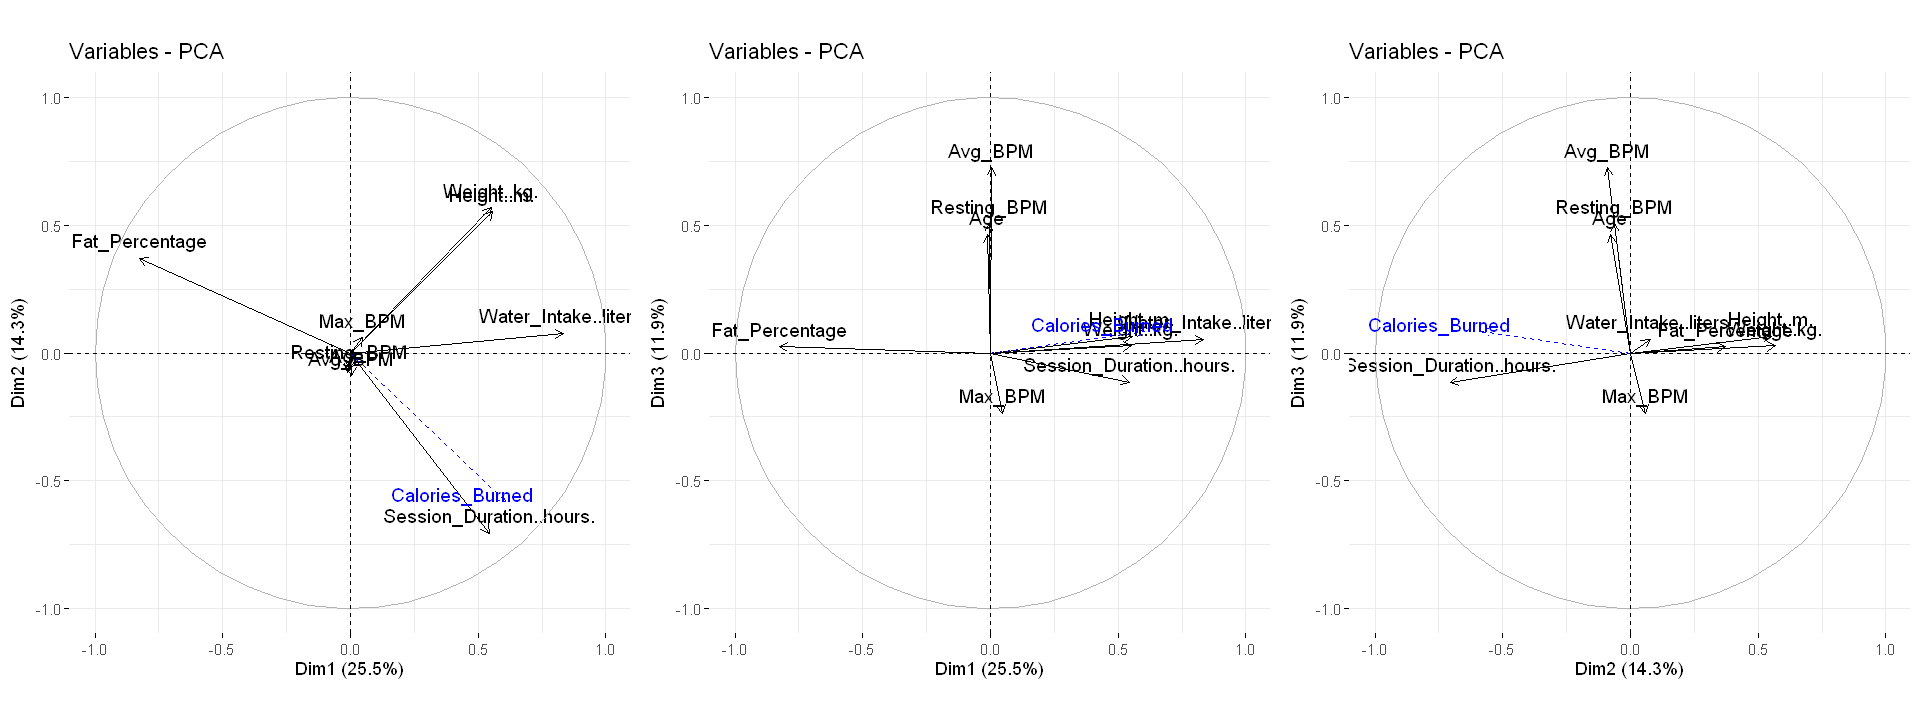

In [22]:
options(repr.plot.width=16, repr.plot.height=6)

par(original_par)
g1 <- fviz_pca_var(acp,axes=c(1,2))
g2 <- fviz_pca_var(acp,axes=c(1,3))
g3 <- fviz_pca_var(acp,axes=c(2,3))

grid.arrange(g1, g2, g3, ncol = 3)
rm(g1, g2, g3)

Les trois graphiques ci-dessus représentent la projection des features et de notre variable d'intêret `Calories_Burned` selon les dimensions (1, 2 ou 3).

- Sur les graphiques 1 et 3, on remarque que notre variable d'intêret `Calories_Burned` est fortement corrélée linéairement à `Session_Duration..hours.`, ce qui suggère que **le nombre de calories dépénd fortement de la durée de l'entraînement**.
- Sur le 1er graphique, on remarque que `Weight` et `Height` sont très fortement corrélés linéairement, ce qui impliquerait que **plus un individu est grand, plus il est lourd**.
- Sur le 1er graphique, on remarque que, selon la 2e dimension,  `Fat_Percentage` et `Water_Intake..liters.` sont négativement corrélés linéairement, ce qui suggère que **les individus à faible masse grasse auront tendance à boire plus d'eau que les autres**. On retrouve cette corrélation linéaire sur le 2e graphique selon la 3e dimension cette fois-ci.
- Enfin, sur les graphiques 2 et 3, on remarque que les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM` sont linéairement corrélées, en soulignant que la variable `Max_BPM` est corrélée négativement par rapport aux autres. Dans une moindre mesure, cela pourrait impliquer que :
    - **la fréquence maximale lors d'un effort** d'un individu **diminue avec l'âge**.
    - **Les efforts requierent un BPM moyen plus elevé lorsque l'âge augmente**, à moins que les personnes plus agées préfèrent des efforts impliquant un BPM moyen plus élévé (course à pied, HIIT) mais cela sera vérifié avec la variable quantitative `Workout_Type`.
    - Enfin, il semblerait que **la fréquence cardiaque au repos augmente avec l'âge**.

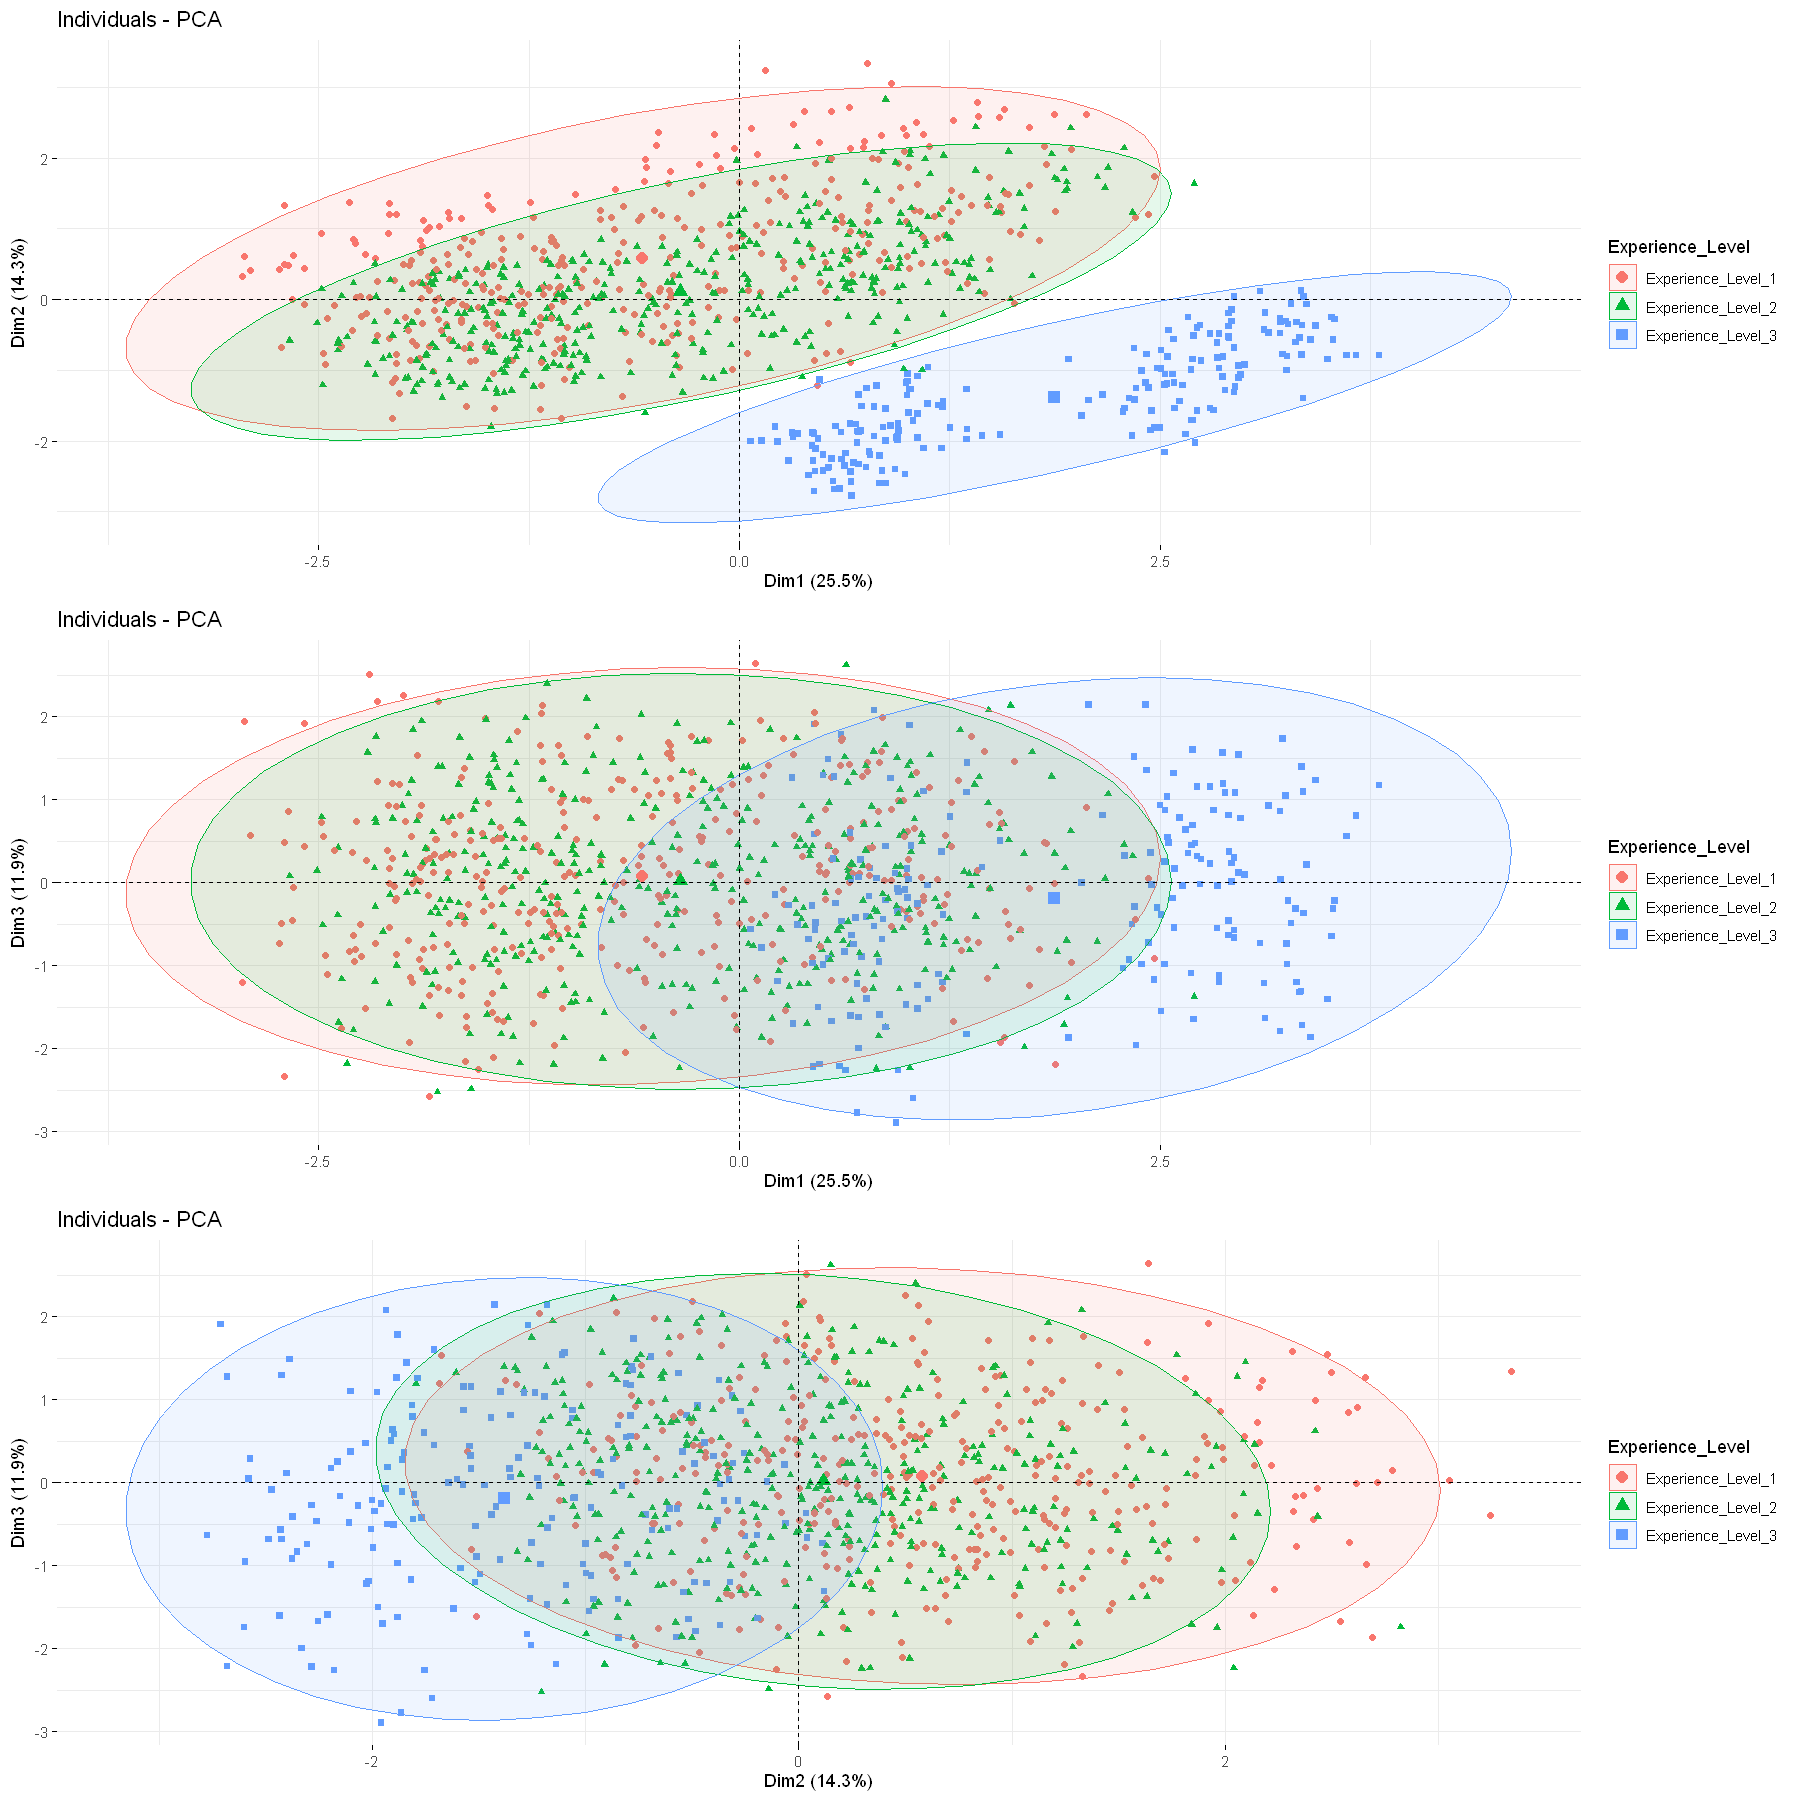

In [23]:
options(repr.plot.width=15, repr.plot.height=15)

g1 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(1,2), addEllipses = TRUE)
g2 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(1,3), addEllipses = TRUE)
g3 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(2,3), addEllipses = TRUE)

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

Les trois graphiques ci-dessus projète les individus dans les principaux plans facotriels. Chaque individu est colorié selon son niveau d'expérience (`Experience_Level`), qui est notre seconde variable à prédire.

La projection des individus selon leur niveau d’expérience révèle une séparation partielle dans l’espace des composantes principales. Les experts (niveau 3) se distinguent nettement des autres groupes dans le plan Dim.1-2, tandis que les débutants et intermédiaires partagent des profils similaires. Bien que les structures de covariance soient homogènes (ellipses parallèles), la discrimination complète des trois niveaux nécessitera probablement une combinaison de modèles linéaires (pour isoler les experts) et non linéaires (pour différencier les non-experts)

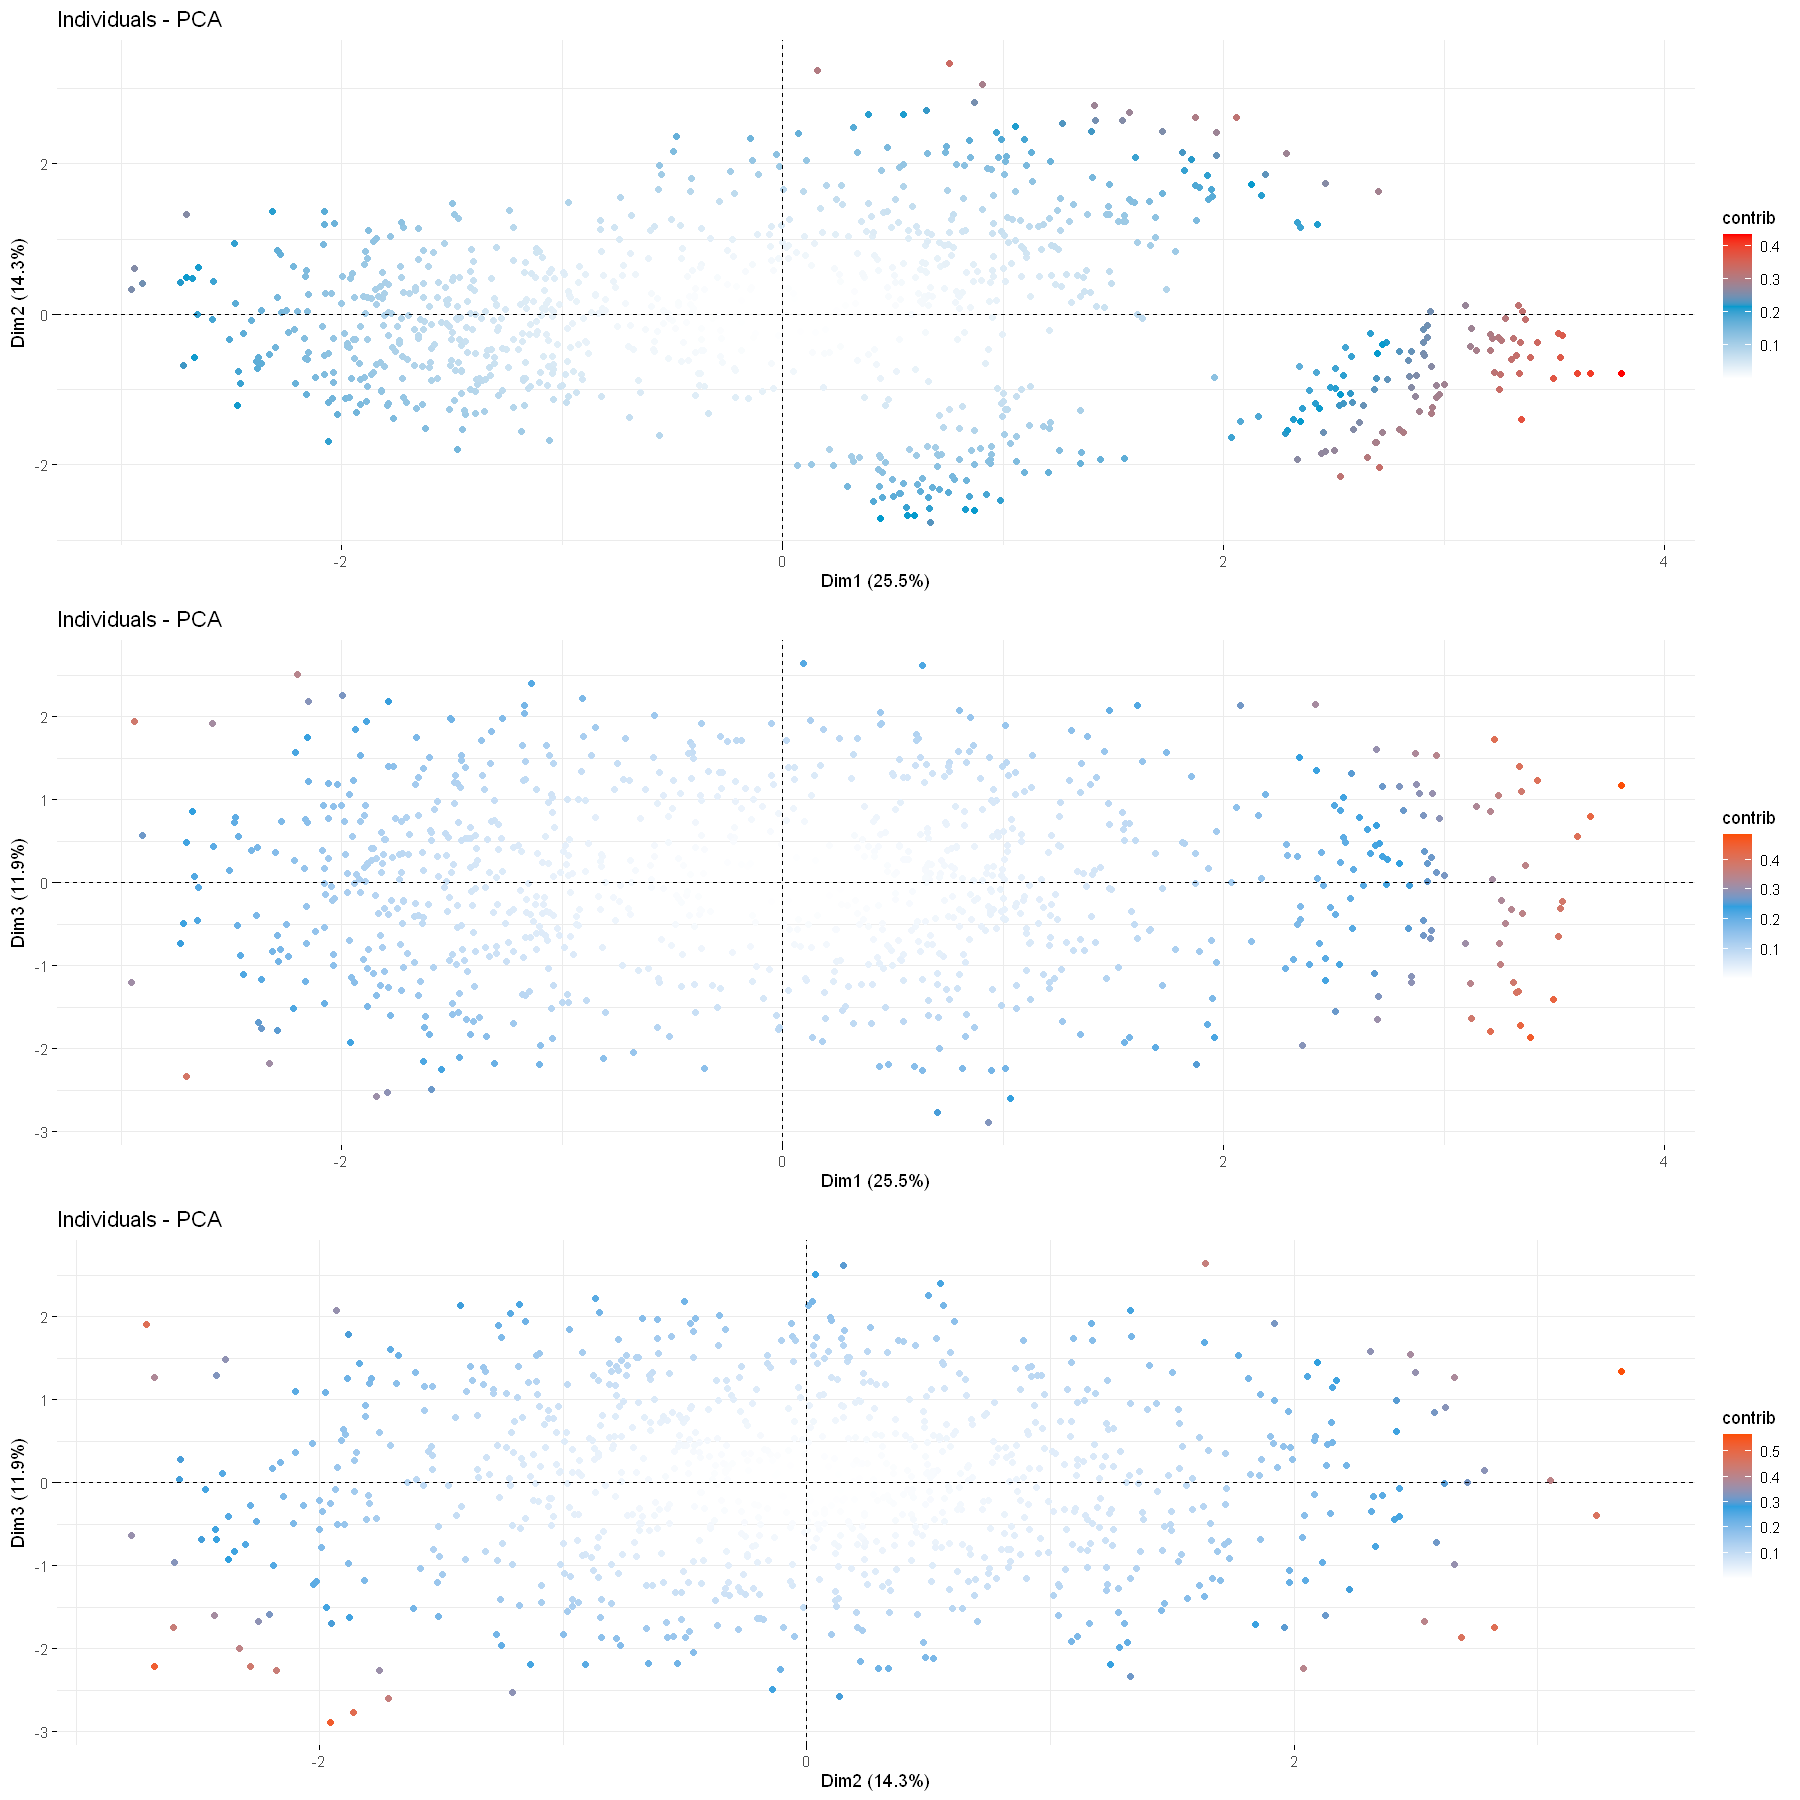

In [24]:
options(repr.plot.width=15, repr.plot.height=15)

g1 <- fviz_pca_ind(acp,col.ind="contrib",label="true",gradient.cols = c("white", "deepskyblue3", "red" ))
g2 <- fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
g3 <- fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(2,3))

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

Les trois graphiques ci-dessus projète les individus dans les principaux plans facotriels, mais cette fois-ci, les individus sont coloriés en fonction de leur contribution. La contribution d’un individu à une composante **mesure son influence** sur la variance expliquée par cette composante.

Les points en rouge correspondent aux individus ayant un poids disproportionné sur l’orientation des axes. Ils pourraient biaiser l'orientation des axes (ex: bodybuilders extrêmes, débutants complets).

On retrouve en bas à droite du 1er graphique un groupe d'outliers correspondant aux individus expérimentés (`Experience_Level` = 3). Certains possèdent une contribution très élevée sur la dimension 1 et il serait pertinent de vérifier leurs valeurs. Il correspondraient probablement à des individus ayant des **morphotypes extrêmes** (très grands/lourds, ou au contraire très petits/léger), **excessivement sec** (masse grasse très faible) ou inversement. Il pourraient aussi correspondre à des personnes **buvant énormément ou peu d'eau**. On retrouve un résultat similaire sur le graphique n°2, selon la dimension 1, qui correspond sûrement au même groupe de personnes.

On détecte aussi les individus influents sur **l’interaction entre durée de séance (Dim.2) et paramètres cardiaques (Dim.3)**. Ils pourraient représenter des individus à **séances très longues** et/ou à **fréquences cardiaques extrêmes**.

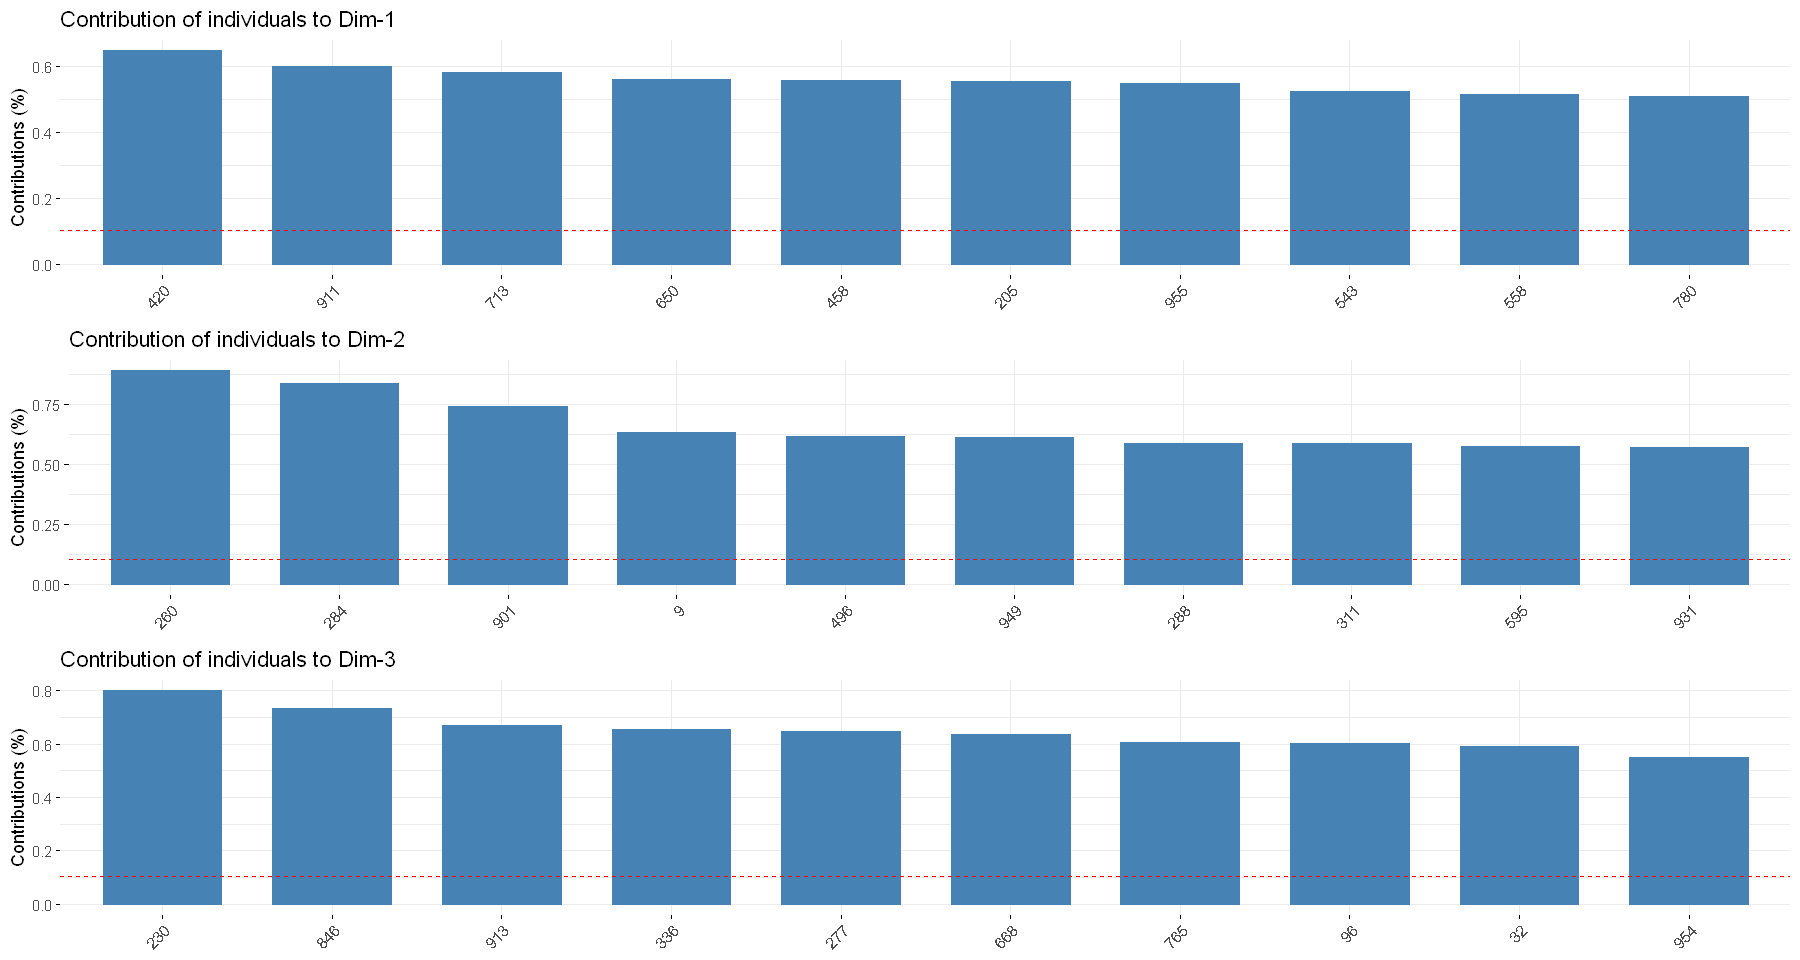

In [25]:
options(repr.plot.width=15, repr.plot.height=8)
# analyse des outliers
g1 <- fviz_contrib(acp, choice = "ind", axes = 1, top = 10)
g2 <- fviz_contrib(acp, choice = "ind", axes = 2, top = 10)
g3 <- fviz_contrib(acp, choice = "ind", axes = 3, top = 10)

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

In [26]:
# display the outliers : 420, 711, 713 and 650
gym_analyse_median <- apply(gym_analyse, 2, median)
print("Median values:")
gym_analyse_median
gym_analyse[c(420, 711, 713, 650),]

[1] "Median values:"


Age                        Gender 
                         "40"                        "Male" 
                  Weight..kg.                    Height..m. 
                      " 70.0"                        "1.71" 
                      Max_BPM                       Avg_BPM 
                        "180"                         "143" 
                  Resting_BPM      Session_Duration..hours. 
                         "62"                        "1.26" 
              Calories_Burned                  Workout_Type 
                       " 893"                    "Strength" 
               Fat_Percentage         Water_Intake..liters. 
                       "26.2"                         "2.6" 
Workout_Frequency..days.week.              Experience_Level 
                          "3"                           "2"

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
420,47,Male,86.6,1.99,182,153,70,1.98,1500,Strength,10.6,3.5,4,3
711,38,Male,123.3,1.62,161,165,65,1.34,1216,Yoga,21.2,2.3,4,2
713,19,Male,82.4,1.96,174,169,62,1.90,1766,HIIT,10.1,3.5,5,3
650,27,Male,88.5,1.98,161,153,53,1.80,1515,Cardio,11.1,3.5,4,3


Selon la dim. 1, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en regardant particulièrement `Weight`, `Height`, `Session_Duration..hours.`, `Fat_Percentage` et `Water_Intake`.

Les individus 420, 713 et 650 sont des individus **très grands**, (~1m97 par rapport à la médiane = 1.71), **qui s'entrainent longuement** (~1.90 hours par rapport à 1.26 hours), qui ont **une masse grasse bien en-dessous de la médiane** (~10.5% par rapport à 26.2%) et **qui boivent beaucoup d'eau** (3.5 litres par rapport à 2.6 litres). Ils correspondent très exactement aux valeurs extrêmes dans les variables contribuant énormément pour la dimension 1.

L'individu 711 en revanche est **très lourd et très petit**, et avec d'autres métriques dans la moyenne. Il correspond réellement à une valeur complètement abbérante.

In [27]:
# display the outliers for dim 2
gym_analyse[c(260, 284, 901, 9),]

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
260,53,Male,125.1,1.91,171,137,70,0.52,353,Strength,28.3,3.1,2,1
284,20,Male,128.4,1.92,167,145,57,0.63,502,Cardio,26.1,2.0,2,1
901,30,Male,120.3,1.96,171,136,65,0.66,494,Yoga,23.9,2.6,2,1
9,28,Male,121.7,1.94,185,127,52,1.03,719,Strength,28.9,2.6,4,2


Selon la dim. 2, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en regardant tout particulièrement le contraste entre  `Session_Duration..hours.` par rapport à `Weight`, `Height` et `Fat_Percentage`.

Les 4 individus sont **très grand et lourds**, avec une masse grasse au-dessus de la médiane (excepté 284), et qui font des séances **plutôt courtes** allant de 30 minutes à 1h par rapport à la médiane qui est de 1h15. Encore une fois, cela correspond à des valeurs extrêmes dans les variables contribuant majoritairement pour la dimension 2.

In [28]:
# display the outliers for dim 2 : 420, 711, 713 and 650
gym_analyse[c(230, 846, 913, 336),]

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
230,18,Female,63.9,1.59,185,125,50,1.87,1169,Strength,16.4,2.7,4,3
846,23,Female,60.1,1.59,191,123,52,1.80,1107,HIIT,17.6,2.7,4,3
913,55,Male,118.6,1.72,163,168,67,0.77,640,Strength,25.9,2.6,3,1
336,59,Male,88.1,1.76,187,168,74,1.35,1123,Strength,26.9,3.0,3,2


Selon la dim. 3, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en observant les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM`.

Les 4 individus sont en effet plûtot **jeunes ou plutôt agés**, et qui ont particulièrement un `Average_BPM` **plus élevé ou plus faible** que la médiane (143 BPM).

### Reduction de dimension par LDA


Attaching package: 'MASS'


The following object is masked from 'package:plotly':

    select


The following object is masked from 'package:dplyr':

    select




,LD1,LD2
Age,-0.024586788,-0.023004991
Weight..kg.,-0.008289603,-0.012546692
Height..m.,-1.349569949,-0.364142631
Max_BPM,0.001786881,0.008053876
Avg_BPM,0.036550847,0.035992898
Resting_BPM,0.004552259,0.002257547
Session_Duration..hours.,7.556845731,0.846820037
Calories_Burned,-0.006523153,-0.006313766
Fat_Percentage,-0.255013877,-0.165323660
Water_Intake..liters.,0.214426893,0.590023235


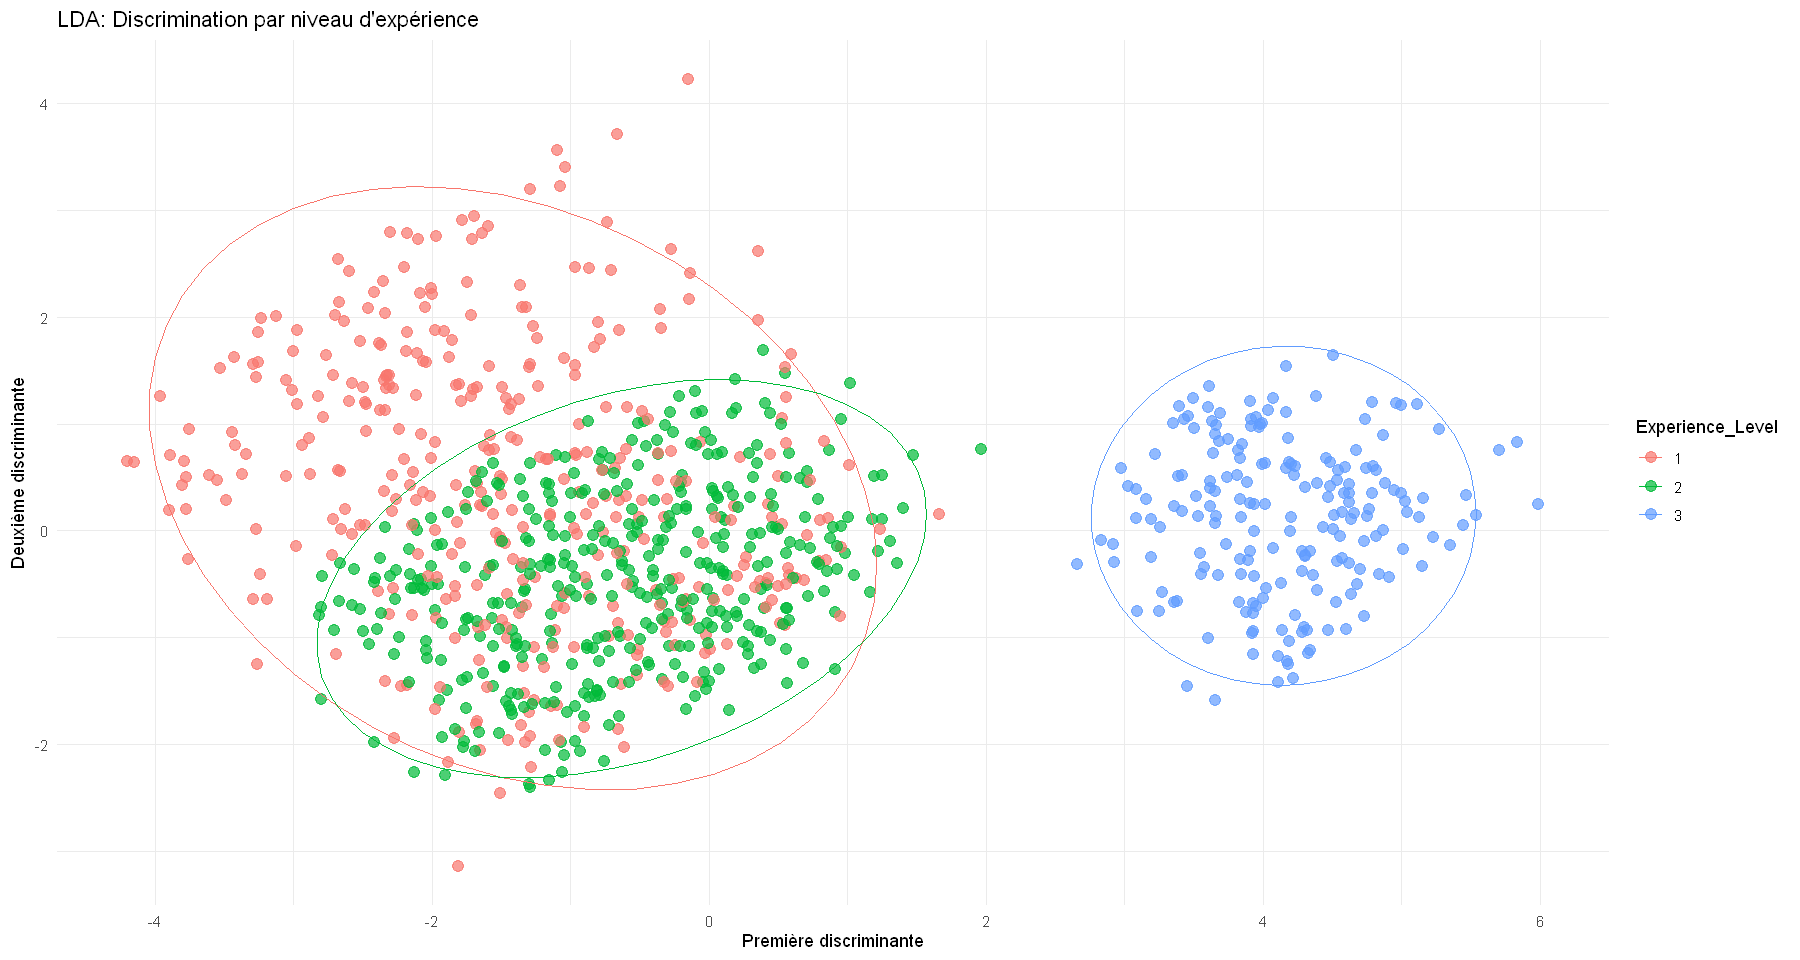

In [29]:
# Linear Discriminant Analysis
# Let's use Experience_Level as the target variable
library(MASS)

# Create a dataframe with the quantitative variables and the target variable
gym_lda_data <- cbind(gym_quanti, Experience_Level = gym$Experience_Level)

# Perform LDA
lda_result <- lda(Experience_Level ~ ., data = gym_lda_data)

# Summary of the LDA model
lda_result$scaling


# Create better visualization with ggplot2
lda_pred <- predict(lda_result, gym_lda_data)
lda_df <- data.frame(
    LD1 = lda_pred$x[,1],
    LD2 = lda_pred$x[,2],
    Experience_Level = gym_lda_data$Experience_Level
)

# Visualize the LDA results
ggplot(lda_df, aes(x = LD1, y = LD2, color = Experience_Level)) +
    geom_point(size = 3, alpha = 0.7) +
    stat_ellipse() +
    labs(title = "LDA: Discrimination par niveau d'expérience",
             x = "Première discriminante",
             y = "Deuxième discriminante") +
    theme_minimal()


#### Interpretation des résultats de la LDA sur Experience level: 
On observe du graphe que la LDA permet bien de séparer les Experts (3) sur l’axe LD1, car ils sont clairement décalés.
Mais elle a plus de mal entre Débutants (1) et Intermédiaires (2), qui se mélangent beaucoup.
LD1 (axe horizontal - Première discriminante) :

- C’est l’axe principal de séparation.
Variables qui contribuent le plus à LD1 :

    Session_Duration (7.6756) : plus la durée d'entraînement est grande, plus ça tire vers la droite (plutôt vers les Experts). Water_Intake..liters. (0.21): Un effet positif, indiquant que l'hydratation joue un rôle dans la différenciation des groupes. 
    Weight et Height (-1.6378): plus le poids et la taille sont faibles, plus LD1 augmente.

- Interprétation :
LD1 semble principalement différencier les individus en fonction de leur engagement dans l'entraînement : la durée des sessions est le facteur dominant, avec un lien secondaire avec la taille et le poids.
Les Experts sont plutôt des personnes :

    Qui font des séances plus longues.
    Qui ont un IMC plus élevé.
    Et qui sont peut-être plus “légers” (au sens du poids, vu le signe négatif, mais à vérifier avec les données).

LD2 (axe vertical - Deuxième discriminante) :

- C’est l’axe secondaire, qui affine la séparation (notamment entre classes 1 et 2). Variables qui contribuent le plus à LD2 :

   Water_Intake..liters. (0.59): Influence la séparation sur ce second axe, indiquant que l'hydratation pourrait différencier des groupes d'expérience.
    Session_Duration..hours. (0.85): Reste un facteur important, mais avec moins d’impact que sur LD1.
    Height..m. (-0.36): Influence négative, mais plus faible que sur LD1.

- Interprétation :
LD2 est plus influencé par l’hydratation et d'autres variables secondaires, suggérant un axe de distinction différent, peut-être lié à des habitudes physiologiques ou nutritionnelles.

In [30]:
head(gym_quanti)

,Age,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Fat_Percentage,Water_Intake..liters.
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,88.3,1.71,180,157,60,1.69,1313,12.6,3.5
2,46,74.9,1.53,179,151,66,1.30,883,33.9,2.1
3,32,68.1,1.66,167,122,54,1.11,677,33.4,2.3
4,25,53.2,1.70,190,164,56,0.59,532,28.8,2.1
5,38,46.1,1.79,188,158,68,0.64,556,29.2,2.8
6,56,58.0,1.68,168,156,74,1.59,1116,15.5,2.7


### Clustering par Kmeans

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


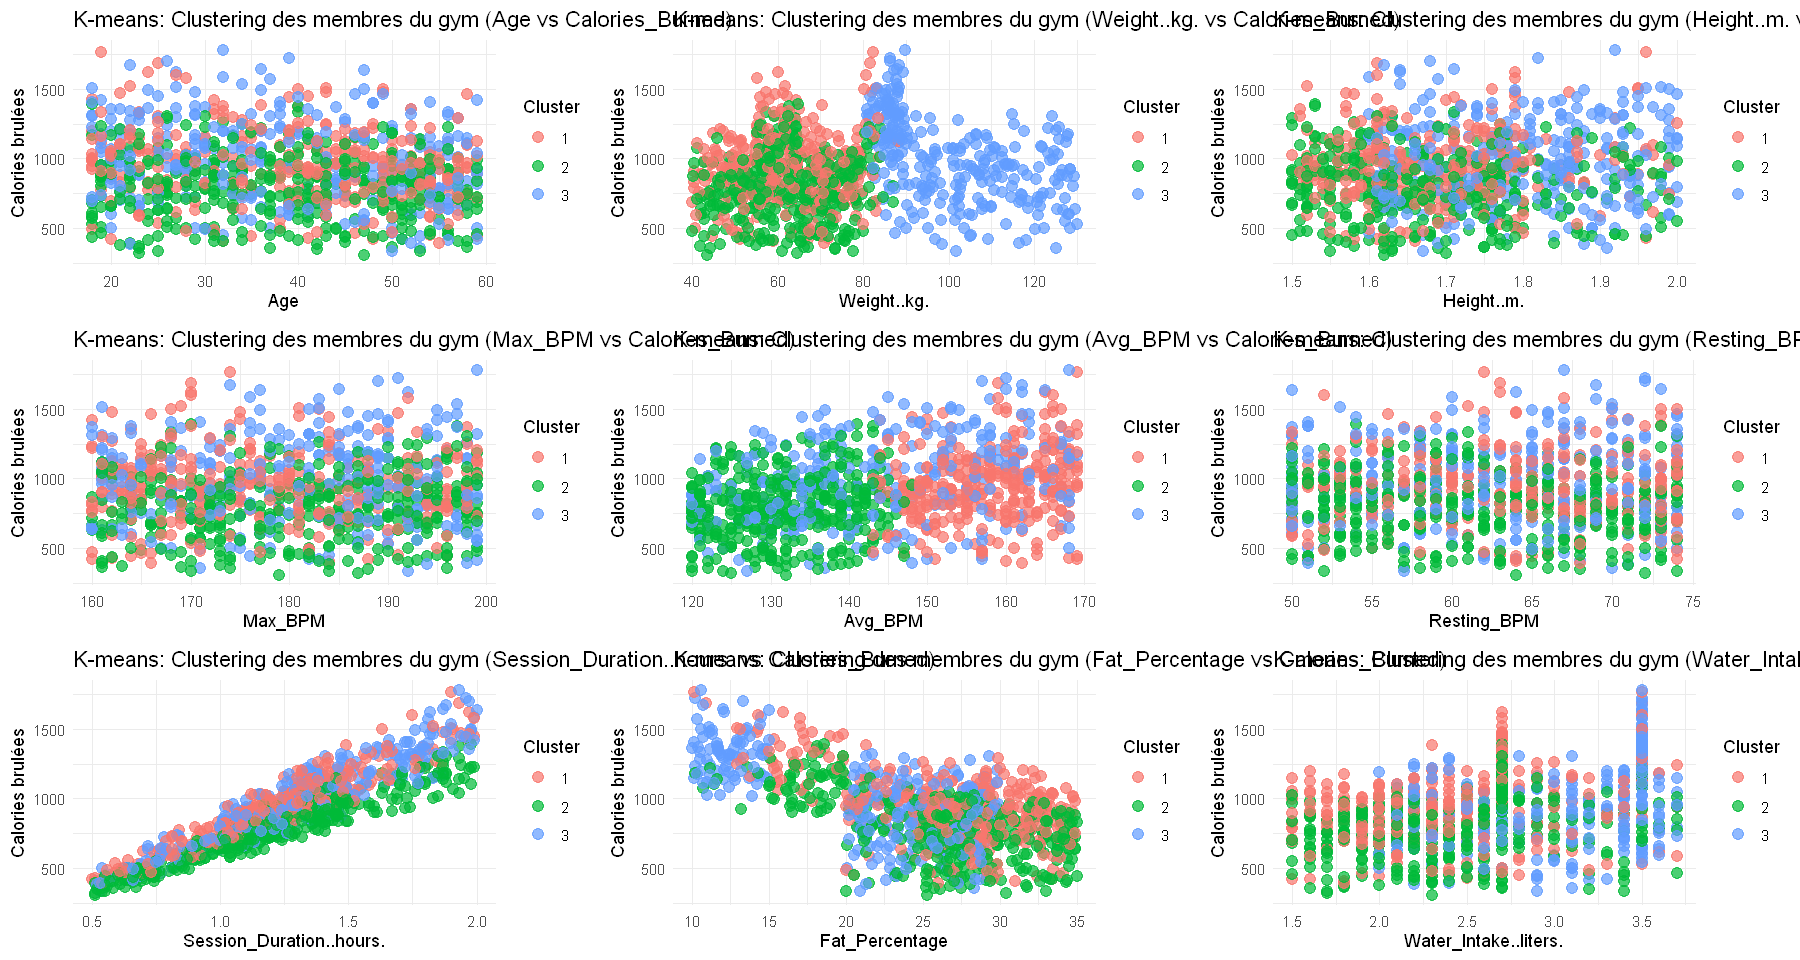

In [31]:
#kmeans clustering method with he gym data set with 3 clusters
#create a data set without calories burned
gym_quanti2 <- gym_quanti[, -8]
#head(gym_quanti2)
kmeans_result <- kmeans(gym_quanti2, centers = 3, nstart = 50)
#kmeans_result$cluster
#head(gym_quanti)
# Create a dataframe with the quantitative variables and the cluster variable
gym_kmeans_data <- cbind(gym_quanti, Cluster = as.factor(kmeans_result$cluster))



# Plot all clusters for y = Calories_Burned and x varies with all the variables
plot_list <- list()
for (var in names(gym_quanti2)) {
     p <- ggplot(gym_kmeans_data, aes_string(x = var , y = "Calories_Burned", color = "Cluster")) +
          geom_point(size = 3, alpha = 0.7) +
          labs(title = paste("K-means: Clustering des membres du gym (", var, " vs Calories_Burned)", sep = ""),
                x = var,
                y = "Calories brulées") +
          theme_minimal()
     plot_list[[var]] <- p
}

# Display all plots
do.call(grid.arrange, c(plot_list, ncol = 3))


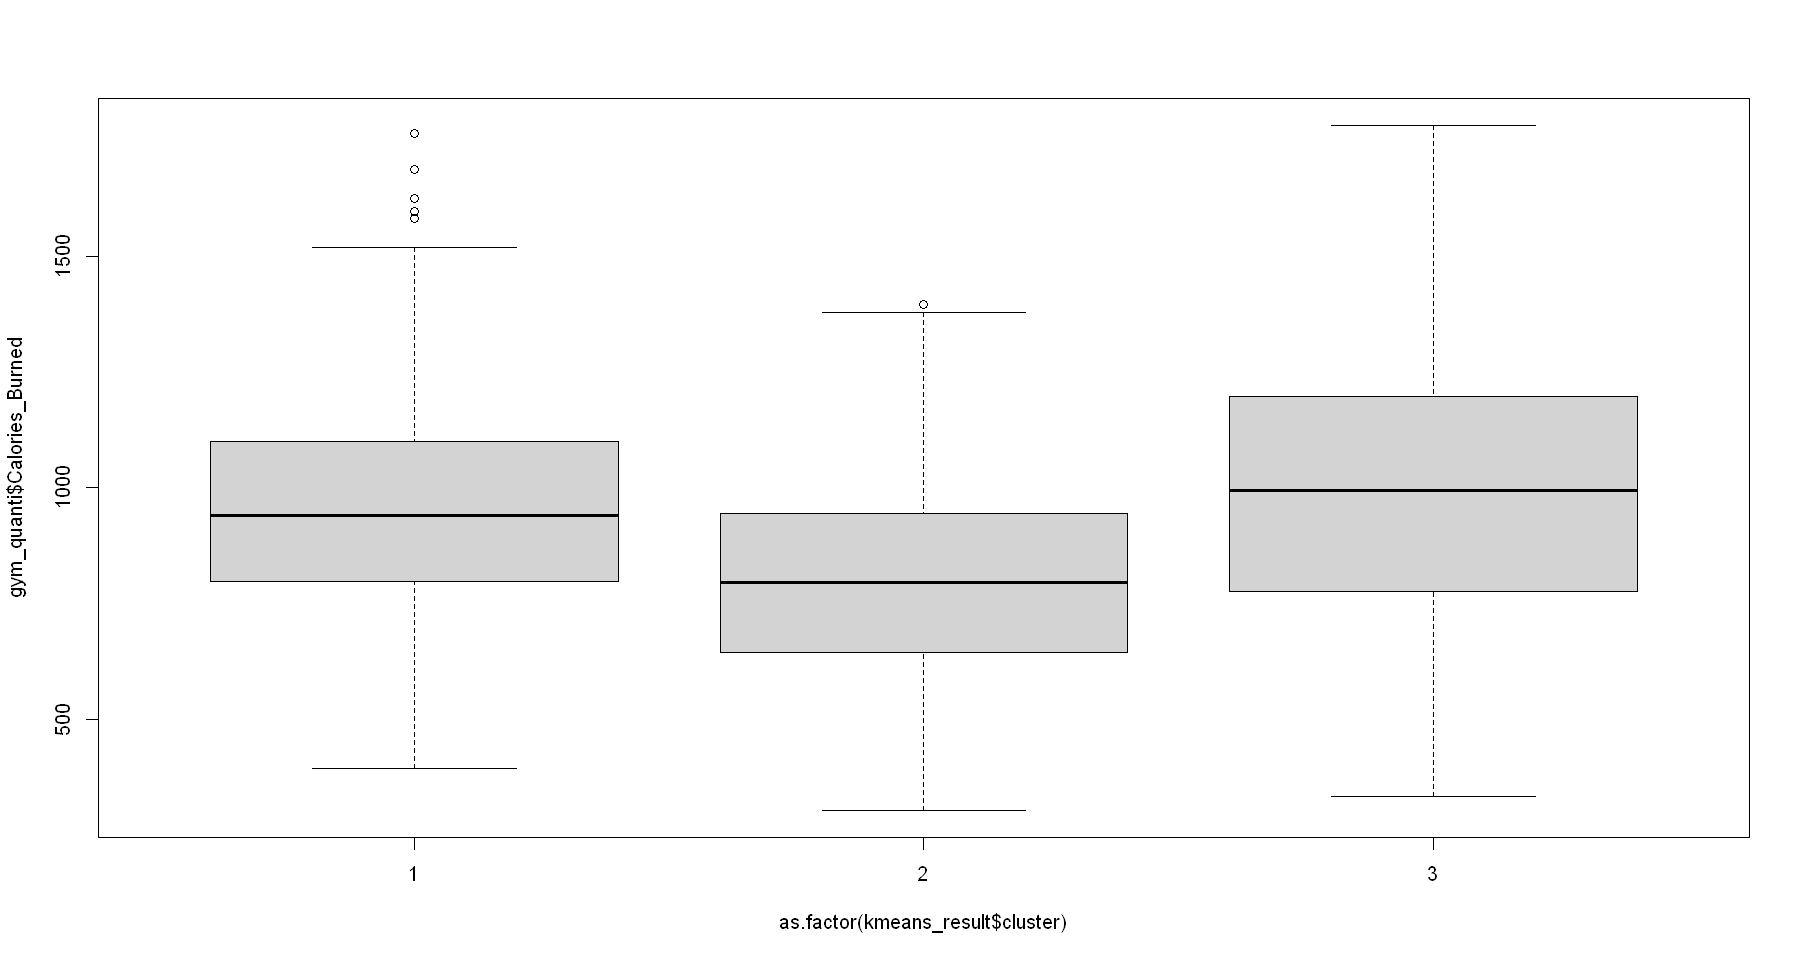

In [32]:
boxplot(gym_quanti$Calories_Burned~as.factor(kmeans_result$cluster))

On constate que le cluster semble dependre uniquement de la valeure de calories burned, la variable session_duration est la seule qui présente un lien avec la variable calories burned et les clusters , à faire en enlevant calories burned pour faire les clusters 

### Conclusion: 

En explorant nos données sur les membres de la salle de sport, nous avons utilisé différentes techniques qui, ensemble, nous donnent une bien meilleure compréhension que si nous les avions utilisées séparément.

En effet, l'ACP et le clustering chercher des schémas et des groupes dans les données sans qu'on leur dise quoi chercher.
*   L'**ACP (Analyse en Composantes Principales)** nous a aidés à voir comment plusieurs caractéristiques sont liées en même temps (par exemple, comment la durée de la séance, le pourcentage de graisse et la consommation d'eau peuvent ensemble définir un "style de vie sain"). Elle a aussi pointé du doigt des personnes aux caractéristiques physiques très inhabituelles.
*   Le **Clustering** a regroupé naturellement les personnes qui se ressemblent (par exemple, un groupe qui fait des séances courtes avec une fréquence cardiaque élevée et boit peu, et un autre qui fait des séances longues, a peu de graisse et boit beaucoup).

On a également pû via, la **LDA** et les **Corrélations**, détecter des tendances plus spécifiques 
En effet, 
*   La **LDA (Analyse Discriminante Linéaire)** nous a montré ce qui différencie le mieux certains groupes, par exemple, ce qui distingue les "experts" (séances longues, peu de graisse) des autres membres.
*   Les **Corrélations** nous ont montré des liens directs et chiffrés entre deux choses (par exemple, plus la séance est longue, plus on brûle de calories).


Ayant ainsi démêlé les complexités, identifié les variables les plus influentes et compris les relations, parfois subtiles, entre les différents attributs de nos membres, nous sommes désormais en excellente position pour passer à la modélisation prédictive. L'objectif sera de construire, d'entraîner et d'évaluer rigoureusement des modèles capables d'estimer avec précision des indicateurs clés tels que les calories brûlées et de classifier de manière fiable le niveau d'expérience des membres, en s'appuyant sur les enseignements tirés de notre analyse exploratoire pour guider la sélection des caractéristiques et le choix des algorithmes.


# Prédiction de la variable Calories_Burned

## Linear Regression

In [ ]:
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
#scaler <- scale(gym_train[,-c(2,10,13,14)])
scaler <- scale(gym_train[,-c(2,9,10,13,14)])  # Exclure la colonne Calories_Burned (colonne 9)
# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")


# Appliquer la normalisation uniquement sur les colonnes sélectionnées
gym_train_scaled[,-c(2,9,10,13,14)] <- scale(gym_train[,-c(2,9,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,9,10,13,14)] <- scale(gym_test[,-c(2,9,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

#Fonction qui calcule et affiche le pourcentage d'erreur 
#à partirde la matrice de confusion
pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

# Initialiser tableau des résultats
results <- data.frame(
  Methode = character(),
  Accuracy = numeric(),
  LogLoss = numeric(),
  Temps = numeric(),
  stringsAsFactors = FALSE
)

Data loaded and preprocessed

In [34]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned    Workout_Type SFat_Percentage   
 Min.   :-2.20445   

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned    Workout_Type SFat_Percentage   
 Min.   :-2.17545         M

### Régression Linéaire

Time taken for linear regression:  0.01051807  seconds



Call:
lm(formula = Calories_Burned ~ ., data = gym_train_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-129.781  -25.798   -2.093   21.929  174.692 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    863.83896    5.84203 147.866   <2e-16 ***
Age                            -41.48959    1.47443 -28.139   <2e-16 ***
GenderMale                      90.90917    5.96339  15.245   <2e-16 ***
LWeight                          2.37302    1.81802   1.305    0.192    
Height..m.                       0.56211    1.79582   0.313    0.754    
Max_BPM                          0.43035    1.48189   0.290    0.772    
Avg_BPM                         90.48059    1.47639  61.285   <2e-16 ***
Resting_BPM                      2.40358    1.47472   1.630    0.104    
Session_Duration..hours.       245.80498    2.40398 102.249   <2e-16 ***
Workout_TypeHIIT                 1.37064    4.18464   0.328    0.743    
Workout_Type

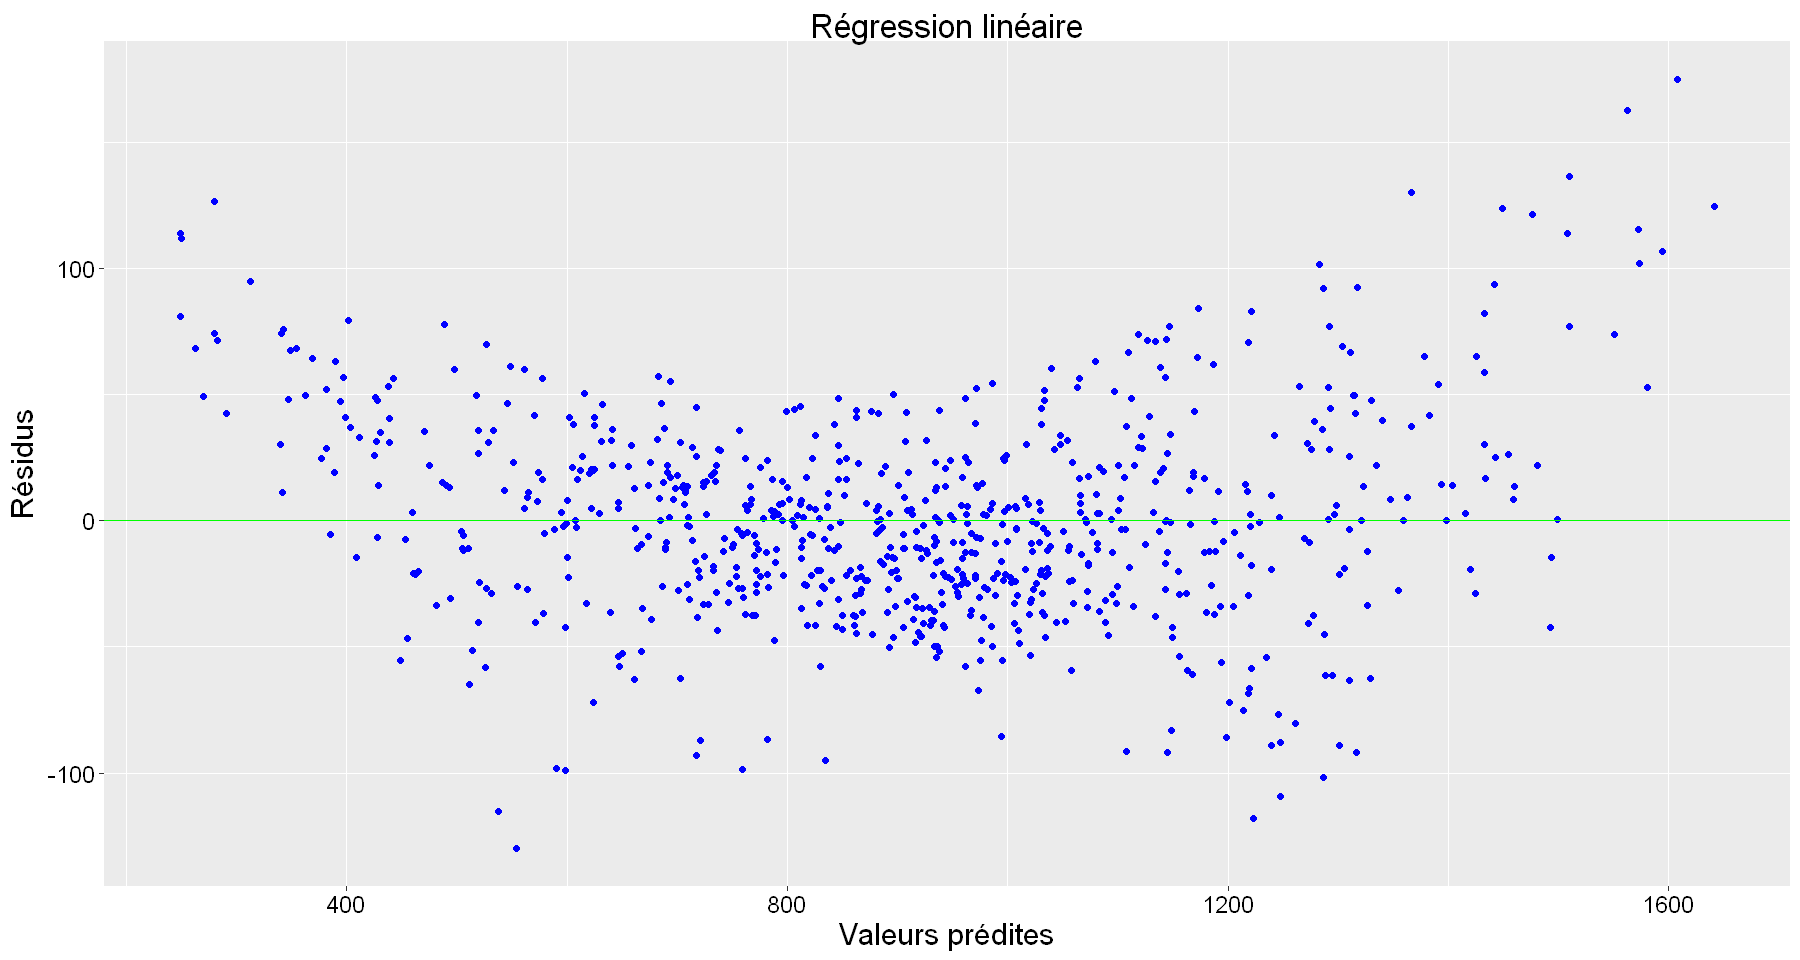

In [35]:
t0 <- Sys.time()
reg.lm <- lm(Calories_Burned ~ ., data = gym_train_scaled)

t1 <- Sys.time()
cat("Time taken for linear regression: ", t1 - t0, " seconds\n")
# Summary of the regression
summary(reg.lm)

# Extract the residuals
sel.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Plot the residuals
gplot.res(fit.lm, sel.lm, "Régression linéaire")

In [36]:
# MSE of the model on the training and test set
mse_train <- mean(sel.lm^2)
mse_test <- mean((predict(reg.lm, gym_test_scaled) - gym_test_scaled$Calories_Burned)^2)

cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
# Calcul du R² sur le test set
sst_test <- sum((gym_test_scaled$Calories_Burned - mean(gym_test_scaled$Calories_Burned))^2)
sse_test <- sum((gym_test_scaled$Calories_Burned - predict(reg.lm, gym_test_scaled))^2)
r2_test <- 1 - sse_test / sst_test
cat("R² on test set: ", round(r2_test, 3), "\n")

MSE on training set:  1624.432 
MSE on test set:  1218.783 
R² on test set:  0.982 



**Performance du modèle**

Le modèle linéaire explique 97,8 % de la variance des calories brûlées, ce qui constitue une performance remarquable. Toutefois, un tel résultat peut également être suspect, suggérant un possible surapprentissage, ou bien la présence d’un prédicteur dominant.

En effet, la variable Session_Duration..hours. (coefficient standardisé ≈ 0.893) semble jouer un rôle prédominant dans le modèle. Cela s’explique logiquement : plus une séance dure longtemps, plus la dépense calorique augmente de manière mécanique.

En ce qui concerne les autres coefficients standardisés, on observe que :

- Une augmentation d’1 écart-type de la durée de la séance entraîne une hausse de 0.893 écart-type des calories brûlées.
- Une fréquence cardiaque moyenne élevée est également un bon prédicteur (+0.329 SD).
- À caractéristiques équivalentes, les hommes brûlent en moyenne 0.33 écart-type de calories de plus que les femmes.

À l’inverse, plusieurs variables n’ont pas montré d’effet significatif (p > 0.05), notamment :

- Les caractéristiques physiques telles que le poids (Weight) ou le pourcentage de masse grasse (Fat_Percentage)
- Certains paramètres cardiaques comme le rythme cardiaque maximal ou au repos
- Le type d'entraînement (HIIT, force, yoga), qui semble avoir peu d’influence une fois les autres facteurs contrôlés.


En ce qui est du graphe des résidus, la forme en banane suggère que le modèle linéaire est mal spécifié et nidique une non linéarité dans la relation entre les variables et la variable cible `Calories_Burned`, malgré la valeur assez élevée du score R² (97,85%)

### LASSO

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,Workout_TypeStrength,Workout_TypeYoga,SFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.3,Workout_Frequency..days.week.4,Workout_Frequency..days.week.5,Experience_Level2,Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,0,0,-1.7625553,-0.8567881,0,1,0,1,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,0,0,-1.5948489,-0.5262097,0,1,0,1,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,1,0,-0.5728511,0.3002366,1,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,0,0,1.3988024,0.1349473,0,0,1,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,0,0,0.6865113,-0.5262097,1,0,0,1,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,0,0,-0.8643778,-1.1873666,1,0,0,1,0


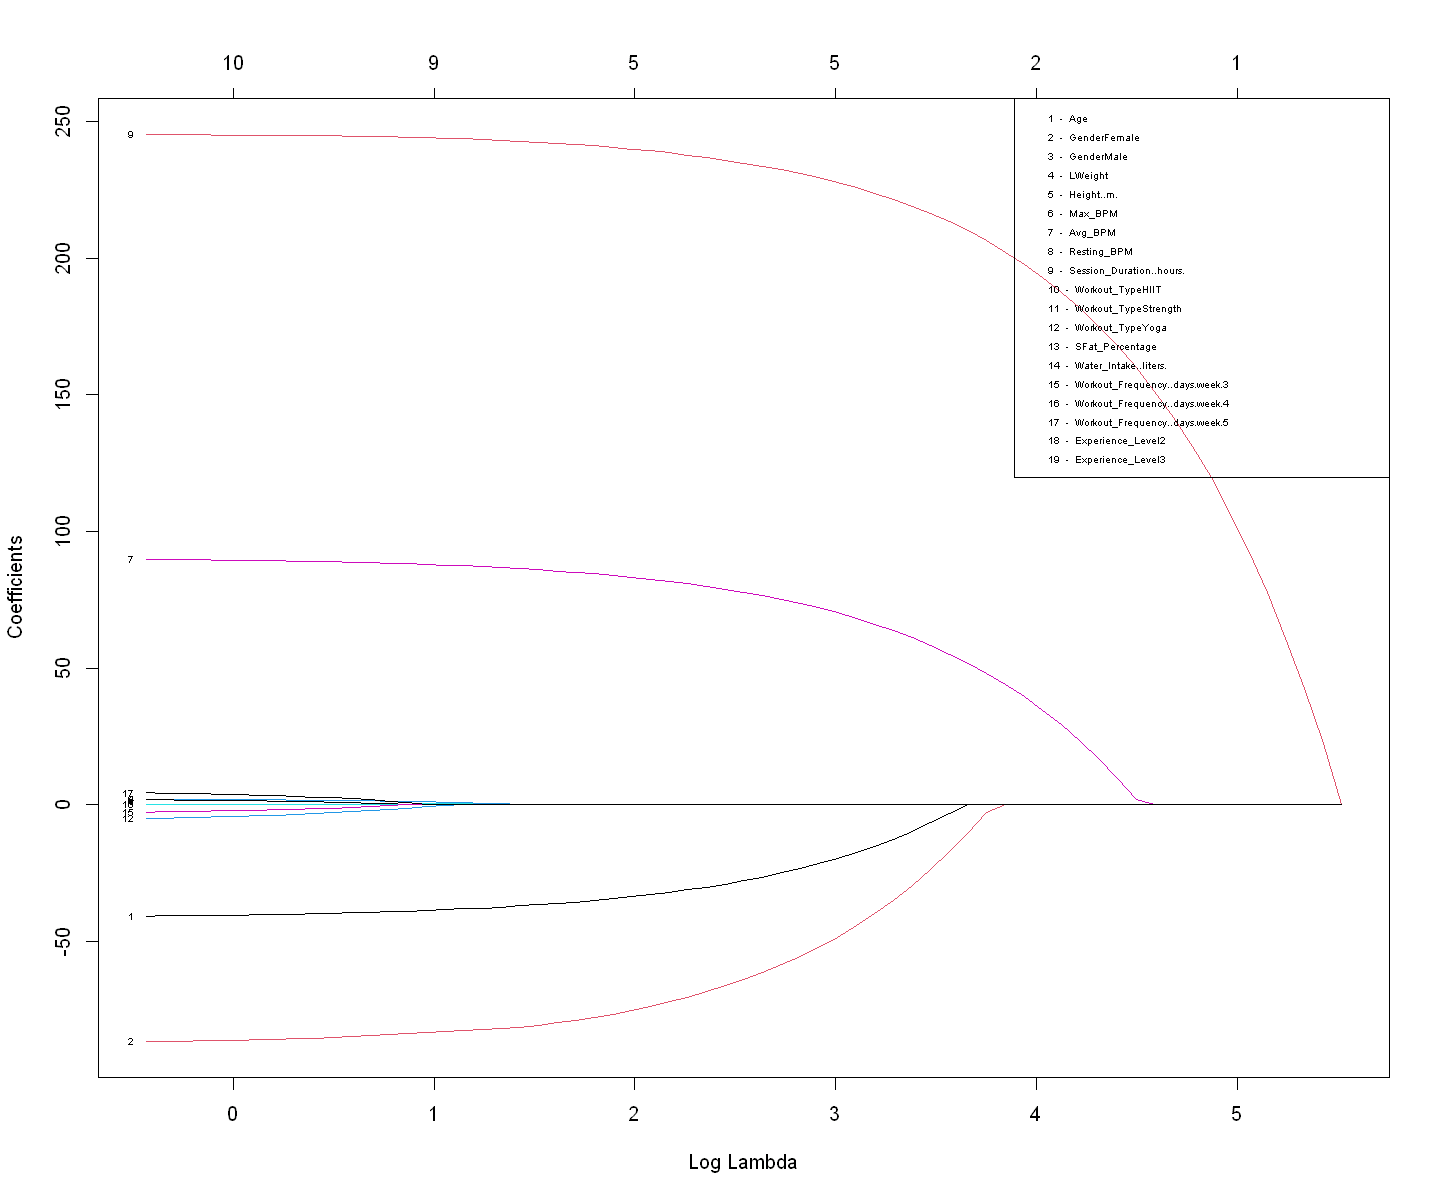

In [37]:
x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
y.vec <- gym_train_scaled$Calories_Burned


head(x.mat)
# Fit the lasso model
reg.lasso <- glmnet(x.mat, y.vec, alpha = 1, nfolds = 10) # alpha = 1 for lasso


# Plot the coefficients
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)), cex = 0.5)



Nous pouvons observer  l'évolution des coefficients des variables en fonction de la pénalisation λ. En effet, plus lambda est petit, moins il n'ya de pénalisation. Ce qui explique les nombreux coefficients non nuls. Parallèlement, pour des λ grands, il y'a une forte pénalisation et on donne beaucoup d'importance à la parcimonie face à la complexité du modèle, ce qui pousse de nombreux coefficients à devenir nuls. Cela permet de sélectionner uniquement les variables les plus pertinentes, réduisant ainsi le surapprentissage et améliorant la capacité de généralisation du modèle. 


Comment choisir la valeur optimale de λ qui équilibre au mieux la simplicité du modèle et sa capacité à généraliser ?

C'est ici qu'intervient la validation croisée.  Alors que le premier graphique nous montrait quelles variables sont importantes, **la validation croisée determinera combien de variables garder pour éviter le surapprentissage.** Cette étape est essentielle pour transformer notre exploration théorique en **un modèle opérationnel et robuste**.

Time taken for cross-validation:  0.194304  seconds



Call:  cv.glmnet(x = x.mat, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.711    64    1684 67.95      12
1se  4.167    45    1750 87.15       7

Best lambda:  0.71141 	 	MSE for best lambda:  1684.357 
Best lambda 1se:  4.16677 	MSE for best lambda 1se:  1684.357 
Number of models trained:  65 


20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                     9.485704e+02
Age                            -3.707701e+01
GenderFemale                   -8.139145e+01
GenderMale                      1.171981e-11
LWeight                         1.760175e-01
Height..m.                      .           
Max_BPM                         .           
Avg_BPM                         8.636631e+01
Resting_BPM                     .           
Session_Duration..hours.        2.428171e+02
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga                .           
SFat_Percentage                 1.566336e-01
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5  .           
Experience_Level2               .           
Experience_Level3               .           

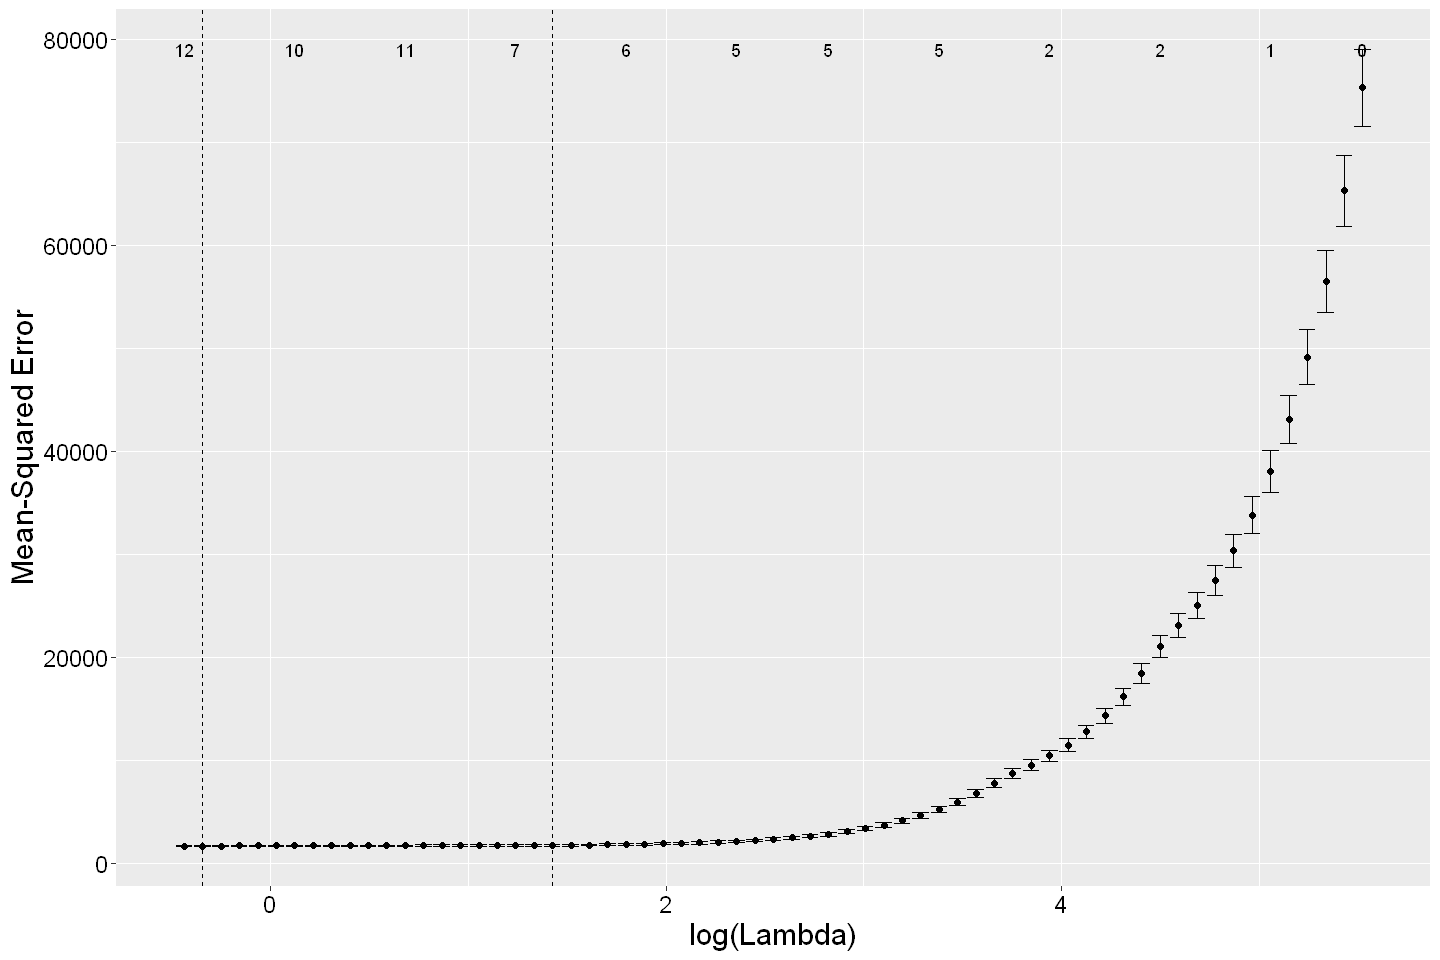

In [157]:
# Cross-validation
t0 <- Sys.time()
reg.lasso.cv <- cv.glmnet(x.mat, y.vec, alpha = 1, nfolds = 10)
t1 <- Sys.time()
cat("Time taken for cross-validation: ", t1 - t0, " seconds\n")
reg.lasso.cv
autoplot(reg.lasso.cv)

cat("Best lambda: ", round(reg.lasso.cv$lambda.min,5), "\t \t")
cat("MSE for best lambda: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Best lambda 1se: ", round(reg.lasso.cv$lambda.1se,5), "\t")
cat("MSE for best lambda 1se: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Number of models trained: ", length(reg.lasso.cv$lambda), "\n")


# Extract the best model
coef(reg.lasso.cv, s = "lambda.1se")
     

Nous avons donc 
lambda.min (0.711) : Lambda optimal minimisant le MSE (1687.45).

lambda.1se (3.796) : Lambda plus grand, conservant un MSE dans l'intervalle *"min + 1 erreur standard"*.
→ Le Modèle le plus simple (7 variables vs 12 pour lambda.min), idéal pour la généralisation.

D'après le graphique, nous visualisons l'évolution de l’erreur quadratique moyenne (MSE) évolue lorsque l’on change la pénalisation λ et nous remarquons :
- Pour des petits lambdas, la pénalisation est faible et donc le MSE est plus élevé car le modèle est plus complexe (possible surapprentissage)
- Au niveau de λ_min (le point le plus bas du nuage), nous avons une erreur minimale et nous gardons en général un nombre modéré de variables (ici autour de 7).
- Au niveau de  λ_1se: On choisit un λ un peu plus grand → on réduit davantage le nombre de variables (ici ~6), tout en restant dans l’intervalle d’erreur de la MSE minimale (modèle plus simple sans perte significative de performance).
- Pour de grands lambdas, la pénalisation est forte donc presque tous les coefficients passent à zéro et MSE remonte (modèle trop parcimonieux).

C'est justement ce que nous observons dans le graphe suivant où les coefficients s'annullent au fur et à mesure que lambda augmente


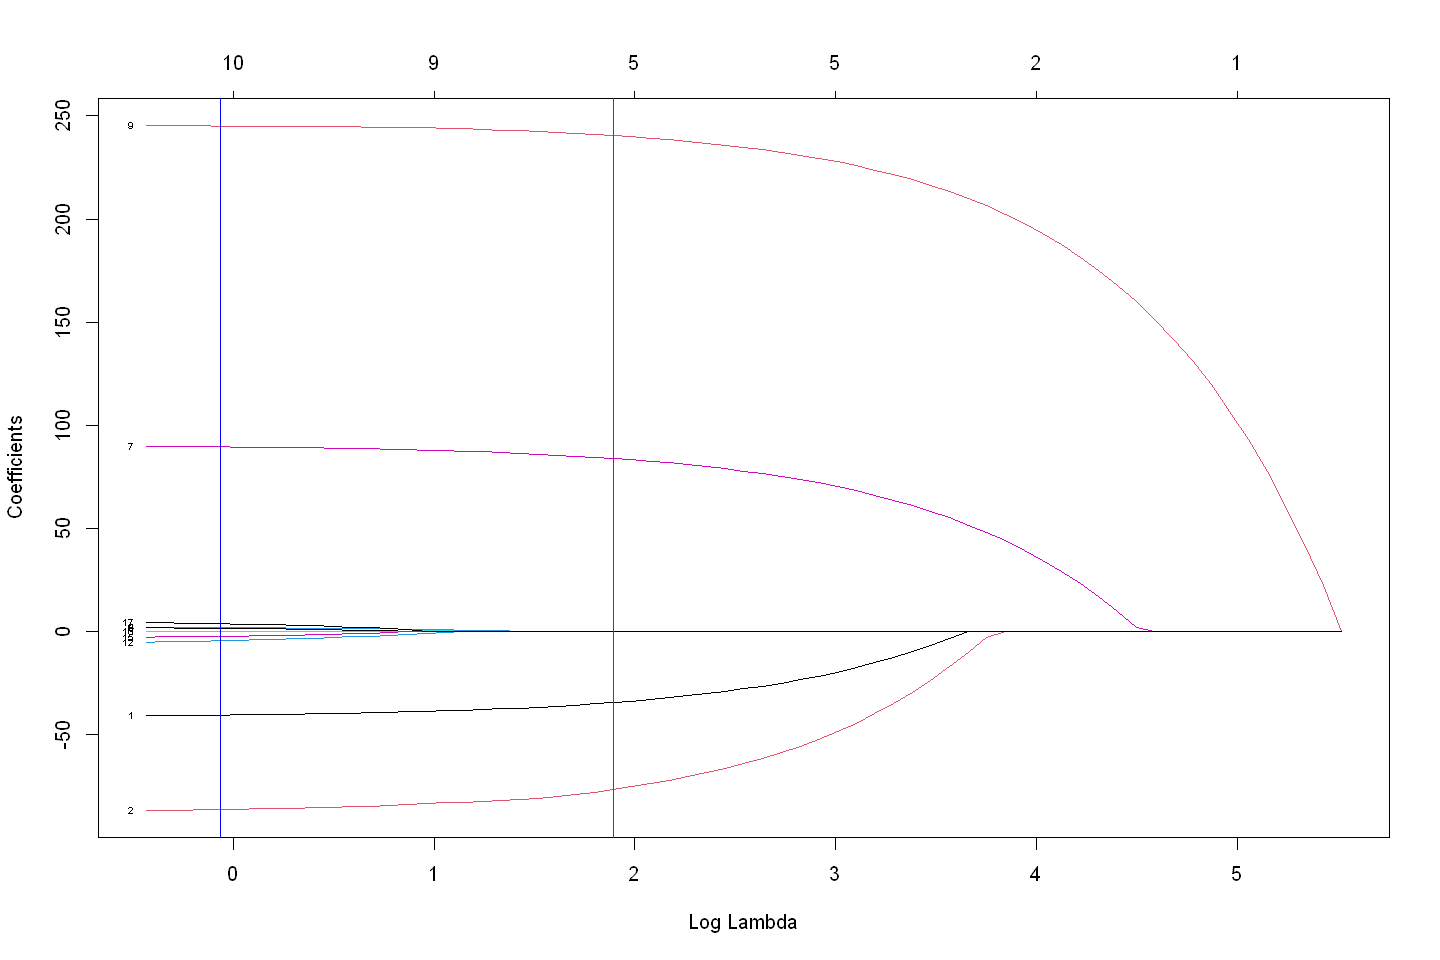

In [156]:
plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")
abline(v=log(reg.lasso.cv$lambda.min),col="blue")

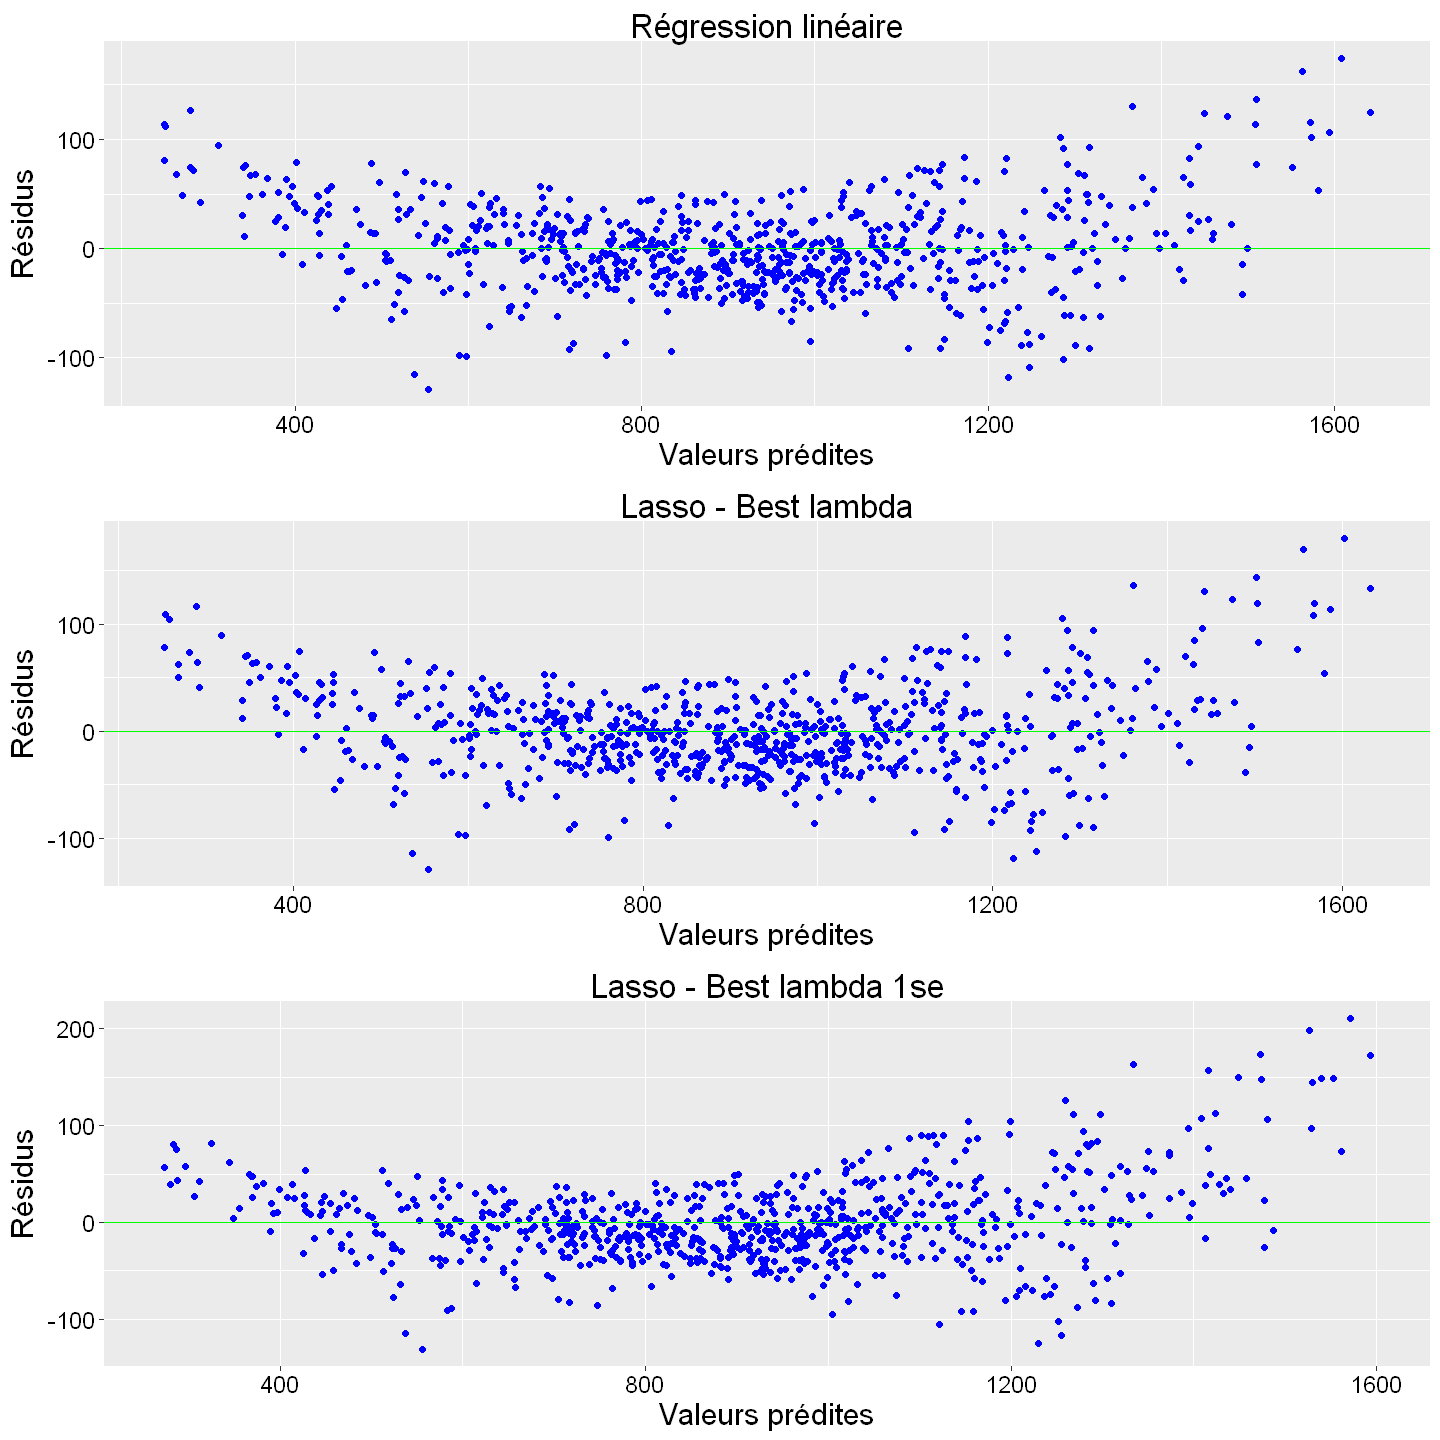

In [40]:
# Extract fitted values and residuals
fit.lasso.min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso.min <- y.vec - fit.lasso.min

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- y.vec - fit.lasso.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso - lambda min")
p2 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - lambda 1se")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)



In [41]:
# 1. Préparation des données test
x.mat.test <- model.matrix(Calories_Burned ~ . -1, data = gym_test_scaled)
y_test <- gym_test_scaled$Calories_Burned

# 2. Prédictions sur le jeu de test
pred_lm_test <- predict(reg.lm, newdata = gym_test_scaled)
pred_lasso_min_test <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat.test)
pred_lasso_1se_test <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat.test)

# 3. Calcul des MSE
mse_lm_test <- mean((y_test - pred_lm_test)^2)
mse_lasso_min_test <- mean((y_test - pred_lasso_min_test)^2)
mse_lasso_1se_test <- mean((y_test - pred_lasso_1se_test)^2)

# 4. Calcul des R²
sst_test <- sum((y_test - mean(y_test))^2)
sse_lm_test <- sum((y_test - pred_lm_test)^2)
sse_lasso_min_test <- sum((y_test - pred_lasso_min_test)^2)
sse_lasso_1se_test <- sum((y_test - pred_lasso_1se_test)^2)

r2_lm_test <- 1 - sse_lm_test / sst_test
r2_lasso_min_test <- 1 - sse_lasso_min_test / sst_test
r2_lasso_1se_test <- 1 - sse_lasso_1se_test / sst_test

# 5. Affichage
cat("Test set:\n")
cat("MSE (LM)           :", round(mse_lm_test, 3), "\n")
cat("MSE (Lasso λ_min)  :", round(mse_lasso_min_test, 3), "\n")
cat("MSE (Lasso λ_1se)  :", round(mse_lasso_1se_test, 3), "\n")
cat("R2  (LM)           :", round(r2_lm_test, 3), "\n")
cat("R2  (Lasso λ_min)  :", round(r2_lasso_min_test, 3), "\n")
cat("R2  (Lasso λ_1se)  :", round(r2_lasso_1se_test, 3), "\n")




Test set:
MSE (LM)           : 1218.783 
MSE (Lasso λ_min)  : 1205.699 
MSE (Lasso λ_1se)  : 1369.813 
R2  (LM)           : 0.982 
R2  (Lasso λ_min)  : 0.982 
R2  (Lasso λ_1se)  : 0.98 


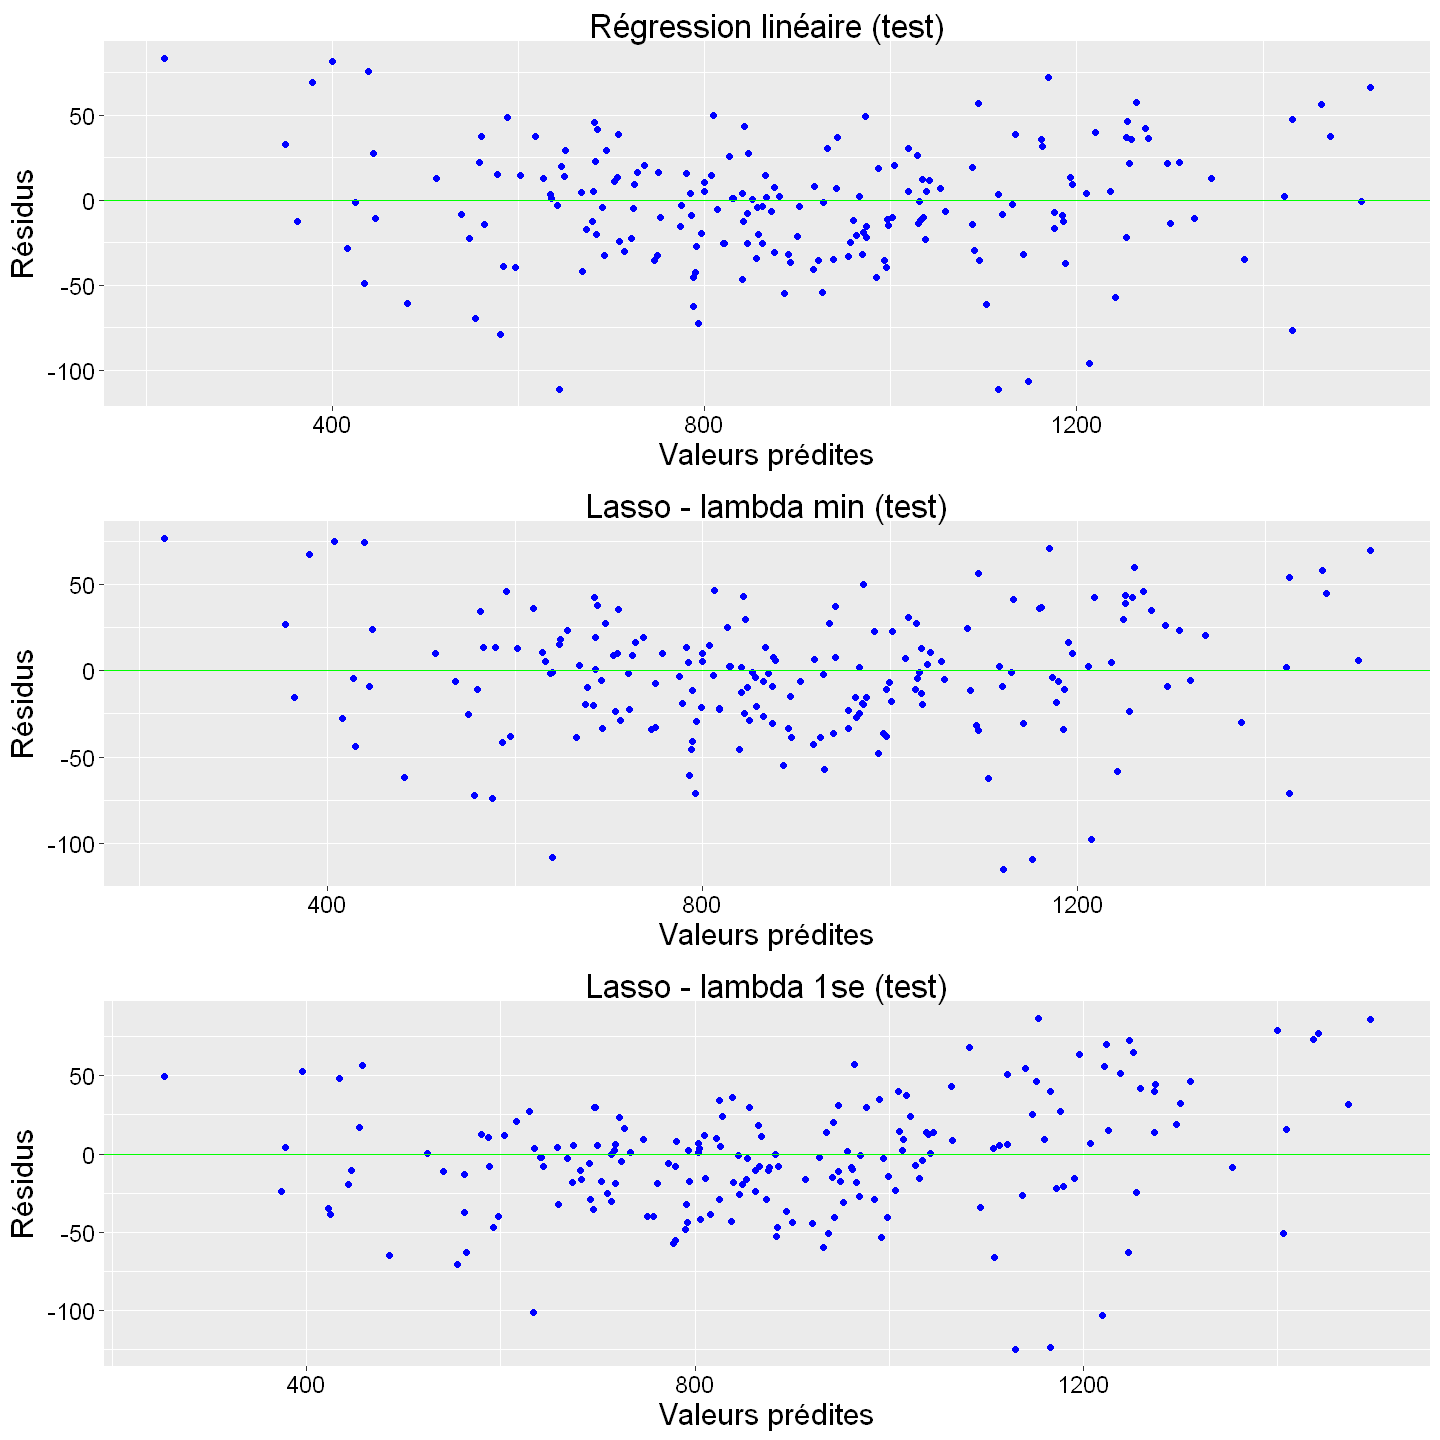

In [50]:
# Prédictions sur le jeu de test
fit.lm.test <- predict(reg.lm, newdata = gym_test_scaled)
res.lm.test <- gym_test_scaled$Calories_Burned - fit.lm.test

fit.lasso.min.test <- as.numeric(predict(reg.lasso.cv, s = "lambda.min", newx = x.mat.test))
res.lasso.min.test <- y_test - fit.lasso.min.test

fit.lasso.1se.test <- as.numeric(predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat.test))
res.lasso.1se.test <- y_test - fit.lasso.1se.test

# Plot des résidus sur le jeu de test
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm.test, res.lm.test, "Régression linéaire (test)")
p1 <- gplot.res(fit.lasso.min.test, res.lasso.min.test, "Lasso - lambda min (test)")
p2 <- gplot.res(fit.lasso.1se.test, res.lasso.1se.test, "Lasso - lambda 1se (test)")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)


Les trois modèles affichent d’excellentes performances (R² ≃ 0,98) sur l'echantillon de test, mais le modèle Lasso λ_1se est le plus parcimonieux (6 variables) et le plus simple à interpréter, malgré une légère perte de performance par rapport au modèle linéaire lorsqu'on regarde le MSE (1247 vs 1218).

**Analyse des résidus**

Régression linéaire : les résidus sont bien centrés autour de zéro, mais leur dispersion apparaît légèrement hétérogène.

Lasso (λ_min et λ_1se) : les nuages de points restent comparables à ceux de la régression linéaire, avec toutefois une variabilité un peu plus marquée pour λ_1se (voir l’extension de l’axe vertical).

Cette similarité visuelle confirme que les trois modèles offrent des performances prédictives très proches.

**Importance des variables**

Session_Duration domine l’explication des calories brûlées (coefficient élevé dans tous les modèles).

Les autres variables n’ont qu’un impact marginal : leur suppression par le Lasso n’altère pas significativement la qualité des prédictions.


**Choix du modèle**

Le choix final dépend de la priorité donnée à la complexité ou à la parcimonie. Ici, comme le R² diminue très peu en passant au Lasso λ_1se, ce modèle plus simple est à privilégier.





Maintenant, nous allons étudier brièvement l'effet d'une pénalisation L² du le modèle via Ridge.

### Ridge

Time taken for ridge regression:  0.20035  seconds


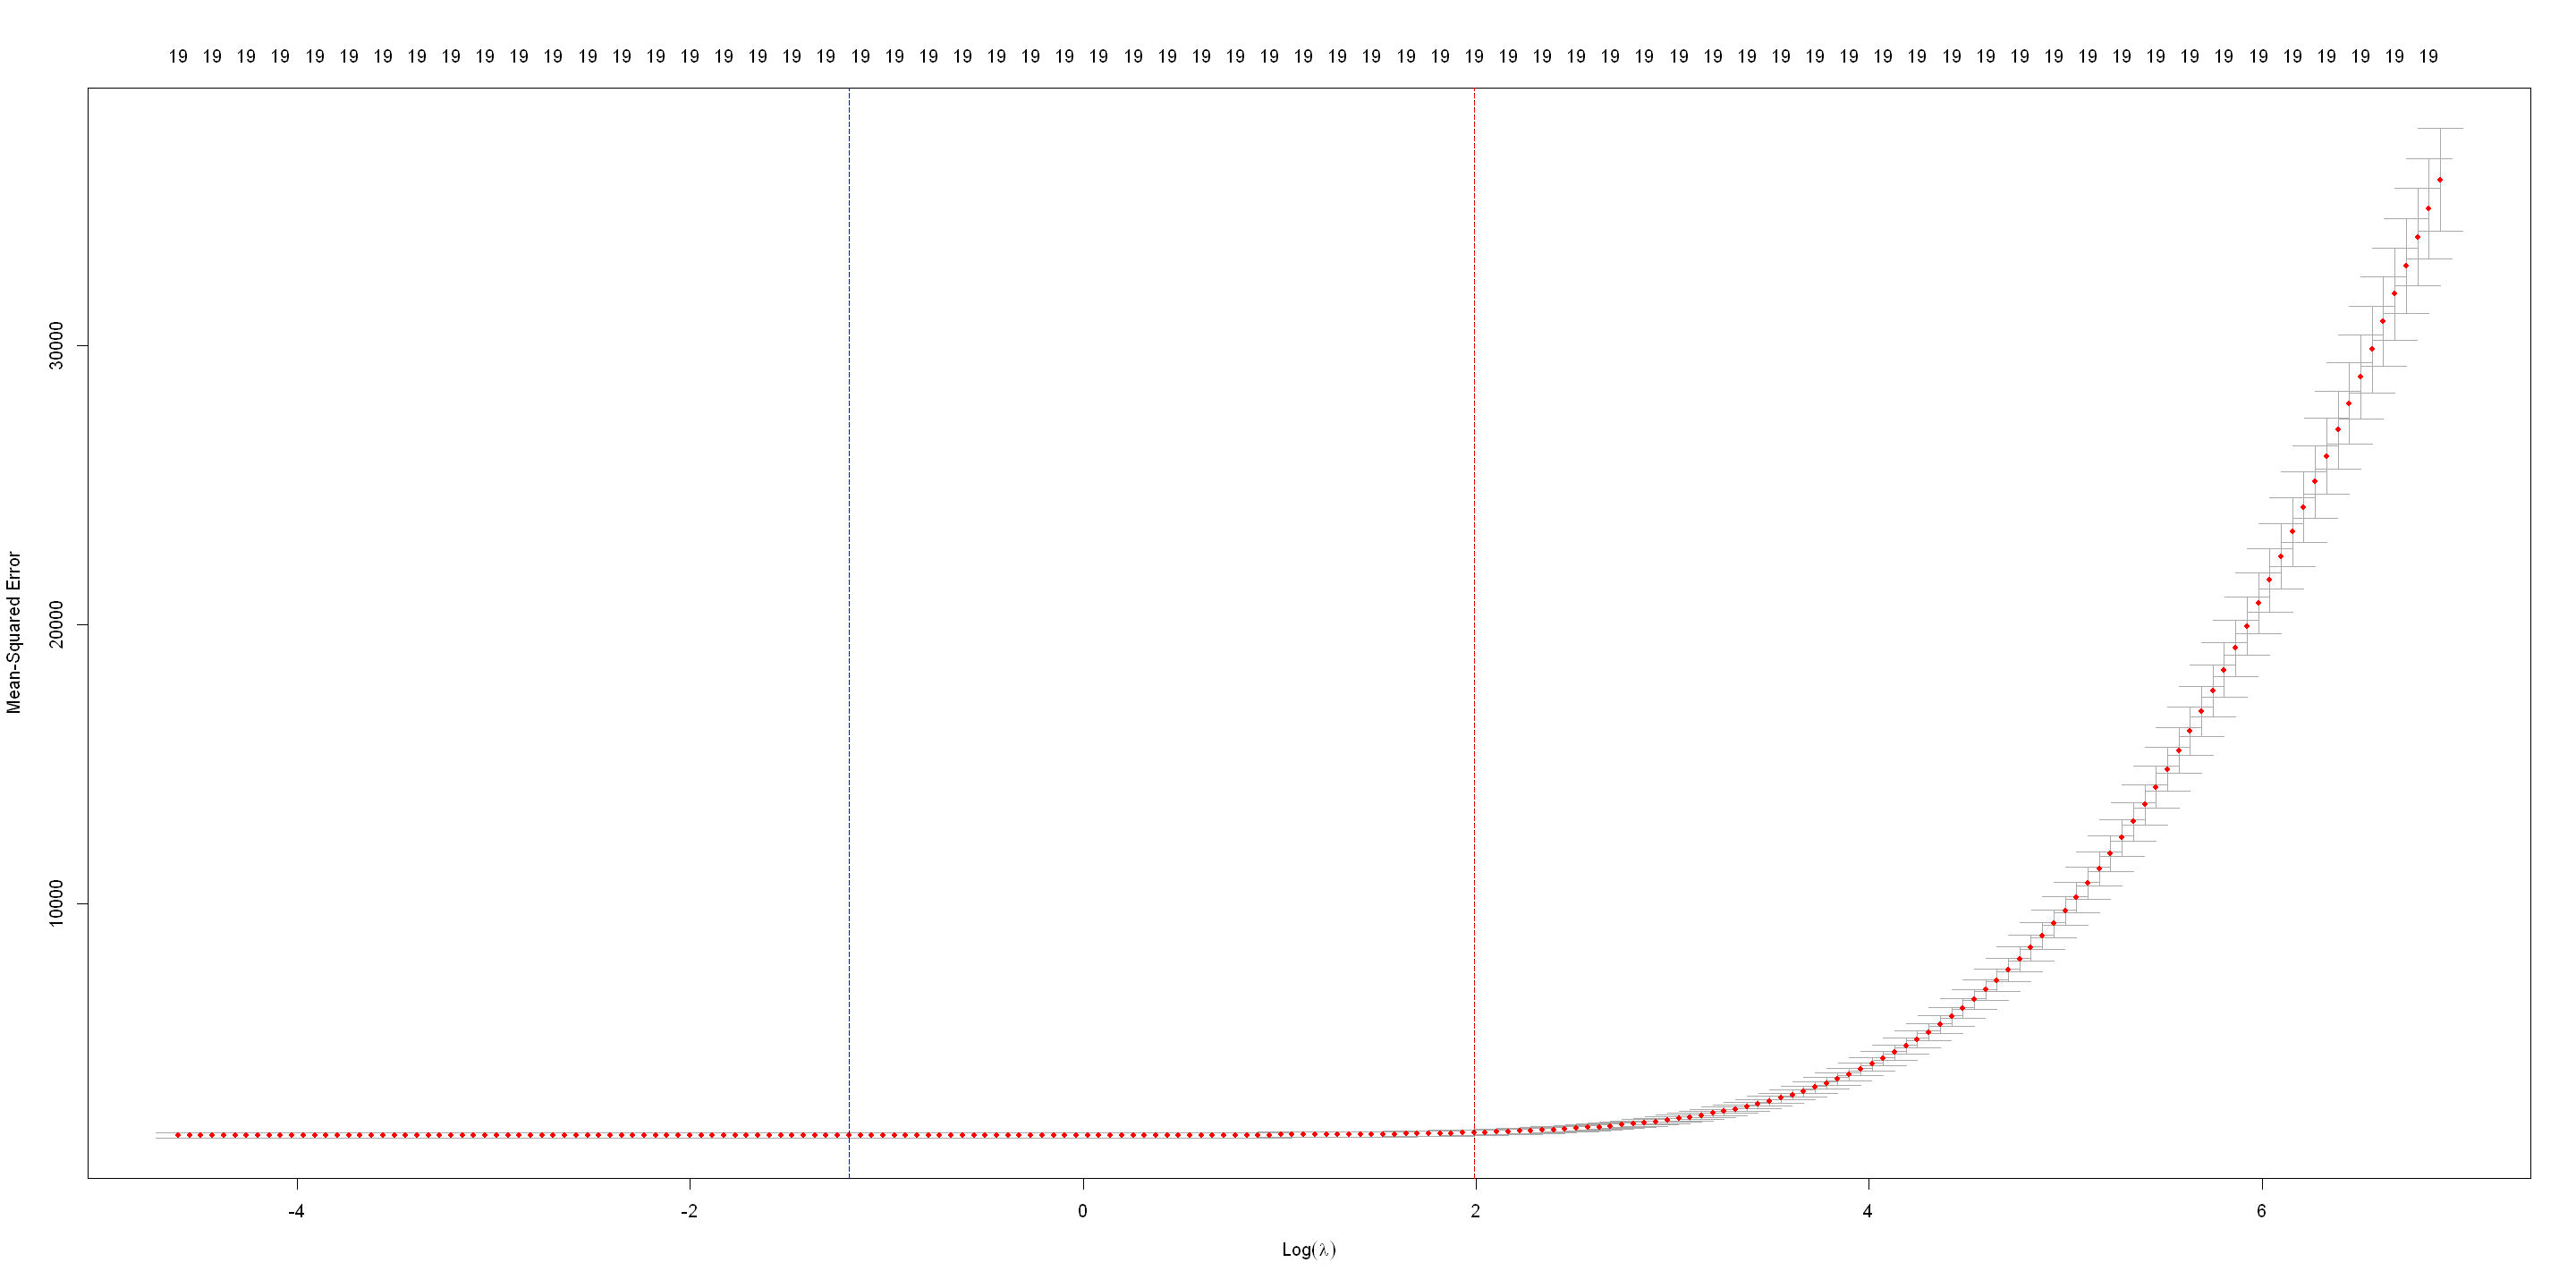

In [64]:
# Génère une séquence de lambda plus petite que celle par défaut 
lambda_seq <- 10^seq(3, -2, length.out = 200)
t0 <- Sys.time()
cv.ridge <- cv.glmnet(
    x.mat, y.vec,
    alpha = 0,
    nfolds = 10,
    lambda = lambda_seq
)
t1 <- Sys.time()
cat("Time taken for ridge regression: ", t1 - t0, " seconds\n")

plot(cv.ridge)
abline(v = log(cv.ridge$lambda.min), col = "blue", lty = 2)
abline(v = log(cv.ridge$lambda.1se), col = "red",  lty = 2)


In [127]:
attributes(cv.ridge)

$names
 [1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "call"       "name"       "glmnet.fit" "lambda.min"
[11] "lambda.1se" "index"     

$class
[1] "cv.glmnet"

In [158]:
cat("taille de la grille de lambda: ", length(cv.ridge$lambda), "\n")

taille de la grille de lambda:  200 


CV error : 
MSE (Ridge λ_min)  : 1719.816 
MSE (Ridge λ_1se)  : 1813.561 


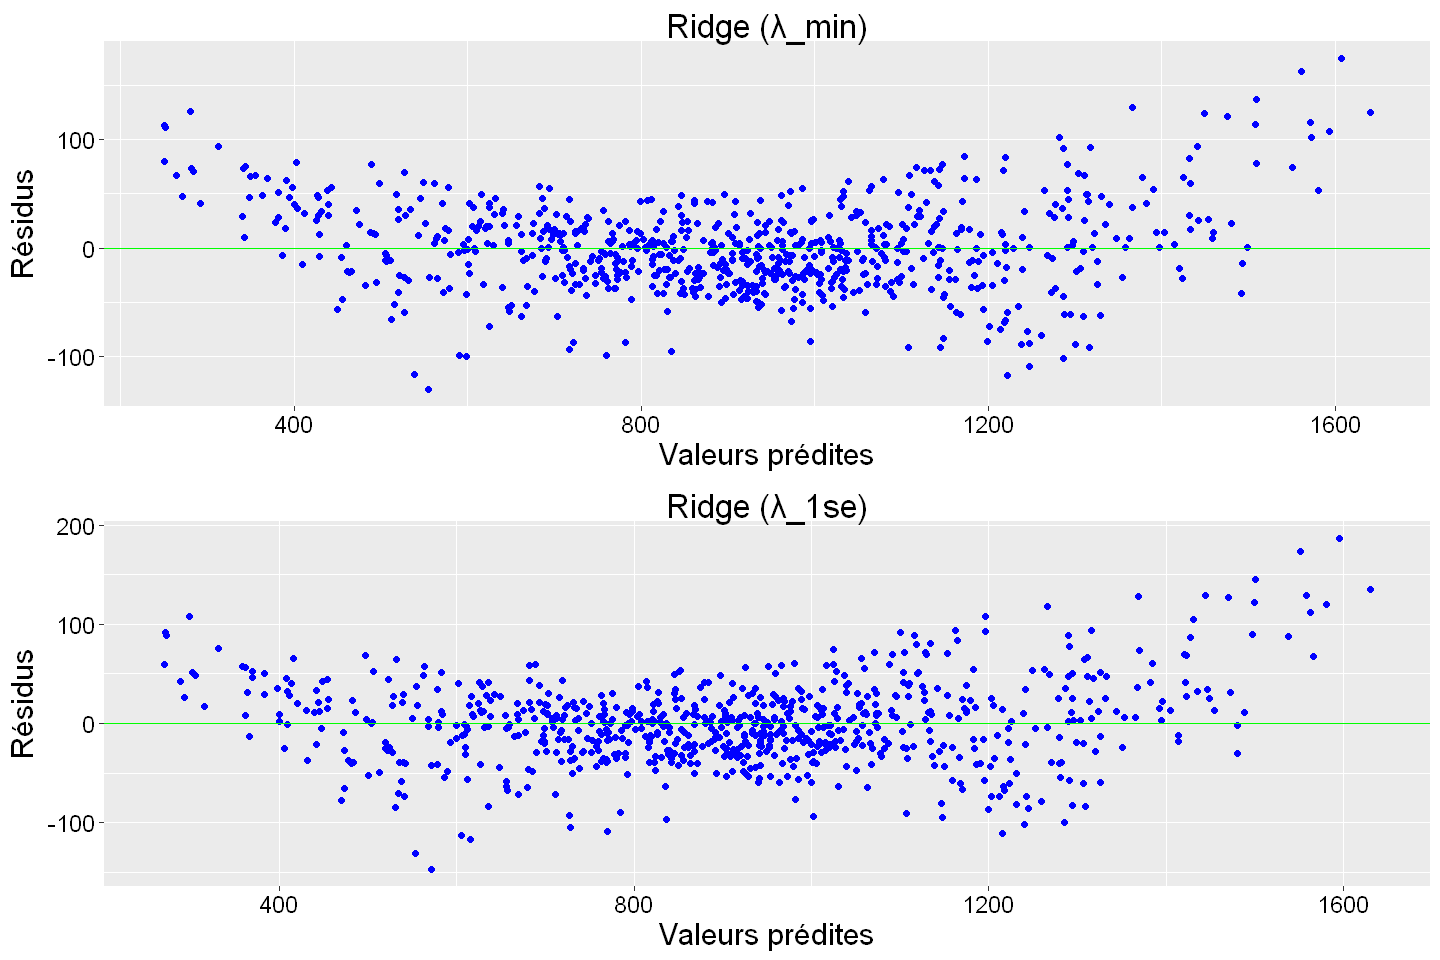

In [140]:
# Affichage des performances
cat("CV error : \n")
cat("MSE (Ridge λ_min)  :", round(cv.ridge$cvm[cv.ridge$index][1], 5), "\n")
cat("MSE (Ridge λ_1se)  :", round(cv.ridge$cvm[cv.ridge$index][2], 5), "\n")


# Tracé des résidus
options(repr.plot.width=12, repr.plot.height=8)
p_ridge_min <- gplot.res(fit_ridge_min, res_ridge_min, "Ridge (λ_min)")
p_ridge_1se <- gplot.res(fit_ridge_1se, res_ridge_1se, "Ridge (λ_1se)")
grid.arrange(p_ridge_min, p_ridge_1se, ncol = 1)

Test set:
MSE Ridge (lambda.min)  : 1219.697 
MSE Ridge (lambda.1se)  : 1327.657 
R² Ridge (λ_min)        : 0.982 
R² Ridge (λ_1se)        : 0.981 


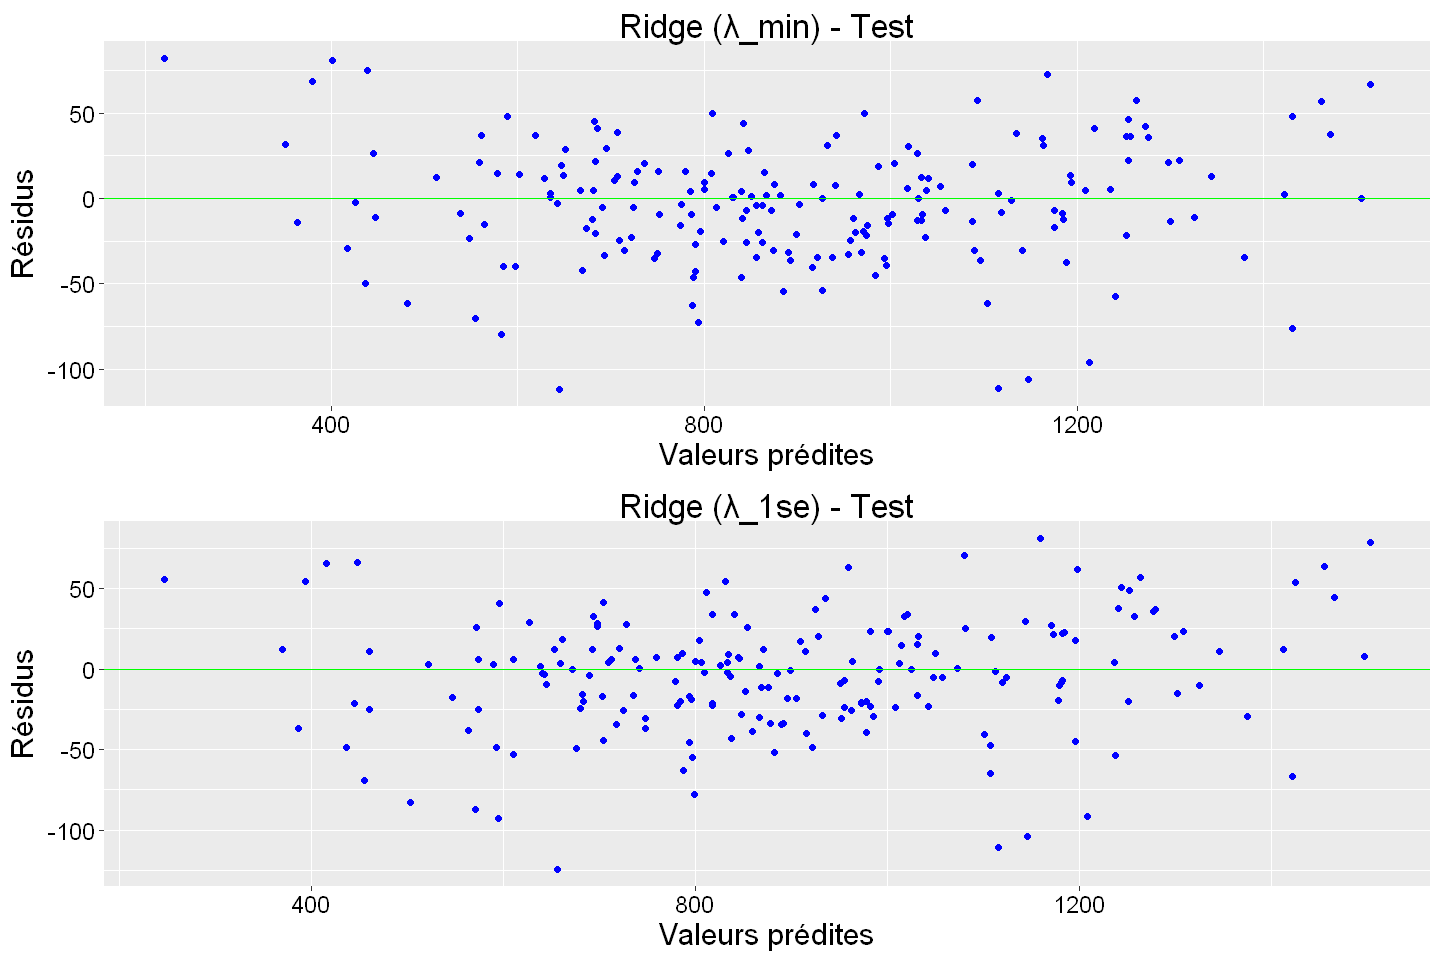

In [66]:
# Prédictions sur le jeu de test pour Ridge
fit_ridge_min_test <- predict(cv.ridge, s = "lambda.min", newx = x.mat.test)
fit_ridge_1se_test <- predict(cv.ridge, s = "lambda.1se", newx = x.mat.test)

# Calcul des résidus
res_ridge_min_test <- y_test - as.numeric(fit_ridge_min_test)
res_ridge_1se_test <- y_test - as.numeric(fit_ridge_1se_test)

# Calcul des MSE
mse_ridge_test_min  <- mean(res_ridge_min_test^2)
mse_ridge_test_1se  <- mean(res_ridge_1se_test^2)

# Calcul des R²
sst_test <- sum((y_test - mean(y_test))^2)
r2_ridge_test_min <- 1 - sum(res_ridge_min_test^2) / sst_test
r2_ridge_test_1se <- 1 - sum(res_ridge_1se_test^2) / sst_test

cat("Test set:\n")
cat("MSE Ridge (lambda.min)  :", round(mse_ridge_test_min,  3), "\n")
cat("MSE Ridge (lambda.1se)  :", round(mse_ridge_test_1se,  3), "\n")
cat("R² Ridge (λ_min)        :", round(r2_ridge_test_min, 3), "\n")
cat("R² Ridge (λ_1se)        :", round(r2_ridge_test_1se, 3), "\n")

# Graphiques des résidus
options(repr.plot.width=12, repr.plot.height=8)
p_ridge_min_test <- gplot.res(fit_ridge_min_test, res_ridge_min_test, "Ridge (λ_min) - Test")
p_ridge_1se_test <- gplot.res(fit_ridge_1se_test, res_ridge_1se_test, "Ridge (λ_1se) - Test")
grid.arrange(p_ridge_min_test, p_ridge_1se_test, ncol = 1)
rm(p_ridge_min_test, p_ridge_1se_test)

La régression Ridge, avec un R² de 0.971 sur l'ensemble de test, montre **une bonne capacité à expliquer la variance**. Cependant, son erreur quadratique moyenne (MSE) de 2003.277 est **nettement plus élevée que celle de la régression linéaire** (1218.8) **et des modèles Lasso** (λ_min: 1205, λ_1se: 1247). Les deux configurations de Ridge (lambda.min et lambda.1se) donnent des performances identiques sur le test, indiquant une moins bonne performance en termes d'erreur de prédiction par rapport aux modèles précédents.

Cela est surement dû à la pénalisation L² de Ridge, qui tend à réduire les coefficients sans les annuler. Cela semble nuire à la performance du modèle et indique que pour la prédiction de `Calories_Burned`, certaines variables sont nuisibles et devraient être supprimées comme le montre le modèle Lasso.

### Modèle quadratique (avec interactions d'ordre 2)
Nous allons maintenant étudier l’effet des interactions entre les variables afin de déterminer si le modèle intégrant ces interactions offre de meilleures performances.


Time taken for GLM with interactions:  0.05058002  seconds



Call:
glm(formula = Calories_Burned ~ (.)^2, family = gaussian, data = gym_train)

Coefficients: (8 not defined because of singularities)
                                                          Estimate Std. Error
(Intercept)                                             -1.159e+03  7.420e+02
Age                                                      4.246e+00  2.823e+00
GenderMale                                              -2.893e+02  1.501e+02
LWeight                                                  1.017e+02  1.286e+02
Height..m.                                               2.189e+02  2.820e+02
Max_BPM                                                  4.768e+00  2.611e+00
Avg_BPM                                                  2.921e+00  2.143e+00
Resting_BPM                                             -1.182e+00  4.447e+00
Session_Duration..hours.                                 2.163e+02  1.598e+02
Workout_TypeHIIT                                         2.271e+01  1.010e+02
Wor

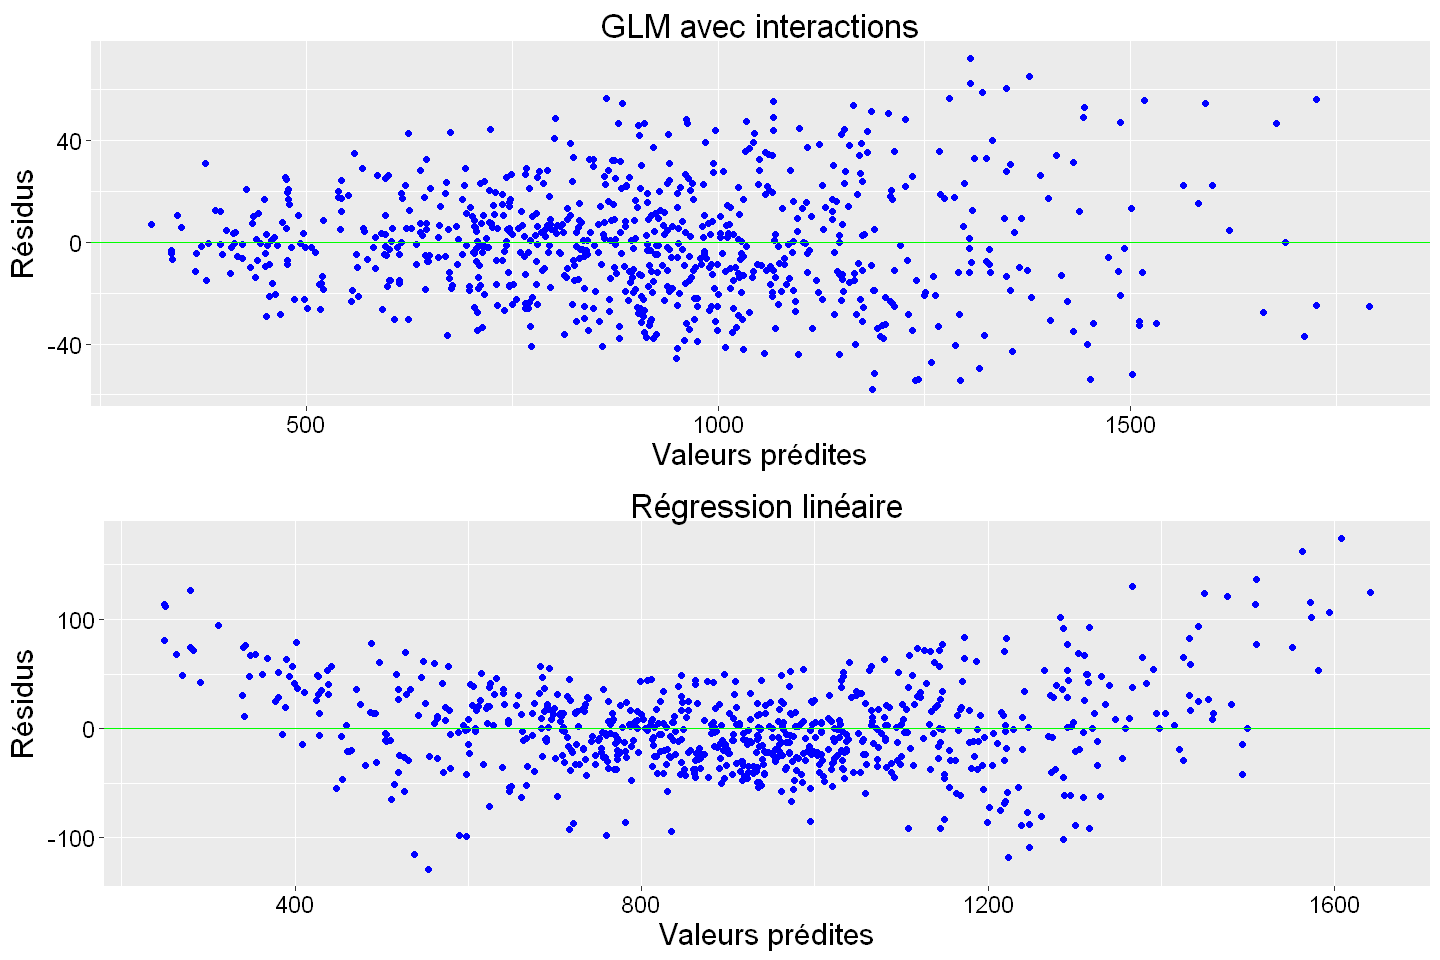

In [52]:
### glm on calories burned with interaction terms ###

# Fit the model with interaction terms
t0 <- Sys.time()
modele_interactions <- glm(Calories_Burned ~ (.)^2, data = gym_train, family = gaussian)
t1 <- Sys.time()
cat("Time taken for GLM with interactions: ", t1 - t0, " seconds\n")
summary(modele_interactions)

# Résidus
residus_glm <- resid(modele_interactions)

# Valeurs ajustées (prédictions du modèle sur l'échantillon d'entraînement)
fitted_glm <- fitted(modele_interactions)


# Graphiques des résidus
options(repr.plot.width=12, repr.plot.height=8)
p_glm <- gplot.res(fitted_glm, residus_glm, "GLM avec interactions")
p_lin <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
grid.arrange(p_glm, p_lin, ncol = 1)

rm(p_glm, p_lin)

In [143]:
# MSE sur le training set
mse_train_glm <- mean(residus_glm^2)

# MSE sur le test set
pred_test_glm <- predict(modele_interactions, newdata = gym_test)
mse_test_glm <- mean((pred_test_glm - gym_test$Calories_Burned)^2)


# R² sur le test set
sst_test <- sum((gym_test$Calories_Burned - mean(gym_test$Calories_Burned))^2)
sse_test <- sum((gym_test$Calories_Burned - pred_test_glm)^2)
r2_test_glm <- 1 - sse_test / sst_test

# Affichage
cat("CV error (MSE) :", round(mse_train_glm, 3), "\n")
cat("MSE sur le test set :", round(mse_test_glm, 3), "\n")
cat("R² sur le test set :", round(r2_test_glm, 3), "\n")

CV error (MSE) : 505.63 
MSE sur le test set : 715.494 
R² sur le test set : 0.99 


L'introduction d'interactions d'ordre 2 dans le modèle GLM **améliore significativement la prédiction de `Calories_Burned`**. En effet, ce modèle **explique davantage la variance** que les modèles linéaires et Lasso simples, avec un R² atteignant 0.99 sur l'ensemble de test. De plus, l'erreur quadratique moyenne (MSE) est drastiquement plus faible (505.63 en entraînement, 715.49 en test), ce qui indique que **la prédiction de `Calories_Burned` est plus robuste lorsque des interactions d'ordre 2 sont prises en compte.**

L'analyse du graphique des résidus vient corroborer ces observations : la forme en "banane", caractéristique d'une mauvaise spécification du modèle et observée avec la régression linéaire simple, a disparu. Ceci confirme bien que des interactions d'ordre 2 ou supérieures étaient nécessaires pour capturer la complexité des relations dans les données.

Bien que ce modèle GLM avec interactions soit plus performant, il inclut un nombre conséquent de termes (171 interactions potentielles), impliquant un AIC de 7376, pénalisant la compléxité du modèle. Afin **d'améliorer l'interprétabilité du modèle** et **d'identifier les interactions les plus pertinentes**, une régularisation LASSO sera appliquée dans la section suivante.

### Modèle Lasso quadratique

Time taken for LASSO with interactions:  0.387737  seconds


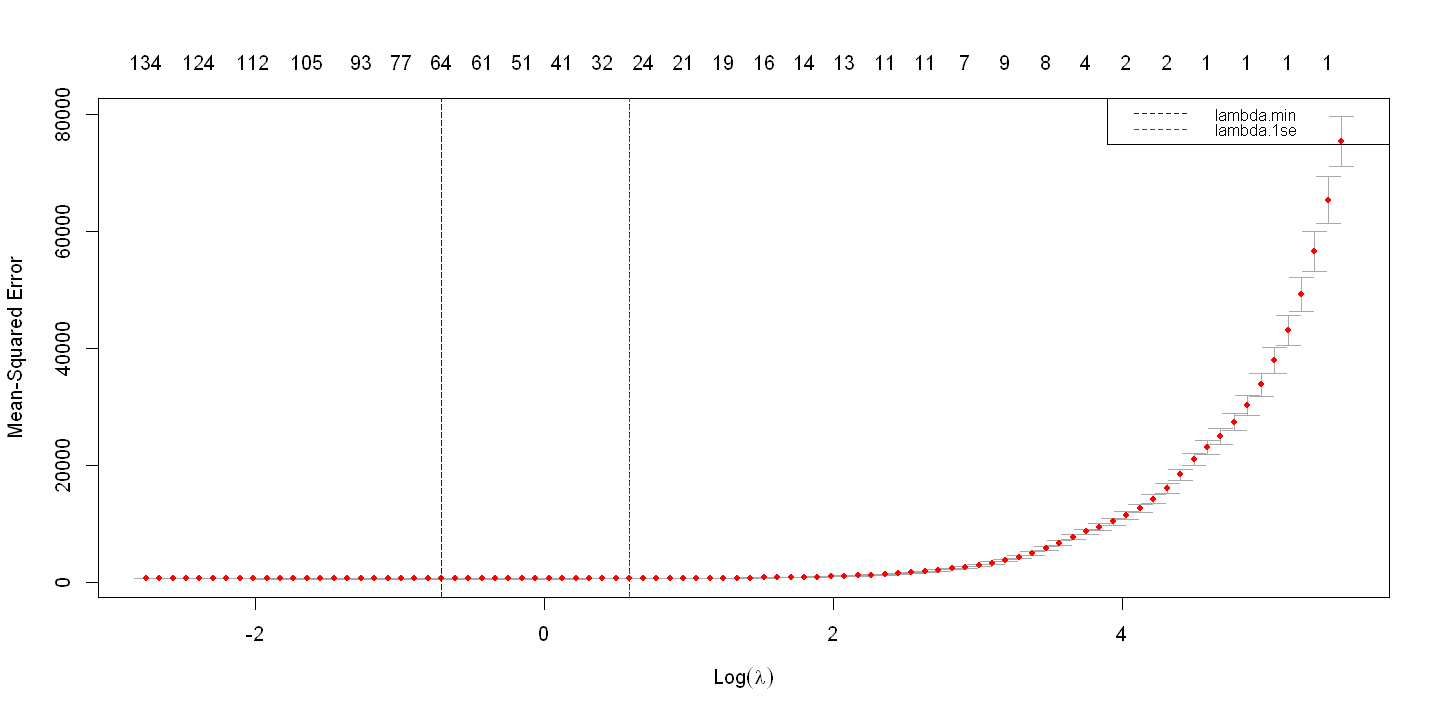

Best lambda (lambda.min):  0.49035 
MSE for lambda.min:  672.1266 
Best lambda (lambda.1se):  1.8037 
MSE for lambda.1se:  700.2416 
AIC for lambda.min:  5080.32 
AIC for lambda.1se:  5097.07 
taille de la grille de lambda:  90 
[1] "Coefficients for lambda.1se:"
                                            (Intercept) 
                                           9.479745e+02 
                                                    Age 
                                          -3.552600e+01 
                                           GenderFemale 
                                          -8.264318e+01 
                                             GenderMale 
                                           3.184581e-11 
                                                LWeight 
                                           8.639923e-02 
                                                Avg_BPM 
                                           8.166947e+01 
                               Session_Duration..hou

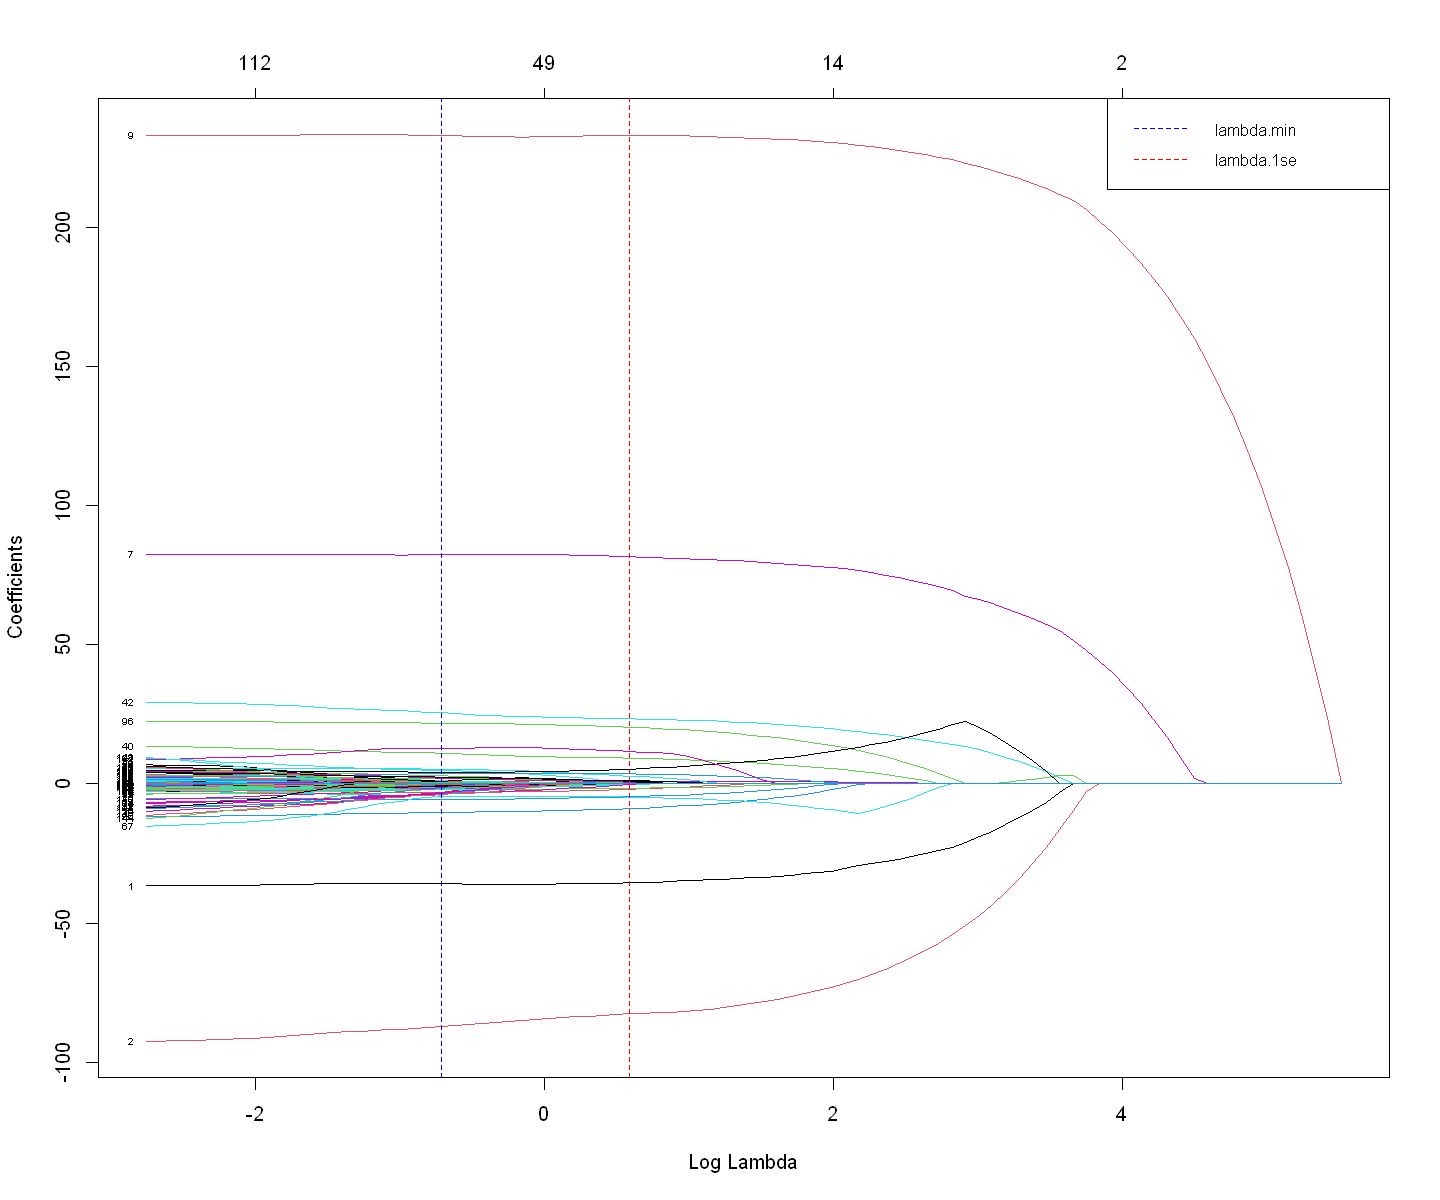

In [163]:
library(glmnet)
library(ggplot2)

# Construction de la matrice de design quadratique (toutes les interactions d'ordre 2)
x.mat.quad <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_train_scaled)

# Fit glmnet with alpha = 1 for LASSO
t0 <- Sys.time()
reg.lasso.quad.cv <- cv.glmnet(x.mat.quad, y.vec, alpha = 1, nfolds = 10)
t1 <- Sys.time()
cat("Time taken for LASSO with interactions: ", t1 - t0, " seconds\n")


# Plot 1 : CV error vs lambda
options(repr.plot.width=12, repr.plot.height=6)
plot(reg.lasso.quad.cv)
abline(v = log(reg.lasso.quad.cv$lambda.min), col = "blue", lty = 2)
abline(v = log(reg.lasso.quad.cv$lambda.1se), col = "red", lty = 2)
legend("topright", legend = c("lambda.min", "lambda.1se"), col = c("blue", "red"), lty = 2, cex = 0.8)

# Plot 2 : Coefficients vs lambda
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso.quad.cv$glmnet.fit, xvar = "lambda", label = TRUE)
abline(v = log(reg.lasso.quad.cv$lambda.min), col = "blue", lty=2)
abline(v = log(reg.lasso.quad.cv$lambda.1se), col = "red", lty=2)
legend("topright", legend = c("lambda.min", "lambda.1se"), col = c("blue", "red"), lty = 2, cex = 0.8)

cat("Best lambda (lambda.min): ", round(reg.lasso.quad.cv$lambda.min,5), "\n")
cat("MSE for lambda.min: ", round(min(reg.lasso.quad.cv$cvm),5), "\n")
cat("Best lambda (lambda.1se): ", round(reg.lasso.quad.cv$lambda.1se,5), "\n")
cat("MSE for lambda.1se: ", round(reg.lasso.quad.cv$cvm[reg.lasso.quad.cv$lambda == reg.lasso.quad.cv$lambda.1se],5), "\n")
# Calcul des AIC pour lambda.min et lambda.1se
# Prédictions sur l'échantillon d'entraînement
fit_min_quad <- as.numeric(predict(reg.lasso.quad.cv, s = "lambda.min", newx = x.mat.quad))
fit_1se_quad <- as.numeric(predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad))

# Calcul du log-vraisemblance (modèle gaussien)
n <- length(y.vec)
rss_min <- sum((y.vec - fit_min_quad)^2)
rss_1se <- sum((y.vec - fit_1se_quad)^2)
sigma2_min <- rss_min / n
sigma2_1se <- rss_1se / n

# Nombre de paramètres non nuls (hors intercept)
k_min <- sum(coef_min_quad != 0) - 1
k_1se <- sum(coef_1se_quad != 0) - 1

# Calcul AIC
aic_min <- n * log(sigma2_min) + 2 * k_min
aic_1se <- n * log(sigma2_1se) + 2 * k_1se

cat("AIC for lambda.min: ", round(aic_min, 2), "\n")
cat("AIC for lambda.1se: ", round(aic_1se, 2), "\n")

cat("taille de la grille de lambda: ", length(reg.lasso.quad.cv$lambda), "\n")

# Coefficients for lambda.min
coef_min_quad <- coef(reg.lasso.quad.cv, s = "lambda.min")
#print("Coefficients for lambda.min:")
#print(coef_min_quad[which(coef_min_quad != 0),]) # Display non-zero coefficients

# Coefficients for lambda.1se
coef_1se_quad <- coef(reg.lasso.quad.cv, s = "lambda.1se")
print("Coefficients for lambda.1se:")
print(coef_1se_quad[which(coef_1se_quad != 0),]) # Display non-zero coefficients

cat("Number of non-zero coefficients for lambda.min: ", sum(coef_min_quad != 0), "\n")
cat("Number of non-zero coefficients for lambda.1se: ", sum(coef_1se_quad != 0), "\n")

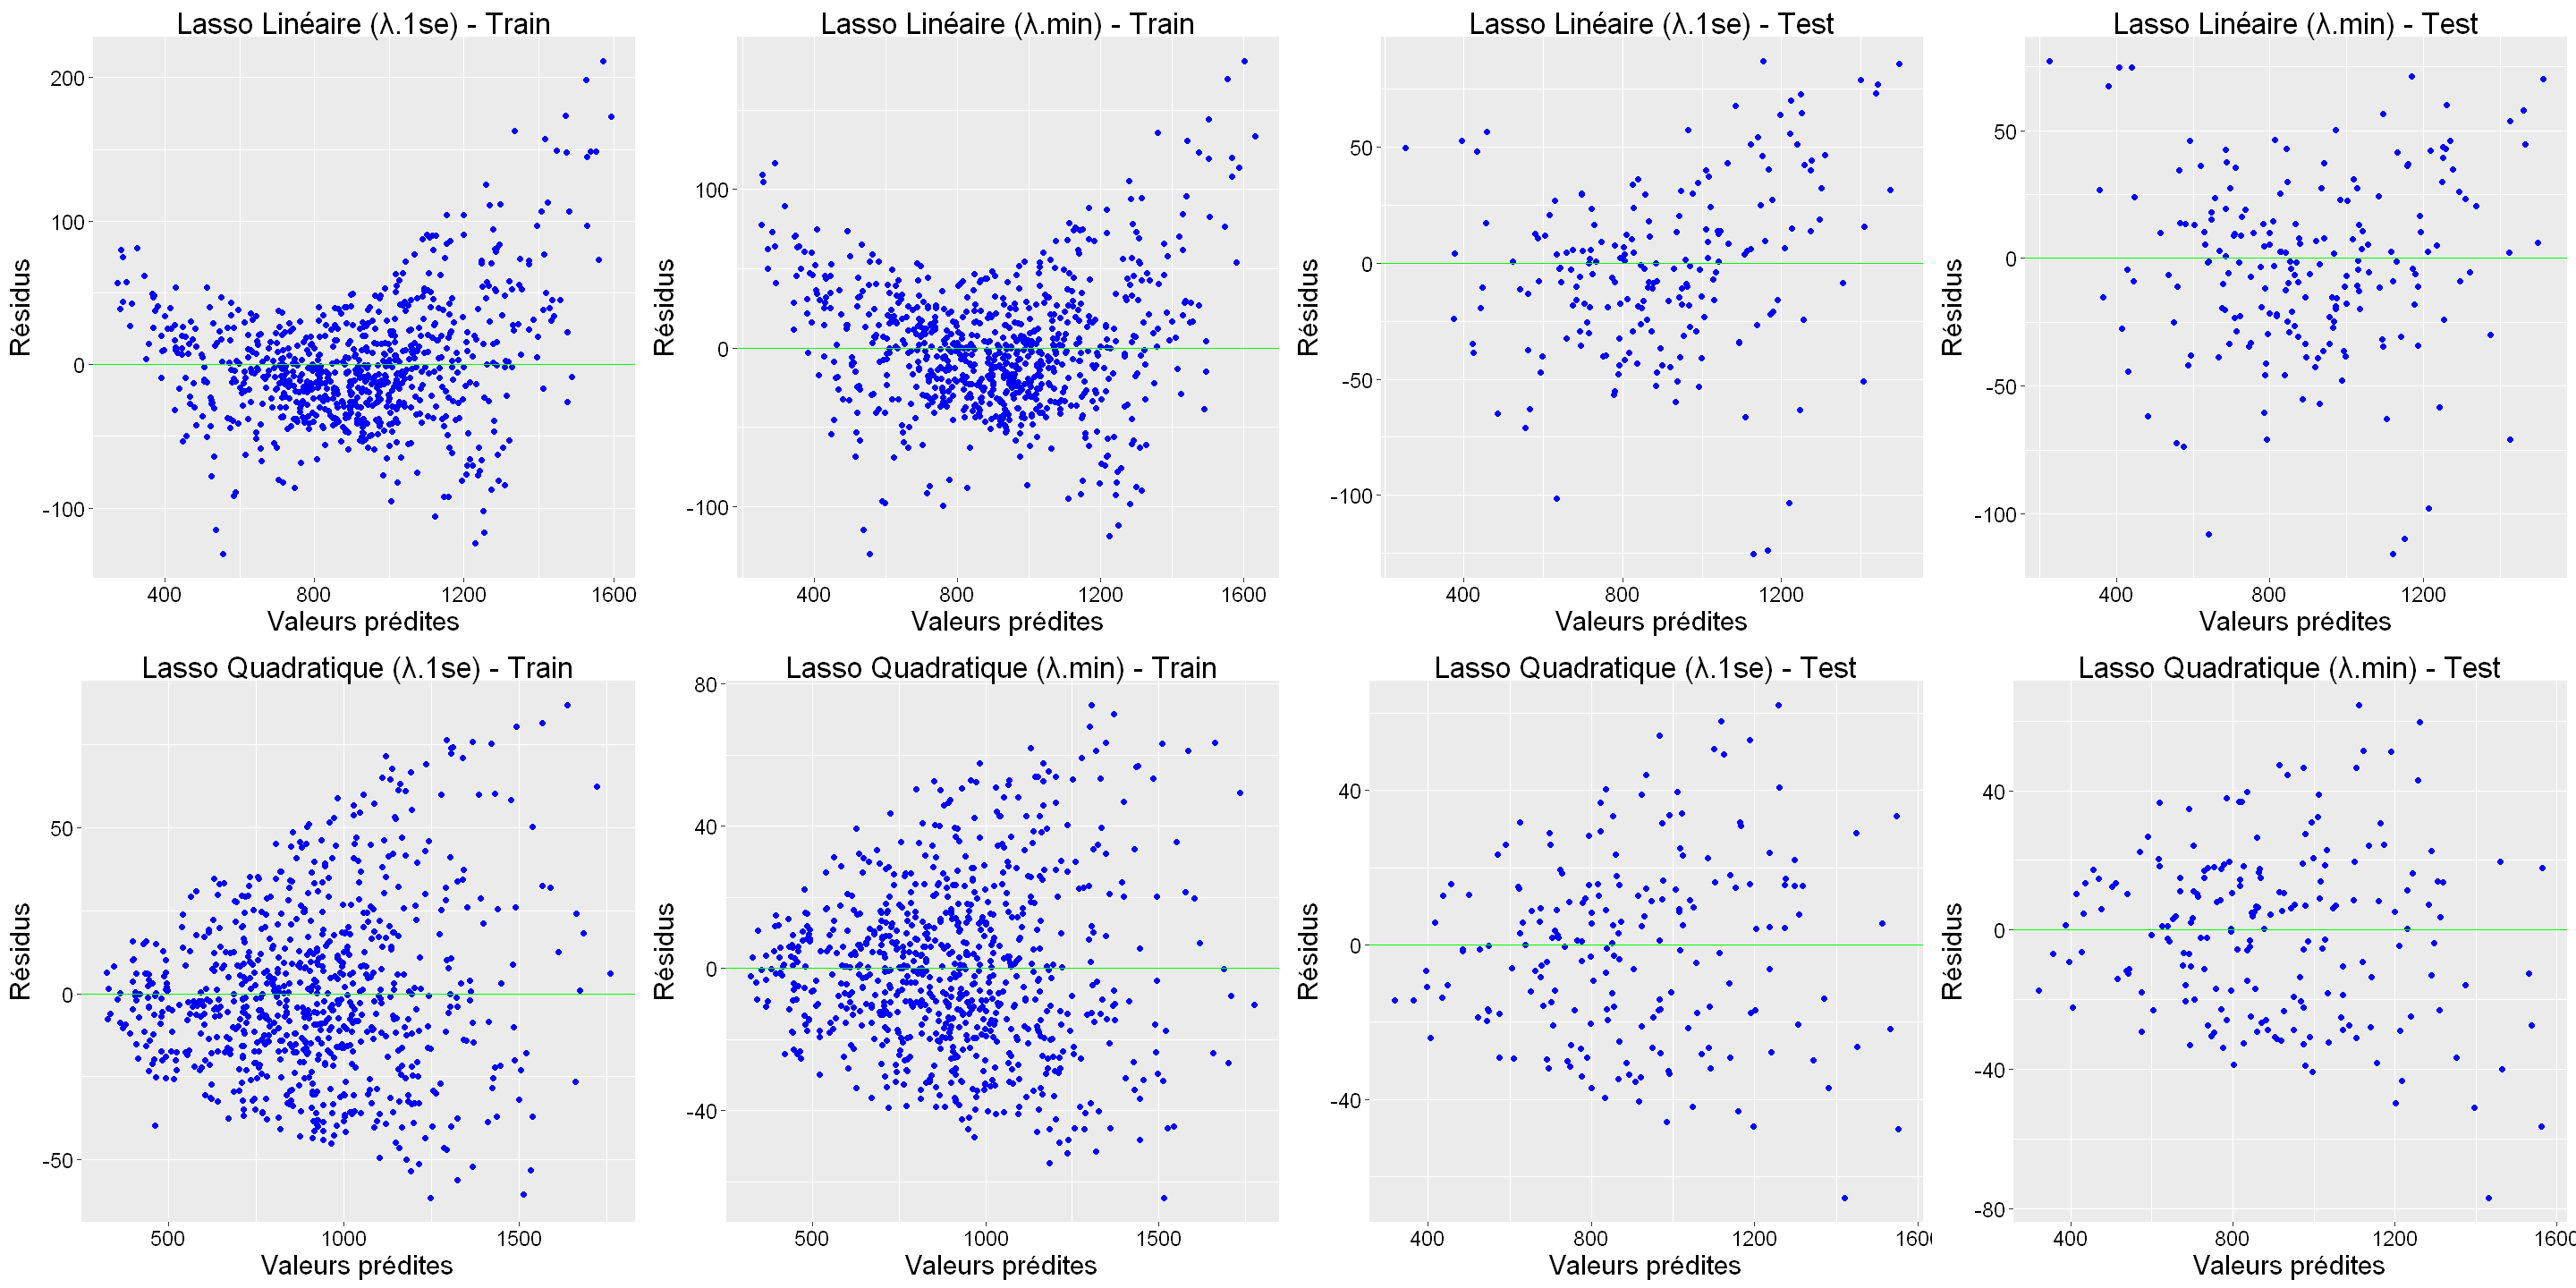

In [63]:
# Create the design matrix for interaction terms for the test set
x.mat.test.quad <- model.matrix(Calories_Burned ~ .^2 - 1, data = gym_test_scaled)

# Fitted values and residuals for LASSO quadratic model with lambda.1se on TRAIN set
fit.lasso.quad.1se.train <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad)
res.lasso.quad.1se.train <- y.vec - as.numeric(fit.lasso.quad.1se.train)

# Fitted values and residuals for LASSO quadratic model with lambda.min on TRAIN set
fit.lasso.quad.min.train <- predict(reg.lasso.quad.cv, s = "lambda.min", newx = x.mat.quad)
res.lasso.quad.min.train <- y.vec - as.numeric(fit.lasso.quad.min.train)

# Fitted values and residuals for LASSO quadratic model with lambda.1se on TEST set
fit.lasso.quad.1se.test <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.test.quad)
res.lasso.quad.1se.test <- y_test - as.numeric(fit.lasso.quad.1se.test)

# Fitted values and residuals for LASSO quadratic model with lambda.min on TEST set
fit.lasso.quad.min.test <- predict(reg.lasso.quad.cv, s = "lambda.min", newx = x.mat.test.quad)
res.lasso.quad.min.test <- y_test - as.numeric(fit.lasso.quad.min.test)

# Create the individual plots for TRAIN set
# Linear model residuals (fit.lasso.1se, res.lasso.1se, fit.lasso.min, res.lasso.min are from cell 57)
p_lasso_lin_1se_train <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso Linéaire (λ.1se) - Train")
p_lasso_lin_min_train <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso Linéaire (λ.min) - Train")
# Quadratic model residuals
p_lasso_quad_1se_train <- gplot.res(fit.lasso.quad.1se.train, res.lasso.quad.1se.train, "Lasso Quadratique (λ.1se) - Train")
p_lasso_quad_min_train <- gplot.res(fit.lasso.quad.min.train, res.lasso.quad.min.train, "Lasso Quadratique (λ.min) - Train")

# Create the individual plots for TEST set
# Linear model residuals (fit.lasso.1se.test, res.lasso.1se.test, etc. are from cell 59)
p_lasso_lin_1se_test <- gplot.res(fit.lasso.1se.test, res.lasso.1se.test, "Lasso Linéaire (λ.1se) - Test")
p_lasso_lin_min_test <- gplot.res(fit.lasso.min.test, res.lasso.min.test, "Lasso Linéaire (λ.min) - Test")
# Quadratic model residuals
p_lasso_quad_1se_test <- gplot.res(fit.lasso.quad.1se.test, res.lasso.quad.1se.test, "Lasso Quadratique (λ.1se) - Test")
p_lasso_quad_min_test <- gplot.res(fit.lasso.quad.min.test, res.lasso.quad.min.test, "Lasso Quadratique (λ.min) - Test")


# Arrange plots in a 2x4 grid
# Row 1: Linear models (Train λ.1se, Train λ.min, Test λ.1se, Test λ.min)
# Row 2: Quadratic models (Train λ.1se, Train λ.min, Test λ.1se, Test λ.min)
options(repr.plot.width=24, repr.plot.height=12) # Adjusted width for 4 plots
grid.arrange(
    p_lasso_lin_1se_train, p_lasso_lin_min_train, p_lasso_lin_1se_test, p_lasso_lin_min_test,
    p_lasso_quad_1se_train, p_lasso_quad_min_train, p_lasso_quad_1se_test, p_lasso_quad_min_test,
    ncol = 4
)

# Clean up plot objects and temporary variables
rm(
    p_lasso_lin_1se_train, p_lasso_lin_min_train, p_lasso_quad_1se_train, p_lasso_quad_min_train,
    p_lasso_lin_1se_test, p_lasso_lin_min_test, p_lasso_quad_1se_test, p_lasso_quad_min_test,
    fit.lasso.quad.1se.train, res.lasso.quad.1se.train, fit.lasso.quad.min.train, res.lasso.quad.min.train,
    fit.lasso.quad.1se.test, res.lasso.quad.1se.test, fit.lasso.quad.min.test, res.lasso.quad.min.test,
    x.mat.test.quad
)

In [144]:
# Prédictions sur le test set pour Lasso quadratique
x.mat.quad.test <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_test_scaled)
y_test <- gym_test_scaled$Calories_Burned

fit.lasso.quad.min.test <- as.numeric(predict(reg.lasso.quad.cv, s = "lambda.min", newx = x.mat.quad.test))
fit.lasso.quad.1se.test <- as.numeric(predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad.test))

mse_lasso_quad_min_test <- mean((y_test - fit.lasso.quad.min.test)^2)
mse_lasso_quad_1se_test <- mean((y_test - fit.lasso.quad.1se.test)^2)

sst_test <- sum((y_test - mean(y_test))^2)
r2_lasso_quad_min_test <- 1 - sum((y_test - fit.lasso.quad.min.test)^2) / sst_test
r2_lasso_quad_1se_test <- 1 - sum((y_test - fit.lasso.quad.1se.test)^2) / sst_test

cat("Lasso Quadratique (lambda.min):\n")
cat("  - R² test  :", round(r2_lasso_quad_min_test, 3), "\n")
cat("  - MSE test :", round(mse_lasso_quad_min_test, 2), "\n\n")

cat("Lasso Quadratique (lambda.1se):\n")
cat("  - R² test  :", round(r2_lasso_quad_1se_test, 3), "\n")
cat("  - MSE test :", round(mse_lasso_quad_1se_test, 2), "\n")

Lasso Quadratique (lambda.min):
  - R² test  : 0.992 
  - MSE test : 575.09 

Lasso Quadratique (lambda.1se):
  - R² test  : 0.992 
  - MSE test : 560.17 


```
Best lambda (lambda.min):  0.44679 
MSE for lambda.min:  677.9941 
AIC for lambda.min:  5075.05 

Best lambda (lambda.1se):  1.97955 
MSE for lambda.1se:  705.813 
AIC for lambda.1se:  5107.44 
```

L'application d'une régularisation LASSO au modèle quadratique améliore nettement la généralisation par rapport au modèle GLM avec interactions non régularisé. Le modèle LASSO quadratique avec `lambda.1se` explique 99.2% de la variance sur l'ensemble de test (R² = 0.992) avec une MSE de 560.17 (contre MSE_train ≈ 706), ce qui est comparable au R² de 0.99 du GLM mais avec un MSE inférieure sur le jeu de test (715.49 pour le GLM). Le modèle généralise bien mieux que le modèle GLM avec interactions sans régularisation.

La réduction de la complexité est substantielle :
*   Le modèle GLM initial comptait 171 termes d'interaction potentiels.
*   Le LASSO quadratique avec `lambda.min` sélectionne 72 coefficients non nuls.
*   Le LASSO quadratique avec `lambda.1se`, privilégié pour sa parcimonie, ne retient que **25 coefficients non nuls**.

Cette simplification se traduit par des critères d'information AIC bien plus faibles (AIC `lambda.min` ≈ 5075, AIC `lambda.1se` ≈ 5107) comparé à l'AIC du GLM avec interactions (≈7376), indiquant un meilleur compromis entre ajustement et complexité.

Les coefficients les plus influents pour le modèle `lambda.1se` incluent :
*   **Effets principaux positifs importants** : `Session_Duration..hours.` (232.85), `Avg_BPM` (81.50).
*   **Effet principal négatif important** : `GenderFemale` (-82.54), `Age` (-35.41).
*   **Interactions notables** :
    *   `Avg_BPM:Session_Duration..hours.` (20.21) : suggère que l'effet combiné d'une session longue et d'un BPM moyen élevé augmente fortement les calories brûlées.
    *   `GenderMale:Session_Duration..hours.` (23.32) et `GenderMale:Avg_BPM` (9.12) : indique que les hommes brûlent plus de calories que les femmes pour une même durée de session, et à intensité égale.
    *   `Age:Avg_BPM` (-1.82) et `Age:Session_Duration..hours.` (-8.68) : suggèrent que l'effet de l'intensité et de la durée sur les calories brûlées diminue avec l'âge.
    *   `Workout_TypeStrength:Workout_Frequency..days.week.5` (11.44) : Indique que la combinaison d'un entraînement de type "Strength" avec une fréquence de 5 jours par semaine a un effet positif notable sur les calories brûlées, au-delà de leurs effets individuels.
    *   `Age:Experience_Level3` (-4.78) : Suggère que pour les individus plus âgés, le fait d'être au niveau d'expérience 3 (expert) est associé à une dépense calorique moindre que ce que l'on pourrait attendre des effets séparés de l'âge et du niveau expert. L'avantage d'être expert sur les calories brûlées pourrait diminuer avec l'âge.
    *   `Avg_BPM:Experience_Level3` (5.41) : Montre que les experts (niveau 3) qui maintiennent un `Avg_BPM` plus élevé brûlent plus de calories, l'effet combiné étant plus important.
    *   `Height..m.:Workout_TypeStrength` (2.52) : Indique une légère augmentation des calories brûlées pour les individus plus grands pratiquant un entraînement de type "Strength".

L'analyse des graphiques de résidus montre une forme de cône. Cela signifie que le modèle LASSO quadratique prédit avec une grande précision les faibles dépenses caloriques, mais la variabilité des résidus (et donc l'erreur de prédiction) augmente pour les valeurs plus élevées de Calories_Burned.

### Synthèse des modèles linéaires et quadratiques:

| Modèle                        | R² (Test) | MSE (Test) | Variables Non Nulles         | Complexité                   | Généralisation               |
|-------------------------------|-----------|------------|------------------------------|------------------------------|------------------------------|
| **Régression Linéaire**       | 0.982     | 1218     | 18 (toutes conservées)       | Élevée                  | Risque de surapprentissage   |
| **Lasso (λ_min)**             | 0.982     | 1205     | 10                           | Moyenne                      | Bon compromis                |
| **Lasso (λ_1se)**             | 0.982     | 1369     | 5                            | Faible                       | Haute robustesse             |
| **Ridge (λ_min)**            | 0.979     | 1624     | 18 (toutes conservées)                           | Élevée                      |  Faible performance globale    |
| **Ridge (λ_1se)**            | 0.977     | 1723     | 18 (toutes conservées)       | Élevée                      |       Faible performance globale         |
| **GLM Quadratique**          | 0.993     | 715    | 171 (toutes conservées)      | Très élevée (interactions)   | Surapprentissage (MSE test >> MSE train) |
| **Lasso Quadratique (λ_min)** | 0.992     | 575    | 72                           | Très élevée (interactions)   | Haute robustesse (MSE test < MSE train) |
| **Lasso Quadratique (λ_1se)** | 0.992     | 560     | 25                           | Élevée mais très informative (interactions)   | Haute robustesse (MSE test < MSE train) |


Après avoir étudié comment la pénalisation du Lasso permettait de réduire la complexité du modèle en augmentant l'interprétabilité, tout en conservant une haute performance prédictive, surtout avec des **interactions d'ordre 2**, nous allons désormais nous intéresser à une autre approche : la **Support Vector Regression (SVR)**. Cette méthode, fondée sur la théorie des marges maximales et l’utilisation de noyaux, offre un compromis différent entre biais et variance, et mérite d’être comparée au Lasso pour évaluer sa robustesse et sa capacité à capturer d’éventuelles relations non linéaires dans nos données de calories brûlées.

## Support Vector Regression (SVR)

In [67]:
install.packages("e1071")
library(e1071)

Warning message:
"package 'e1071' is in use and will not be installed"


### SVR Linéaire

In [145]:
# Recherche rapide du meilleur coût (C) pour le SVR linéaire
t0 <- Sys.time()
svr_tune <- tune(
    svm, Calories_Burned ~ ., data = gym_train_scaled,
    kernel = "linear",
    ranges = list(cost = 10^seq(-2, 2, length = 5))
)
t1 <- Sys.time()
cat("Time taken for SVR tuning: ", t1 - t0, " seconds\n")
best_svr_lin <- svr_tune$best.model
summary(best_svr_lin)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  100

- best performance: 1732.132 




Call:
best.tune(METHOD = svm, train.x = Calories_Burned ~ ., data = gym_train_scaled, 
    ranges = list(cost = 10^seq(-2, 2, length = 5)), kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  100 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  357






MSE sur le test set (SVR linéaire):  1201.683 


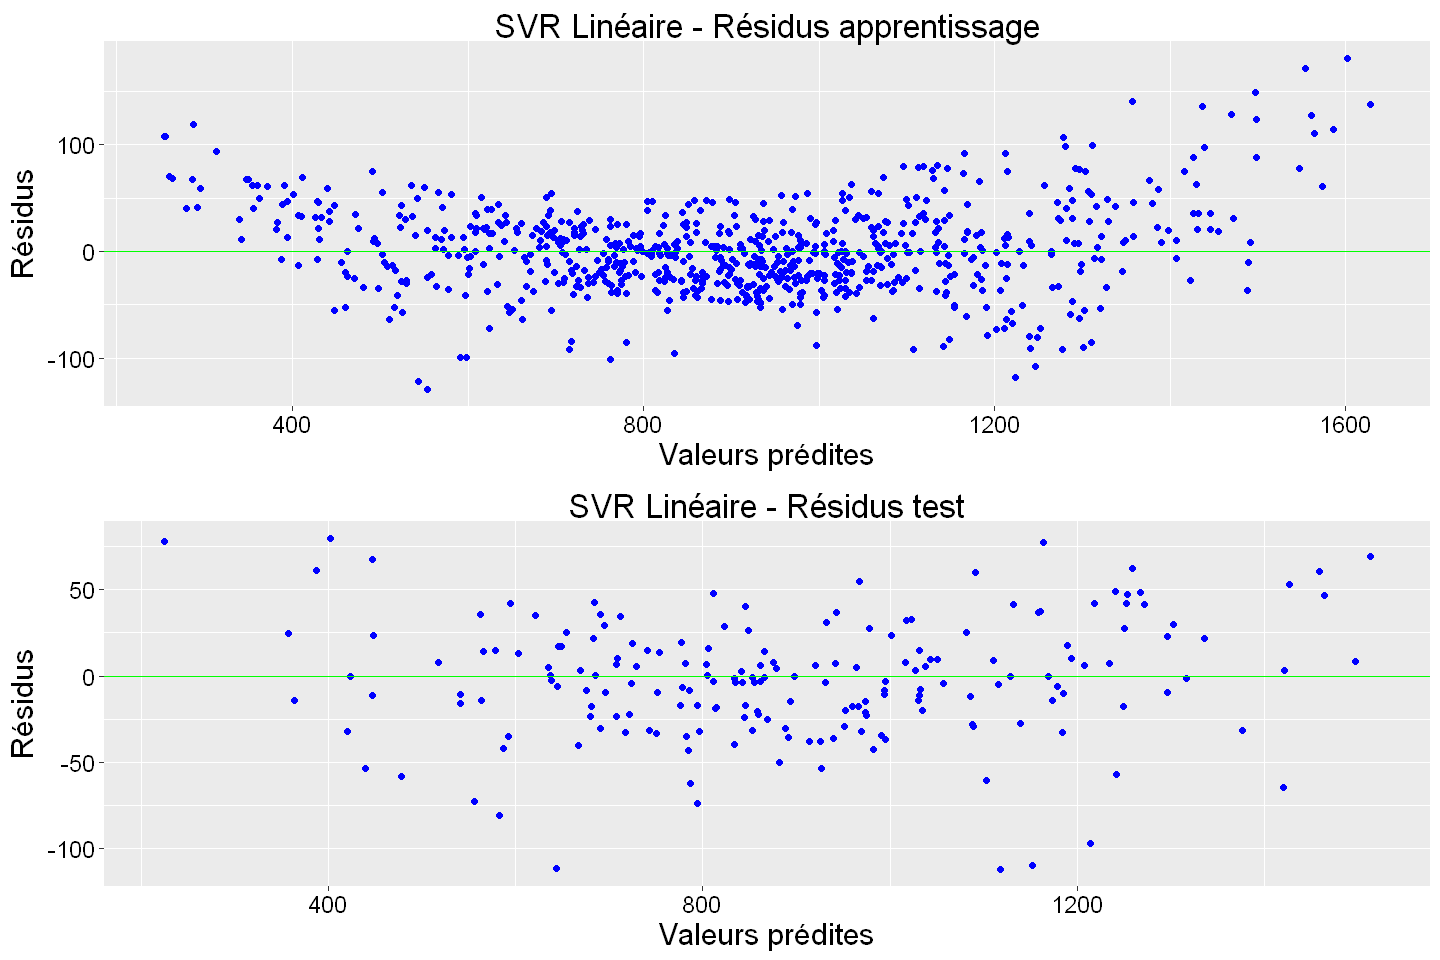

In [146]:
# Prédictions et résidus pour SVR linéaire sur l'ensemble de test
pred_test_lin <- predict(best_svr_lin, newdata = gym_test_scaled)
res_test_lin <- gym_test_scaled$Calories_Burned - pred_test_lin

# Graphiques des résidus
options(repr.plot.width=12, repr.plot.height=8)
p1 <- gplot.res(pred_train_lin, res_train_lin, "SVR Linéaire - Résidus apprentissage")
p2 <- gplot.res(pred_test_lin, res_test_lin, "SVR Linéaire - Résidus test")
grid.arrange(p1, p2, ncol = 1)
rm(p1, p2)

# Calcul du MSE sur l'ensemble de test 
mse_test_svr_lin <- mean(res_test_lin^2)
cat("MSE sur le test set (SVR linéaire): ", round(mse_test_svr_lin, 3), "\n")

Le modèle SVR avec noyau linéaire a été optimisé avec **un coût (C) de 100**. Ce coût élevé suggère une forte pénalisation des erreurs sur l'ensemble d'entraînement, visant un ajustement précis.

Le modèle s'appuie sur **357 vecteurs supports**, indiquant qu'une part notable des données d'entraînement définit la frontière de régression.

Le graphique des résidus présente **une forme de banane**. Cela indique que le modèle linéaire peine à capturer des relations non linéaires dans les données, et potentiellement une hétéroscédasticité.

La MSE sur l'ensemble de test est de 1201. Comparé à l'erreur de validation croisé de 1732, le modèle généralise très bien sur des nouvelles données. 

### SVR Polynomial

Time taken for SVR polynomial tuning:  40.67366  seconds

Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
     cost gamma
 31.62278   0.1

- best performance: 906.9217 




Call:
best.tune(METHOD = svm, train.x = Calories_Burned ~ ., data = gym_train_scaled, 
    ranges = list(cost = 10^seq(-1, 2.5, by = 0.5), gamma = c(0.01, 
        0.1, 1)), kernel = "poly", degree = 2)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  polynomial 
       cost:  31.62278 
     degree:  2 
      gamma:  0.1 
     coef.0:  0 
    epsilon:  0.1 


Number of Support Vectors:  272






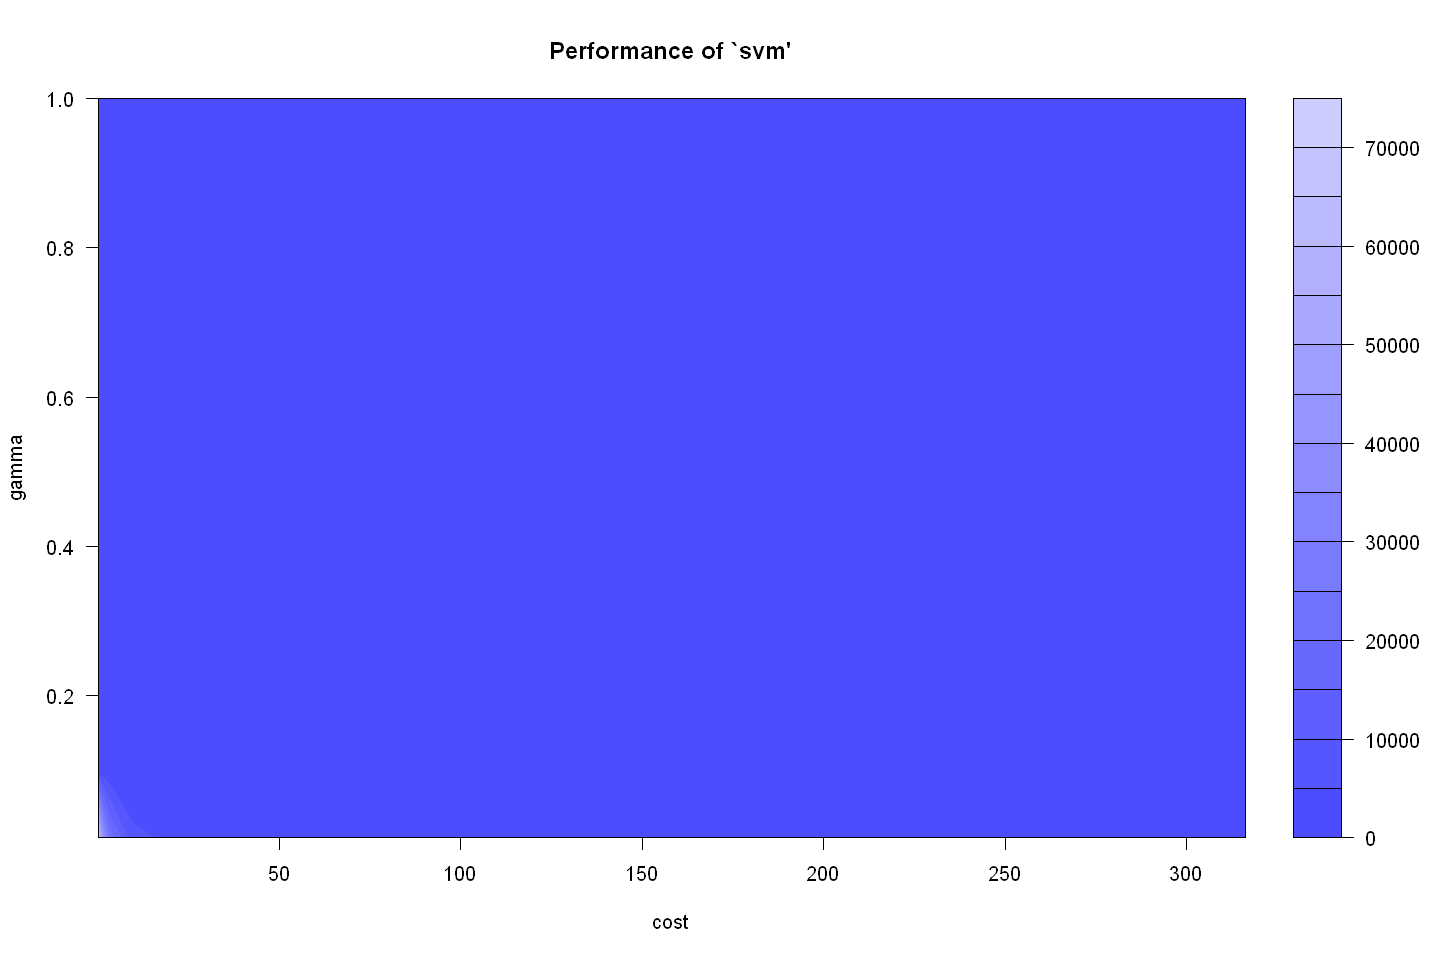

In [112]:
# Recherche des meilleurs hyperparamètres pour le SVR polynomial
set.seed(123)
t0 <- Sys.time()
svr_poly_tune <- tune(
    svm, Calories_Burned ~ ., data = gym_train_scaled,
    kernel = "poly",
    degree = 2,
    ranges = list(
        cost = 10^seq(-1, 2.5, by = 0.5), # 8 valeurs de C
        gamma = c(0.01, 0.1, 1) # 3 valeurs de gamma 
        # 8x3 = 24 combinaisons de paramètres à tester
    )
)
t1 <- Sys.time()
cat("Time taken for SVR polynomial tuning: ", t1 - t0, " seconds\n")

# Affichage des résultats de la recherche d'hyperparamètres
print(svr_poly_tune)
plot(svr_poly_tune)

# Affichage du meilleur modèle
best_svr_poly <- svr_poly_tune$best.model
summary(best_svr_poly)

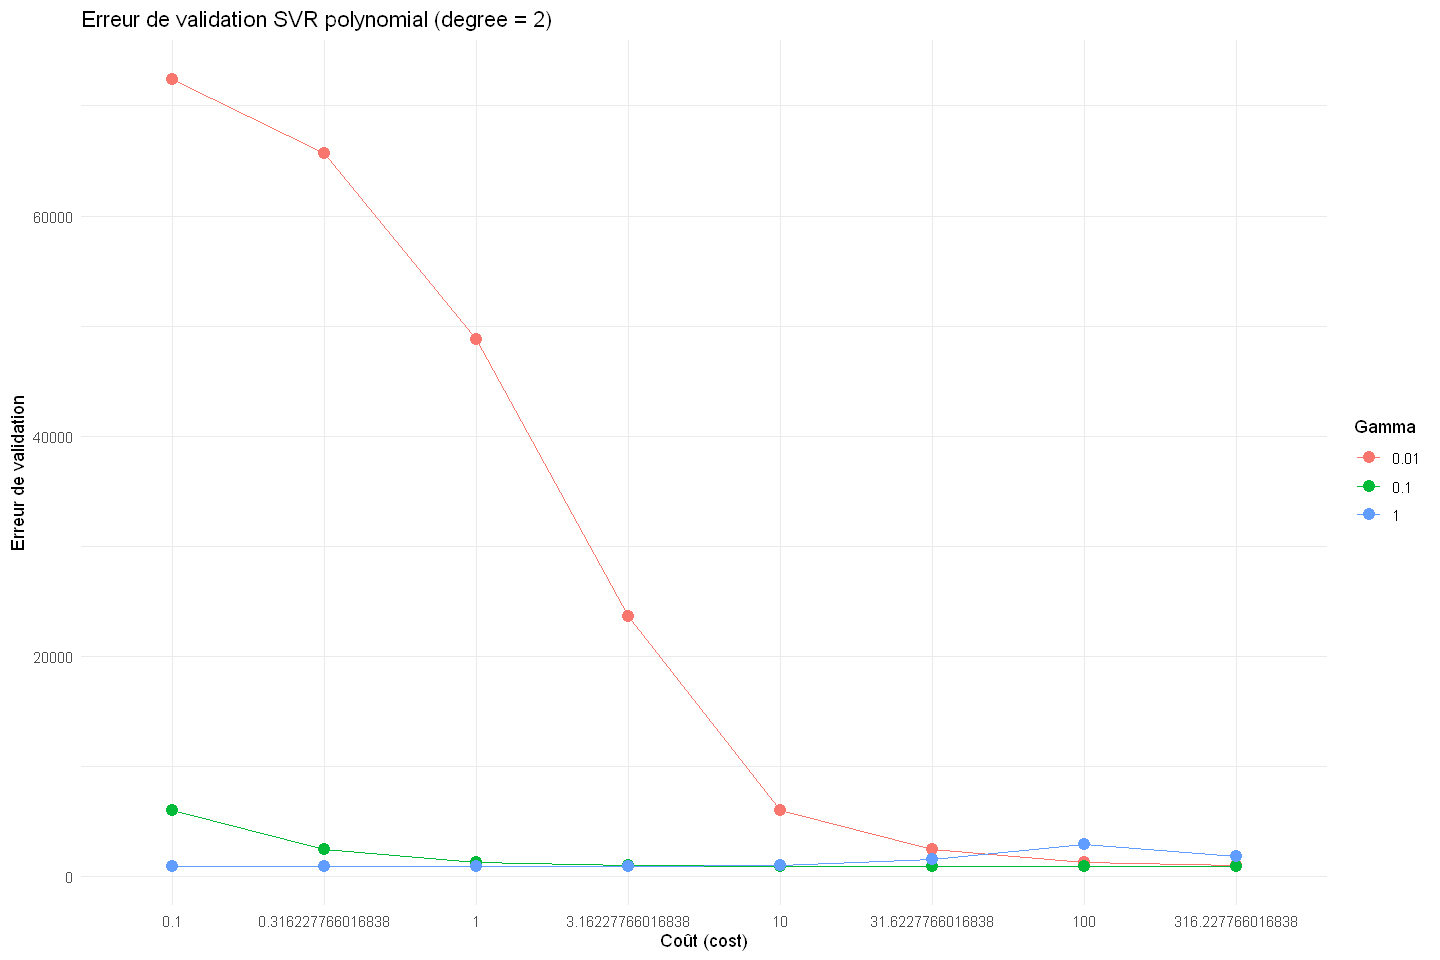

In [113]:
# Extraire les résultats pour degree = 2
results_deg2 <- subset(svr_poly_tune$performances)

# Tracer l'erreur en fonction de cost et gamma pour degree = 2
ggplot(results_deg2, aes(x = factor(cost), y = error, color = factor(gamma), group = gamma)) +
    geom_line() +
    geom_point(size = 3) +
    labs(title = "Erreur de validation SVR polynomial (degree = 2)",
             x = "Coût (cost)",
             y = "Erreur de validation",
             color = "Gamma") +
    theme_minimal()

MSE sur le test set (SVR polynomial):  793.35 


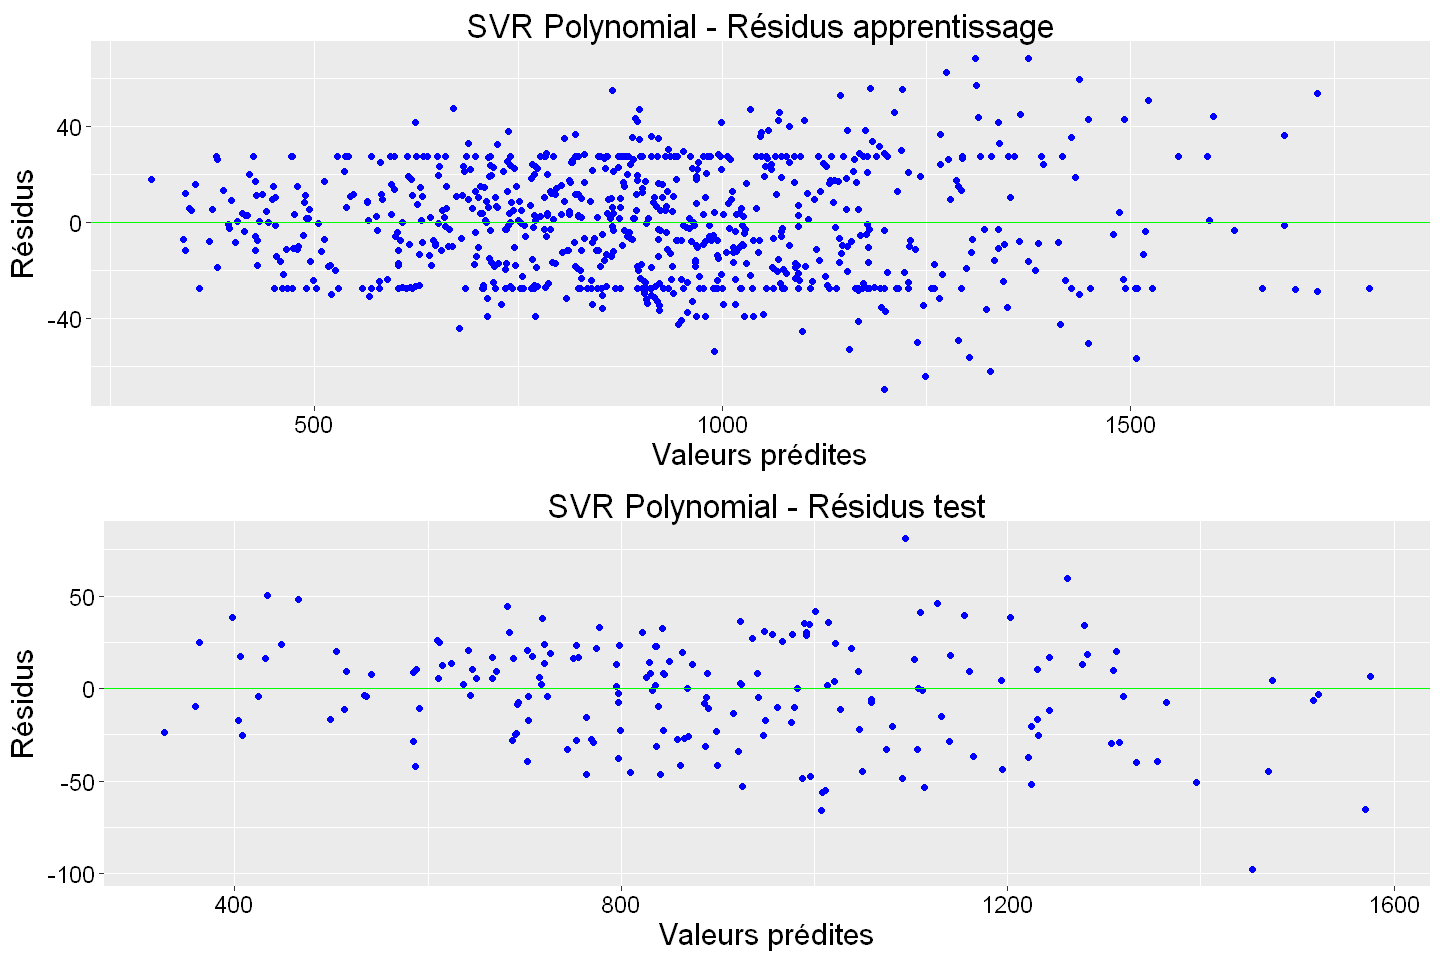

In [147]:
# Prédictions et résidus pour SVR polynomial sur l'ensemble de test
pred_test_poly <- predict(best_svr_poly, newdata = gym_test_scaled)
res_test_poly <- gym_test_scaled$Calories_Burned - pred_test_poly

cat("MSE sur le test set (SVR polynomial): ", round(mean(res_test_poly^2), 3), "\n")

# Graphiques des résidus
options(repr.plot.width=12, repr.plot.height=8)
p1 <- gplot.res(pred_train_poly, res_train_poly, "SVR Polynomial - Résidus apprentissage")
p2 <- gplot.res(pred_test_poly, res_test_poly, "SVR Polynomial - Résidus test")
grid.arrange(p1, p2, ncol = 1)
rm(p1, p2)

Le modèle **SVR avec noyau polynomial** (degré 2) a été optimisé avec un coût $C \approx 32, \gamma = 0.1$. En observant le graphique de l'erreur en fonction du coût, où chaque courbe représente un $\gamma$ différent, on constate que pour des $\gamma$ éléves (0.1 et 1), l'erreur de validation croisée reste relativement stable et faible peu importe le coût. En revanche, pour des $\gamma$ plus faibles (0.01), l'erreur diminue avec le coût, indiquant que le modèle s'ajuste de mieux en mieux aux données d'entraînement dans ce cas. 

Le modèle s'appuie sur **272 vecteurs supports**, indiquant qu'une part notable des données d'entraînement définit la frontière de régression.

La MSE sur l'ensemble de test est de 792. Comparé à l'erreur de validation croisé de 906, le modèle généralise très bien sur des nouvelles données. 

Enfin le temps d'entrainement colossal de 40 minutes pour une grille de 24 modèles, montre que le modèle SVR polynomial est très gourmand en ressources, malgré des performances intéressantes.

### SVR RBF

Time taken for SVR RBF tuning (gamma and cost):  32.81189  seconds

Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10  0.01

- best performance: 784.053 



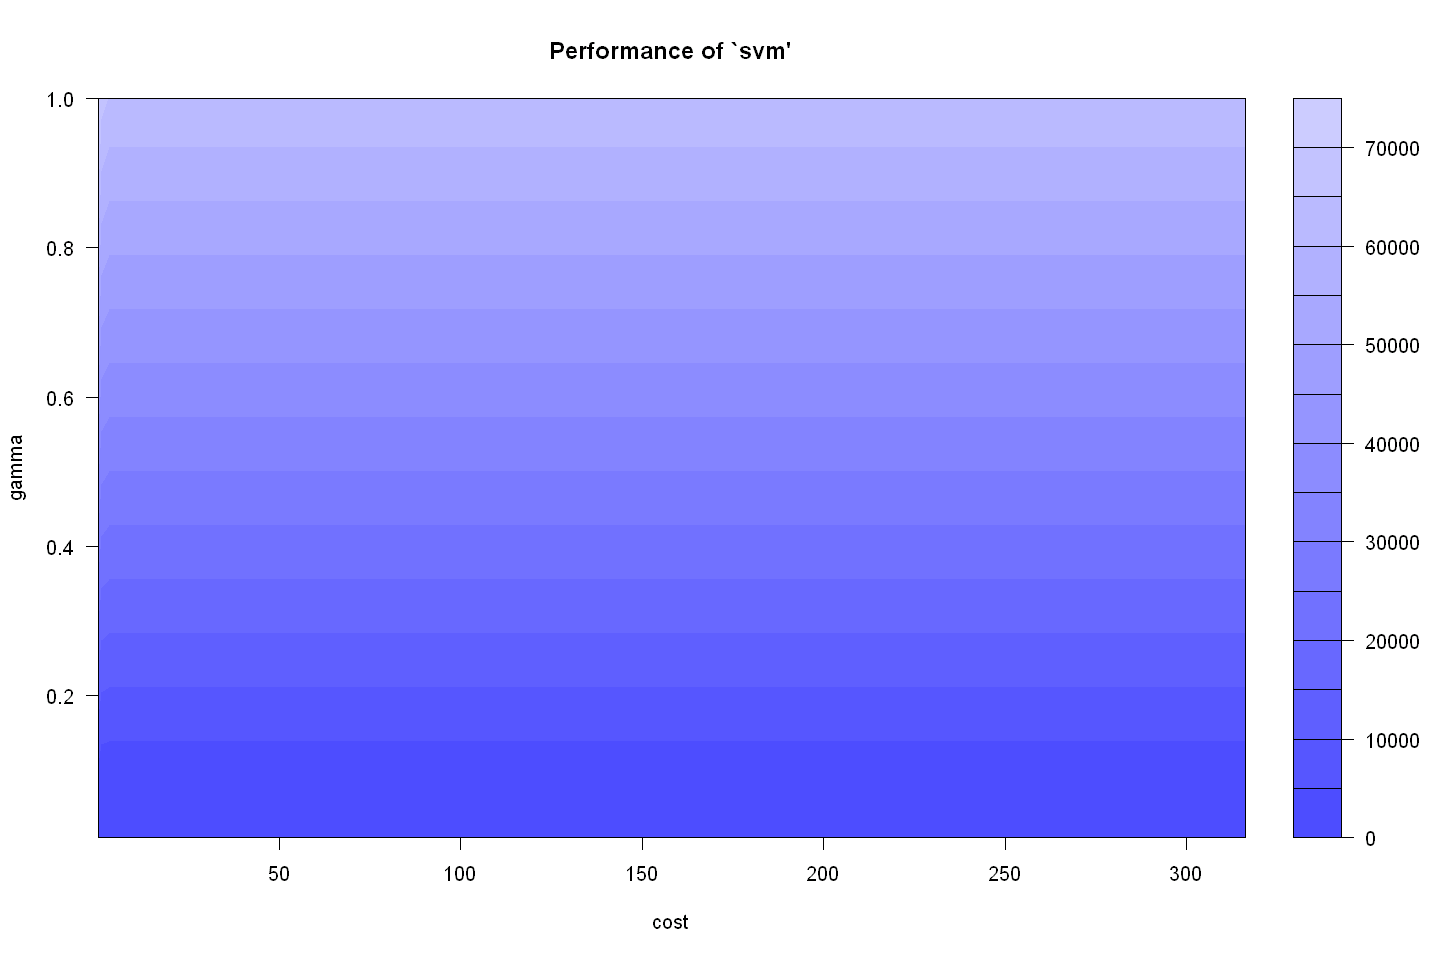

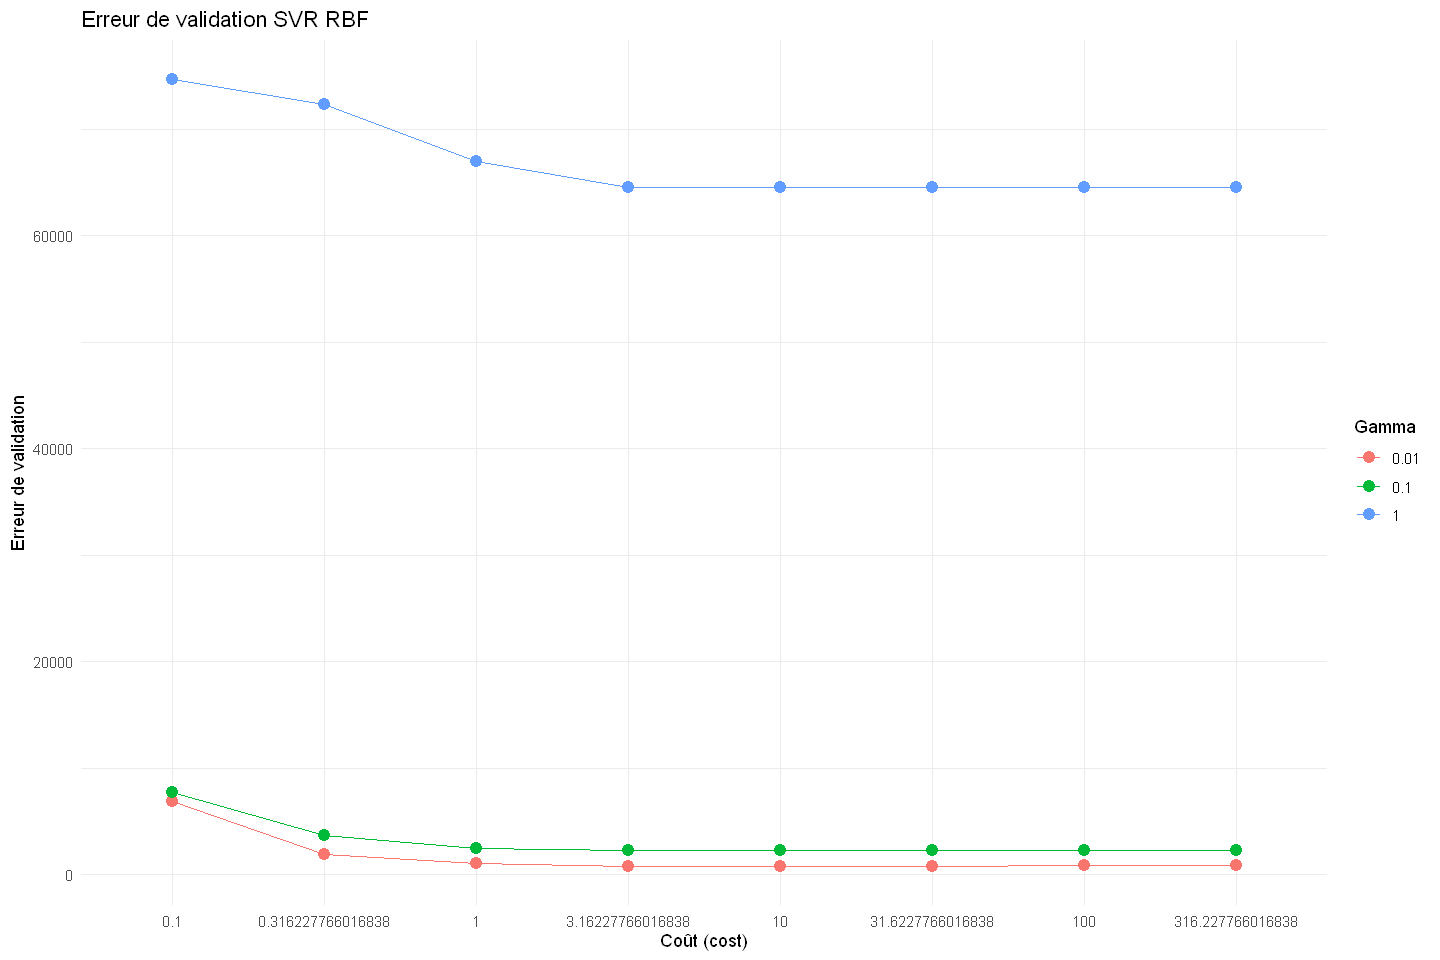

In [116]:
# 1. Recherche du meilleur cost et gamma (epsilon fixé)
set.seed(123)
t0 <- Sys.time()
svr_rbf_tune1 <- tune(
    svm, Calories_Burned ~ ., data = gym_train_scaled,
    kernel = "radial",
    ranges = list(
        cost = 10^seq(-1, 2.5, by = 0.5),
        gamma = c(0.01, 0.1, 1)
        # 8x3 = 24 combinaisons de paramètres à tester
    ),
    epsilon = 0.1
)
t1 <- Sys.time()
cat("Time taken for SVR RBF tuning (gamma and cost): ", t1 - t0, " seconds\n")
print(svr_rbf_tune1)
best_cost <- svr_rbf_tune1$best.parameters$cost
best_gamma <- svr_rbf_tune1$best.parameters$gamma

plot(svr_rbf_tune1)

# Extraire les résultats du tuning RBF
results_rbf <- svr_rbf_tune1$performances

# Tracer l'erreur en fonction de cost et gamma pour le SVR RBF
ggplot(results_rbf, aes(x = factor(cost), y = error, color = factor(gamma), group = gamma)) +
    geom_line() +
    geom_point(size = 3) +
    labs(title = "Erreur de validation SVR RBF",
         x = "Coût (cost)",
         y = "Erreur de validation",
         color = "Gamma") +
    theme_minimal()

Time taken for SVR RBF tuning (epsilon):  7.083028  seconds
Total Time taken for SVR RBF tuning:  39.89492  seconds

Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
    epsilon
 0.05623413

- best performance: 736.4581 




Call:
best.tune(METHOD = svm, train.x = Calories_Burned ~ ., data = gym_train_scaled, 
    ranges = list(epsilon = 10^seq(-2.5, 0, length = 7)), kernel = "radial", 
    cost = best_cost, gamma = best_gamma)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  10 
      gamma:  0.01 
    epsilon:  0.05623413 


Number of Support Vectors:  433






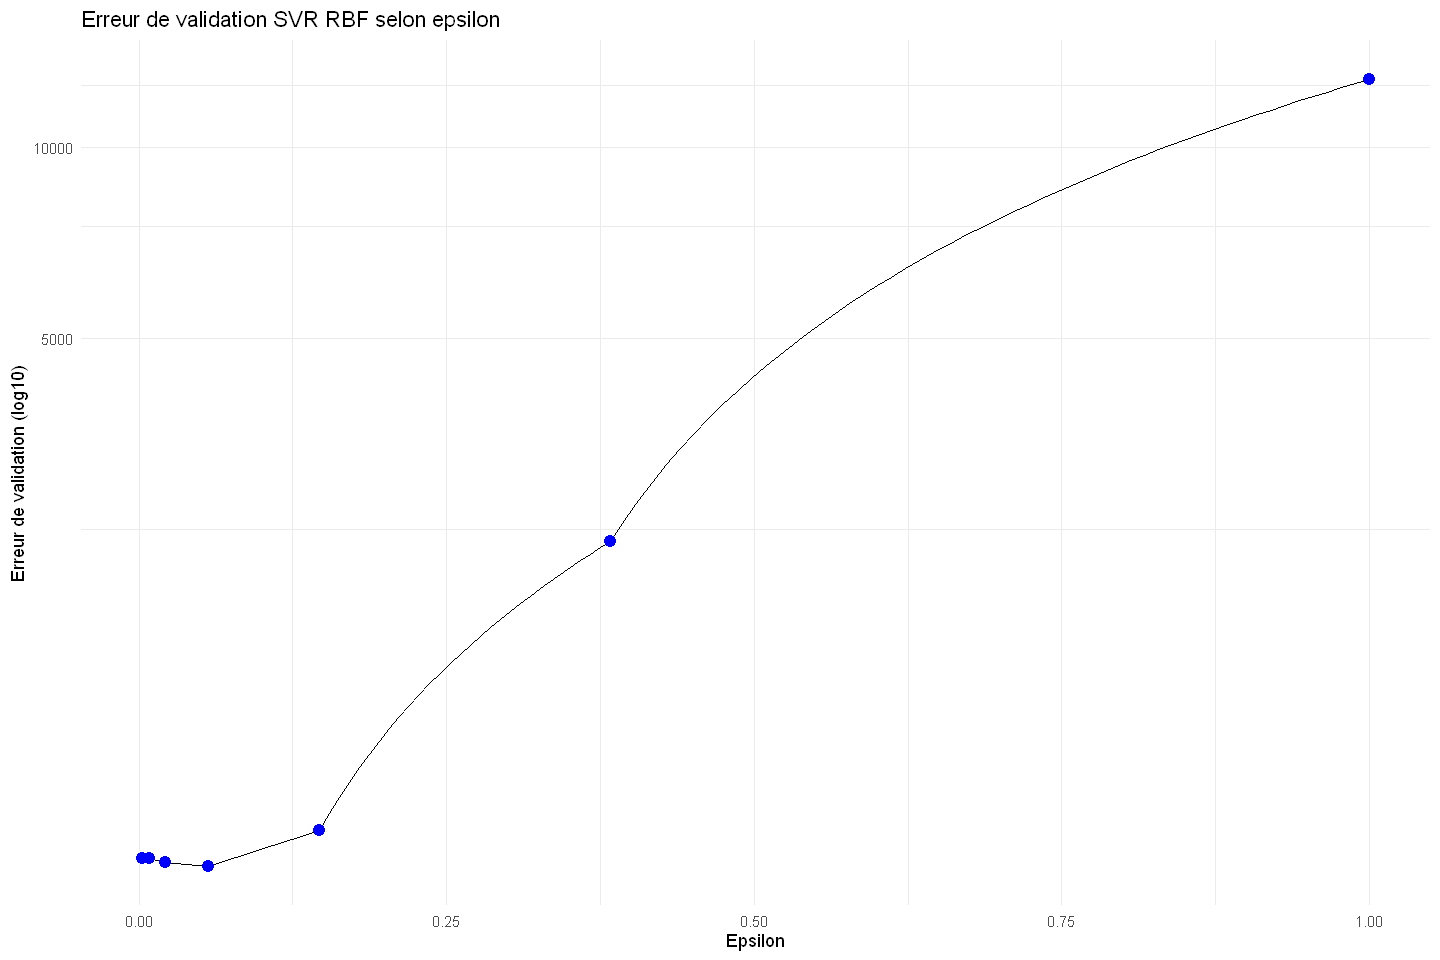

In [151]:
# 2. Recherche du meilleur epsilon avec cost/gamma fixés
t2 <- Sys.time()
svr_rbf_tune2 <- tune(
    svm, Calories_Burned ~ ., data = gym_train_scaled,
    kernel = "radial",
    ranges = list(
        epsilon = 10^seq(-2.5, 0, length = 7) # 7 valeurs d'epsilon à tester
        # 24 + 7 = 31 combinaisons de paramètres à tester au total
    ),
    cost = best_cost,
    gamma = best_gamma
)
t3 <- Sys.time()
cat("Time taken for SVR RBF tuning (epsilon): ", t3 - t2, " seconds\n")

cat("Total Time taken for SVR RBF tuning: ", t3 - t2 + (t1 - t0), " seconds\n")
print(svr_rbf_tune2)
best_epsilon <- svr_rbf_tune2$best.parameters$epsilon

# Meilleur modèle final
best_svr_rbf <- svr_rbf_tune2$best.model
summary(best_svr_rbf)

# Extraire les résultats du tuning epsilon
results_epsilon <- svr_rbf_tune2$performances

# Tracer l'erreur en fonction de epsilon pour le SVR RBF (cost/gamma fixés) avec l'axe y en log
ggplot(results_epsilon, aes(x = epsilon, y = error)) +
    geom_line() +
    geom_point(size = 3, color = "blue") +
    coord_trans(y ='log10') +
    labs(title = "Erreur de validation SVR RBF selon epsilon",
         x = "Epsilon",
         y = "Erreur de validation (log10)") +
    theme_minimal()


MSE sur le test set (SVR RBF):  575.054 


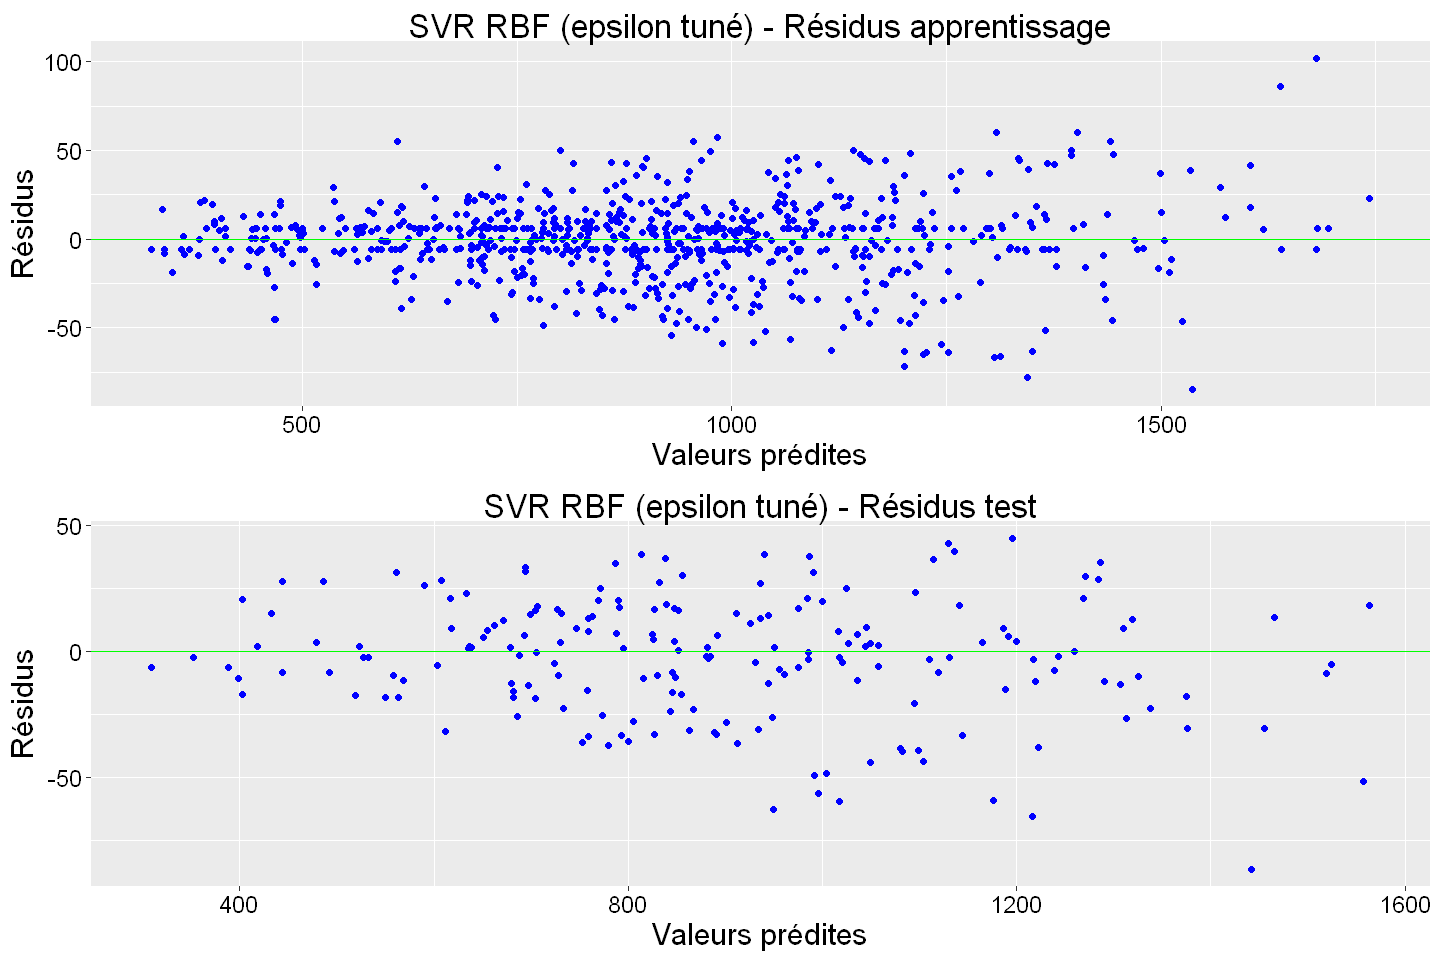

In [148]:
# Prédictions et résidus pour SVR RBF (epsilon tuné) sur l'ensemble de test
pred_test_rbf <- predict(best_svr_rbf, newdata = gym_test_scaled)
res_test_rbf <- gym_test_scaled$Calories_Burned - pred_test_rbf

cat("MSE sur le test set (SVR RBF): ", round(mean(res_test_rbf^2), 3), "\n")

# Graphiques des résidus
options(repr.plot.width=12, repr.plot.height=8)
p1 <- gplot.res(pred_train_rbf, res_train_rbf, "SVR RBF (epsilon tuné) - Résidus apprentissage")
p2 <- gplot.res(pred_test_rbf, res_test_rbf, "SVR RBF (epsilon tuné) - Résidus test")
grid.arrange(p1, p2, ncol = 1)
rm(p1, p2)

L'optimisation du modèle SVR avec un noyau RBF a été réalisée en deux étapes : d'abord la recherche du meilleur couple `cost` et `gamma` (avec `epsilon` fixé à 0.1), puis l'optimisation de `epsilon` avec les meilleurs `cost` et `gamma` trouvés.

**1. Optimisation de `cost` et `gamma` (epsilon = 0.1) :**
   - D'après le graphique "Erreur de validation SVR RBF", on observe que pour les trois valeurs de `gamma` testées (0.01, 0.1, 1) :
      - Lorsque le **`cost` dépasse une valeur d'environ 3 (log10(cost) ≈ 0.5)**, l'erreur de validation tend à stagner ou à ne plus diminuer significativement.
      - Le meilleur `cost` identifié par la fonction `tune` est de **10**.
   - Concernant `gamma` :
      - Un **`gamma` plus faible (0.01)** a conduit à une erreur de validation systématiquement plus basse par rapport aux `gamma` plus élevés (0.1 et 1) pour la plupart des valeurs de `cost`.
      - Le meilleur `gamma` identifié est **0.01**.
   - Le couple optimal issu de cette première étape est donc `cost = 10` et `gamma = 0.01`, avec une erreur de validation croisée (CV error) d'environ 742.8.

**2. Optimisation de `epsilon` (avec `cost = 10`, `gamma = 0.01`) :**
   - La recherche du meilleur `epsilon` a conduit à une valeur de **`epsilon ≈ 0.056`**.
   - Cette valeur est légèrement plus petite que la valeur par défaut de `epsilon = 0.1` utilisée dans la première étape de tuning.
   - L'erreur de validation croisée (CV error) obtenue avec ces hyperparamètres optimaux (`cost=10`, `gamma=0.01`, `epsilon≈0.056`) est d'environ **738.3**.

**Performance et Caractéristiques du Modèle Final SVR RBF :**
   - **Temps d'entraînement :** L'ensemble du processus d'optimisation pour le SVR RBF (les deux étapes) a pris environ **40 secondes** (`34.5s + 5.4s`). Cela en fait un modèle relativement rapide à entraîner par rapport au SVR polynomial, par exemple.
   - **Performance sur l'ensemble de test :** La MSE obtenue sur l'ensemble de test avec le meilleur modèle SVR RBF est de **575.4**. Cette valeur est inférieure à l'erreur de validation croisée (738.3), ce qui suggère une bonne capacité de généralisation du modèle.
   - **Vecteurs Supports :** Le modèle final s'appuie sur **433 vecteurs supports**. Étant donné que l'échantillon d'entraînement (`gym_train_scaled`) contient 779 observations, cela signifie que **près de 55% des données d'entraînement sont utilisées comme vecteurs supports**, ce qui est une proportion considérable.

**Analyse des Résidus (sur l'ensemble de test) :**
   - Le graphique des résidus pour le SVR RBF sur l'ensemble de test montre une **répartition globalement homogène** des points autour de la ligne zéro.
   - Il n'y a pas de forme de "banane" évidente comme observée avec le SVR linéaire, ce qui indique que le noyau RBF a mieux capturé les non-linéarités.
   - On note cependant que pour les valeurs prédites de Calories_Burned très élevées (au-delà de 1500 kcal), les résidus ont tendance à être plus dispersés et parfois plus importants, indiquant une précision potentiellement moindre pour ces prédictions extrêmes. Néanmoins, la majorité des résidus se situe dans une bande étroite.

En résumé, le SVR avec noyau RBF, après optimisation des hyperparamètres `cost`, `gamma`, et `epsilon`, se révèle être un modèle compétitif, rapide à entraîner, et affichant de bonnes performances de généralisation avec une MSE de test de 575.4.

In [120]:
# Récupération des best error depuis les objets tune
best_error_lin  <- svr_tune$best.performance
best_error_poly <- svr_poly_tune$best.performance
best_error_rbf  <- svr_rbf_tune2$best.performance

# Calcul des R² test pour chaque modèle (si pas déjà fait)
# r2_test_lin, r2_test_poly, r2_test_rbf doivent être définis dans les cellules précédentes

# Tableau récapitulatif
perf_svr <- data.frame(
    Modèle = c("SVR Linéaire", "SVR Polynomial", "SVR RBF"),
    Best_Error_CV = c(round(best_error_lin, 2), round(best_error_poly, 2), round(best_error_rbf, 2)),
    MSE_Test = c(round(mse_test_lin, 2), round(mse_test_poly, 2), round(mse_test_rbf, 2)),
    R2_Test  = c(round(r2_test_lin, 3), round(r2_test_poly, 3), round(r2_test_rbf, 3))
)
print(perf_svr, row.names = FALSE)


         Modèle Best_Error_CV MSE_Test R2_Test
   SVR Linéaire       1721.73  1201.68   0.982
 SVR Polynomial        906.92   793.35   0.988
        SVR RBF        738.49   575.05   0.992


**Bilan SVR**

Le **SVR avec noyau RBF se distingue comme le plus performant**. Il affiche la plus faible erreur quadratique moyenne sur l'ensemble de test (MSE_Test = 575.05) et le coefficient de détermination R² le plus élevé (0.992).

De plus, le **modèle SVR RBF démontre une excellente capacité de généralisation**, son erreur sur l'ensemble de test étant inférieure à son erreur de validation croisée (738.49). **Son temps d'entraînement relativement court** (environ 40 secondes) en fait également une option efficace en termes de ressources.

Cependant, un inconvénient majeur des modèles SVR, et particulièrement avec le noyau RBF, réside dans leur **manque d'interprétabilité directe**. Contrairement aux modèles linéaires ou aux arbres de décision, il est difficile d'obtenir une vision claire de l'importance relative des différentes variables explicatives dans la prédiction. 

Enfin, comparé au modèle Lasso quadratique, le SVR RBF en plus d'être plus gourmand en ressources (40s d'entrainement contre 2s pour le Lasso quadratique), de manque d'interprétabilité, et ce pour un même niveau de performance (MSE test de 575.4 pour le SVR RBF contre 560.17 pour le Lasso quadratique et R² test=0.992 pour les deux modèles). 

## CART & Agregation
### Arbre de Décision CART

In [ ]:
attributes(tree.reg.cal)

$names
 [1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"            

$xlevels
$xlevels$Gender
[1] "Female" "Male"  

$xlevels$Workout_Type
[1] "Cardio"   "HIIT"     "Strength" "Yoga"    

$xlevels$Workout_Frequency..days.week.
[1] "2" "3" "4" "5"

$xlevels$Experience_Level
[1] "1" "2" "3"


$class
[1] "rpart"

Time taken for regression tree:  0.04107904  seconds
number of cps:  58 


Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


MSE on training set:  2613.292 
MSE on test set:  4521.336 
R2 on training set:  0.9655021 
R2 on test set:  0.9342961 


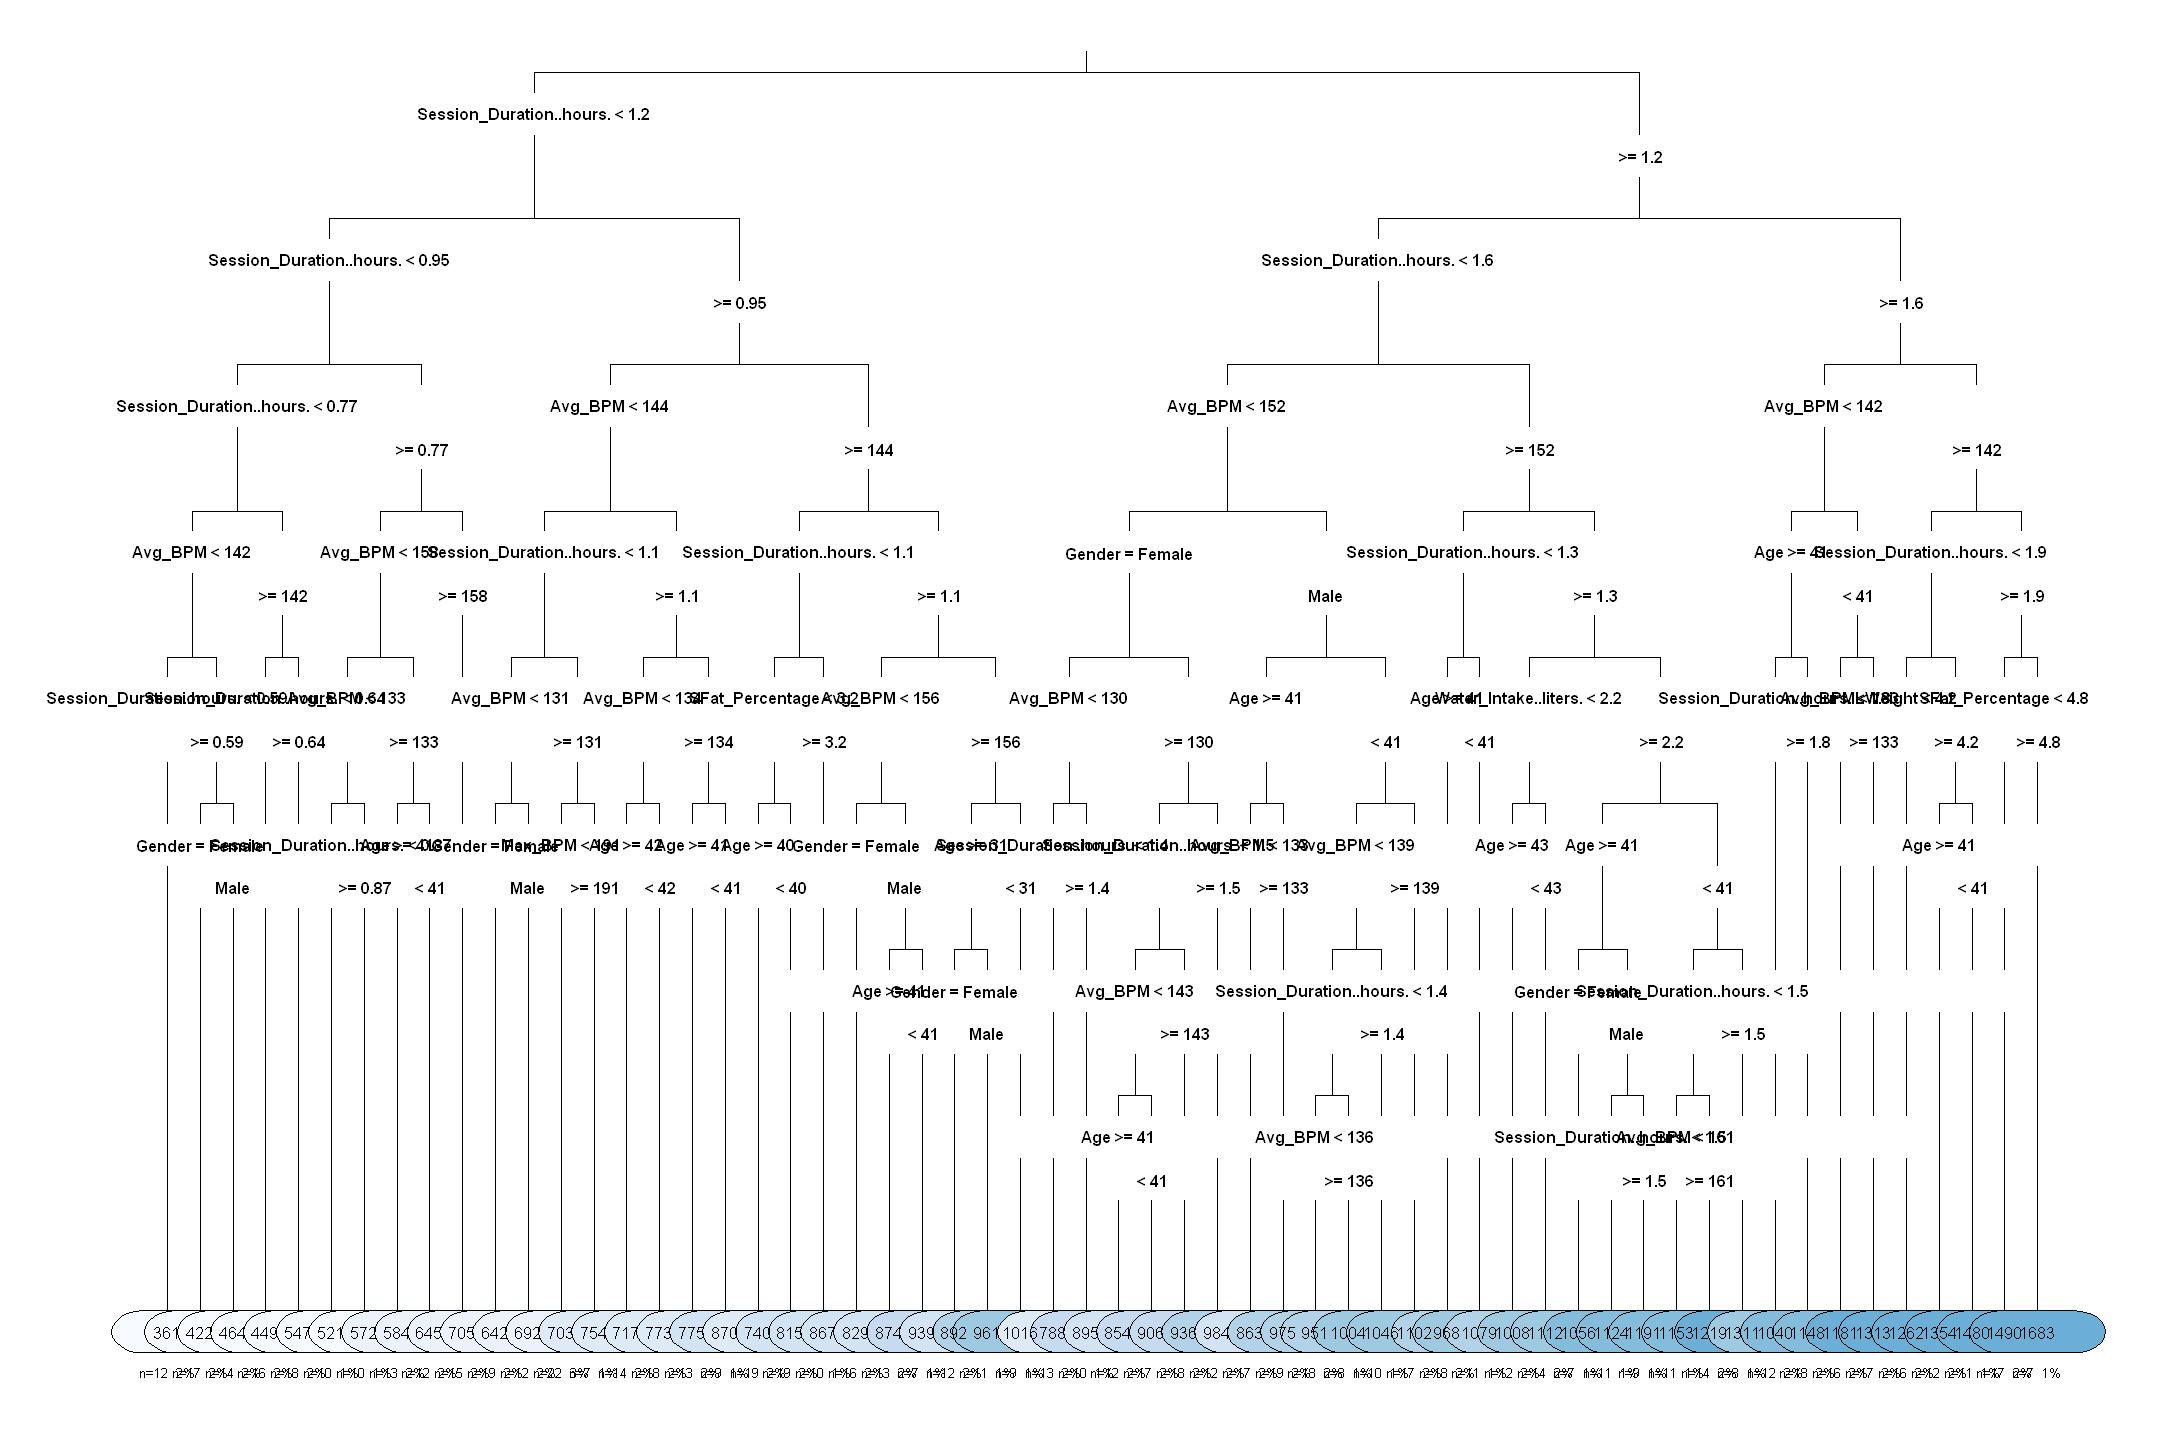

In [183]:
# Fit a regression tree model
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Calories_Burned
t0 <- Sys.time()
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.0001)) # Fais une cross validation par défaut, mais ressort l'arbre avec le cp spécifié
t1 <- Sys.time()
cat("Time taken for regression tree: ", t1 - t0, " seconds\n")
cat("number of cps: ", length(tree.reg.cal$cptable[,1]), "\n")

# Plot the tree
options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# summary(tree.reg.cal)

# compute MSE and R2 on training and test sets
mse_train <- mean((gym_train$Calories_Burned - predict(tree.reg.cal, gym_train))^2)
mse_test <- mean((gym_test$Calories_Burned - predict(tree.reg.cal, gym_test))^2)
r2_train <- 1 - mse_train / var(gym_train$Calories_Burned)
r2_test <- 1 - mse_test / var(gym_test$Calories_Burned)
cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
cat("R2 on training set: ", r2_train, "\n")
cat("R2 on test set: ", r2_test, "\n")

**Interprétation** : Nous avons initialement construit un arbre de régression avec un paramètre de complexité extrêmement faible (`cp = 0.0001`). Comme attendu, ce modèle présente une structure profondément ramifiée (58 feuilles), caractéristique d'un sur-apprentissage. Ce modèle présente une performance relativement bonne sur le jeu d’entraînement (R² = 0.966, MSE = 2613), mais un écart significatif entre l’erreur d’entraînement et de test (MSE_test = 4521) révèle un sur-apprentissage. Toutefois, le R² sur le test reste élevé (0.934), indiquant que le modèle capture une part substantielle de la variance explicative, malgré sa complexité excessive.

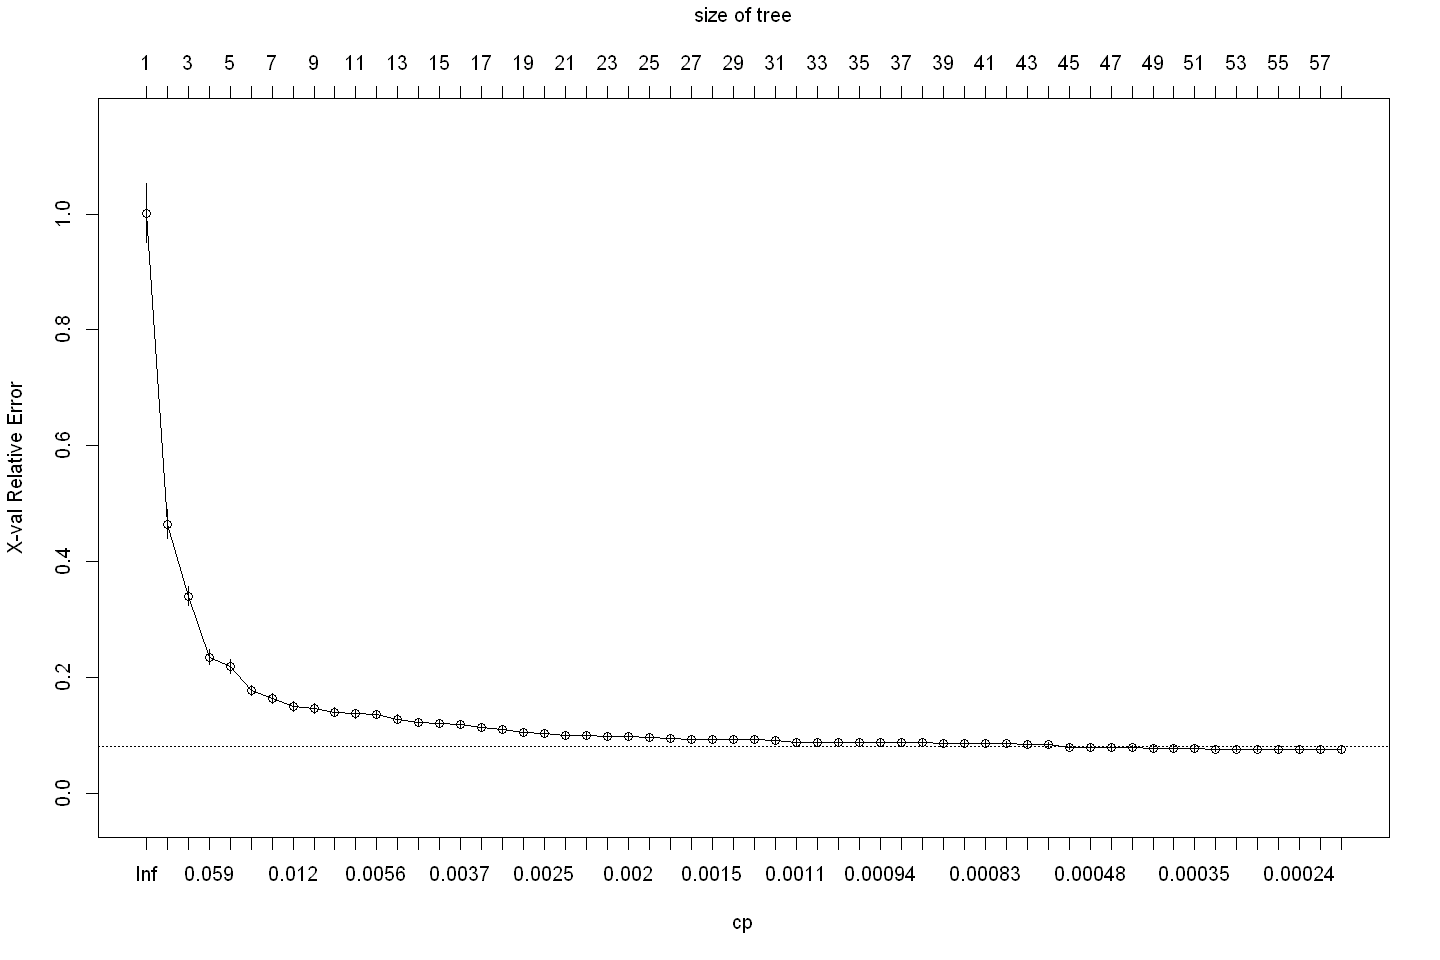

In [190]:
options(repr.plot.width=12, repr.plot.height=8)

xmat = xpred.rpart(tree.reg.cal, xval = 10)

CVerr<-apply((xmat-gym_train[,"Calories_Burned"])^2,2,sum)

plotcp(tree.reg.cal)

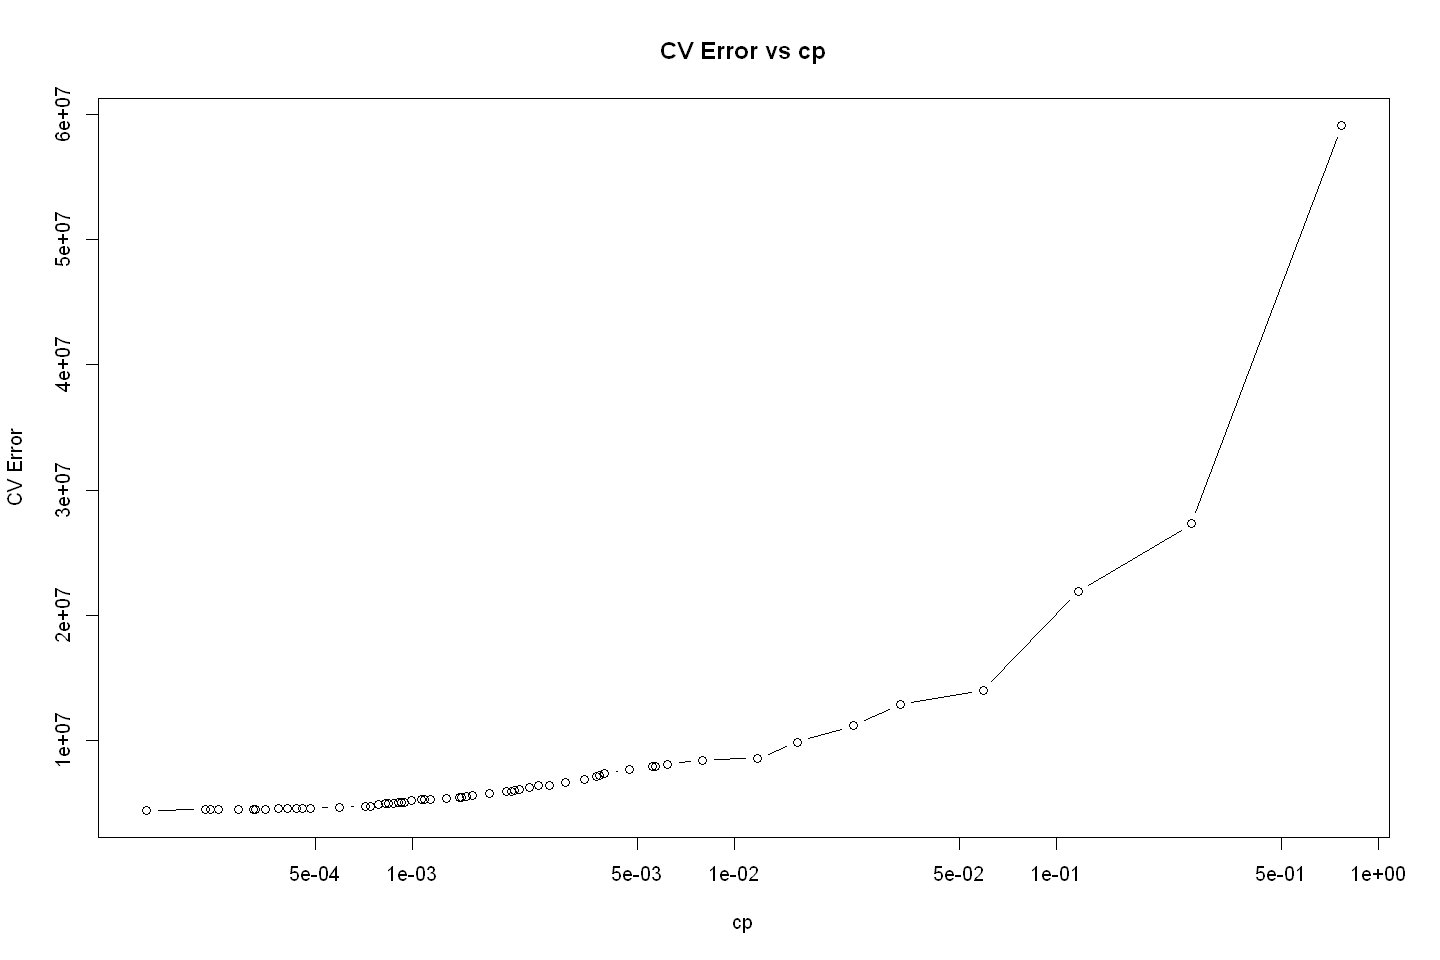

In [191]:
plot(as.numeric(names(CVerr)), CVerr, type = "b", xlab = "cp", ylab = "CV Error", main = "CV Error vs cp", log = "x")

[1] 0.0001485483

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


Number of nodes:  115 


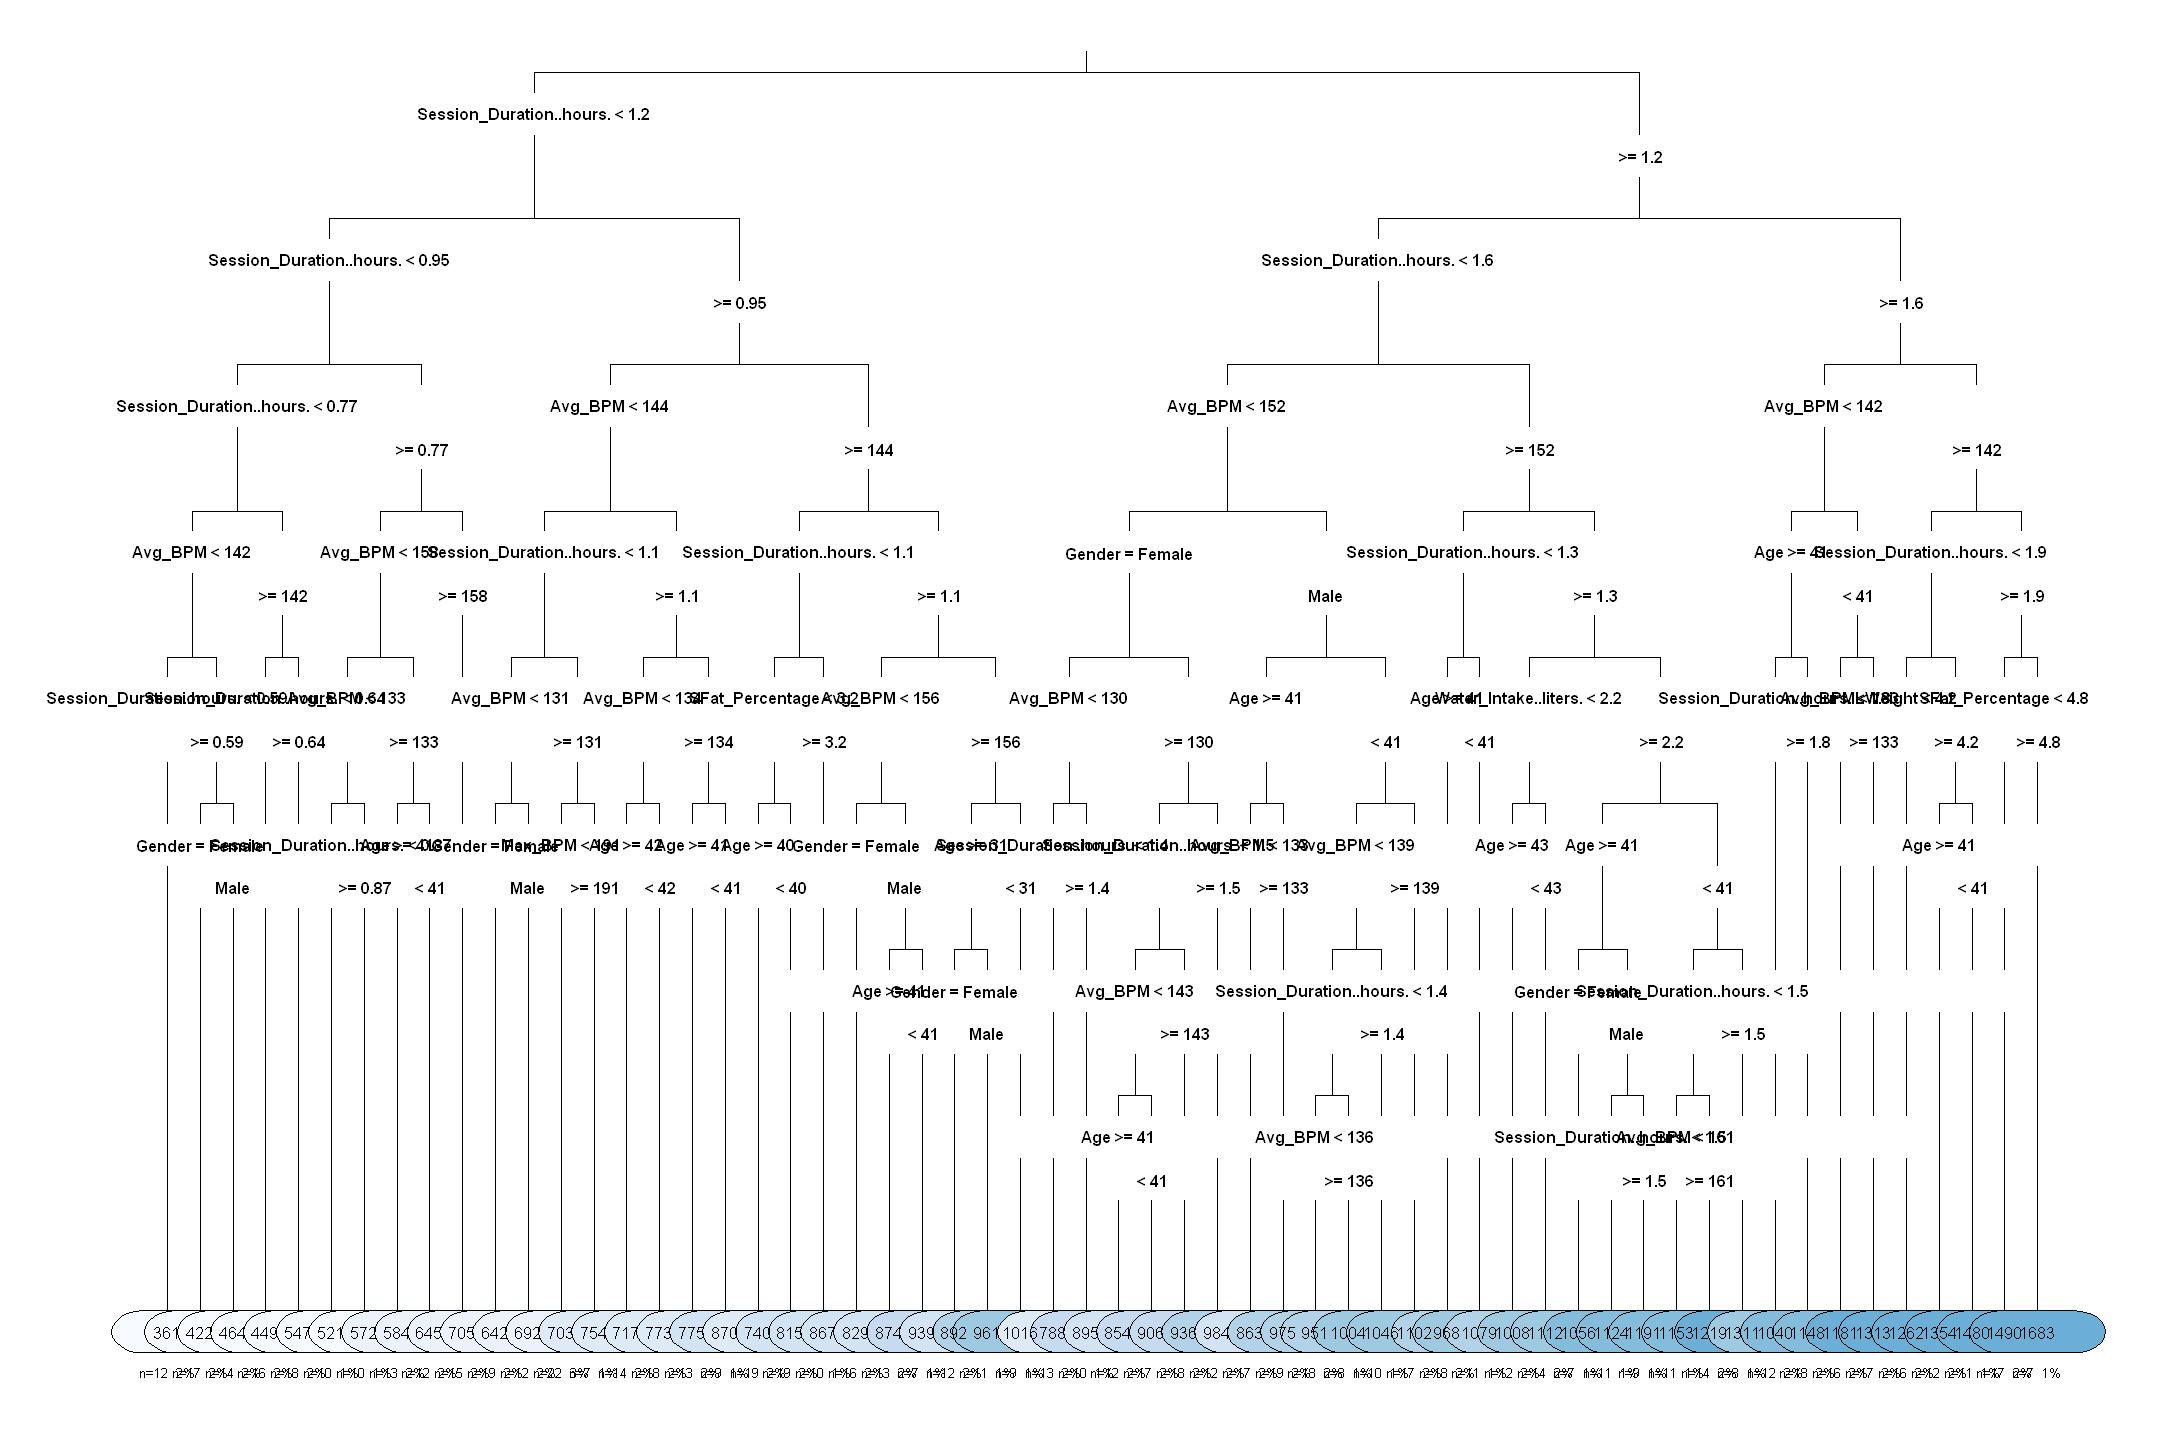

In [192]:
options(repr.plot.width=18, repr.plot.height=12)
as.numeric(attributes(which.min(CVerr))$names)
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# display the number of nodes of the treee
cat("Number of nodes: ", length(tree.reg.cal$frame$var), "\n")

**Interprétation** : La validation croisée 10-fold a identifié une pénalité optimale inattendue (`cp ≈ 0.00015`), conduisant à une erreur de validation (MSE ≈ 4521) inférieure aux modèles moins complexes. Ce résultat paradoxal – où réduire `cp` améliore la performance en validation – pourrait s'expliquer par :
- La présence d'interactions complexes dans les données, nécessitant une structure arborescente fine pour être capturées,
- Un biais de sélection lié à l'échantillon, où le sur-apprentissage partiel reste généralisable.

Le premier point est peu probable car le modèle de régression linéaire avec régularisation LASSO a déjà capturé la plupart des interactions significatives. Le second point est plus plausible, suggérant que le modèle a appris des motifs spécifiques à l'échantillon d'entraînement qui se généralisent bien à la validation croisée.

Cependant, l'arbre résultant reste difficilement interprétable (115 nœuds), soulignant un compromis problématique entre performance et explicabilité.

In [193]:
# library(partykit)
# plot(as.party(tree.reg.cal), type="simple")

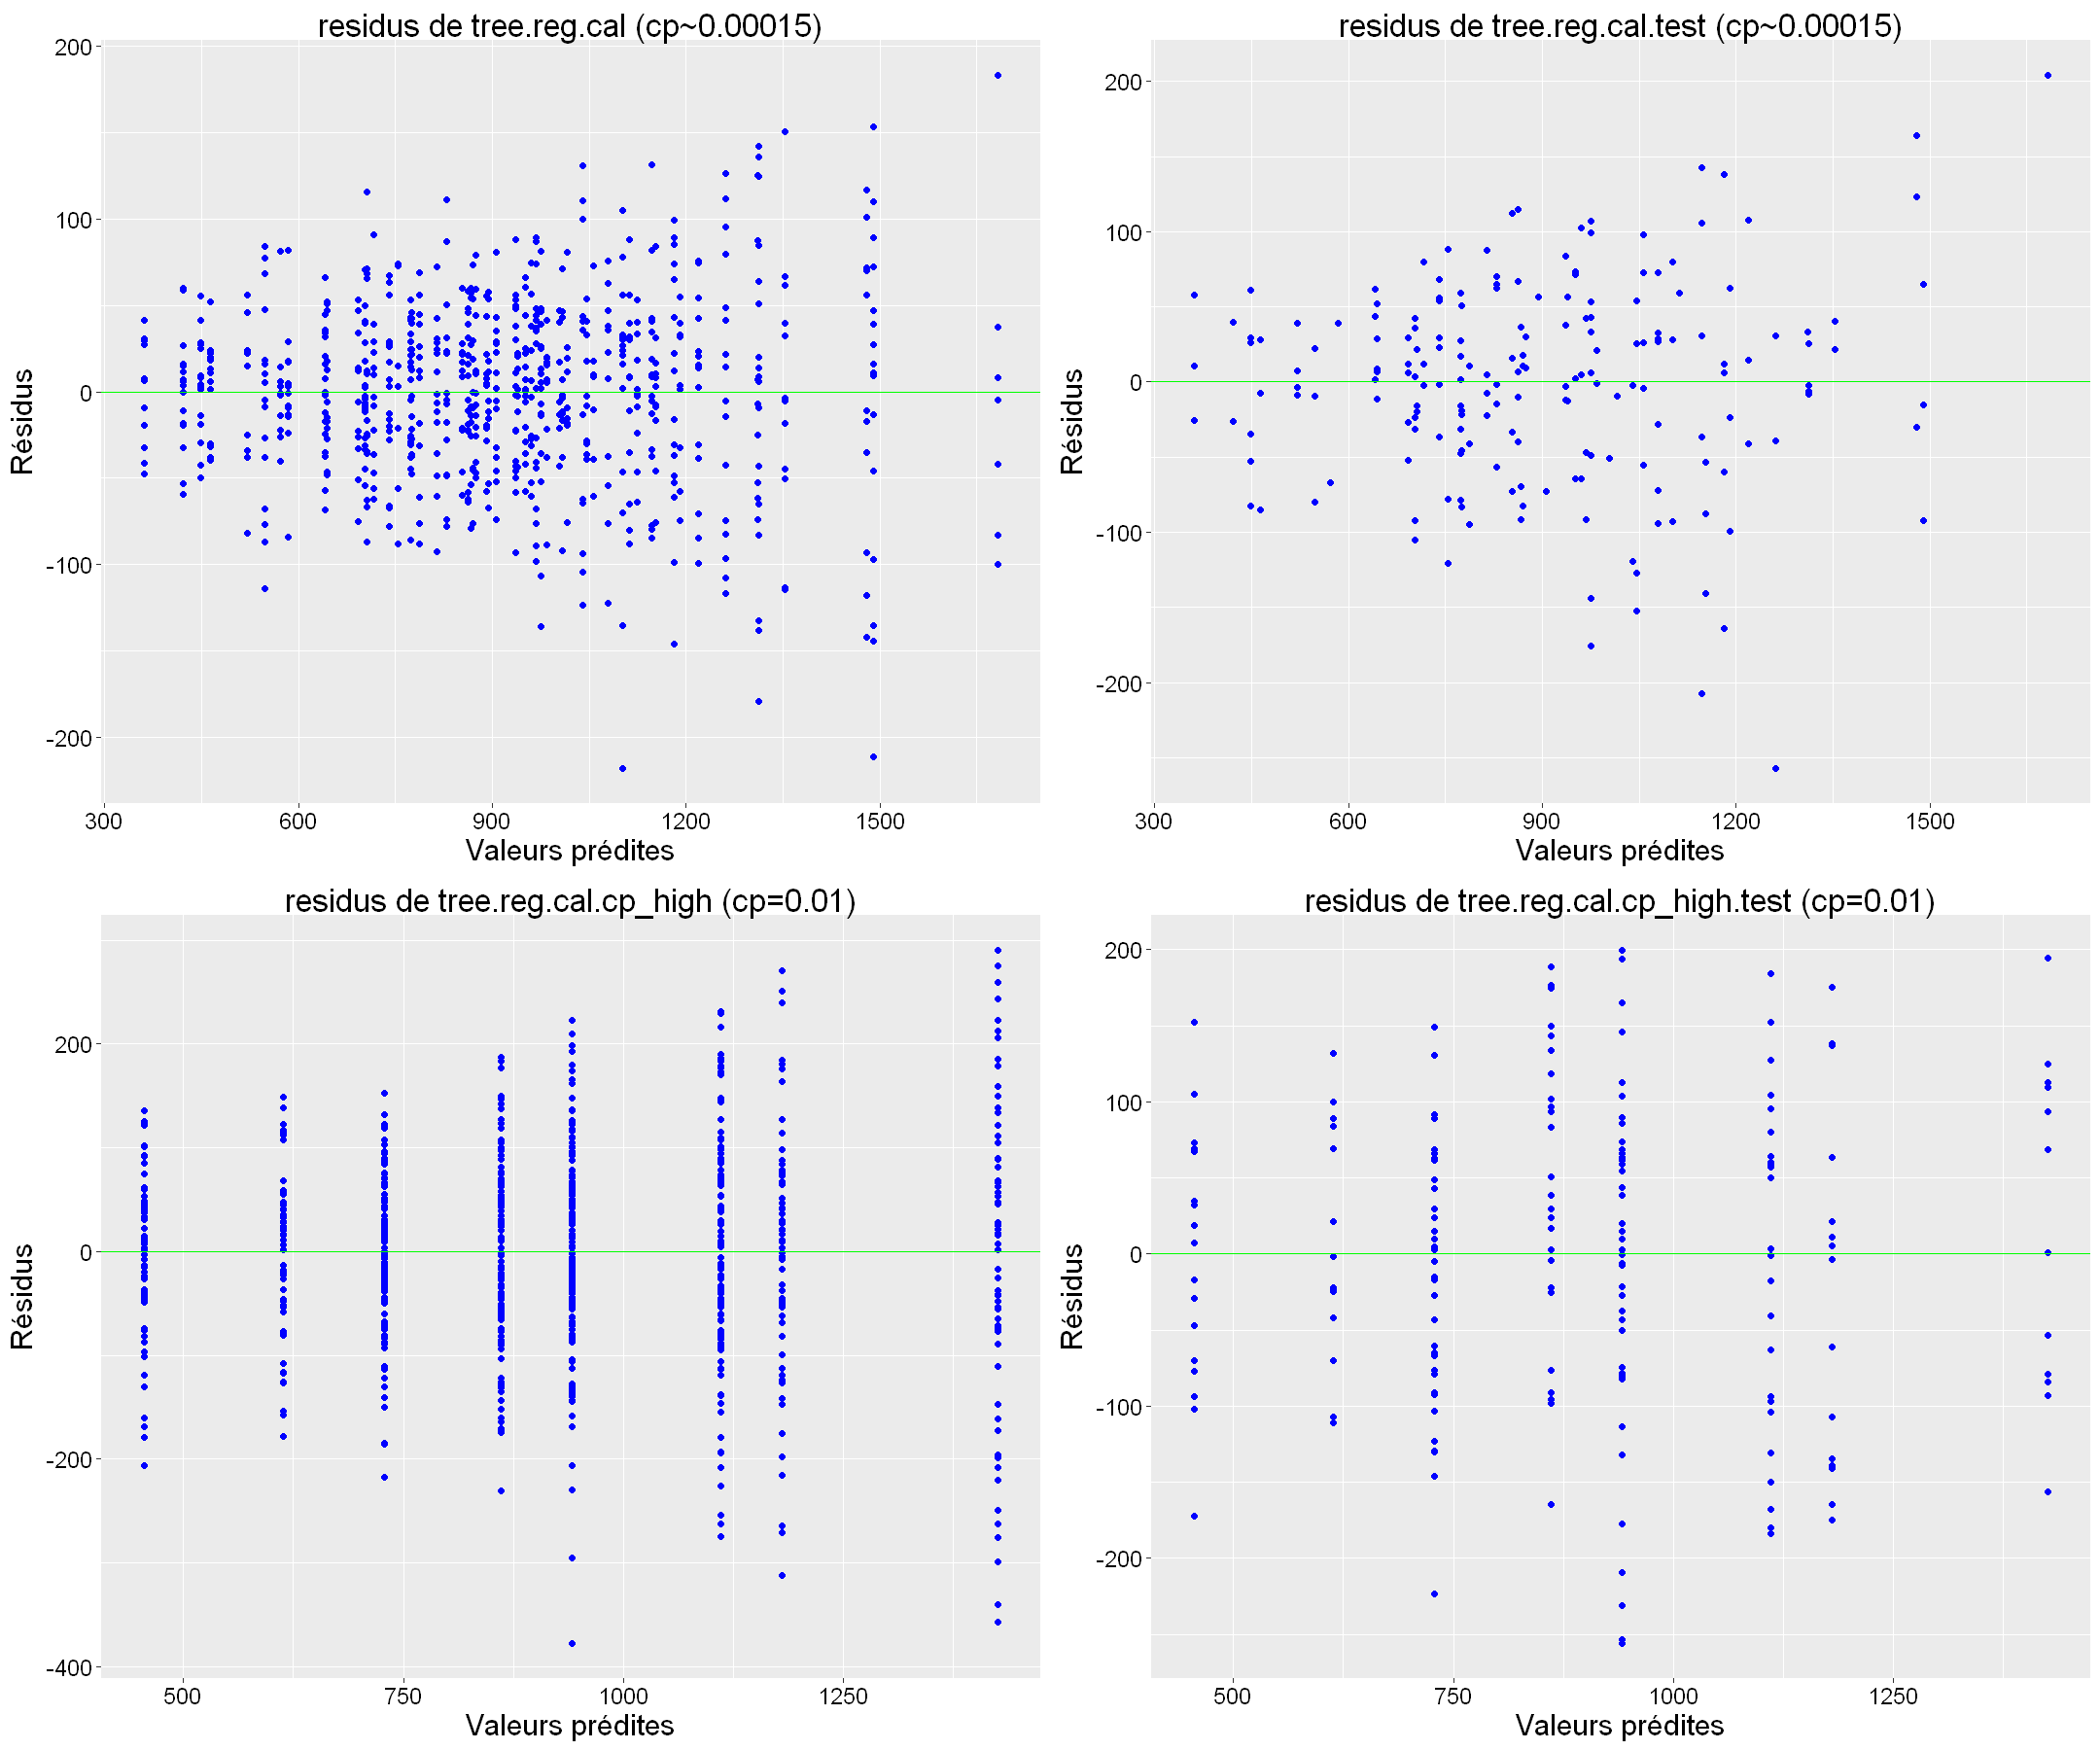

In [194]:
options(repr.plot.width=18, repr.plot.height=15)

fit.tree.cal=predict(tree.reg.cal)
res.tree.cal=fit.tree.cal-gym_train[,"Calories_Burned"]
p1 <- gplot.res(fit.tree.cal,res.tree.cal,"residus de tree.reg.cal (cp~0.00015)")

fit.tree.cal.test=predict(tree.reg.cal, newdata=gym_test)
res.tree.cal.test=fit.tree.cal.test-gym_test[,"Calories_Burned"]
p2 <- gplot.res(fit.tree.cal.test,res.tree.cal.test,"residus de tree.reg.cal.test (cp~0.00015)")

# Create a tree with lower complexity parameter (cp)
tree.reg.cal.cp_high <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.01))

fit.tree.cal.cp_high=predict(tree.reg.cal.cp_high)
res.tree.cal.cp_high=fit.tree.cal.cp_high-gym_train[,"Calories_Burned"]
p3 <- gplot.res(fit.tree.cal.cp_high,res.tree.cal.cp_high,"residus de tree.reg.cal.cp_high (cp=0.01)")
fit.tree.cal.cp_high.test=predict(tree.reg.cal.cp_high, newdata=gym_test)
res.tree.cal.cp_high.test=fit.tree.cal.cp_high.test-gym_test[,"Calories_Burned"]
p4 <- gplot.res(fit.tree.cal.cp_high.test,res.tree.cal.cp_high.test,"residus de tree.reg.cal.cp_high.test (cp=0.01)")

grid.arrange(p1, p2, p3, p4, ncol = 2)
rm(p1, p2, p3, p4)

In [195]:
# Calculate metrics for tree.reg.cal
mse_train_cal <- mean(res.tree.cal^2)
r2_train_cal <- 1 - mean(res.tree.cal^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.test <- predict(tree.reg.cal, newdata = gym_test)
mse_test_cal <- mean((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
rss_cal <- sum((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
tss_cal <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
r2_test_cal <- 1 - rss_cal / tss_cal

# Calculate metrics for tree.reg.cal.cp_high
mse_train_cal_cp_high <- mean(res.tree.cal.cp_high^2)
r2_train_cal_cp_high <- 1 - mean(res.tree.cal.cp_high^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal

# Create a summary table
results <- data.frame(
    Model = c("tree.reg.cal", "tree.reg.cal.cp_high"),
    MSE_Train = c(mse_train_cal, mse_train_cal_cp_high),
    MSE_Test = c(mse_test_cal, mse_test_cal_cp_high),
    R2_Train = c(r2_train_cal, r2_train_cal_cp_high),
    R2_Test = c(r2_test_cal, r2_test_cal_cp_high)
)

# Print the table
print(results)


                 Model MSE_Train  MSE_Test  R2_Train   R2_Test
1         tree.reg.cal  2613.292  4521.336 0.9655021 0.9339557
2 tree.reg.cal.cp_high  9733.390 10097.079 0.8715101 0.8525094


**Interprétation** : Le modèle complexe (`cp = 0.00015`) montre des résidus mieux centrés et moins dispersés que le modèle élagué (`cp = 0.01`), avec des métriques favorables (R²_test = 0.934 vs 0.853). Toutefois, ces résultats masquent deux risques critiques :
1. Strucutre instable : Une légère perturbation des données pourrait altérer radicalement la structure et la hierarchie des nœuds,
2. Robustesse incertaine : La performance pourrait se dégrader sur des jeux de données déséquilibrés ou non stationnaires.

Pour lever ces doutes, une validation complémentaire par bootstrap (échantillonnage Monte Carlo) serait nécessaire afin d'étudier la variabilité des partitions de l'arbre.

**Bilan** :
Ces résultats paradoxaux – un modèle clairement surappris mais conservant un pouvoir prédictif élevé – suggère deux hypothèses : 
1. Signal fort dans les données : Les variables explicatives contiennent des relations structurelles robustes (linéaires ou non-linéaires), qui seraient généralisables même avec un arbre très complexe.  
2. Limites du sur-apprentissage arborescent : Contrairement à d’autres méthodes (ex : réseaux de neurones), les arbres surappris peuvent rester partiellement interprétables et éviter un effondrement complet en généralisation. 

Néanmoins, la supériorité du modèle linéaire (R²_test = 0.98) remet en question la pertinence de la complexité de l'arbre. Si la relation sous-jacente est majoritairement linéaire, l’arbre introduit un biais de variance inutile. Cette observation plaide pour une analyse comparative approfondie entre modèles linéaires et non linéaires.

Pour conclure, bien que l’arbre complexe ne soit pas optimal (sur-apprentissage avéré et performance inférieure au linéaire), sa robustesse relative en généralisation (R²_test = 0.93) souligne la présence de motifs prédictifs stables dans les données. Ce résultat justifie une exploration des méthodes hybrides (ex : forêts aléaires avec régularisation, XGBoost) pour concilier flexibilité non linéaire et stabilité.

### Aggregation par Random Forests


#### Simple Random Forest

In [196]:
library(randomForest)

In [197]:
rf.reg.cal <- randomForest(Calories_Burned ~ ., data = gym_train,
 xtest = gym_test[, -9], ytest = gym_test[, "Calories_Burned"],
 ntree=500,do.trace=50,importance=TRUE, keep.forest = TRUE)

attributes(rf.reg.cal)

cat("mtry = ", rf.reg.cal$mtry)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |     3815     5.04 |     3230     4.72 |
 100 |     3665     4.84 |     3404     4.97 |
 150 |     3743     4.95 |     3342     4.88 |
 200 |     3677     4.86 |     3262     4.76 |
 250 |     3669     4.85 |     3279     4.79 |
 300 |     3594     4.75 |     3249     4.75 |
 350 |     3563     4.71 |     3244     4.74 |
 400 |     3586     4.74 |     3263     4.77 |
 450 |     3549     4.69 |     3234     4.72 |
 500 |     3536     4.67 |     3244     4.74 |


$names
 [1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

mtry =  4

In [198]:
cat("\nOOB MSE train:", mean(rf.reg.cal$mse))
cat("\nMSE test:", mean(rf.reg.cal$test$mse))


OOB MSE train: 3874.069
MSE test: 3403.196

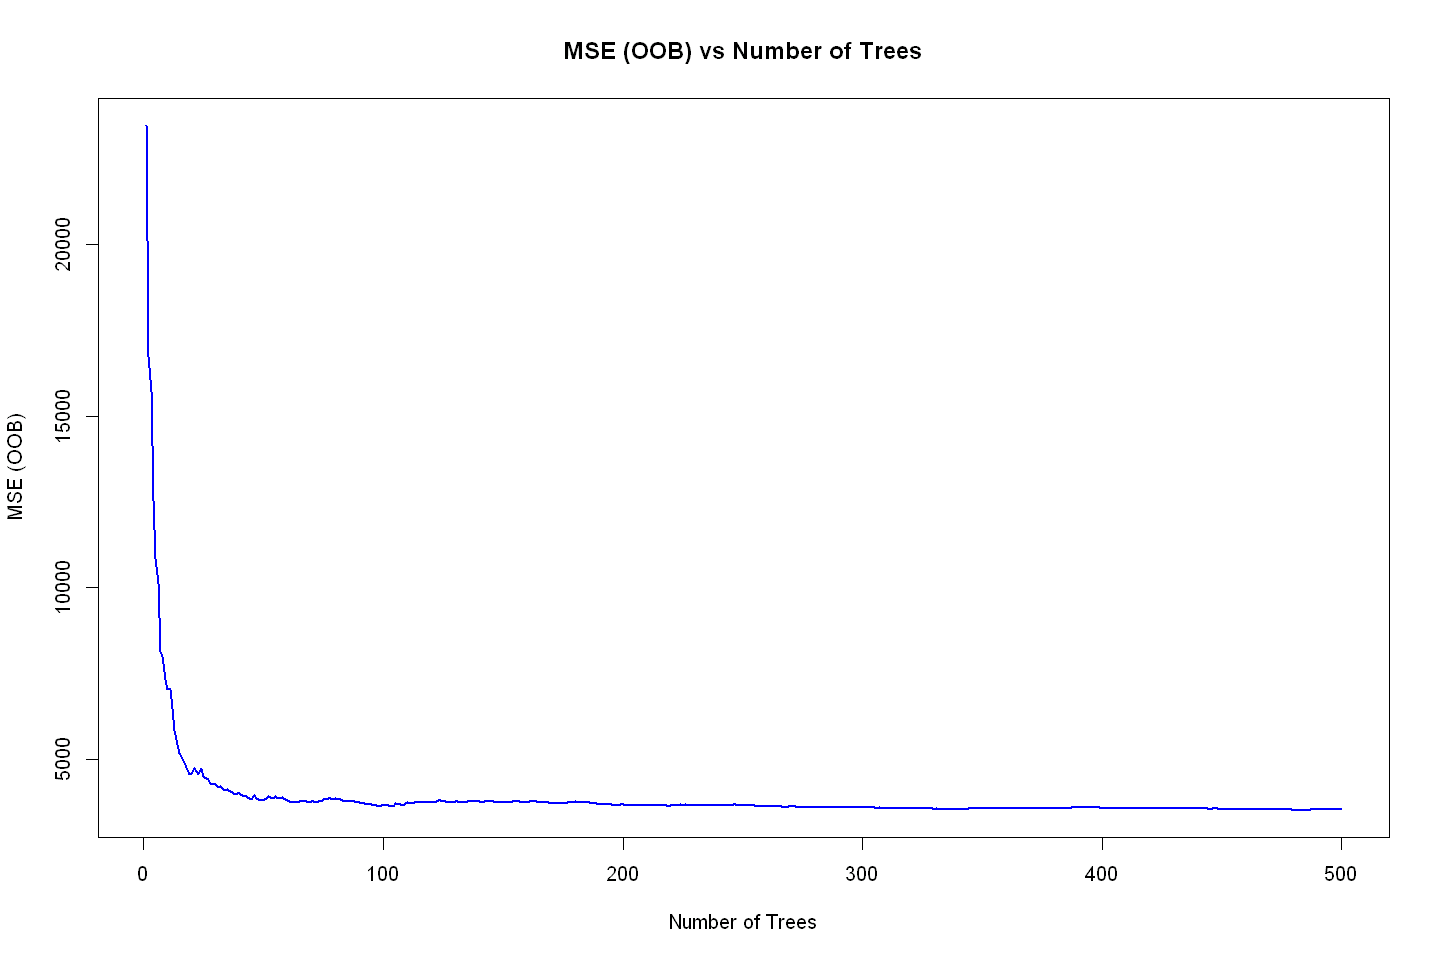

In [199]:
# Plot MSE OOB as a function of the number of trees
options(repr.plot.width=12, repr.plot.height=8)
plot(rf.reg.cal$mse, type = "l", col = "blue", lwd = 2,
    xlab = "Number of Trees", ylab = "MSE (OOB)",
    main = "MSE (OOB) vs Number of Trees")

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

**Paramètres à optimiser** : 
- `mtry`, le nombre de variables tirées aléatoirement à chaque split.
    - **Empiriquement** il est choisi par `mtry ≈ p/3` en régression ou `p` est le nombre total de variables. Ici `p = 14` donc `mtry` vaut logiquement 4.
    - L'optimisation du `mtry` va être réalisé avec la fonction tuneRF qui cherche en partant du `mtry = p/3 = 4` et va essayer avec un mtry plus petit ou plus grand selon comment varie l'erreur de généralisation Out-Of-Bag (OOB). Il s'arrête dès qu'une amélioration de cette erreur OOB est inférieure à 5% (par défaut).
- `ntree`, le nombre d'arbre dans la forêt. Il varie de 100 à 500 et les gains sont marginaux au-delà.

##### Optimisation du `mtry`

mtry = 4  OOB error = 3843.182 
Searching left ...
mtry = 2 	OOB error = 8592.283 
-1.235721 0.01 
Searching right ...
mtry = 8 	OOB error = 2216.763 
0.423196 0.01 
mtry = 13 	OOB error = 2064.615 
0.06863485 0.01 
Time taken for random forest tuning:  4.837774  seconds


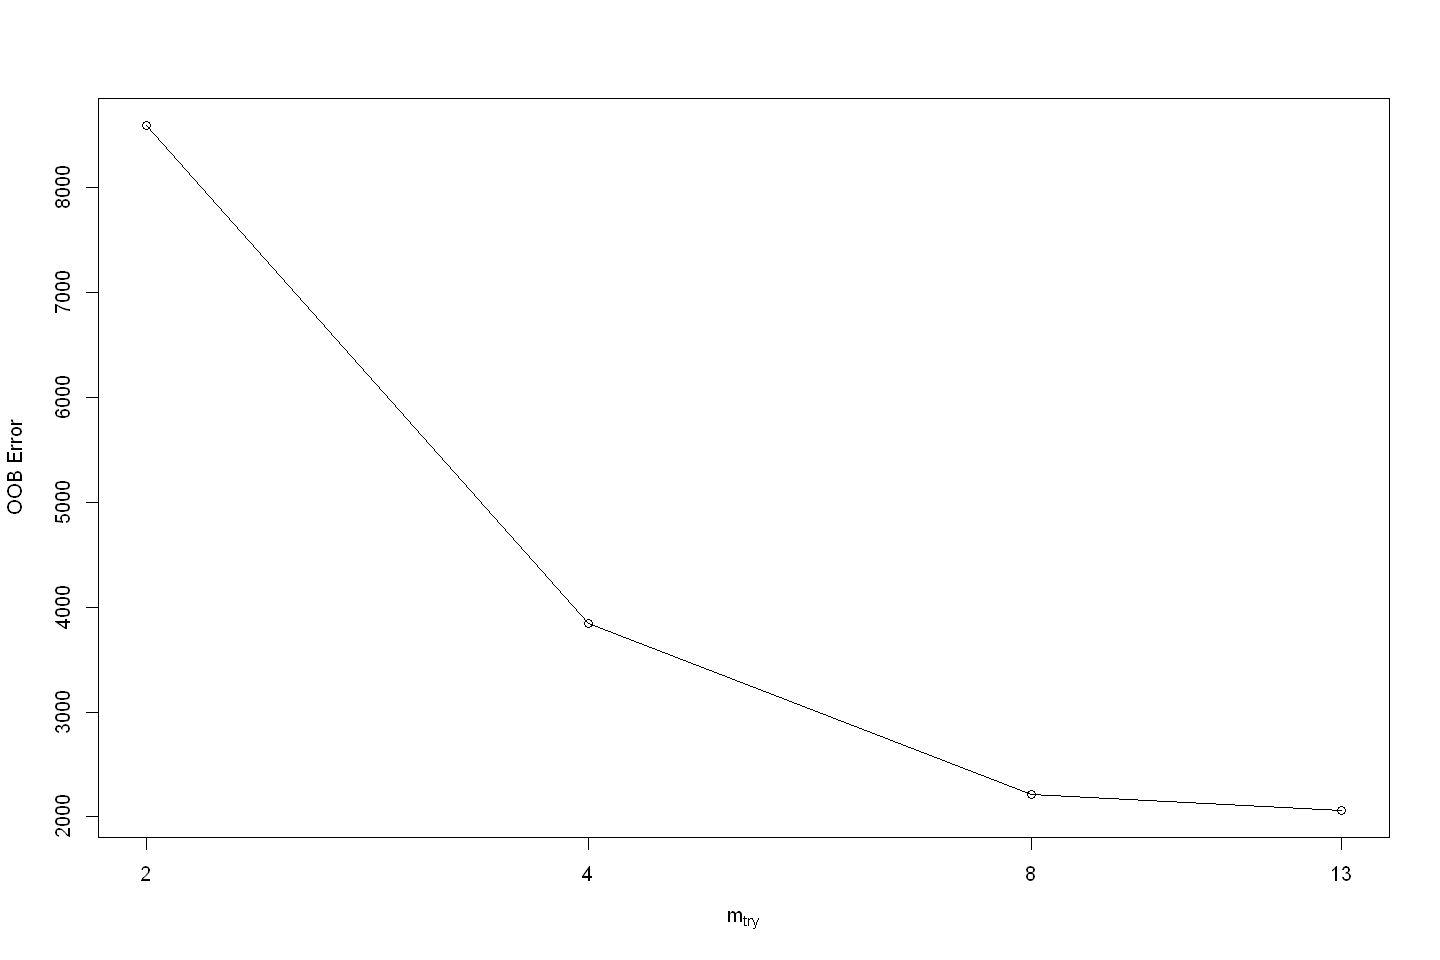

In [203]:
options(repr.plot.width=12, repr.plot.height=8)
t0 <- Sys.time()
rf.reg.cal.tune <- tuneRF(gym_train[,-9], gym_train[,9], ntreeTry = 100,
 improve = 0.01, trace = 50, doBest = TRUE, xtest = gym_test[, -9],
  ytest = gym_test[, "Calories_Burned"])
t1 <- Sys.time()
cat("Time taken for random forest tuning: ", t1 - t0, " seconds\n")

In [201]:
cat("mtry optimal = ", rf.reg.cal.tune$mtry, "\n")

res.rf.cal <- rf.reg.cal.tune$predicted
r2.rf.cal.train <- 1 - mean(res.rf.cal^2) / tss_cal

res.rf.cal.test <- rf.reg.cal.tune$test$predicted
rss.rf.cal.test <- sum((res.rf.cal.test - gym_test[,"Calories_Burned"])^2)
r2.rf.cal.test <- 1 - rss.rf.cal.test / tss_cal

cat("R2 train :", r2.rf.cal.train, "\n")
cat("R2 test :", r2.rf.cal.test)

mtry optimal =  13 
R2 train : 0.9328302 
R2 test : 0.9780771

In [202]:
cat("OOB MSE train:", mean(rf.reg.cal.tune$mse))
cat("\nMSE test:", mean(rf.reg.cal.tune$test$mse))
cat("\nAmelioration de l'OOB MSE train:", abs(mean(rf.reg.cal.tune$mse) - mean(rf.reg.cal$mse)), "\n")
cat("Amelioration du MSE test:", abs(mean(rf.reg.cal.tune$test$mse) - mean(rf.reg.cal$test$mse)), "\n")

OOB MSE train: 2090.822
MSE test: 1570.011
Amelioration de l'OOB MSE train: 1783.247 
Amelioration du MSE test: 1833.186 


Après optimisation du `mtry`, le R² train et test sont très bons et l'amélioration de l'erreur OOB et du MSE sur l'échantillon de test est significative.

Le `mtry` optimal trouvé par l'algorithme est **13**. Or le nombre de prédicateurs dans notre jeu de données est 13. 
L'alogrithme a donc utilisé tous les prédicteurs pour construire chaque arbre. Cela pourraît indiquer que peu de prédicteurs sont réellement importants pour la prédiction. En effet, si chaque arbre de la forêt a besoin de comparer tous les prédicateurs, c'est qu'il doit sûrement choisir les mêmes à chaque fois, et ce peu importe l'échantillon boostrap choisi. Cela est à vérifier avec l'importance des variables.

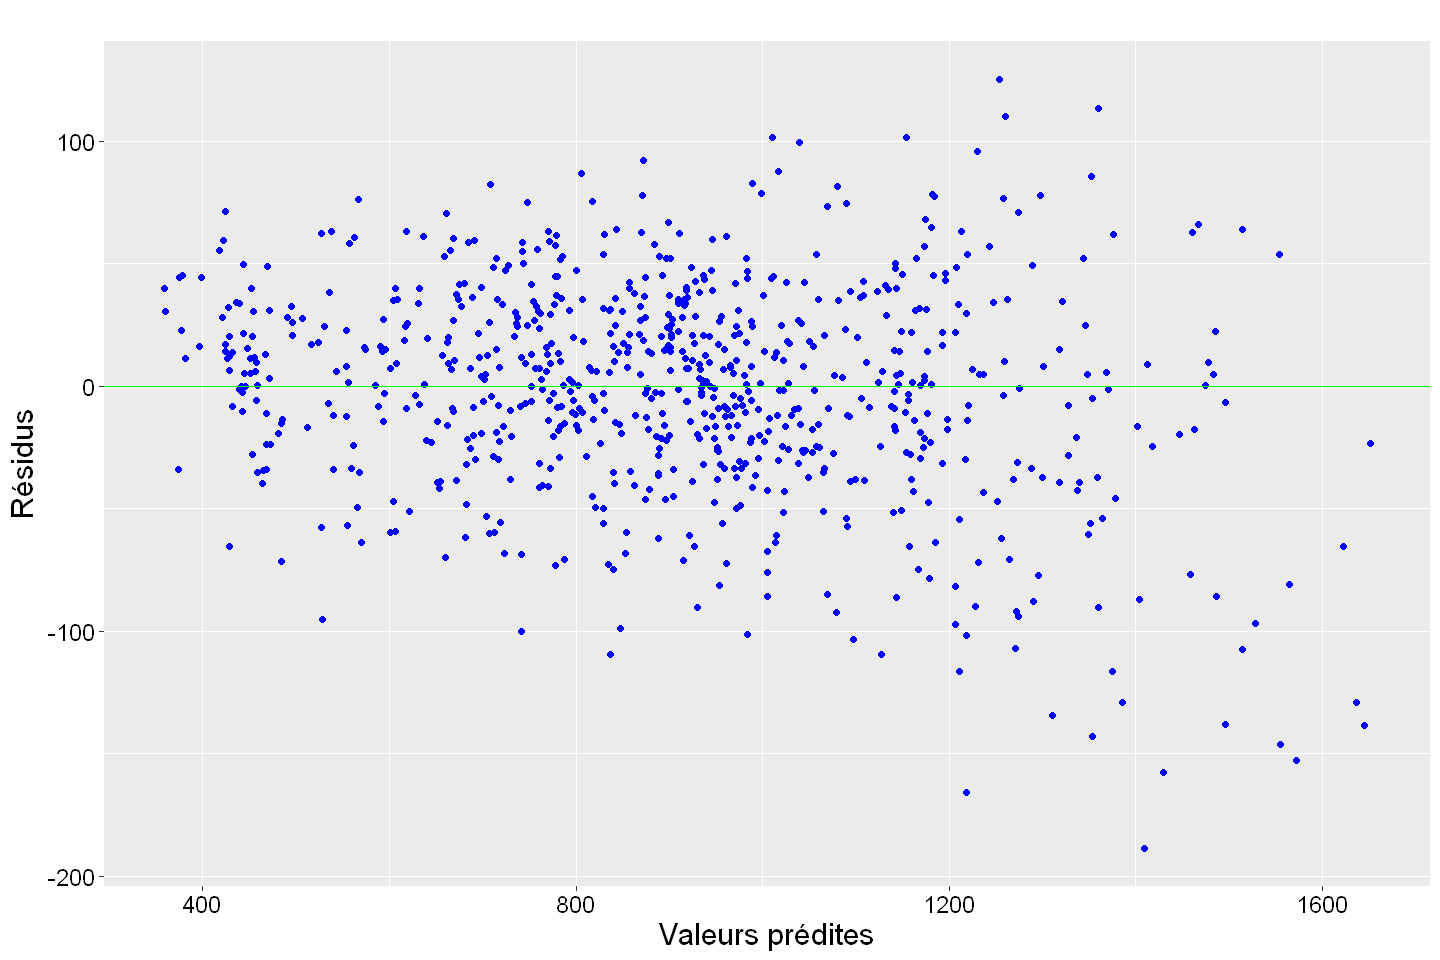

In [204]:
fit.rf.cal.tune <- rf.reg.cal.tune$predicted
res.rf.cal.tune <- fit.rf.cal.tune - gym_train[,"Calories_Burned"]
gplot.res(fit.rf.cal.tune, res.rf.cal.tune, titre="")

**Interprétation** : Le graphique des résidus révèle une performance inégale du modèle selon l’intensité de la dépense calorique. Pour les valeurs modérées (400–1200 calories), les résidus sont centrés et faiblement dispersés ($\pm 100$), attestant d’une prédiction fiable. En revanche, au-delà de 1200 calories, la dispersion des résidus s’accentue significativement, suggérant une difficulté à modéliser les comportements extrêmes. Cette limitation pourrait s’expliquer par la rareté des données pour des séances à dépense calorique ou des interactions non linéaires non capturées. 

Warning message:
"package 'ggRandomForests' was built under R version 4.4.3"
Loading required package: randomForestSRC

Warning message:
"package 'randomForestSRC' was built under R version 4.4.3"



 randomForestSRC 3.3.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: 'randomForestSRC'


The following objects are masked from 'package:e1071':

    impute, tune


The following object is masked from 'package:purrr':

    partial




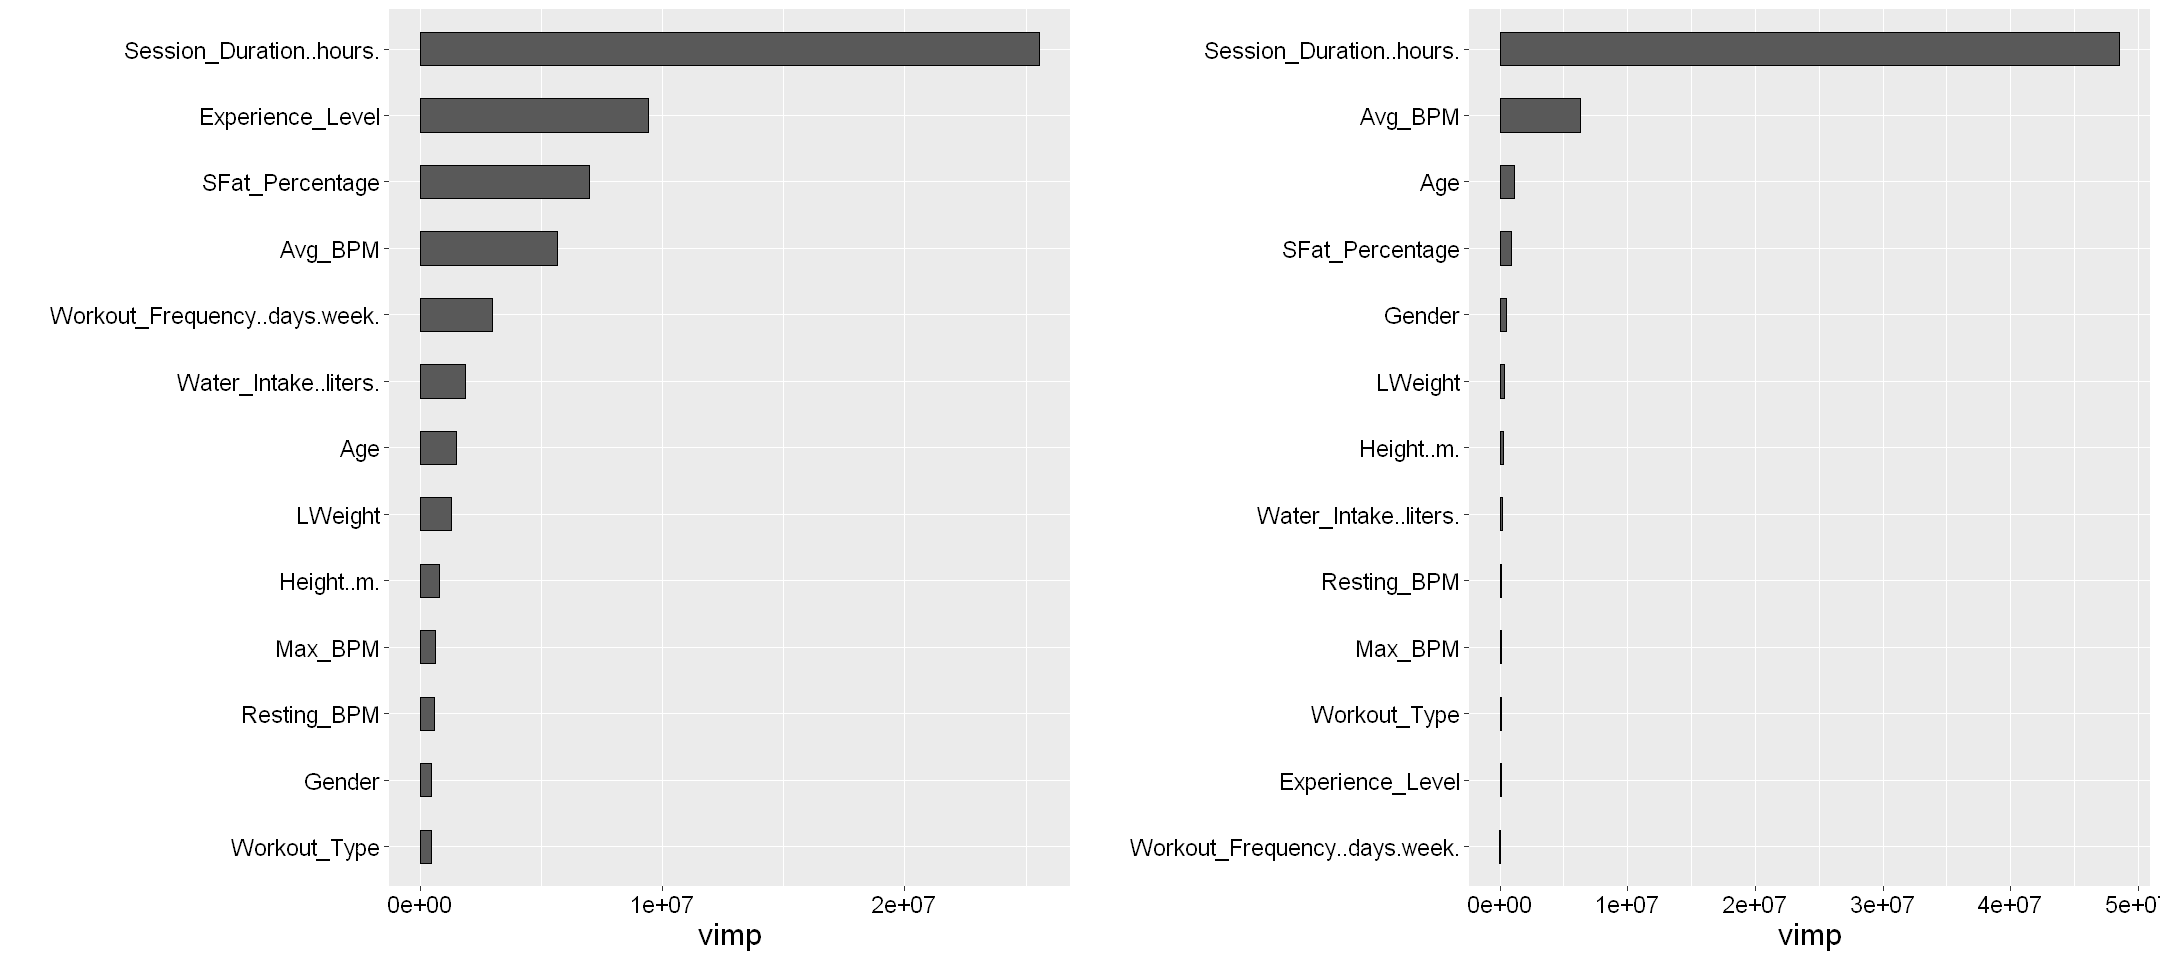

In [205]:
library(ggRandomForests)

options(repr.plot.width=18, repr.plot.height=8)

p1 <- plot(gg_vimp(rf.reg.cal), main = "Importance des variables (mtry = 4)")
p2 <- plot(gg_vimp(rf.reg.cal.tune), main = "Importance des variables (mtry = 13)")

grid.arrange(p1, p2, ncol = 2)
rm(p1, p2)

La comparaison des forêts avec `mtry=4` et `mtry=13` révèle que :
- les prédicateurs `Session_Duration` et `Avg_BPM` sont si fortement liés à la variable cible qu'ils sont selectionnés systématiquement, même lorsque toutes les variables sont disponibles. Ce comportement rappelle les modèles linéaires (Ridge et Lasso) où seules ces variables sont retenues à forte régularisation.
- `Experience_Level` et `SFat_Percentage` n’émergent qu’avec `mtry=4`, suggérant que leurs effets sont liés à des interactions locales.

Le tuning de `mtry=13` simplifie l’interprétation en isolant deux les variables globales, mais la forêt perd en diversité structurelle (les arbres sont plus similaires). En revanche, elle gagne en stabilité prédictive, indiqué par un R²_test = 0.98 et R²_train = 0.92 et une amélioration significative de l'erreur OOB et du MSE sur l'échantillon de test.

Nous allons desormais visualiser les effet marginaux de ces variables sur la prédiction du modèle.

Warning message:
"package 'pdp' was built under R version 4.4.3"



Attaching package: 'pdp'


The following object is masked from 'package:randomForestSRC':

    partial


The following object is masked from 'package:purrr':

    partial




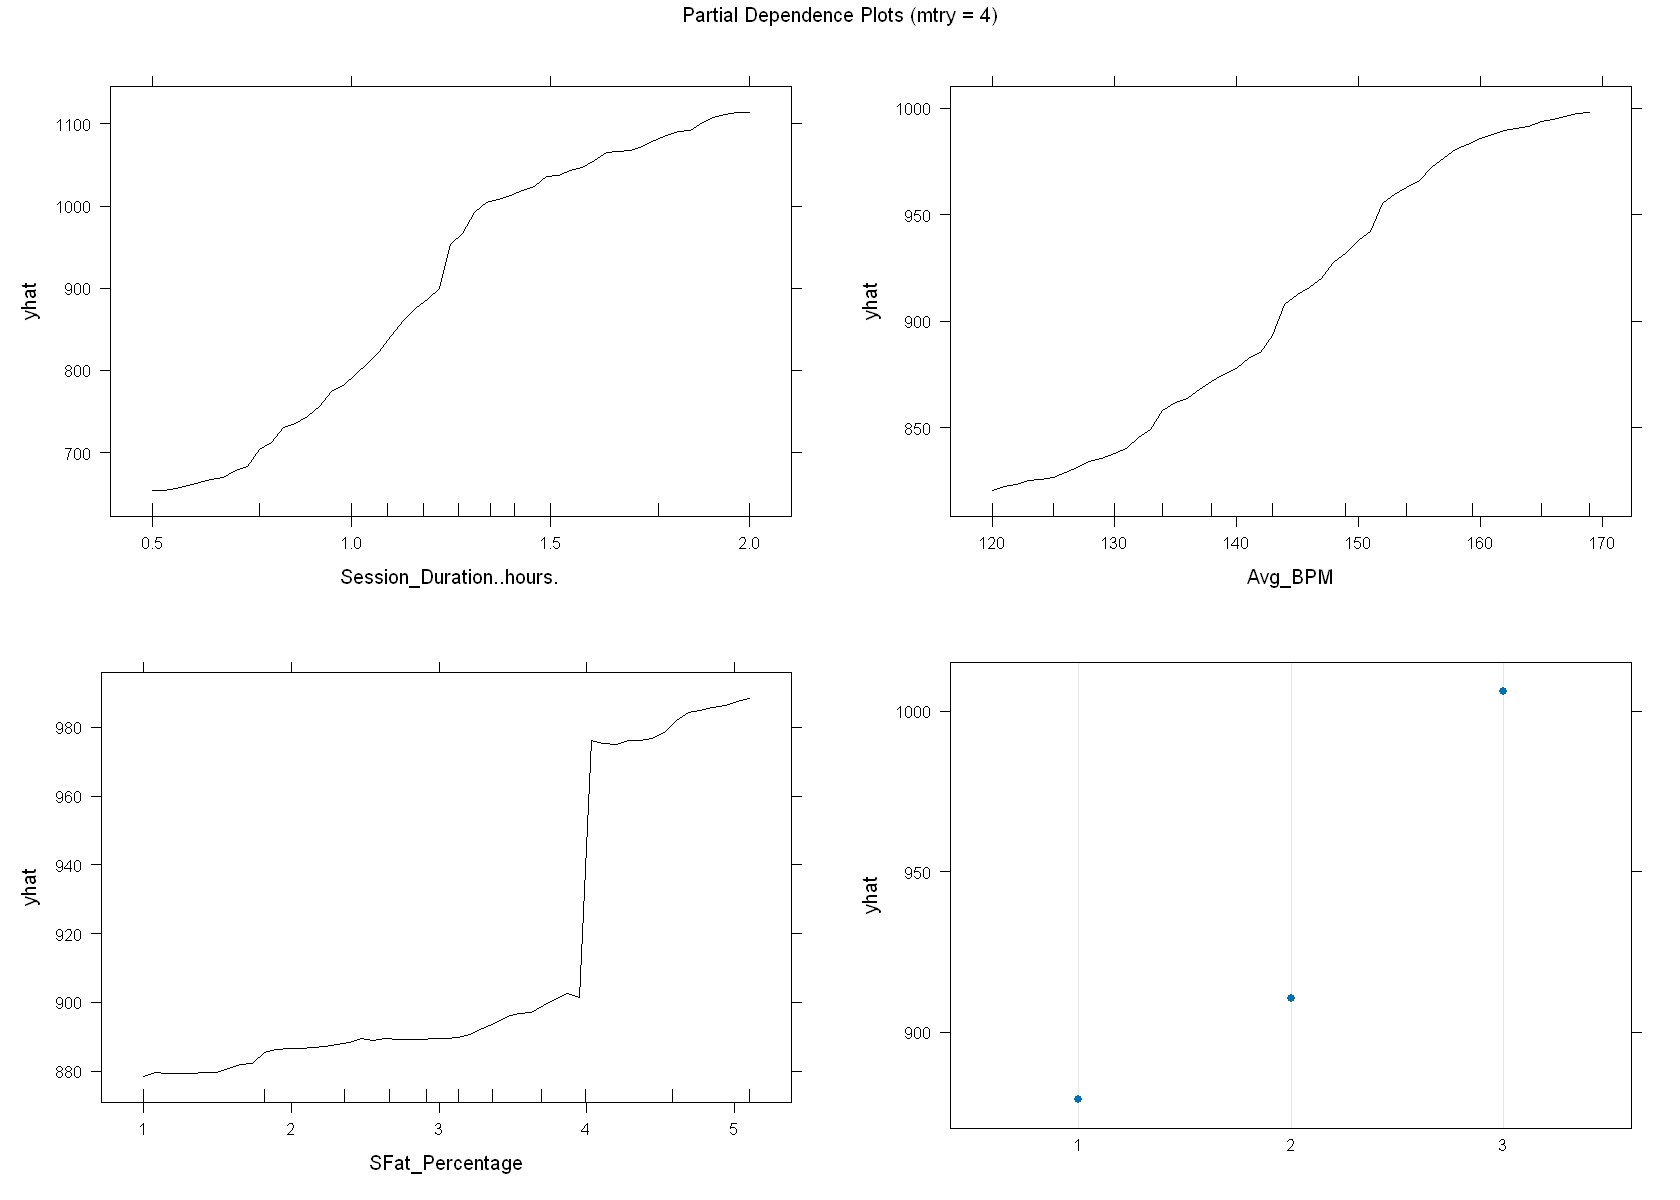

In [206]:
library(pdp)
p1 <- partial(rf.reg.cal, pred.var = "Session_Duration..hours.", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p2 <- partial(rf.reg.cal, pred.var = "Avg_BPM", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p3 <- partial(rf.reg.cal, pred.var = "SFat_Percentage", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p4 <- partial(rf.reg.cal, pred.var = "Experience_Level", plot = TRUE, rug = TRUE, train=gym_train, type="auto")

options(repr.plot.width=14, repr.plot.height=10)
main = "Partial Dependence Plots (mtry = 4)"
grid.arrange(p1, p2, p3, p4, ncol = 2, top = main)
rm(p1, p2, p3, p4)

**Interpretation des effets marginaux pour `mtry=4`** :

**Effet de `Session_Duration`** : La relation entre la durée de la session et la dépense calorique est positive, avec une pente décroissante. Cela suggère que les premières heures d'entraînement ont un rendement calorique élevé, mais au delà de 1h30 de séance, l'augmentation marginale de la dépense diminue avec le temps. Ce phénomène pourrait être dû à la fatigue ou à l'adaptation physiologique des individus à l'exercice prolongé.

**Effet de `Avg_BPM`** : La frequence cardiaque semble moyenne doit dépasser un certain seuil pour maximiser la dépense énergitique (140-160 bpm). En revanche, on retrouve un léger **effet de plateau** au delà de 160 bpm, suggérant que la dépense calorique n'augmente plus significativement à des niveaux d'intensité cardiaque extrêmes. Cela pourrait être dû aux limites physiologiques du corps humain.

**Effet de `Experience_Level`** : L'expérience des individus a un impact significatif sur la dépense calorique. Les débutants (niveau 1) et intermédiares (niveau 2) ont des dépenses caloriques similaires, mais les experts (niveau 3) semblent avoir une dépense calorique plus élevée. Cela pourrait s'expliquer par une meilleure efficacité de l'entraînement chez les individus expérimentés, qui brûlent plus de calories à un rythme similaire.

**Effet de `SFat_Percentage`** : La transformation appliquée à `Fat_Percentage` (sqrt(max + 1 - x)) complexifie l’interprétation directe. Le pic observé à `SFATPercentage=4` pourrait correspondre à un taux de graisse corporelle optimal pour la dépense énergétique, mais une analyse avec la variable originale est nécessaire pour confirmer cette hypothèse.

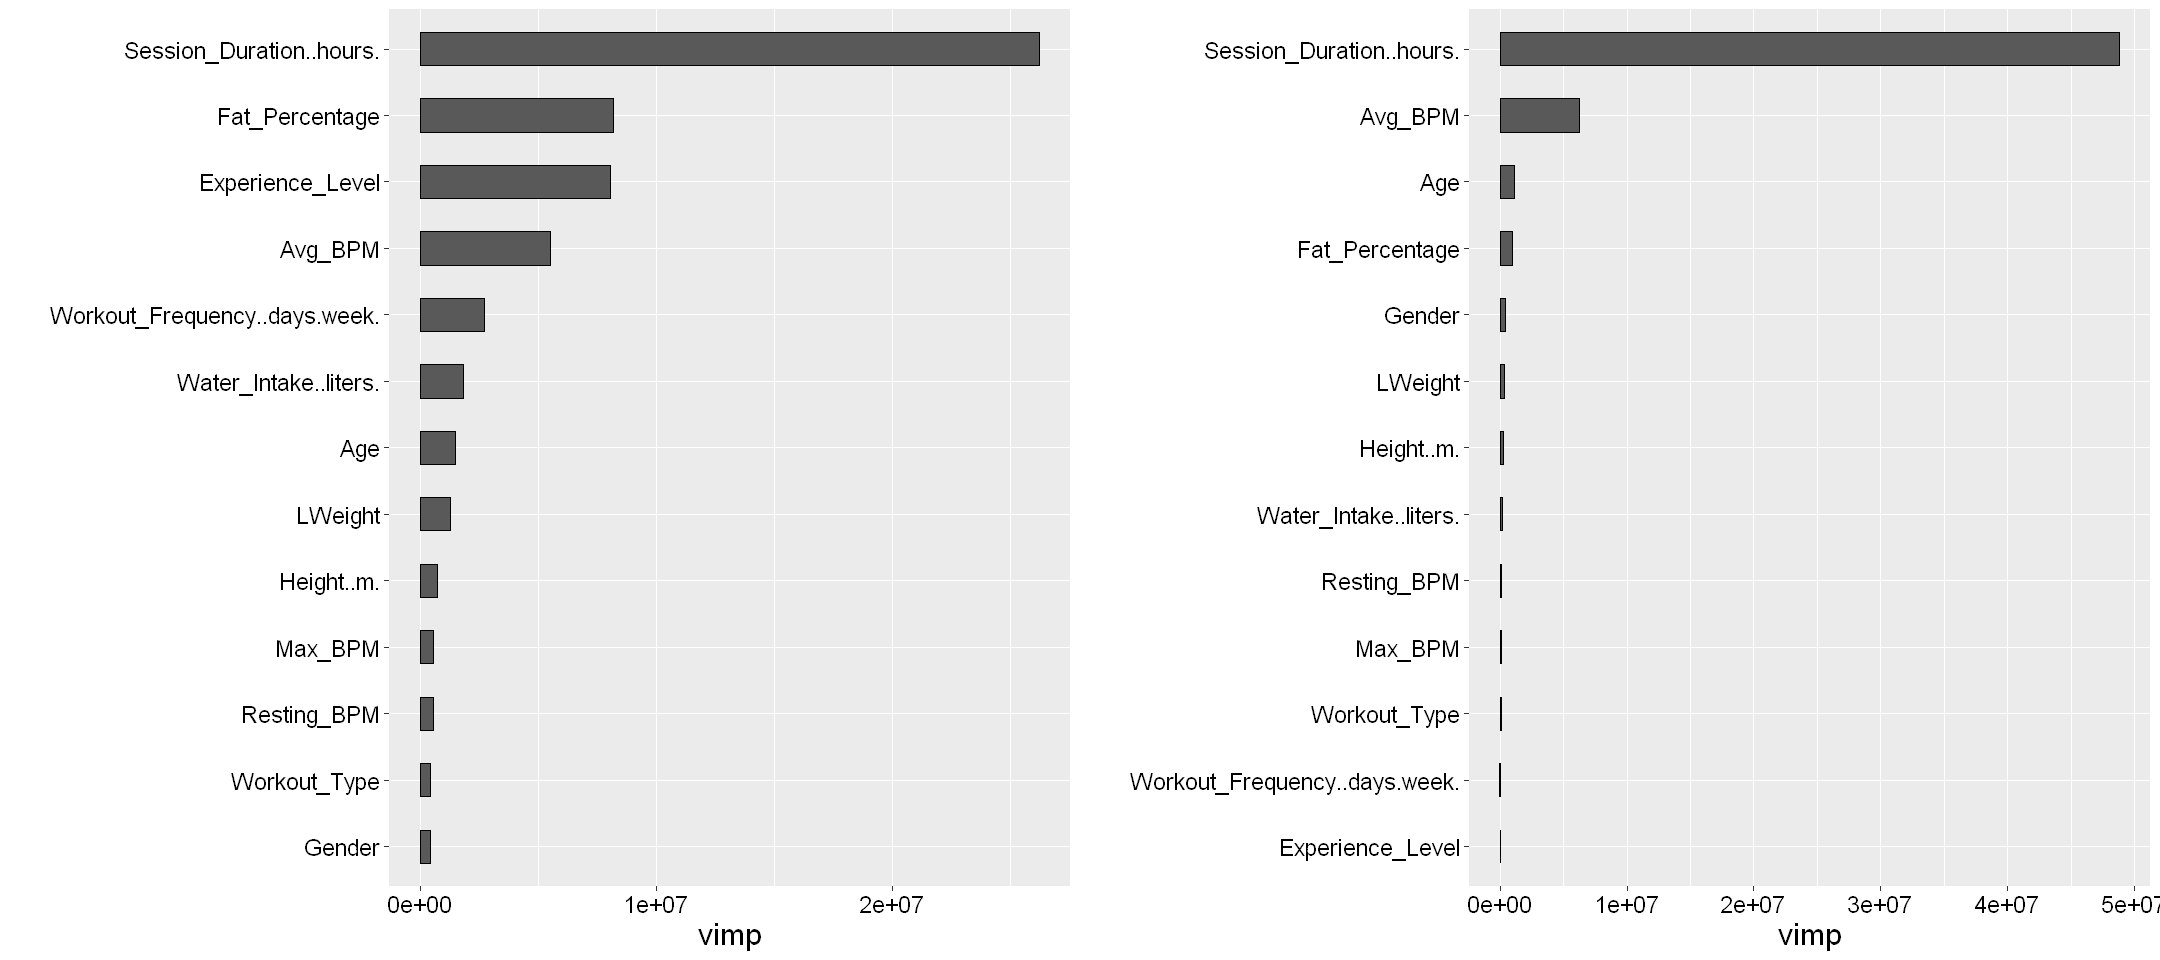

In [207]:
# recreate fat percentage
gym_train[,"Fat_Percentage"] <- (max_fat + 1) - gym_train[,"SFat_Percentage"]^2
gym_test[,"Fat_Percentage"] <- (max_fat + 1) - gym_test[,"SFat_Percentage"]^2

rf.reg.cal.fat_percentage <- randomForest(Calories_Burned ~ ., data = gym_train[, -11],
 xtest = gym_test[, -c(9, 11)], ytest = gym_test[, "Calories_Burned"],
 ntree=500,importance=TRUE, keep.forest = TRUE)

rf.reg.cal.fat_percentage.tune <- randomForest(Calories_Burned ~ ., data = gym_train[, -11],
 ntree=500, mtry=13,
 xtest = gym_test[, -c(9, 11)], ytest = gym_test[, "Calories_Burned"],
 importance=FALSE, keep.forest = TRUE)

# Partial dependence plot for Fat_Percentage
options(repr.plot.width=18, repr.plot.height=8)
# partial(rf.reg.cal.fat_percentage, pred.var = "Fat_Percentage",   rug = TRUE, train=gym_train, type="regression")
p1<-plot(gg_vimp(rf.reg.cal.fat_percentage), main = "Importance des variables (mtry = 4)")
p2<-plot(gg_vimp(rf.reg.cal.fat_percentage.tune), main = "Importance des variables (mtry = 13)")

grid.arrange(p1, p2, ncol = 2)
rm(p1, p2)

**Vérification** : On retrouve bien les même niveaux d'importance de nos variables en ayant interchangé `SFat_Percentage` par `Fat_Percentage` dans le modèle.

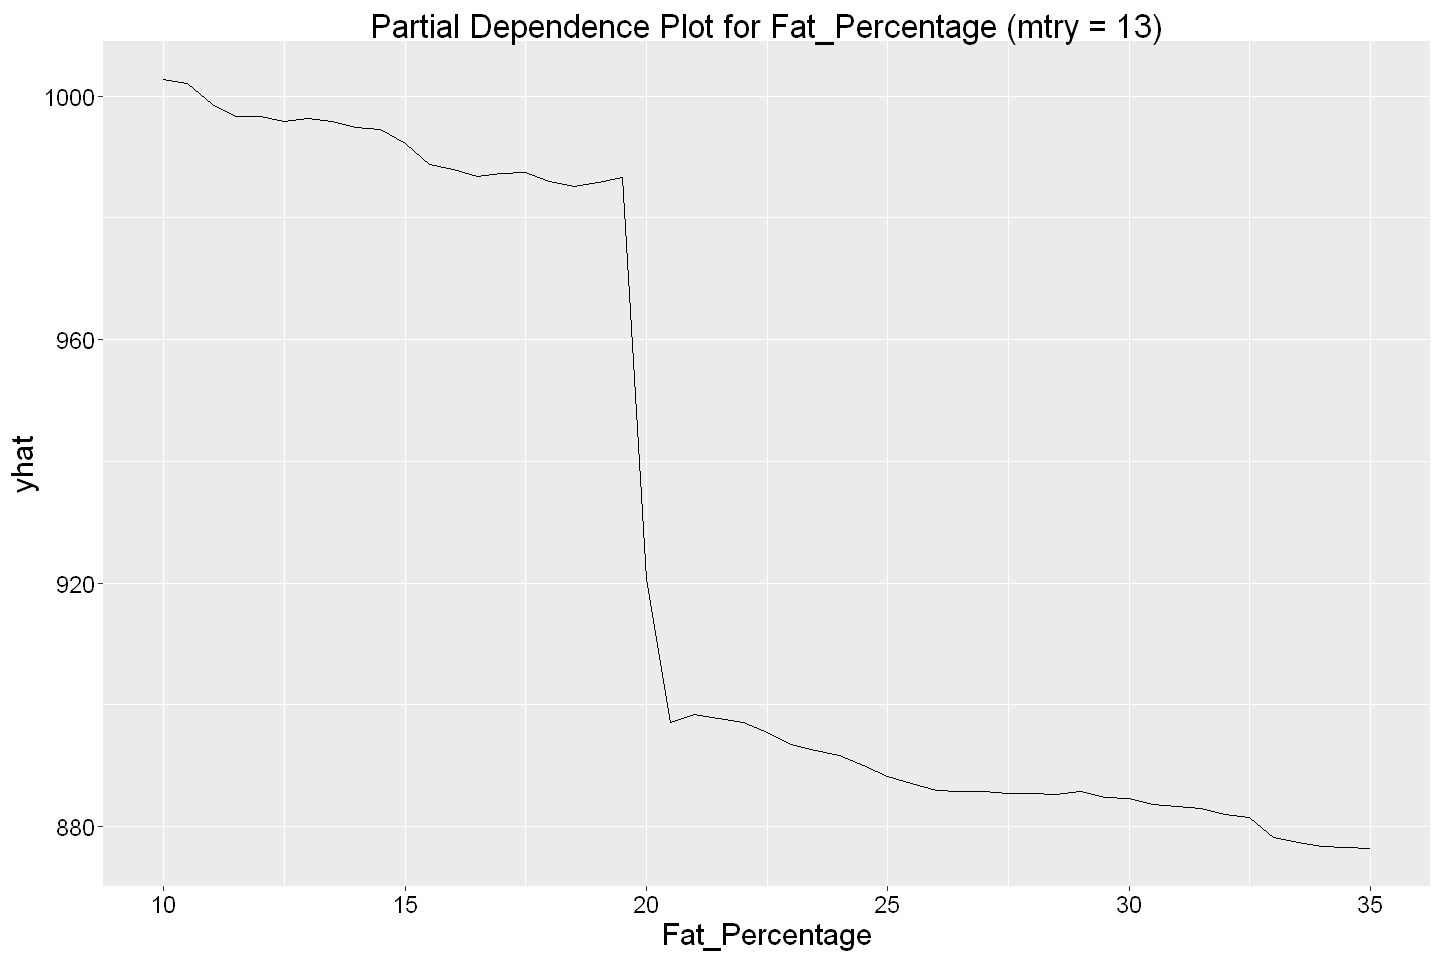

In [211]:
options(repr.plot.width=12, repr.plot.height=8)
autoplot(partial(rf.reg.cal.fat_percentage, pred.var = "Fat_Percentage", rug = TRUE, train=gym_train[], type="regression"),
        main = "Partial Dependence Plot for Fat_Percentage (mtry = 13)")

# delete Fat_Percentage
gym_train$Fat_Percentage <- NULL
gym_test$Fat_Percentage <- NULL


**Interprétation** :

La transformation appliqué à SFat_Percentage inverse artificiellement son echelle :

$$
\text{SFatPercentage} = \sqrt{\max(\text{FatPercentage}) + 1 - \text{FatPercentage}}
$$

Ainsi une valeur élevée de `SFat_Percentage` correspond à un faible taux de masse grasse et inversement.

La forêt detecte une relation **non linéaire** entre le taux de masse grasse et la dépense calorique. On distingue deux groupes d'individus :

- Ceux avec un taux de masse grasse compris entre 10 et 20%.
- Ceux avec un taux de masse grasse compris entre 20 et 35%.

Les individus entre 10 et 20% brûlent environ 100 calories de plus que ceux avec un taux de masse grasse entre 20 et 35%.

Avant d'interpréter ce résultat, il faut observer que la foret avec un `mtry=13` n'a retenu que 2 variables : `Session_Duration` et `Avg_BPM`. Pour rappel, comme on a pu le voir dans l'analyse descriptive et lors de l'Analyse en Composante Principales, la variable `Fat_Percentage` est fortement négativement corrélée avec `Session_Duration`. Sur les graphiques des variables de l'ACP, on a pu observer que `Fat_Percentage` était projeté dans la même direction que `Session_Duration` et `Calories_Burned`. Ce qui montre la redondance entre ces variables pour prédire `Calories_Burned` et donc l'importance de `Session_Duration` pour expliquer la dépense calorique.

**Bilan** : On avait pu déduire que les individus avec un faible taux de masse grasse sont ceux qui s'entraînent le plus longtemps et donc **qui ont la plus forte dépense calorique**. En revanche, les individus avec un taux de masse grasse élevé sont ceux qui s'entraînent le moins longtemps et donc **qui ont la plus faible dépense calorique**. 

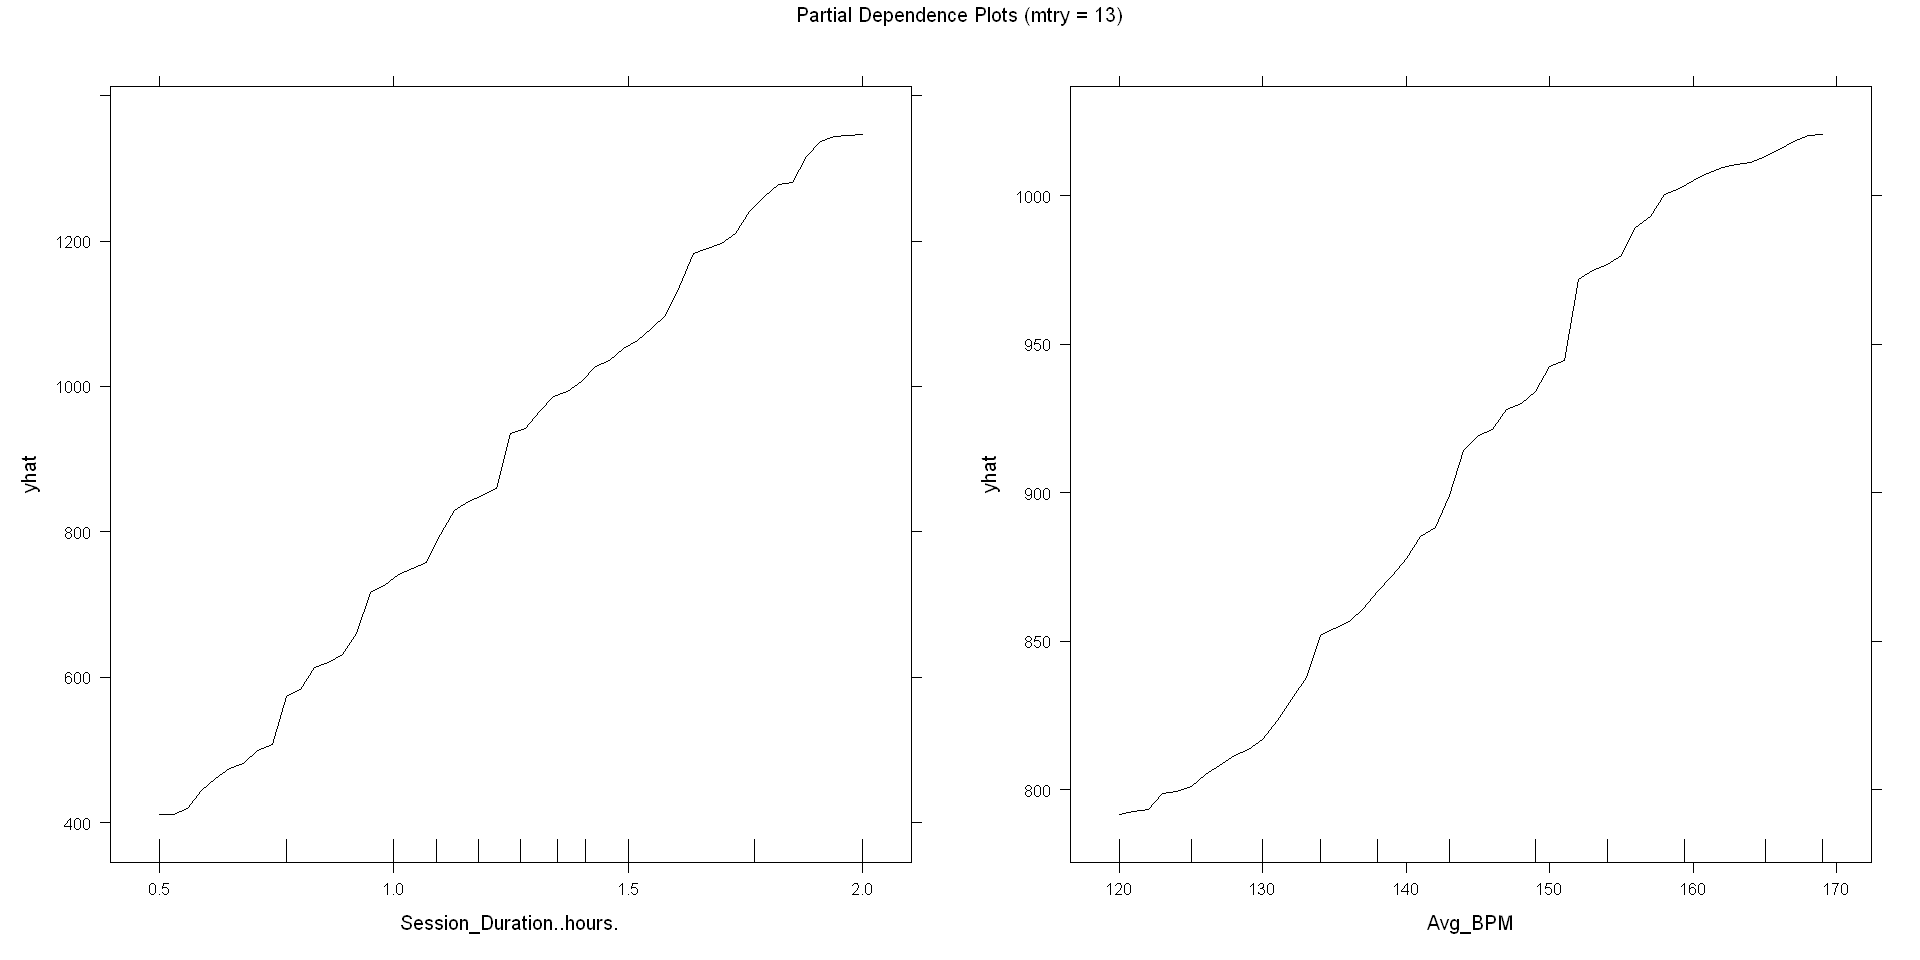

In [213]:
rf.reg.cal.tuned <- randomForest(Calories_Burned ~ ., data = gym_train,
 ntree=100, mtry = 13, importance=TRUE, keep.forest = TRUE)

p1 <- partial(rf.reg.cal.tuned, pred.var = "Session_Duration..hours.", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p2 <- partial(rf.reg.cal.tuned, pred.var = "Avg_BPM", plot = TRUE, rug = TRUE, train=gym_train, type="regression")

options(repr.plot.width=16, repr.plot.height=8)
main = "Partial Dependence Plots (mtry = 13)"
grid.arrange(p1, p2, ncol = 2, top = main)
rm(p1, p2)

**Interprétation** : 

Le nombre de calories brulées par séance est linéarement lié à la durée de la séance, avec un delta significatif de ~1000 calories entre les séances de 30 minutes et celles de 2h. Pour ce qui est de la fréquence cardiaque moyenne de la séance, on observe la même relation que précedemment, avec un delta plus faible (~200 calories) entre les séances à 120 bpm et celles à 160 bpm.

#### Boosting
Pour améliorer la performance du modèle, nous allons utiliser le boosting, qui consiste à ajuster les erreurs des arbres précédents en ajoutant de nouveaux arbres. Le boosting est particulièrement efficace pour réduire le biais et améliorer la précision des prédictions.

##### Avec la librairie `gbm`

Warning message:
"package 'gbm' was built under R version 4.4.3"
Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



Time taken for boosting:  13.3354  seconds


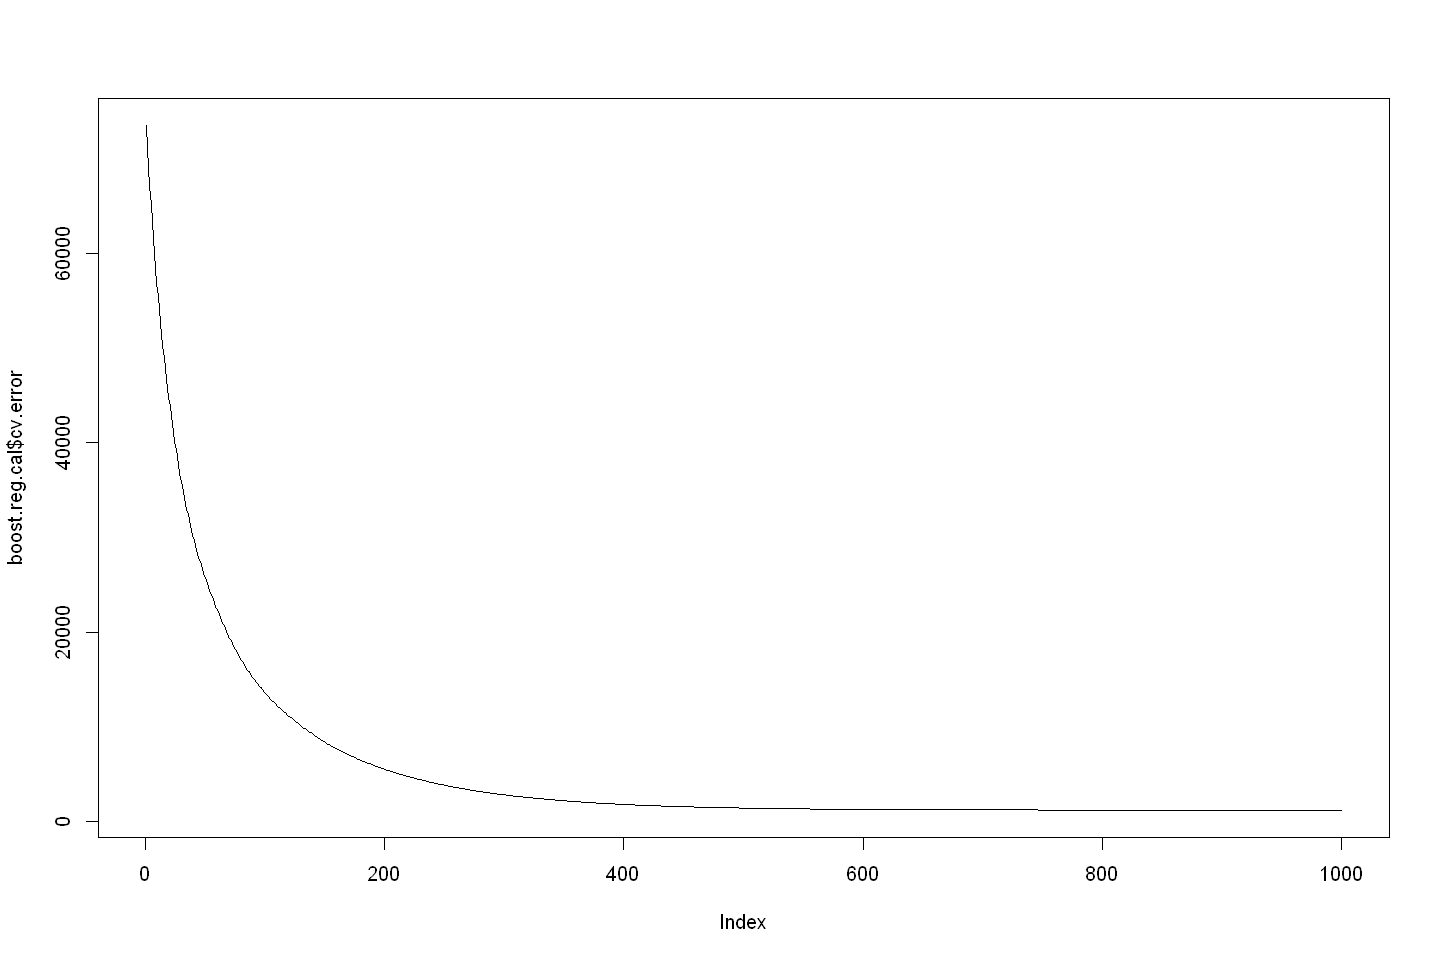

In [214]:
library(gbm)
options(repr.plot.width=12, repr.plot.height=8)
t0 <- Sys.time()
boost.reg.cal = gbm(Calories_Burned ~ ., data = gym_train, distribution = "gaussian", n.trees = 1000, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
t1 <- Sys.time()
cat("Time taken for boosting: ", t1 - t0, " seconds\n")
# verbose à FALSE pour éviter trop de sorties
plot(boost.reg.cal$cv.error, type = "l")

Best performance at iteration:  922 
Best performance (CV error):  1220.81 


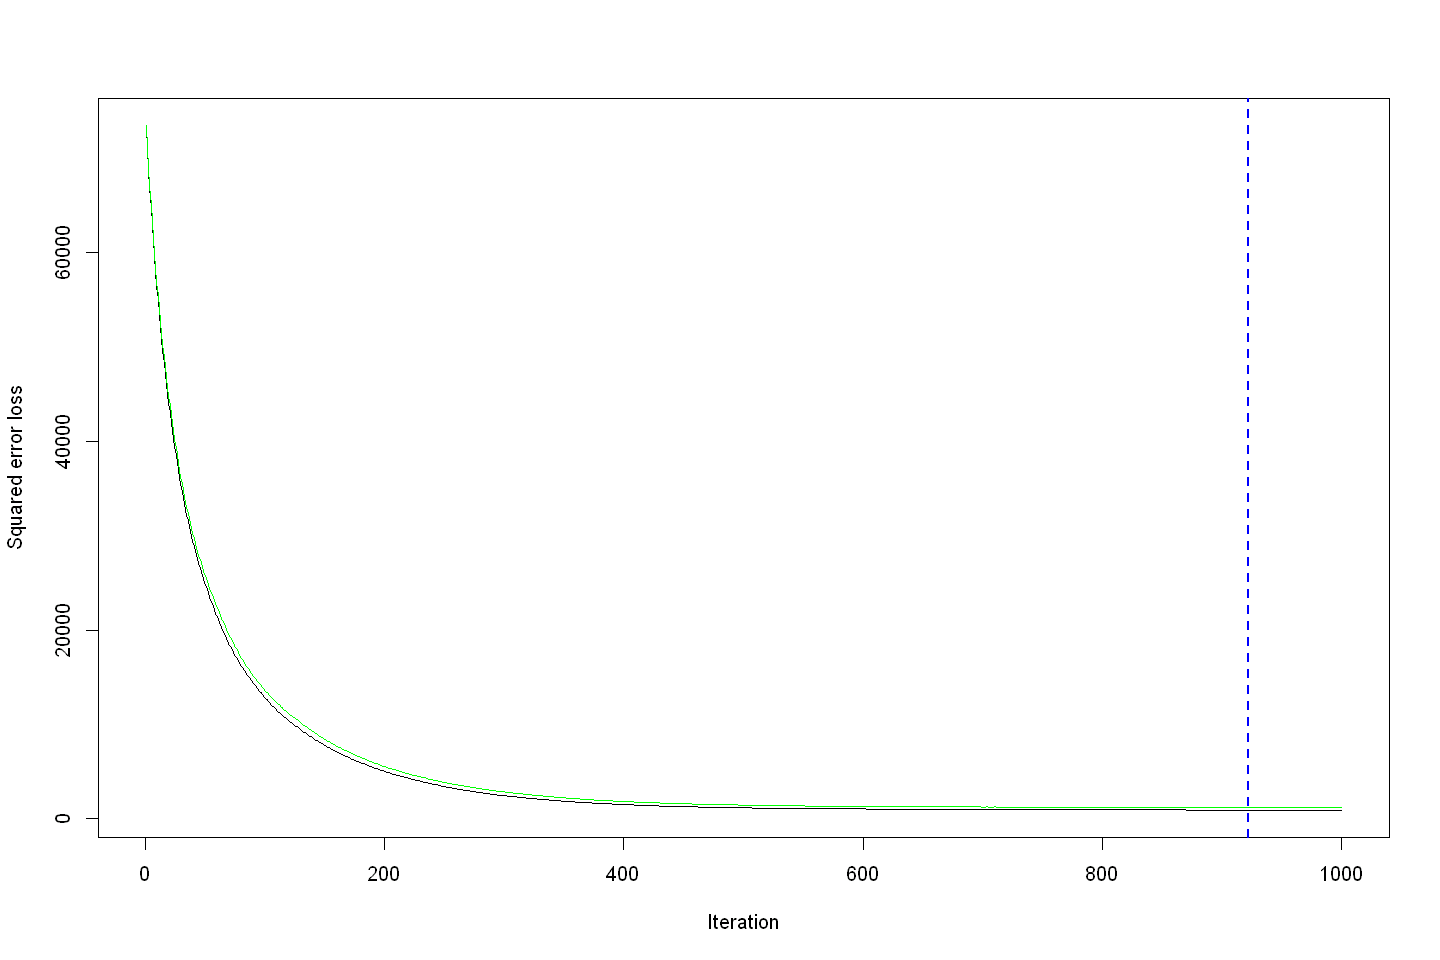

In [ ]:
best.iter <- gbm.perf(boost.reg.cal, method="cv")
cat("Best performance (CV error): ", min(boost.reg.cal$cv.error), "\n")

Time taken for grid search:  28.59538  seconds
Stochastic Gradient Boosting 

779 samples
 13 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 622, 624, 623, 624, 623 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  RMSE      Rsquared 
  0.01       1                  10               400     99.00823  0.9144422
  0.01       1                  10               800     58.84562  0.9675572
  0.01       1                  10              1000     48.97181  0.9753027
  0.01       1                  20               400     99.38495  0.9123045
  0.01       1                  20               800     59.87551  0.9658570
  0.01       1                  20              1000     50.22181  0.9736888
  0.01       3                  10               400     50.64958  0.9789792
  0.01       3                  10               800     22.67208  0.9942749
  0.01       3                  10              10

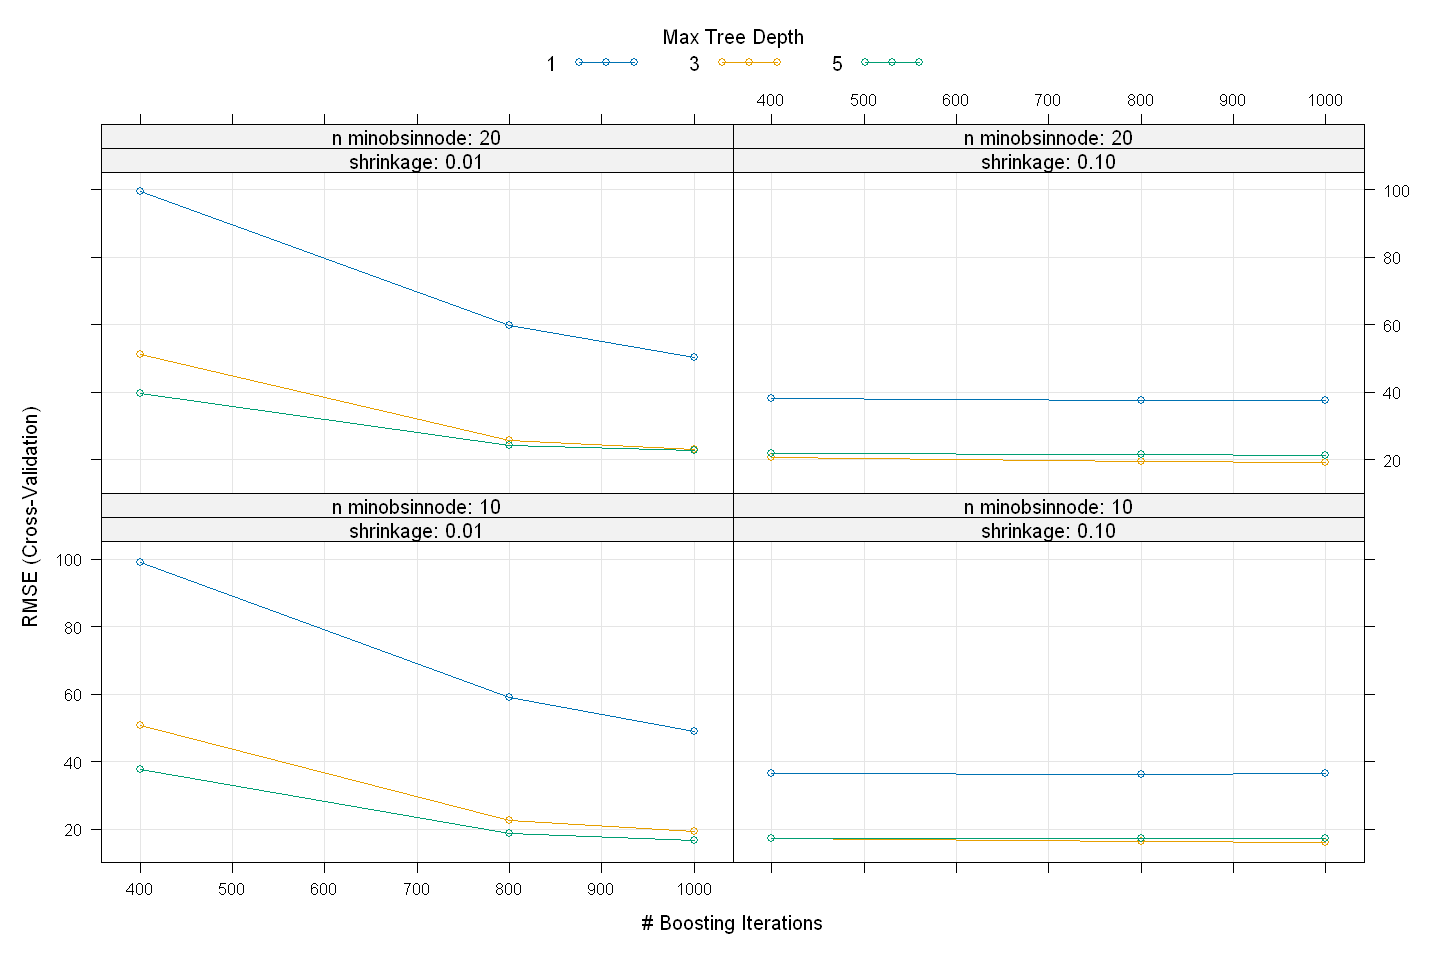

In [218]:
library(caret)
library(gbm)
library(dplyr)

# Définir la grille d'hyperparamètres
grid <- expand.grid(
  n.trees = c(400, 800, 1000), # Nombre d'arbres
  interaction.depth = c(1, 3, 5), # Profondeur max des arbres
  shrinkage = c(0.01, 0.1), # learning rate
  n.minobsinnode = c(10, 20) # Nombre minimum d'observations dans les nœuds terminaux
)

# Contrôle de validation croisée
ctrl <- trainControl(method = "cv", number = 5)

# Grid Search via caret::train
set.seed(123)
t0 <- Sys.time()
boost.reg.cal <- train(
  Calories_Burned ~ .,
  data = gym_train,
  method = "gbm",
  trControl = ctrl,
  tuneGrid = grid,
  verbose = FALSE
)
t1 <- Sys.time()
cat("Time taken for grid search: ", t1 - t0, " seconds\n")

# Résultats
print(boost.reg.cal)
plot(boost.reg.cal)


In [222]:
best_result <- semi_join(boost.reg.cal$results, boost.reg.cal$bestTune, 
                         by = c("n.trees", "interaction.depth", "shrinkage", "n.minobsinnode"))

print(best_result)


  shrinkage interaction.depth n.minobsinnode n.trees     RMSE  Rsquared
1       0.1                 3             10    1000 15.91761 0.9967128
       MAE    RMSESD   RsquaredSD     MAESD
1 12.06274 0.8880248 0.0005429309 0.9301424


In [223]:
# compute MSE and R2 on training and test sets
mse_train <- mean((gym_train$Calories_Burned - predict(boost.reg.cal, gym_train))^2)
mse_test <- mean((gym_test$Calories_Burned - predict(boost.reg.cal, gym_test))^2)
r2_train <- 1 - mse_train / var(gym_train$Calories_Burned)
r2_test <- 1 - mse_test / var(gym_test$Calories_Burned)
# cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
# cat("R2 on training set: ", r2_train, "\n")
cat("R2 on test set: ", r2_test, "\n")

MSE on test set:  212.954 
R2 on test set:  0.9969054 


**Interprétation des resultats du Boosting (GBM)** :

**Performance Exceptionnelle** :  
- **R²_test = 0.997** et **MSE_test = 213** : Le modèle explique **99.7%** de la variance des calories brûlées, avec une erreur moyenne de **±14.6 kcal** (√MSE). 
- **Supériorité Claire** : Il surpasse largement la forêt aléatoire (`R²_test=0.978`, `MSE_test=1519`), grâce à sa capacité à **optimiser séquentiellement les erreurs résiduelles** et à capturer des **interactions complexes**.  

**Explication de cette performance** :  
1. **Hyperparamètres Optimaux** :  
   - **`shrinkage=0.1`** (taux d’apprentissage bas) $\rightarrow$ Apprentissage stable et précis.  
   - **`interaction.depth=3`** $\rightarrow$ Abres de profondeur 3, permettant de capturer des interactions complexes sans surajuster.
   - **`n.trees=1000`** $\rightarrow$ Suffisant pour converger sans surapprentissage (grâce au faible `shrinkage`).  
2. **CV Robustesse** :  
   - **RMSE CV = 15.9 ± 0.89** $\rightarrow$ Très faible variabilité entre les folds, signe d’un modèle généralisable.  

**Bilan** :
Ces résultats positionnent **le GBM comme le modèle de référence pour la prédiction de `Calories_Burned`**, surpassant toutes les approches testées précédemment.

Pour aller plus loin, nous allons maintenant :

- Analyser les résidus : Vérifier l’absence de biais systématique même à haute intensité.  
- Feature Importance : Visualiser l'évolution de la prédiction de `Calories_Burned` en fonction des variables les plus explicatives de ce modèle.



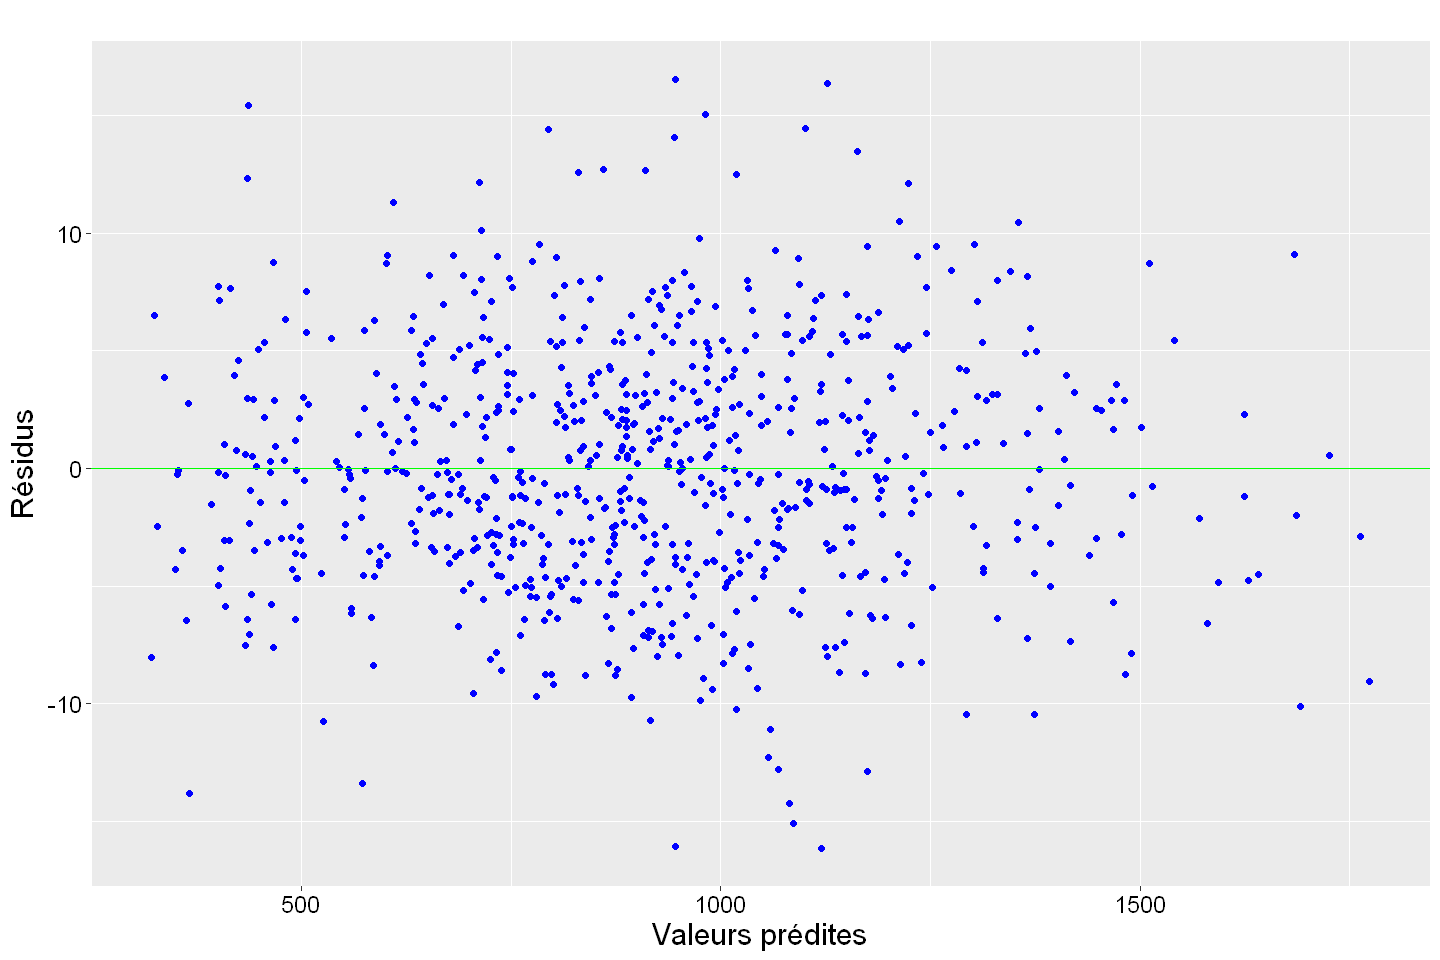

In [224]:
fit.boostr.cal <- boost.reg.cal$finalModel$fit
res.boostr.cal <- fit.boostr.cal - gym_train[,"Calories_Burned"]
gplot.res(fit.boostr.cal, res.boostr.cal, titre="")

**Interprétation des résidus** : Par rapport aux modèles précédents, les résidus du modèle de boosting sont beaucoup plus centrés autour de 0, avec une dispersion maximale de $\pm 20$ calories. On remarque tout de même que :

- la surestimation des valeurs prédites n'a lieu qu'entre 400 et 1500 calories mais pour les extrêmes (< 400 et > 1500 calories), le modèle sous-estime quasi-systemétiquement les calories brulées.


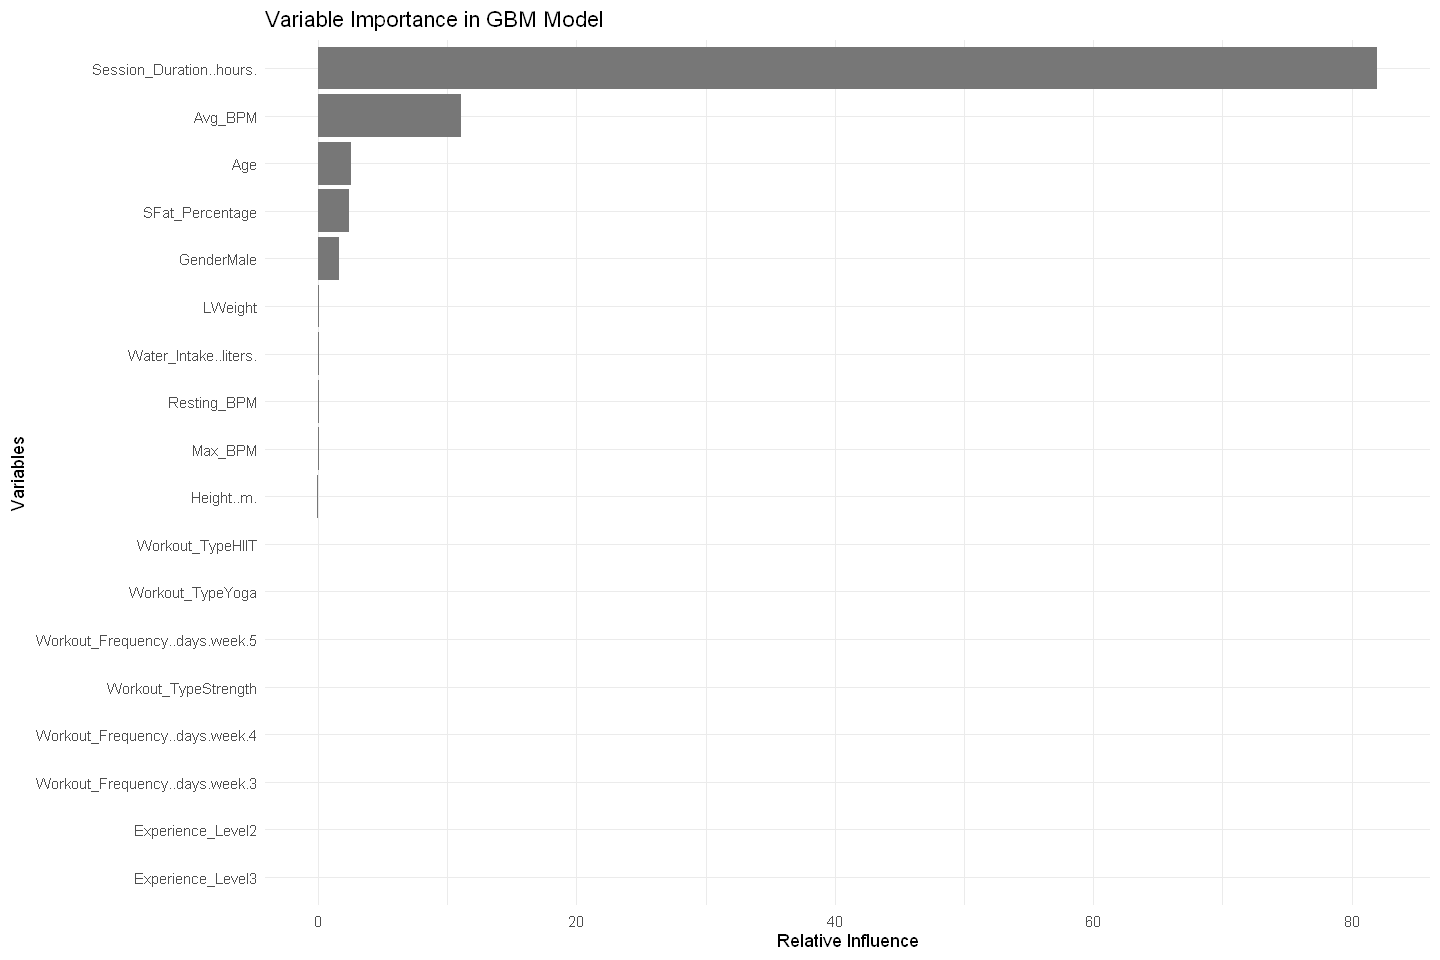

In [229]:
# plot(gg_vimp(importance(boost.reg.cal)))
# Get variable importance from the GBM model
imp <- summary(boost.reg.cal, plotit = FALSE)

# Create a ggplot of variable importance
ggplot(imp, aes(x = reorder(var, rel.inf), y = rel.inf)) +
    geom_bar(stat = "identity", fill = "#777777") +
    coord_flip() +
    labs(x = "Variables", y = "Relative Influence", 
             title = "Variable Importance in GBM Model") +
    theme_minimal()

**Interprétation des variables importantes** :

Le GBM révèle une hiérarchie claire : `Session_Duration` (~80%) domine, suivie de `Avg_BPM` (~11%), confirmant les résultats de la forêt (`mtry=13`) et du Lasso. La faible importance de `SFat_Percentage` (~5%) et `Experience_Level` (~1%) suggère que leurs effets, bien que réels, sont majoritairement contextuels mais cela est à vérifier avec les partial dependence plots.

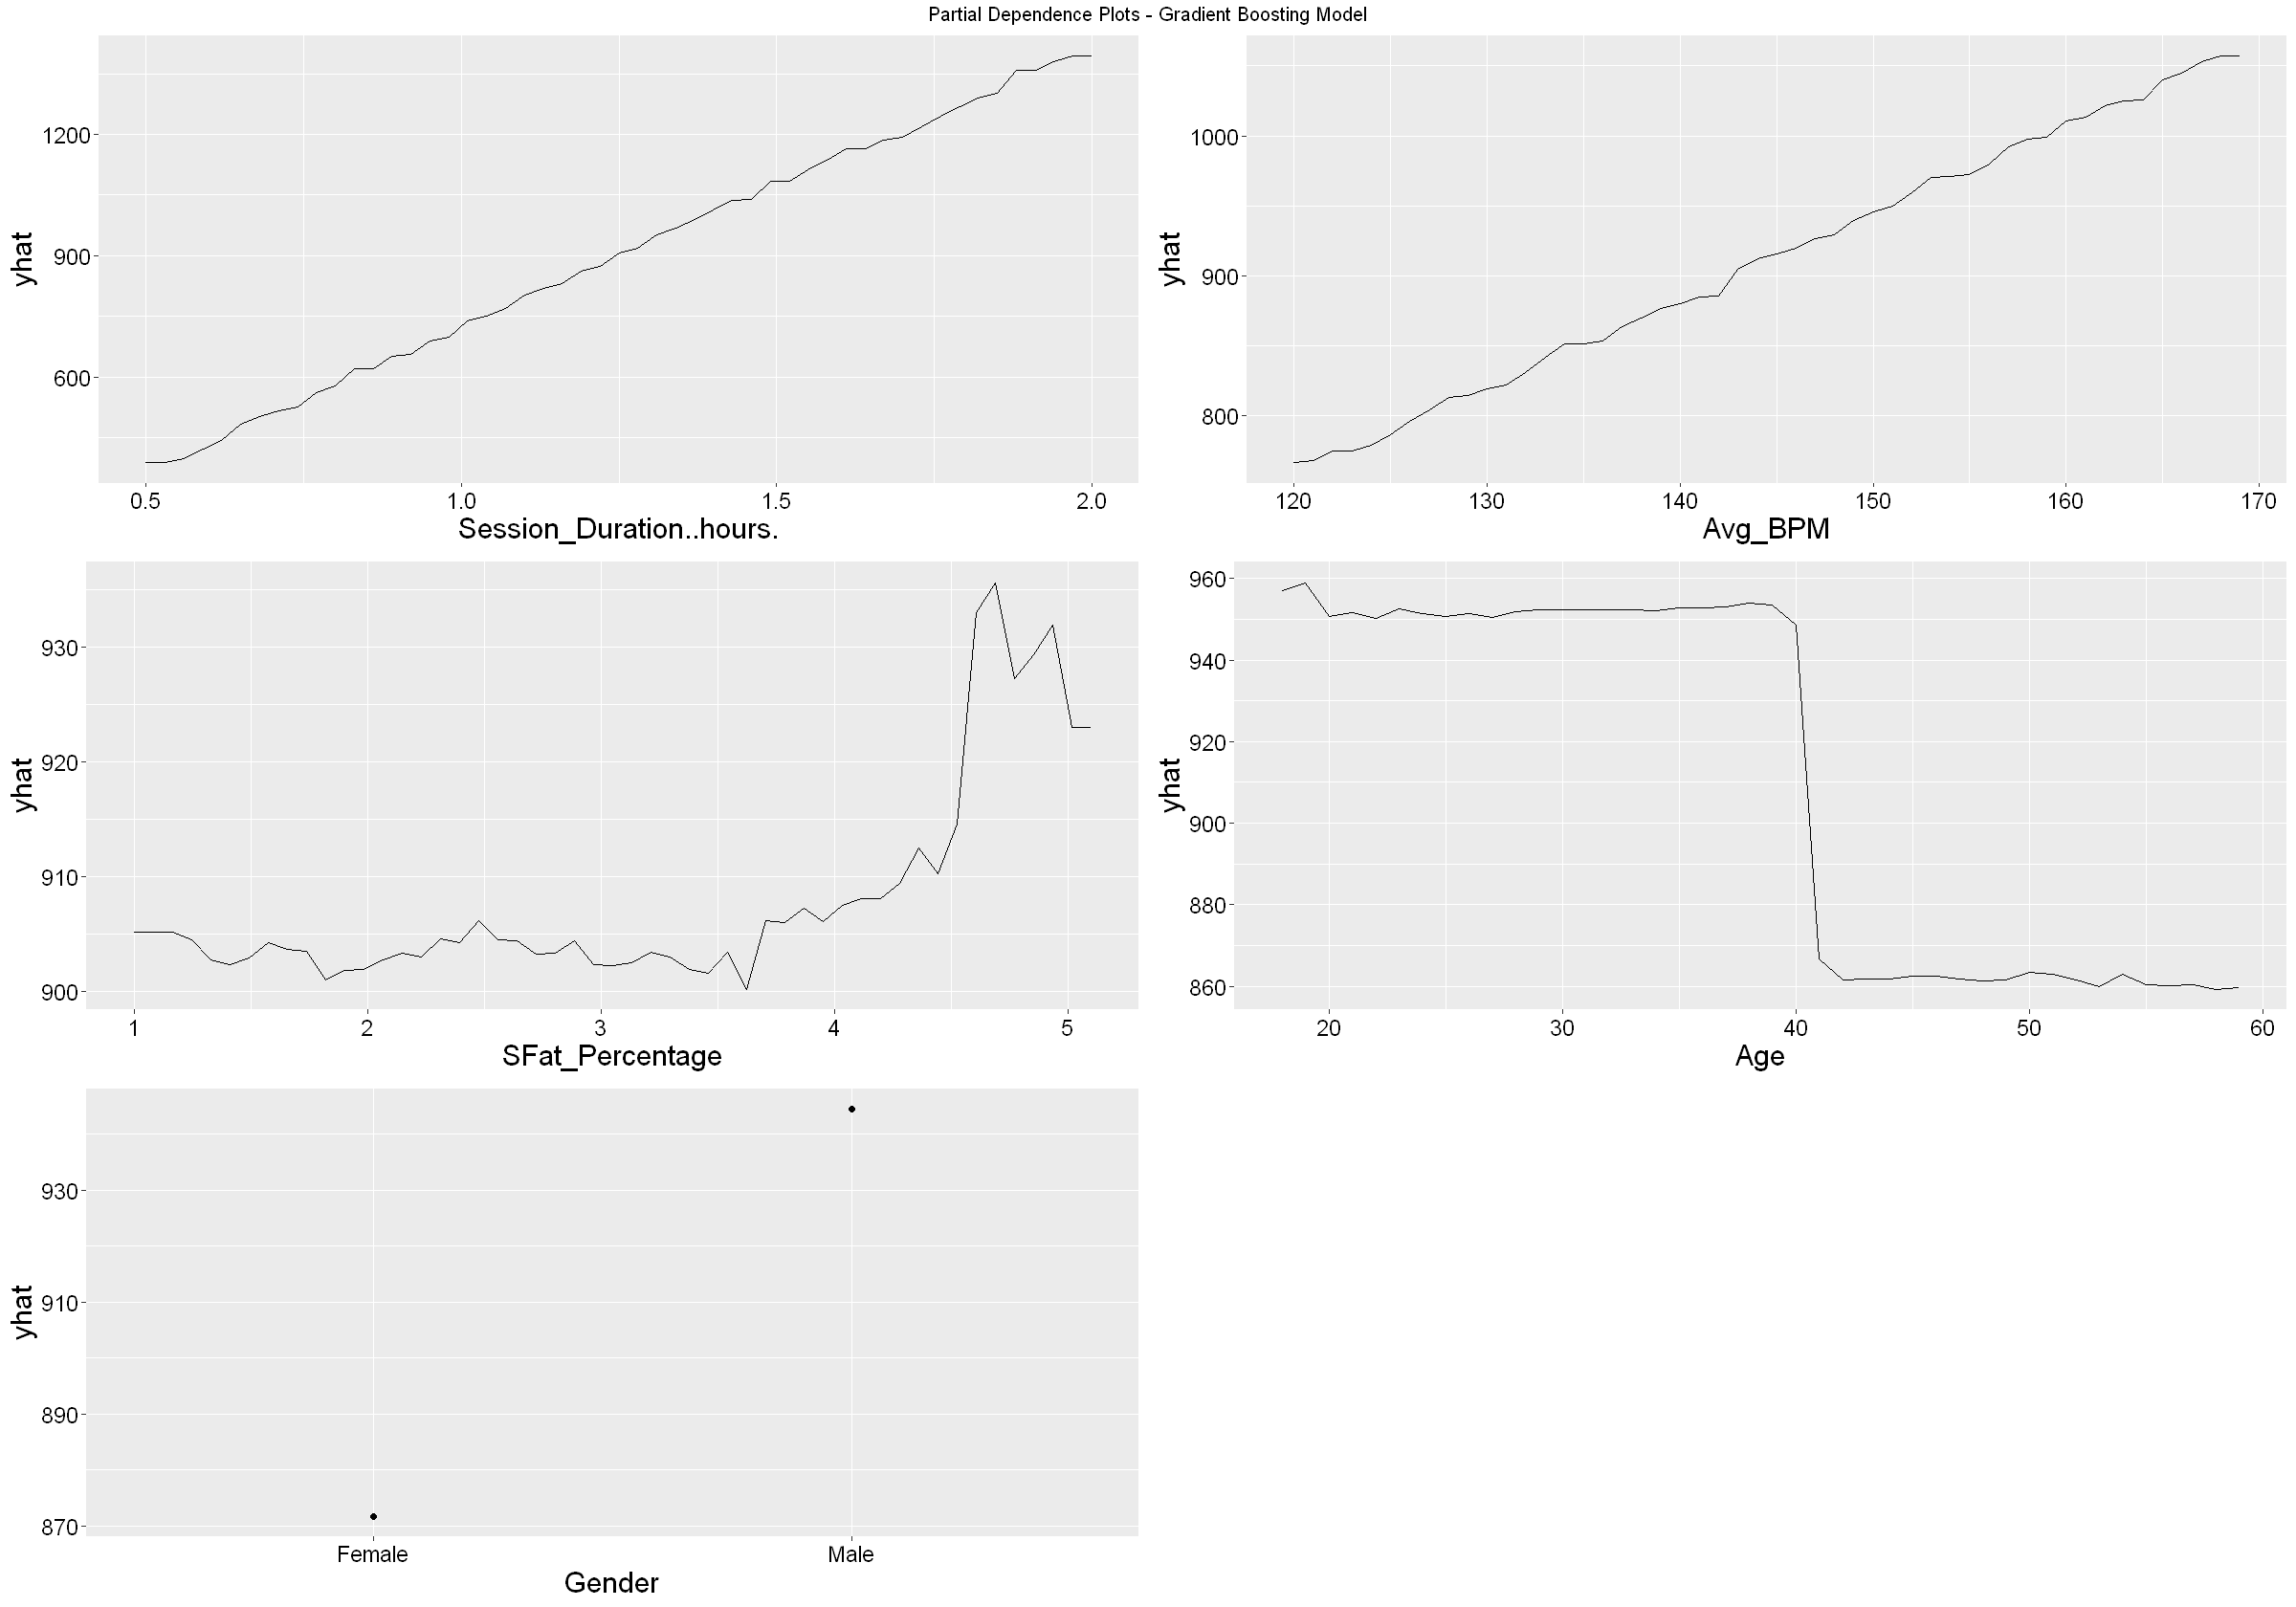

In [230]:
# PDP pour une variable (ex: Age)
pdp1 <- partial(boost.reg.cal, pred.var = "Session_Duration..hours.", rug = TRUE, train=gym_train, type="regression")
pdp2 <- partial(boost.reg.cal, pred.var = "Avg_BPM", rug = TRUE, train=gym_train, type="regression")
pdp3 <- partial(boost.reg.cal, pred.var = "SFat_Percentage", rug = TRUE, train=gym_train, type="regression")
pdp4 <- partial(boost.reg.cal, pred.var = "Age", rug = TRUE, train=gym_train, type="regression")
pdp5 <- partial(boost.reg.cal, pred.var = "Gender", rug = TRUE, train=gym_train, type="regression")

p1 <- autoplot(pdp1)
p2 <- autoplot(pdp2)
p3 <- autoplot(pdp3)
p4 <- autoplot(pdp4)
p5 <- autoplot(pdp5)

options(repr.plot.width=20, repr.plot.height=14)
main = "Partial Dependence Plots - Gradient Boosting Model"
grid.arrange(p1, p2, p3, p4, p5, ncol = 2, top = main)
rm(p1, p2, p3, p4, p5)


**Interpetation des PDP**:

Les partial dependence plots issus du modèle de Gradient Boosting permettent de visualiser l’impact isolé des variables sur la prédiction des calories brûlées. Ils confirment les résultats de l’analyse de l’importance des variables : 

- la durée de la séance (`Session_Duration..hours.`) et l’intensité de l’effort (`Avg_BPM`) sont les principaux déterminants avec des effets linéaires croissants. La durée de la séance a une influence de sur la variable cible, avec **un delta de 1000 calories entre les séances les plus courtes et les plus longues**. L’intensité de l’effort a également un impact significatif, avec **un delta de 400 calories entre les séances à 120 bpm et celles à 170 bpm** en moyenne. Ces résultats sont cohérents avec les analyses précédentes.
- le pourcentage de masse grasse (`SFatPercentage`) et l'age (`Age`) des individus on des interactions non lineaires avec la dépense calorique. :
  - En se remémorant la transformation de `FatPercentage`, les personnes **à faible taux de masse grasse ont une depense calorique plus importante** que les personnes à fort taux de masse grasse, **à effort égal**. 
  - Quant à l'age, on observe deux groupes : **les jeunes adultes (18-40 ans)** dépensent **près de 100 calories de plus** que **les personnes âgées entre 40 et 60 ans**, **à effort égal**. Ce résultat suggère un effet physiologique lié au vieillissement, notamment la perte de masse musculaire (sarcopénie), bien connue pour réduire la dépense énergétique. Cette hypothèse est cohérente avec les données scientifiques, qui montrent qu’à effort égal, un corps plus musclé consomme davantage de calories. Le modèle semble donc capter ici une relation non linéaire complexe entre l’âge, la composition corporelle et la dépense énergétique, malgré l’absence explicite de variable de masse musculaire dans le jeu de données. Il serait tout de même interessant de vérifier si la proportion de ces deux groupes de personnes est équilibrée dans le jeu de données, car il pourrait y avoir un biais de sélection.
- le genre (`Gender`) présente un léger effet marginal : les hommes brûlent légèrement plus de calories que les femmes (~70 calories d'écart).  


In [231]:
# Calculer les proportions dans le jeu d'entraînement
prop_train <- prop.table(table(ifelse(gym_train$Age > 40, ">40", "<=40"))) * 100

# Calculer les proportions dans le jeu de test
prop_test <- prop.table(table(ifelse(gym_test$Age > 40, ">40", "<=40"))) * 100

# Afficher les proportions
cat("Proportions dans le jeu d'entraînement:")
print(prop_train)

cat("\nProportions dans le jeu de test:")
print(prop_test)

Proportions dans le jeu d'entraînement:
   <=40     >40 
52.1181 47.8819 

Proportions dans le jeu de test:
    <=40      >40 
53.60825 46.39175 


La répartition des âges est équilibrée (~52/48 % training, ~54/46 test), écartant l’hypothèse d’un biais de sélection. L’effet de l’âge observé dans le PDP reflète donc une tendance réelle, captée spécifiquement par le modèle de boosting — et non mise en évidence par les autres approches.

## Réseaux de neurones

In [ ]:
# install.packages("neuralnet")

Warning message in train.default(x, y, weights = w, ...):
"The metric "MSE" was not in the result set. RMSE will be used instead."


+ Fold1: size= 5, decay=1e-04 
- Fold1: size= 5, decay=1e-04 
+ Fold1: size=10, decay=1e-04 
- Fold1: size=10, decay=1e-04 
+ Fold1: size=15, decay=1e-04 
- Fold1: size=15, decay=1e-04 
+ Fold1: size= 5, decay=1e-03 
- Fold1: size= 5, decay=1e-03 
+ Fold1: size=10, decay=1e-03 
- Fold1: size=10, decay=1e-03 
+ Fold1: size=15, decay=1e-03 
- Fold1: size=15, decay=1e-03 
+ Fold1: size= 5, decay=1e-02 
- Fold1: size= 5, decay=1e-02 
+ Fold1: size=10, decay=1e-02 
- Fold1: size=10, decay=1e-02 
+ Fold1: size=15, decay=1e-02 
- Fold1: size=15, decay=1e-02 
+ Fold1: size= 5, decay=1e-01 
- Fold1: size= 5, decay=1e-01 
+ Fold1: size=10, decay=1e-01 
- Fold1: size=10, decay=1e-01 
+ Fold1: size=15, decay=1e-01 
- Fold1: size=15, decay=1e-01 
+ Fold2: size= 5, decay=1e-04 
- Fold2: size= 5, decay=1e-04 
+ Fold2: size=10, decay=1e-04 
- Fold2: size=10, decay=1e-04 
+ Fold2: size=15, decay=1e-04 
- Fold2: size=15, decay=1e-04 
+ Fold2: size= 5, decay=1e-03 
- Fold2: size= 5, decay=1e-03 
+ Fold2:

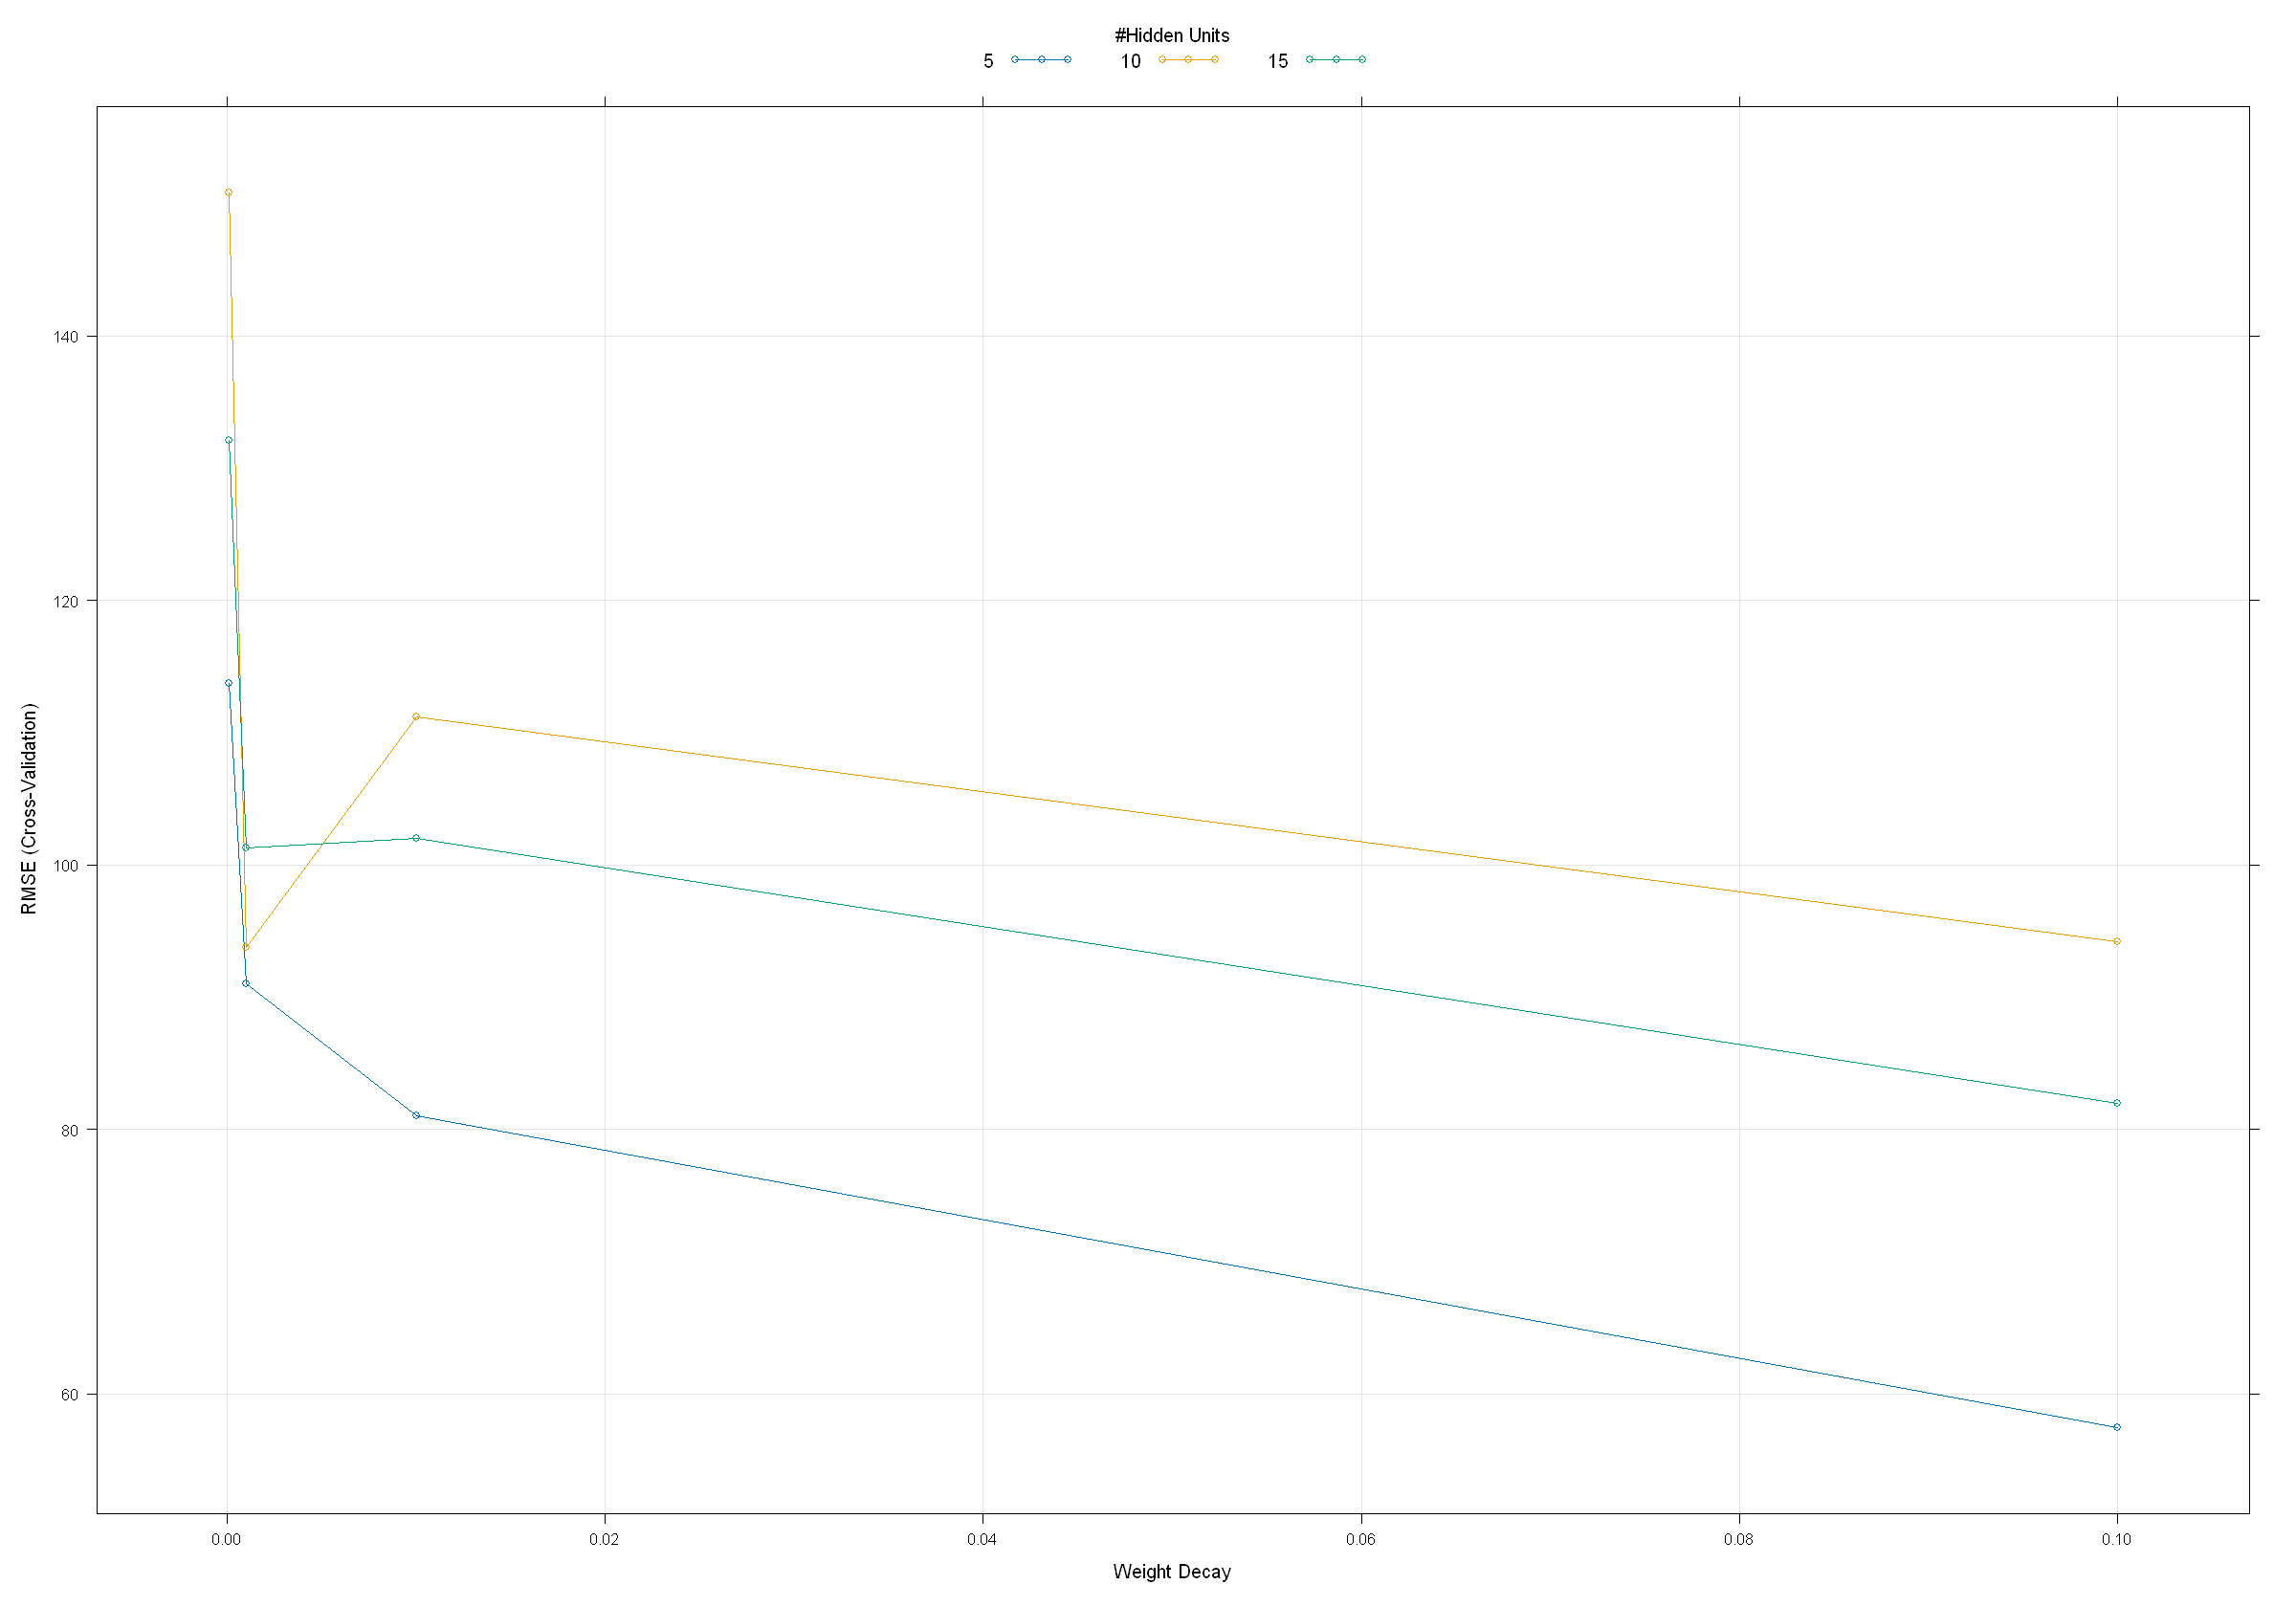

In [ ]:
library(caret)
library(nnet)
set.seed(123)
# Configuration de la validation croisée (5 folds)
ctrl <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = TRUE
)
# Grille d'hyperparamètres à explorer
tune_grid <- expand.grid(
  size = c(5, 10, 15),       # Nombre de neurones cachés
  decay = c(0.0001, 0.001, 0.01, 0.1)  # Force de régularisation
)
t0 <- Sys.time()
# Entraînement avec optimisation
set.seed(123)
model <- train(
  Calories_Burned ~ .,
  data = gym_train_scaled,
  method = "nnet",
  linout = TRUE,             # Pour la régression
  trace = FALSE,             # Désactive les logs
  maxit = 1000,              # Itérations maximales
  tuneGrid = tune_grid,
  trControl = ctrl,
  metric = "RMSE"            # Métrique d'évaluation
)
t1 <- Sys.time()
cat("Time taken for neural network tuning: ", t1 - t0, " seconds\n")
# Affichage des résultats
print(model$bestTune)
plot(model)

In [233]:
model$results

,size,decay,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,1e-04,113.73759,0.8071813,92.23471,51.07121,0.11618815,41.67968
2,5,1e-03,91.00309,0.8629666,72.30765,53.57936,0.11387180,42.98651
3,5,1e-02,81.04215,0.8947948,63.80443,47.65299,0.09640029,40.01861
4,5,1e-01,57.45557,0.9401453,44.16870,42.75082,0.09153958,33.99992
5,10,1e-04,150.82129,0.7031016,119.66775,20.11245,0.07872371,17.23814
6,10,1e-03,93.72306,0.8542779,75.54914,53.70356,0.11865903,43.68362
7,10,1e-02,111.19858,0.8158987,88.30703,45.68048,0.10378244,35.58009
8,10,1e-01,94.18435,0.8691801,72.90200,39.16916,0.09144797,30.81305
9,15,1e-04,132.06936,0.7561028,103.62841,39.21346,0.13659895,32.20002


In [234]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg <- nnet(Calories_Burned ~ ., data = gym_train_scaled, size = 5, decay = 0.1, linout = TRUE, maxit = 1000)

# weights:  101


initial  value 700917355.161088 
iter  10 value 24466234.451607
iter  20 value 19516927.070375
iter  30 value 19080370.669872
iter  40 value 18842591.085422
iter  50 value 18808065.257935
iter  60 value 18792138.569982
iter  70 value 18473292.941956
iter  80 value 18332011.926308
iter  90 value 16227500.132115
iter 100 value 16130060.589624
iter 110 value 16001870.172116
iter 120 value 14518402.134364
iter 130 value 14378959.523258
iter 140 value 14201118.872623
iter 150 value 14060933.486332
iter 160 value 14012290.304384
iter 170 value 13991801.539527
iter 180 value 13984961.579881
iter 190 value 13983792.438164
iter 200 value 13980129.560916
iter 210 value 13943986.813688
iter 220 value 13889562.248125
iter 230 value 13883129.459507
iter 240 value 13867532.016295
iter 250 value 13865975.881845
iter 260 value 13358231.925773
iter 270 value 13108686.771652
iter 280 value 12532186.722009
iter 290 value 12402907.698626
iter 300 value 12332370.840613
iter 310 value 12321825.989065
iter 3

In [236]:
# Prédictions sur l'échantillon de test
y_test_scale <- gym_test_scaled$Calories_Burned
y_pred_nn <- predict(nnet.reg, newdata = gym_test_scaled)

# Calcul du MSE
mse_nn_test <- mean((y_test_scale - y_pred_nn)^2)

# Calcul du R²
sst <- sum((y_test_scale - mean(y_test_scale))^2)
sse <- sum((y_test_scale - y_pred_nn)^2)
r2_nn_test <- 1 - sse / sst

cat("MSE (test) NN :", round(mse_nn_test, 3), "\n")
cat("R2 (test) NN  :", round(r2_nn_test, 3), "\n")
# Calcul du RMSE
rmse_nn_test <- sqrt(mse_nn_test)
cat("RMSE (test) NN :", round(rmse_nn_test, 3), "\n")

MSE (test) NN : 916.436 
R2 (test) NN  : 0.987 
RMSE (test) NN : 30.273 


Voici une interprétation des résultats obtenus sur la grille de réseaux de neurones (via `nnet` ou similaire), où l’on fait varier :

- **size** : nombre de neurones dans la couche cachée  
- **decay** : coefficient de régularisation (penalty L₂ sur les poids)

| size | decay  | RMSE    | R²       | MAE     | RMSESD  | R²SD    | MAESD  |
|------|--------|---------|----------|---------|---------|---------|--------|
| 5    | 1e-4   | 113.8   | 0.807    |  92.3   | 50.9    | 0.116   | 41.6   |
| 5    | 1e-3   |  90.9   | 0.863    |  72.2   | 53.8    | 0.114   | 43.1   |
| 5    | 1e-2   |  81.2   | 0.895    |  64.0   | 47.4    | 0.096   | 39.8   |
| 5    | 1e-1   | **58.2**| **0.940**| **44.3**| 41.3    | 0.088   | 32.5   |
| 10   | 1e-4   | 150.8   | 0.703    | 119.7   | 20.1    | 0.079   | 17.2   |
| 10   | 1e-3   |  94.2   | 0.854    |  75.6   | 53.1    | 0.118   | 43.6   |
| 10   | 1e-2   | 111.6   | 0.816    |  88.4   | 44.8    | 0.103   | 35.5   |
| 10   | 1e-1   |  94.2   | 0.869    |  72.9   | 39.2    | 0.091   | 30.8   |
| 15   | 1e-4   | 132.1   | 0.756    | 103.6   | 39.2    | 0.137   | 32.2   |
| 15   | 1e-3   | 101.4   | 0.864    |  78.6   | 20.4    | 0.052   | 16.5   |
| 15   | 1e-2   | 101.8   | 0.855    |  80.3   | 35.7    | 0.084   | 28.9   |
| 15   | 1e-1   |  82.6   | 0.895    |  66.2   | 40.9    | 0.089   | 32.6   |

---

#### 1. Choix optimal de l’hyperparamètre
- **Meilleur couple (size, decay)** : **5 neurones** et **decay = 0,1**  
- **Performance associée** :  
  - **RMSE = 58,2** (le plus faible de la grille)  
  - **R² = 0,94** (le plus élevé)  
  - **MAE = 44,3**  

C’est donc un **modèle compact** (peu de neurones) avec une **régularisation modérée** qui offre la meilleure généralisation sur nos données.

---

#### 2. Effets de la régularisation (decay)
- **Decay très faible** (1e-4) → sous-régularisation → **RMSE élevé** (>100), **R² bas** (~0,75–0,80).  
- **Augmentation progressive de decay** → diminution du RMSE et montée du R² jusqu’à un optimum à 0,1.  
- **Au-delà**, un decay trop fort (pour size 10 ou 15) ne fait pas mieux que le pic autour de 5×0,1.

---

#### 3. Impact du nombre de neurones (size)
- **Réseau très petit** (size = 5) + bon decay : excellente performance.  
- **Réseaux plus gros** (size = 10 ou 15) n’apportent **pas** d’amélioration nette :  
  - Ils nécessitent souvent un réglage de decay fin, mais n’atteignent jamais les niveaux de RMSE/R² du petit réseau.  
  - Risque d’**overfitting** plus élevé (variabilité inter-fold plus importante).

---

#### 4. Fiabilité & stabilité
- La **SD** des métriques (RMSESD, R²SD) reste raisonnable pour le couple optimal, témoignant d’une **performance stable** à travers les folds.

---

### Bilan Réseau de neurones

Pour ce jeu de données :
- **Nous allons préférer un réseau à 5 neurones** avec **decay = 0,1**, qui minimise l’erreur (RMSE ≃ 58) et maximise l’explication de variance (R² ≃ 0,94).
- **Ni trop de neurones**, ni **trop peu de régularisation** : l’équilibre trouvé évite à la fois sous- et sur-apprentissage.
- Les architectures plus complexes (size ≥ 10) n’apportent pas de gain suffisant pour justifier l’augmentation de la complexité.

## Comparaison des performances des modèles

| Modèle         | MSE (test) | R² (test) | Temps d'optimisation des paramètres | Taille de la grille | Interprétabilité | Généralisation |
|----------------|------------|-----------|----------| ---------------------|-------------------|------------------|
| Régression Linéaire | 1218.8 | 0.982 | 0.008s | 1\* | ☑️☑️ | ❌ |
| Lasso (λ_min) | 1205 | 0.982 | 0.014s | 65 |☑️☑️ | ☑️☑️ |
| Lasso (λ_1se) | 1247 | 0.982 | - | - |   ☑️☑️ | ☑️☑️ |
| Ridge (λ_min) | 1624 | 0.979 | 0.20s | 200 | ❌ | - |
| GLM Quadratique | 715 | 0.993 | 0.05s | 1 | ☑️ | ☑️☑️ |
| LASSO Quadratique (λ_min) | 575 | 0.992 | 0.23s | 90 | ☑️☑️ | ☑️☑️ |
| LASSO Quadratique (λ_1se) | 560 | 0.992 | - | - | ☑️☑️ | ☑️☑️ |
| SVR Linéaire | 1201 | 0.982 | 1m11s | 5 |❌ | ☑️ |
| SVR Polynomial | 1201 | 0.982 | 40m40s | 24 |❌ | ☑️ |
| SVR RBF | 575.4 | 0.992 | 40s | 31 |❌ | ☑️☑️ |
| CART           | 4564    | 0.933    | 0.04s | 58 |❌ | ❌ |
| Random Forest  | 1570    | 0.978    | 4.8s | 4\*\* |☑️ | ☑️ |
| GBM            | 213     | 0.997    | 28.6s | 36 |☑️ | ☑️☑️ |
| Perceptron (nnet) | 916    | 0.987    | 1m39s | 12 |❌| ☑️☑️ |

\* Le modèle de régression linéaire / GLM quadratique a été testé avec une grille de 1 valeur (aucun hyperparamètre à optimiser).

\*\* Le modèle Random Forest determine mtry n'est pas vraiment cherché à travers une grille, de manière itérative en regardant à droite ou à gauche de la valeur initiale de `mtry = p/3` (p = nombre de variables). 

## Synthèse finale

Plusieurs modèles d'apprentissage supervisé ont été optimisés et comparés pour prédire la variable cible `Calories_Burned`. Ce qui ressort de cette analyse est que :

- **Le modèle de régression linéaire avec interactions d'ordre 2 (GLM) et régularisation LASSO** a montré une performance solide (MSE_test = 575.4, R²_test = 0.992) et un temps d'optimisation du seul paramètre de régularisation (λ) exceptionnellement court (0.23s). De plus, **il est facilement interprétable** et permet **d'identifier les interactions** significatives entre les variables pour prédire la dépense calorique. 
 
- **Le modèle de régression SVR avec noyau RBF** a également montré une performance compétitive (MSE_test = 575.4, R²_test = 0.992) et un temps d'optimisation des hyperparamètres relativement court (40s). Cependant, il est moins interprétable que le modèle de régression linéaire et nécessite un réglage minutieux des hyperparamètres pour obtenir de bonnes performances.
  
- **Le modèle de régression CART** a montré la performance la plus faible malgré optimisation du `mtry` (MSE_test = 4564, R²_test = 0.933). En plus de cela sa profondeur excessive (58 feuilles) le rend difficilement interprétable et sujet à un sur-apprentissage. Il est donc peu adapté pour ce type de données.
  
- **Le modèle Random Forest** a montré une performance solide (MSE_test = 1570, R²_test = 0.978) et un temps d'optimisation des hyperparamètres relativement court (4.8s). Il nous a permis d'interpréter les variables importantes et de visualiser les effets marginaux, ce qui nous a permis de quantifier l'impact de chaque variable sur la dépense calorique. 
  
- **Le modèle de boosting (GBM)** a montré la meilleure performance globale (MSE_test = 213, R²_test = 0.997) et un temps d'optimisation des hyperparamètres relativement court (28.6s). Il a également permis d'interpréter les variables importantes et de visualiser les effets marginaux, ce qui nous a permis de quantifier l'impact de chaque variable sur la dépense calorique.
  
- Enfin, **le modèle de régression avec réseau de neurones** a montré une performance moyenne (MSE_test = 916, R²_test = 0.987) et un temps d'optimisation des hyperparamètres relativement long (1m39s). Il est le moins interprétable de tous les modèles testés et nécessite un réglage minutieux des hyperparamètres pour obtenir de bonnes performances. Ce ne sera donc pas le modèle de choix pour ce type de données.


# Prédiction de Experience_Level

## Regression logistique 

La régréssion logistque réalisée ici est multinomiale pour être adaptée à notre problème de clasification et prend en comte les interactions doubles. 
La fonction R glmnet calcule tous les modèles lasso (pénalisation L1, alpha=1 en argument) pour une séquence de 100 lambda puis évalue leurs performances par validation croisée. 

 Les données utilisés sont les donnnés "scalers" (moyenne à 0 ecart-type à 1) pour ne pas donner plus d'importance à certaines variables (glmnet fait des pénalisation avec les normes L1 (alpha=1)).

[1] "Temps d'exécution :  3.73895788192749"
[1] "Best Lambda : 0.000566060562817942"
[1] "LSE Lambda : 0.0069786591919684"


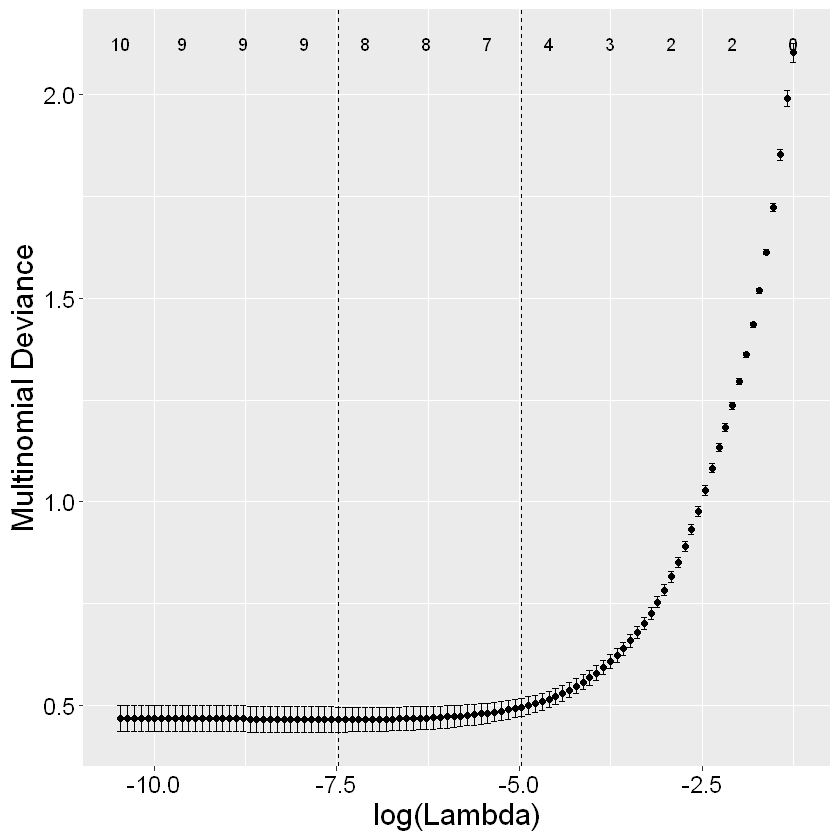

In [ ]:
t0 <- Sys.time()

# Convertir les données en matrice pour glmnet
# si ~ .^2 => erreur = 15% environ
x <- model.matrix(Experience_Level ~ ., data = gym_train_scaled)[, -1] # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = gym_train_scaled)      # Réponse

# Ajustement du modèle avec validation croisée
cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1)
autoplot(cv_fit)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

- lambda petit: moins de pénalisation, modèle complexe avec beaucoup de variables non nulles 
- lambda grand: plus depénalisation, modèle simple avec bcp de coefs nulles
- courbe : performance sur validation croisée sauf forme erreur de prédiction

Le plus grand lambda qui minimise la deviance est lambda min = 0.000295; et le plus grand lambda dont la déviance est à moins de un écart-type du minimum est LSE lambda= 0.0052791. On garde ce dernier qui fait un compromis entre la simplicité et la robustesse du modèle. 

Le choix du lamabda nous permet de réduire le nombre de coeffcients selectionnés.

In [ ]:
# Choix du lambda
chosen_lambda <- lse_lambda

# Ajuster le modèle final avec le meilleur lambda
final_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

# Afficher les coefficients du modèle final
print(coef(final_model))

$Experience_Level1
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                                2.76270639
Age                             0.04454661
GenderMale                      .         
LWeight                         .         
Height..m.                      0.01526018
Max_BPM                         .         
Avg_BPM                         .         
Resting_BPM                     .         
Session_Duration..hours.       -1.15464048
Calories_Burned                -0.17927720
Workout_TypeHIIT                .         
Workout_TypeStrength            .         
Workout_TypeYoga                .         
SFat_Percentage                 .         
Water_Intake..liters.           .         
Workout_Frequency..days.week.3  .         
Workout_Frequency..days.week.4 -5.94077471
Workout_Frequency..days.week.5  .         

$Experience_Level2
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                 

In [ ]:
# Extraire tous les coefficients
coefs_list <- coef(final_model)

# Pour chaque classe, compter les coefficients non nuls (hors intercept)
nombre_non_nuls_par_classe <- sapply(coefs_list, function(m) {
  sum(m[-1, ] != 0)  # Enlève intercept (-1) et compte les non-zéros
})

# Afficher
print(nombre_non_nuls_par_classe)

Experience_Level1 Experience_Level2 Experience_Level3 
                5                 7                 4 


La methode Lasso avec le lambda 1se permet de garder uniquement 5 coefficients pour la classe Experience_Level1, 7 pour Experience_Level2 et 4 pour Experience_Level3, contre 17 par classe à l'origine.  

In [ ]:

# Convertir les données test en matrice pour glmnet de la meme manière 
#que pour les données d'apprentissage 
x_test <- model.matrix(Experience_Level ~ ., data = gym_test_scaled)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = gym_test_scaled)  # Réponse réelle (one-hot)

# Prédiction des probabilités pour chaque classe
pred_probs <- predict(final_model, newx = x_test, type = "response") 

# Modification nécessaires pour tracer les courbes ROC 
probabilities_logit <- pred_probs[,,1]
probabilities_logit <- as.data.frame(probabilities_logit)
colnames(probabilities_logit) <- c("1", "2", "3")


# Convertir les probabilités en classes prédictes (classe avec proba max)
pred_class <- apply(pred_probs, 1, which.max)
pred_class <- factor(pred_class, levels = 1:3)
# Convertir y_test en indices de classes réelles
true_class_test <- apply(y_test, 1, which.max)

# Construire la matrice de confusion
conf_matrix_logit <- table(Predicted = pred_class, Actual = true_class_test)
conf_matrix_test <- confusionMatrix(pred_class, gym_test$Experience_Level)
print(conf_matrix_logit)
# Calcul du log loss
log_loss <- MultiLogLoss(y_true = y_test, y_pred = pred_probs[,,1])
#log_loss <- -mean(log(probabilities_logit[cbind(seq_len(nrow(probabilities_logit)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_logit)

         Actual
Predicted  1  2  3
        1 67 19  0
        2  8 62  0
        3  0  0 38
[1] "Log Loss: 0.2558"
[1] "Pourcentage d'erreur : 13.92 %"


On voit qu'il y a eu des erreures de prédiction pour 28 persones, et ces erreures sont toujours entre les niveau d'expérience 1 et deux. Le pourcentage d'erreure de prédiction est de 14.43%, assez élevé. 

In [ ]:
# Calcul de l'AUC multiclass 
roc_result <- multiclass.roc(true_class_test, probabilities_logit)
auc_value <- auc(roc_result)

results <- rbind(results, data.frame(
  Methode = "Logit",
  Accuracy = round(conf_matrix_test$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## Analyse Discriminante Linéaire (LDA)

In [ ]:
# Initialisation de la validation croisée avec 10 folds
# Intervient dès que l'on utilise la
# fonction train du package caret
param_train<-trainControl(method="cv",number=10)

In [ ]:
t0 <- Sys.time()

lda.fit<-train(Experience_Level ~ ., data = gym_train_scaled, method="lda")

# erreur par validation croisée  en analyse discriminante linéaire
lda.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="lda",trControl=param_train)

predictions_lda <- predict(lda.fit, gym_test_scaled)
probabilities_lda <- predict(lda.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_lda=table(gym_test_scaled[,"Experience_Level"],predictions_lda)
conf_matrix_test_lda <- confusionMatrix(predictions_lda, gym_test_scaled$Experience_Level)
print(conf_matrix_lda)
# Calcul du log loss
log_loss <- -mean(log(probabilities_lda[cbind(seq_len(nrow(probabilities_lda)), true_class_test)]))
#log_loss <- MultiLogLoss(y_true = y_test, y_pred = pred_probs[,,1])
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_lda)



[1] "Temps d'exécution :  2.24697709083557"
   predictions_lda
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2299"
[1] "Pourcentage d'erreur : 14.43 %"


Le pourcentage d'erreur est très proche de celui obtenus avec la regression logistque optimisée par Lasso. Les erreurs sont à nouveau entre les niveaux d'expérience 1 et 2, cette fois il y a plus d'individus prédits du niveau 2 alors qu'il sont du niveau 1.

In [ ]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_lda)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "LDA",
  Accuracy = round(conf_matrix_test_lda$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## K plus proches voisins (KNN)

In [ ]:
#knn.fit<-train(Experience_Level ~ ., data = gym_train_scaled ,method="knn")

t0 <- Sys.time() 

# erreur par validation croisée  en kNN
knn.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="knn",trControl=param_train,tuneLength=20)

predictions_knn <-predict(knn.fit, gym_test_scaled)
probabilities_knn <-predict(knn.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_knn=table(gym_test_scaled[,"Experience_Level"],predictions_knn)
conf_matrix_test_knn <- confusionMatrix(predictions_knn, gym_test_scaled$Experience_Level)
print(conf_matrix_knn)
# Calcul du log loss

log_loss <- -mean(log(probabilities_knn[cbind(seq_len(nrow(probabilities_knn)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_knn)

[1] "Temps d'exécution :  2.82002687454224"
   predictions_knn
     1  2  3
  1 43 32  0
  2 11 70  0
  3  0  0 38
[1] "Log Loss: 0.4993"
[1] "Pourcentage d'erreur : 22.16 %"


Le pourcentage d'erreur de prédiction est nettement plus élevé que pour les deux derniers modèle, il dépasse les 20%. Le modèle de prédiction par KNN est mauvais. On retrouve que les niveau d'expérience 1 et 2 sont souvent mélangés. 

In [ ]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_knn)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "KNN",
  Accuracy = round(conf_matrix_test_knn$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

In [ ]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_knn)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "KNN",
  Accuracy = round(conf_matrix_test_knn$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## Support Vector Machine (SVM)

### SVM kernel radial 

Warning message:
"package 'e1071' was built under R version 4.4.3"


[1] "Temps d'exécution :  30.3401279449463"


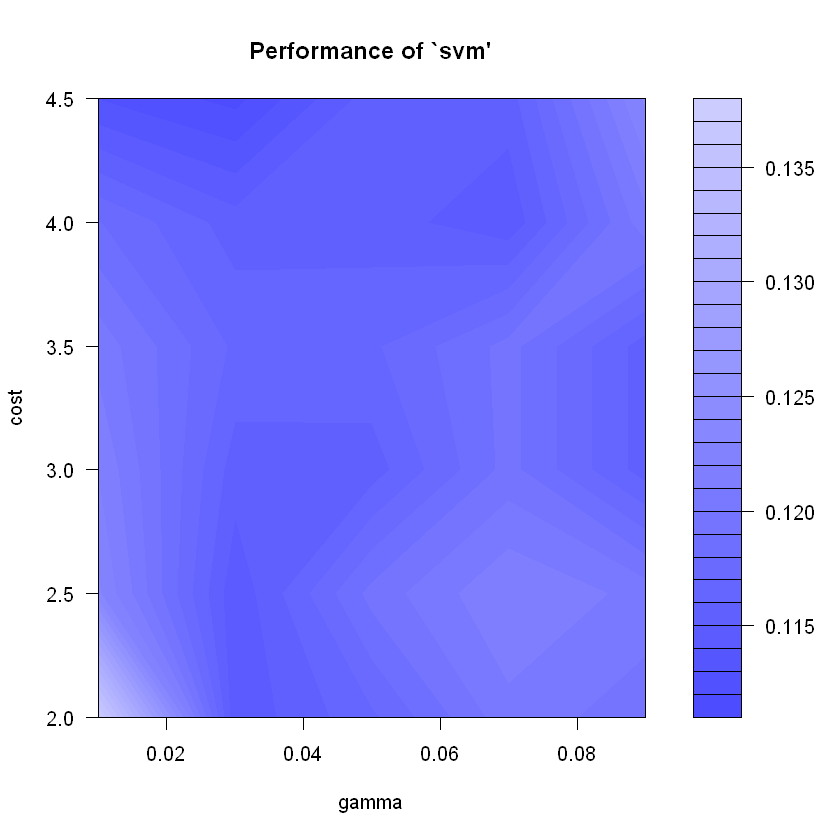

In [ ]:
library(e1071)
t0 <- Sys.time()

#La zone de recherche est volontairement déjà centré sur les paramètres optimaux
svm.rad.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, cost = c(2, 2.5, 3, 3.5,4,4.5), 
    gamma = seq(0.01, 0.1, by = 0.02), kernel= "radial")
plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

In [ ]:
svm.rad = svm(Experience_Level ~ ., data = gym_train_scaled, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.rad <- attr(pred.svm.rad, "probabilities")
probabilities_svm.rad <- as.data.frame(probabilities_svm.rad)
probabilities_svm.rad <- probabilities_svm.rad[, c("1", "2", "3")]

conf_matrix_svm.rad=table(gym_test_scaled[,"Experience_Level"],pred.svm.rad)
conf_matrix_test_svm.rad <- confusionMatrix(pred.svm.rad, gym_test_scaled$Experience_Level)
print(conf_matrix_svm.rad)
# Calcul du log loss
log_loss <- -mean(log(probabilities_svm.rad[cbind(seq_len(nrow(probabilities_svm.rad)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_svm.rad)

   pred.svm.rad
     1  2  3
  1 63 12  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2775"
[1] "Pourcentage d'erreur : 14.95 %"


Le modèle présente des performances similaires à celles de la régression logistique et de l’analyse discriminante linéaire, avec une erreur de prédiction de 14,95 %. Les erreurs concernent uniquement une confusion entre les niveaux 1 et 2. En revanche, le temps d’exécution est long, autour de 30 secondes.

In [ ]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.rad)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM radiale",
  Accuracy = round(conf_matrix_test_svm.rad$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

### SVM kernel polynomial

[1] "Temps d'exécution :  13.1265280246735"


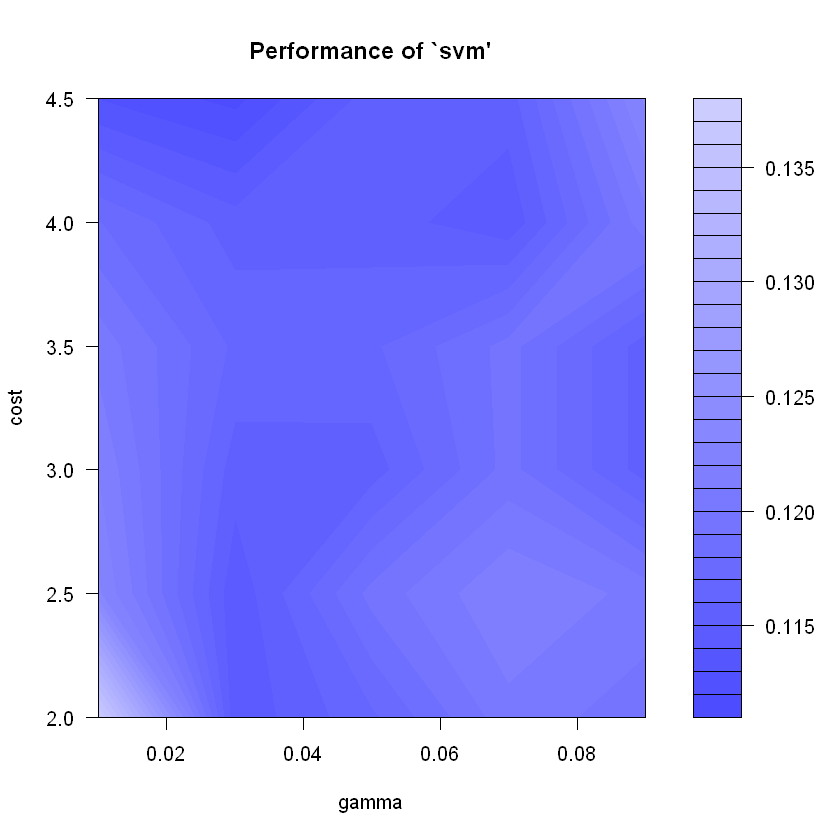

In [ ]:
# On peut rajouter :
# coef0 = c(0.5,1,1.5), degree= c(2,3)
# Mais c'est trop long

t0 <- Sys.time()

svm.pol.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial", cost = c(3.5,4,4.5,5), 
    gamma = seq(0.01, 0.1, by = 0.02), coef0=1, degree=3) 

plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

Le temps d'execution plus raisonnable (11s). En revenche il de plusieurs minutes quand on ajoute l'optimisation de 'cef0' et 'degree'.

In [ ]:
svm.pol = svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              coef0 = 1,
              degree = 3,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.pol <- attr(pred.svm.pol, "probabilities")
probabilities_svm.pol <- as.data.frame(probabilities_svm.pol)
probabilities_svm.pol <- probabilities_svm.pol[, c("1", "2", "3")]

conf_matrix_svm.pol=table(gym_test_scaled[,"Experience_Level"],pred.svm.pol)
conf_matrix_test_svm.pol <- confusionMatrix(pred.svm.pol, gym_test_scaled$Experience_Level)
print(conf_matrix_svm.pol)
# Calcul du log loss
log_loss <- -mean(log(probabilities_svm.pol[cbind(seq_len(nrow(probabilities_svm.pol)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_svm.pol)

   pred.svm.pol
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2544"
[1] "Pourcentage d'erreur : 14.43 %"


Pas d'amélioration par rapport au kernel radial sur l'erreur mais une diminution de 20s du temps d'execution. 

In [ ]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.pol)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM polynomiale",
  Accuracy = round(conf_matrix_test_svm.pol$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## CART & Agregation


Warning message:
"package 'rpart.plot' was built under R version 4.4.3"


Test Set Performance:
- Accuracy: 0.8711 
- Log loss: 0.2528 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 64 14  0
         2 11 67  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9474 
- Log loss: 0.1257 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 276  16   0
         2  25 309   0
         3   0   0 153
Nombre de noeuds dans l'arbre :  37 
Nombre de feuilles dans l'arbre :  19 


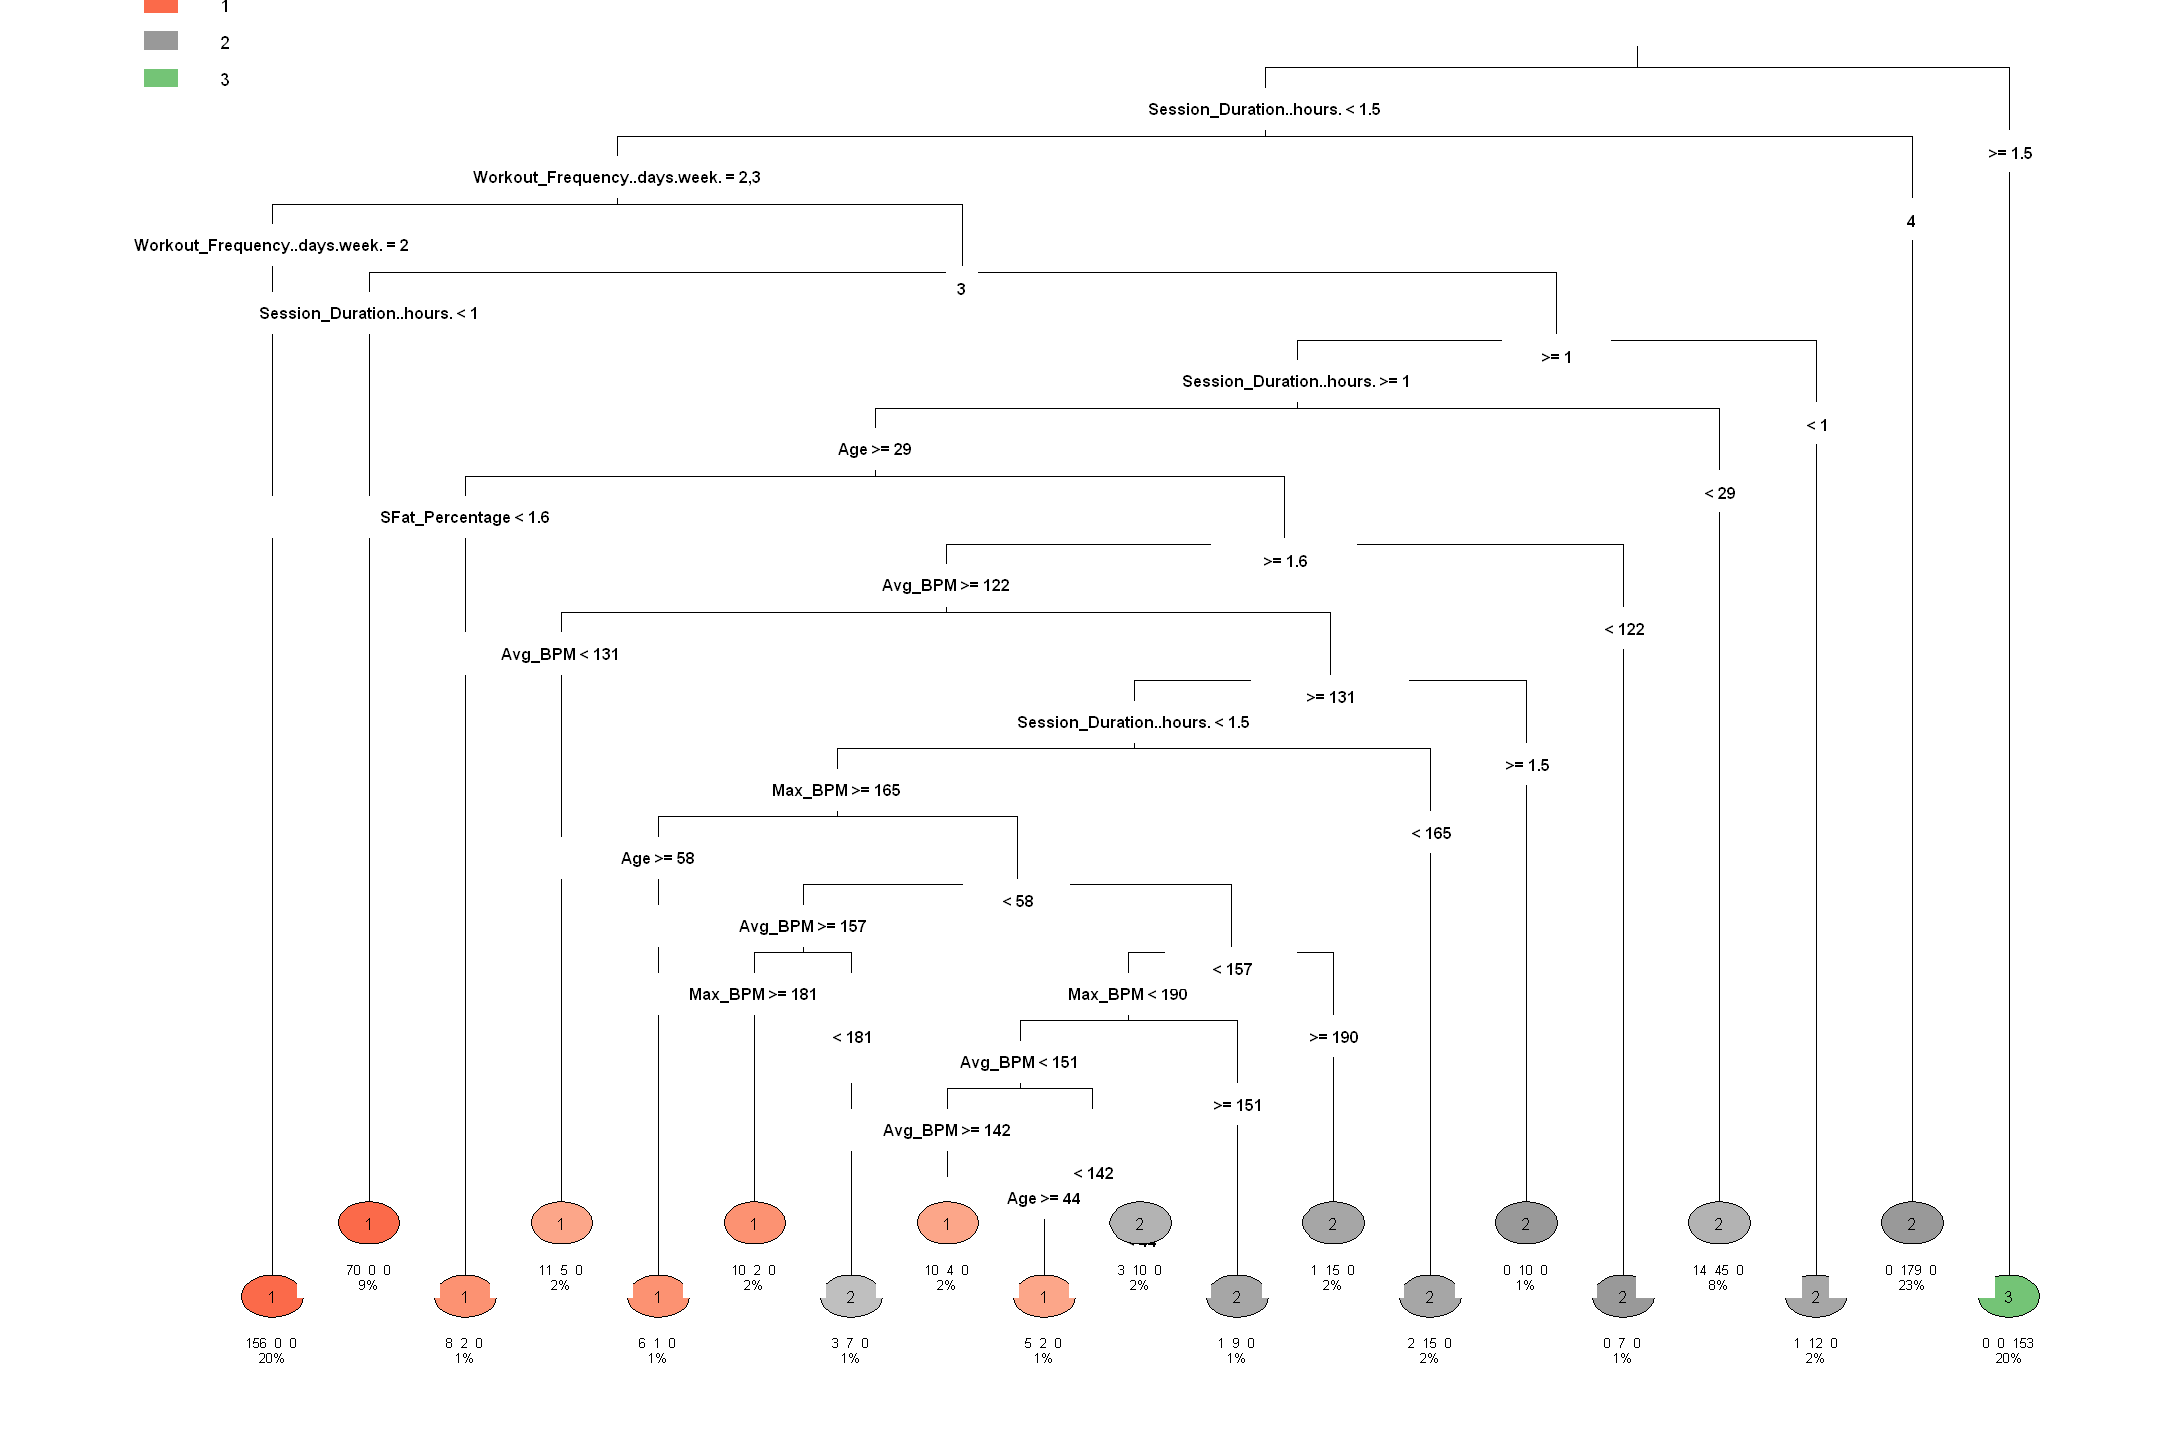

In [ ]:
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Experience_Level using the training set
tree.reg.exp <- rpart(Experience_Level ~ ., data = gym_train, control=rpart.control(cp=0.0001))

options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.exp, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Convert the target to binary for ROC analysis
# Here we're treating Experience_Level as a binary classification problem
# First, get predicted probabilities for each class
pred_exp_tree_test <- predict(tree.reg.exp, gym_test, type = "prob")
pred_exp_tree_train <- predict(tree.reg.exp, gym_train, type = "prob")

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes <- gym_test$Experience_Level
actual_matrix <- model.matrix(~actual_classes-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value <- MultiLogLoss(y_pred = pred_exp_tree_test, y_true = actual_matrix)

# Calculate confusion matrix for test set
pred_classes_test <- predict(tree.reg.exp, gym_test, type="class")
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

# Compute the metrics for the gym_train set
# Calculate confusion matrix for training set
pred_classes_train <- predict(tree.reg.exp, gym_train, type="class")
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes_train <- gym_train$Experience_Level
actual_matrix_train <- model.matrix(~actual_classes_train-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value_train <- MultiLogLoss(y_pred = pred_exp_tree_train, y_true = actual_matrix_train)


cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

# Afficher le nombre de noeuds et de feuilles en français
cat("Nombre de noeuds dans l'arbre : ", length(tree.reg.exp$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre : ", length(tree.reg.exp$frame$var[tree.reg.exp$frame$var == "<leaf>"]), "\n")

**Interprétation :**

L'arbre de régression construit avec un paramètre de complexité faible (`cp = 0.0001`) montre des performances solides mais indique un potentiel sur-apprentissage.

**Performance sur le jeu de test :**
- **Précision :** 87,11 % - Bonne capacité à classer correctement les observations.
- **Log loss :** 0.2528 - Indique des prédictions probabilistes bien calibrées.
- **Matrice de confusion :** Bonne distinction des classes, mais quelques confusions entre les classes 1 et 2.

**Performance sur le jeu d'entraînement :**
- **Précision :** 94,74 % - Ajustement presque parfait aux données d'entraînement.
- **Log loss :** 0.1257 - Confirme un ajustement très précis.

**Conclusion :**
L'écart entre les performances d'entraînement et de test (94,74 % vs 87,11 %) et les log loss (0.1257 vs 0.2528) suggère un sur-apprentissage dû à une complexité excessive. Malgré cela, le modèle capture bien les relations dans les données. Une optimisation du paramètre de complexité (`cp`) pourrait améliorer la généralisation.

### **Sélection du paramètre de complexité (cp) par validation croisée**

Pour éviter le sur-apprentissage et obtenir un arbre de régression optimal, il est important de choisir correctement le paramètre de complexité (`cp`). La méthode classique consiste à utiliser la validation croisée intégrée à l’algorithme `rpart` :

- On ajuste d’abord un arbre avec une valeur de `cp` très faible, ce qui permet à l’arbre de se développer au maximum.
- `rpart` réalise automatiquement une validation croisée (par défaut à 10 plis) et enregistre, pour différentes valeurs de `cp`, l’erreur de validation croisée associée.
- On visualise ensuite l’évolution de l’erreur de validation croisée en fonction de `cp` à l’aide de la fonction `plotcp()`.
- Le `cp` optimal est celui qui minimise l’erreur de validation croisée (`xerror`). On peut aussi appliquer la règle du 1-SE pour sélectionner un arbre plus simple si plusieurs valeurs de `cp` donnent des erreurs similaires.
- Enfin, on élague l’arbre initial avec la valeur optimale de `cp` pour obtenir un modèle plus parcimonieux et mieux généralisant.

Cette démarche permet de sélectionner automatiquement la complexité de l’arbre en fonction des performances sur des données non vues.

Le cp optimal est : 0.004405286 


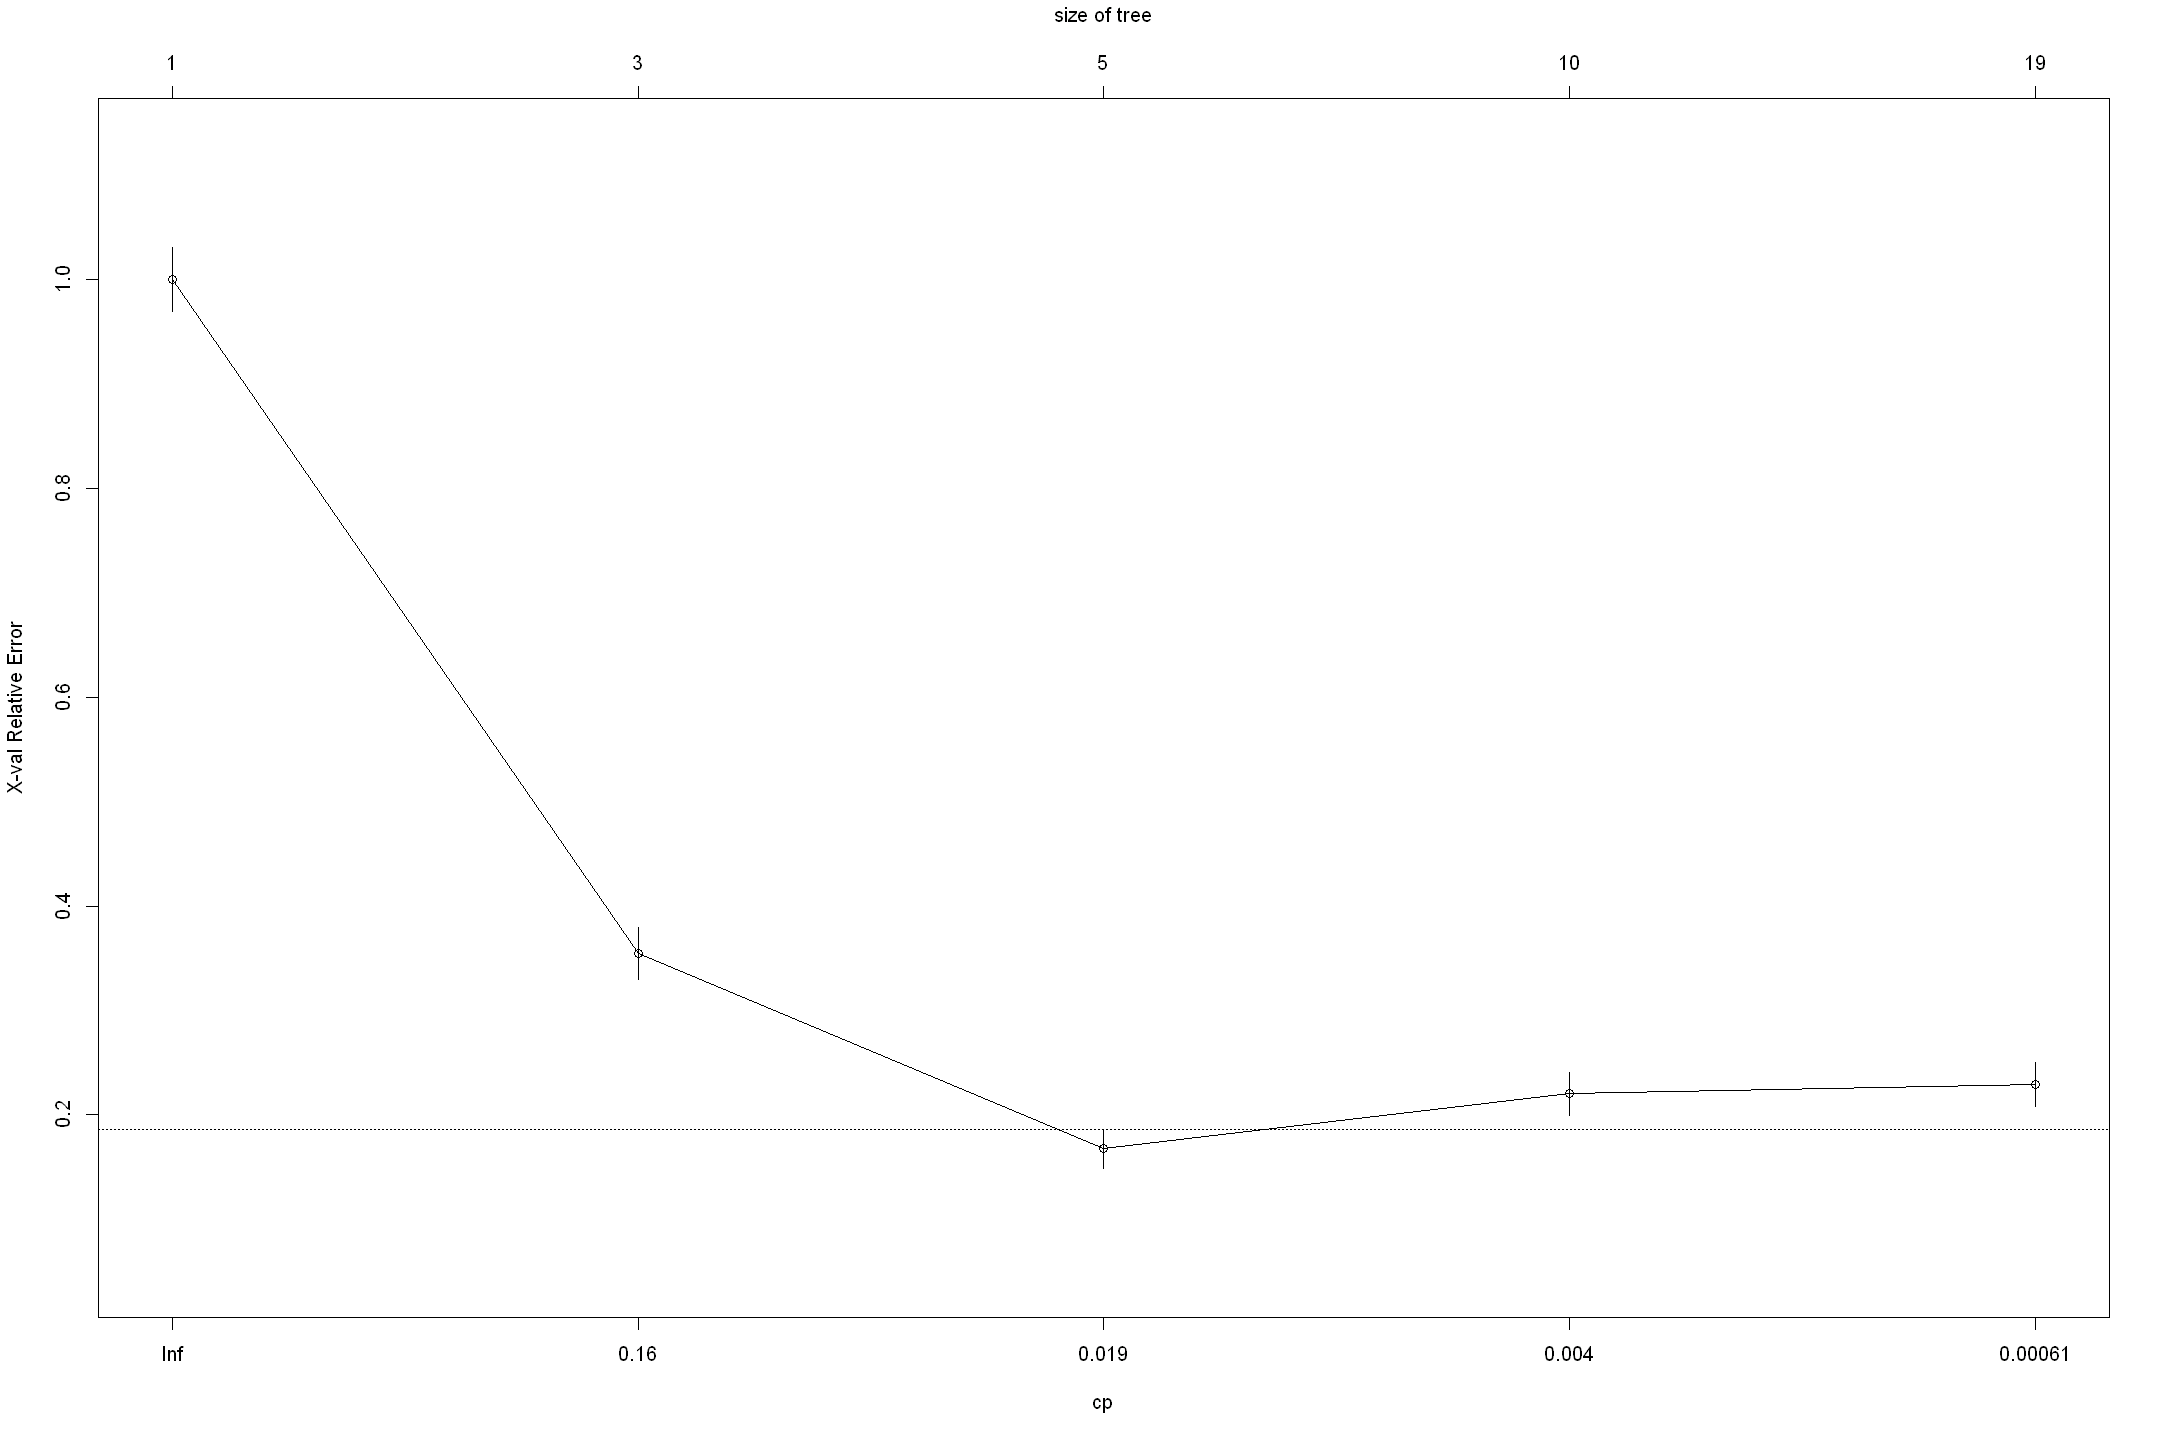

Nombre de noeuds dans l'arbre elague : 9 
Nombre de feuilles dans l'arbre elague : 19 


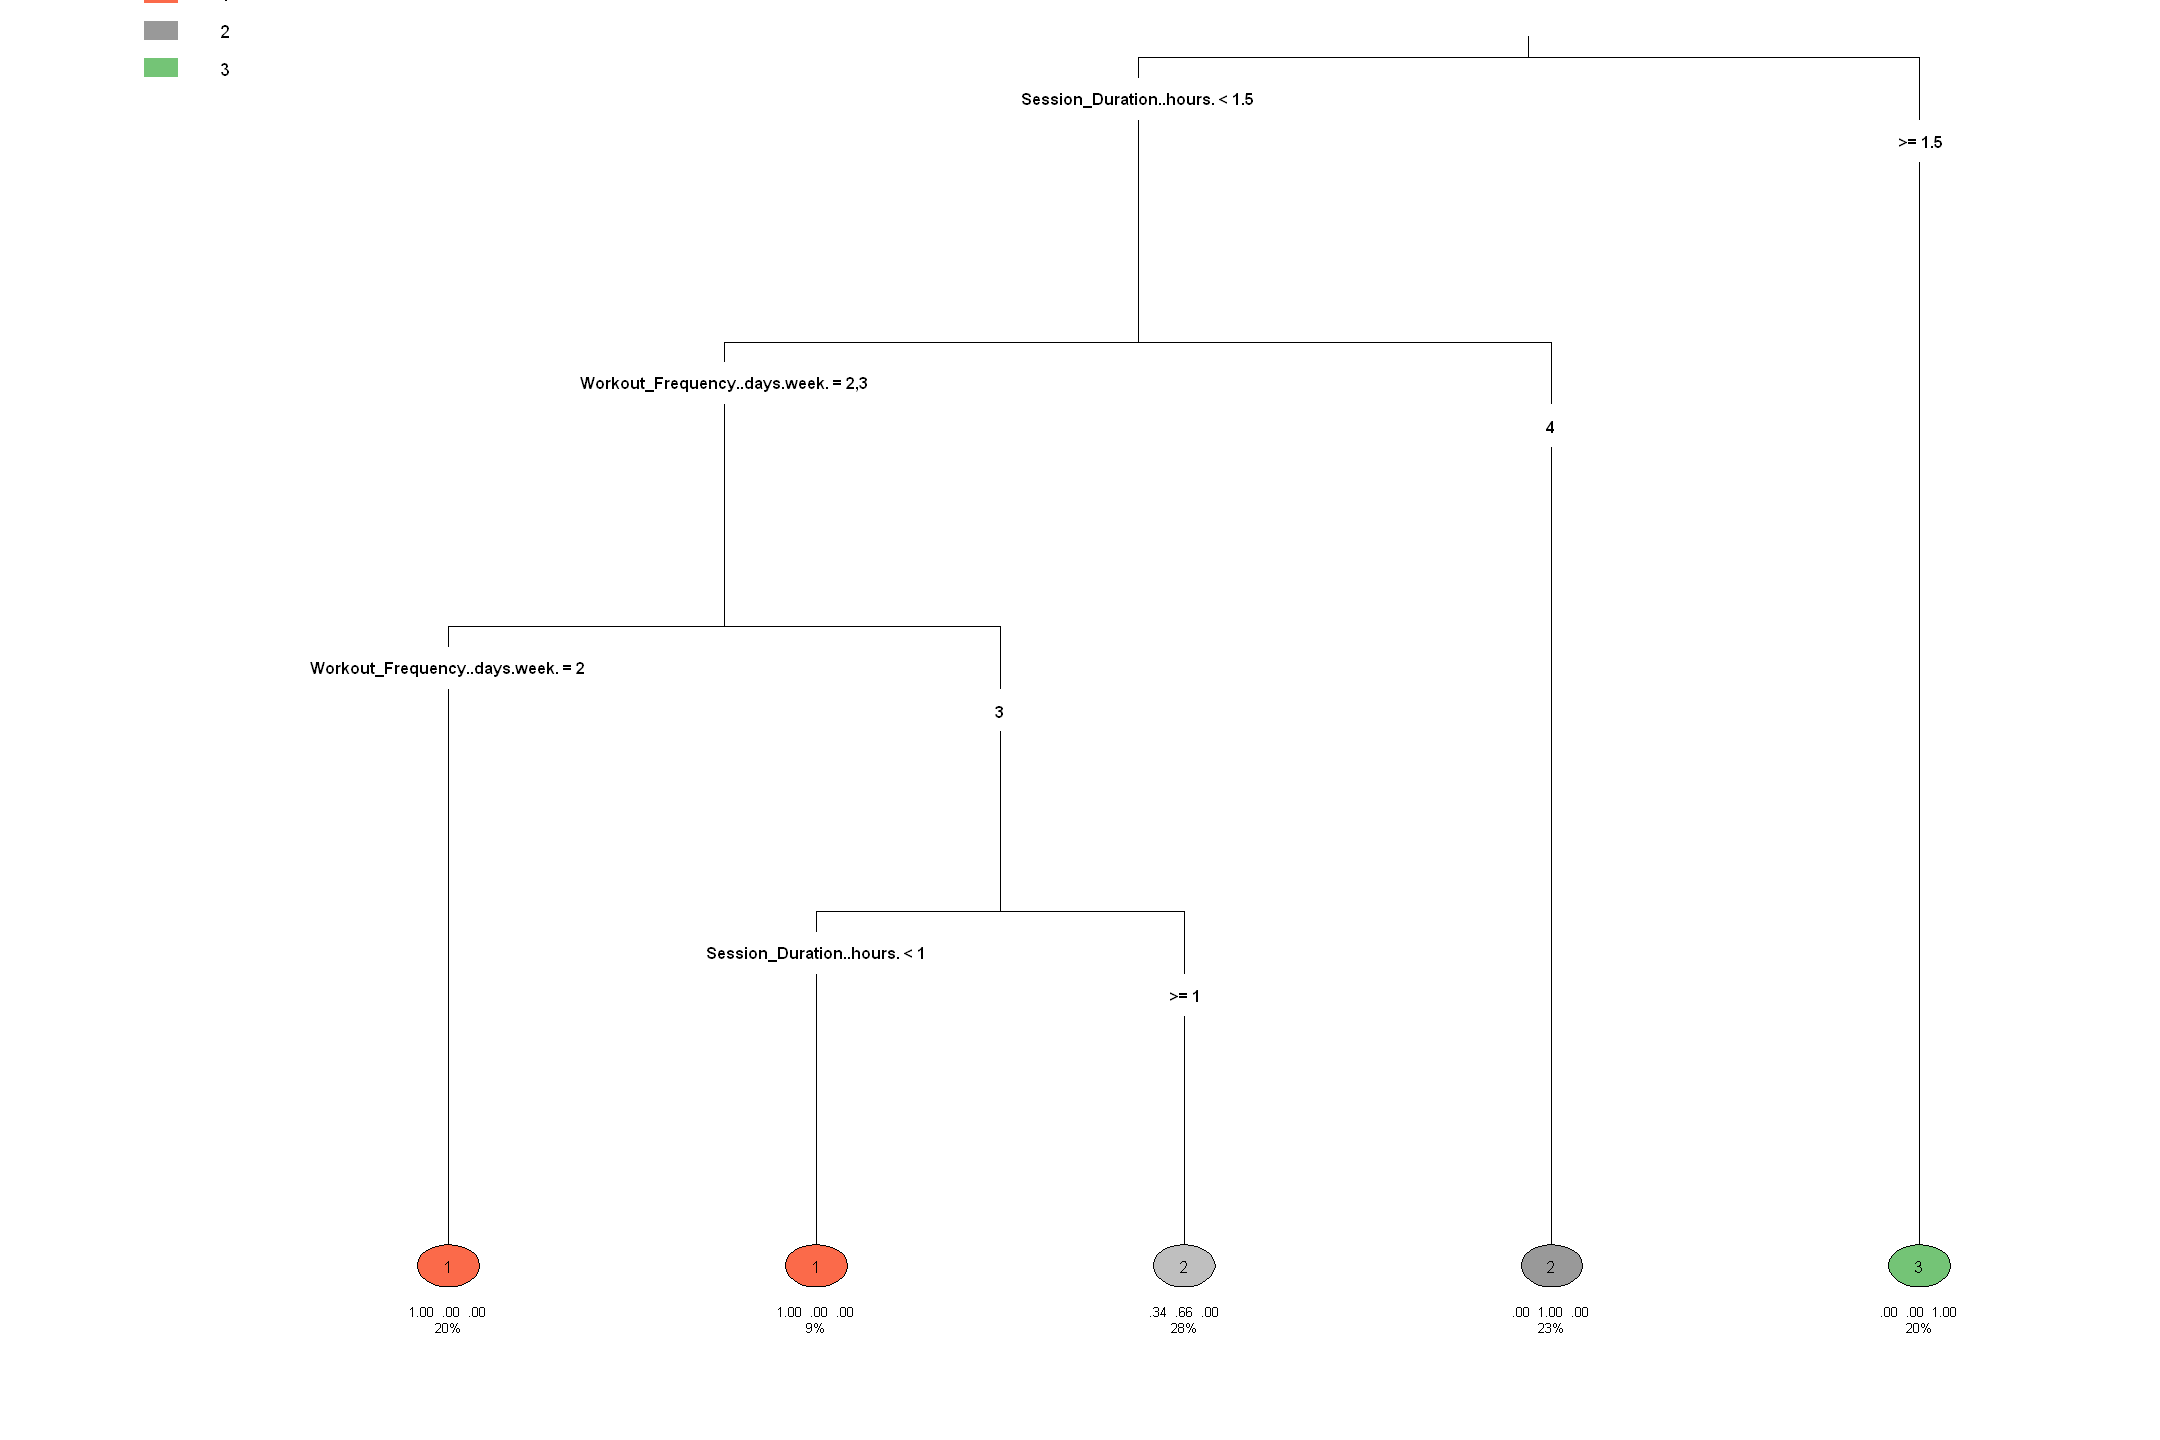

In [ ]:
# Ajuster l'arbre avec un cp faible pour explorer toute la complexité
tree.class.exp <- rpart(Experience_Level ~ ., data = gym_train, method = "class", control = rpart.control(cp = 0.0001))

# Visualiser la courbe d'erreur de validation croisée
plotcp(tree.class.exp)

# Extraire la table des cp
cp_table <- tree.class.exp$cptable

# Trouver le cp optimal (celui qui minimise l'erreur de validation croisée)
min_xerror_idx <- which.min(cp_table[,"xerror"])
cp_optimal <- cp_table[min_xerror_idx, "CP"]
cat("Le cp optimal est :", cp_optimal, "\n")

# Élaguer l'arbre avec le cp optimal
tree.class.exp.pruned <- prune(tree.class.exp, cp = cp_optimal)

# Visualiser l'arbre élagué
rpart.plot(tree.class.exp.pruned, extra = 104, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Prédictions sur le jeu de test
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")

# Matrice de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

# Afficher le nombre de noeuds et de feuilles
cat("Nombre de noeuds dans l'arbre elague :", length(tree.class.exp.pruned$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre elague :", length(tree.class.exp$frame$var[tree.class.exp$frame$var == "<leaf>"]), "\n")

In [ ]:
# Prédictions sur le jeu de test (classes et probabilités)
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")
pred_probs_test <- predict(tree.class.exp.pruned, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement (classes et probabilités)
pred_classes_train <- predict(tree.class.exp.pruned, gym_train, type = "class")
pred_probs_train <- predict(tree.class.exp.pruned, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train <- model.matrix(~gym_train$Experience_Level-1)
logloss_test <- MultiLogLoss(y_pred = pred_probs_test, y_true = actual_matrix_test)
logloss_train <- MultiLogLoss(y_pred = pred_probs_train, y_true = actual_matrix_train)

# Affichage des résultats
cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

Test Set Performance:
- Accuracy: 0.9021 
- Log loss: 0.1977 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 56  0  0
         2 19 81  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9037 
- Log loss: 0.1817 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 226   0   0
         2  75 325   0
         3   0   0 153


#### Complexité de l’arbre avant et après élagage

- **Premier arbre (cp très faible, arbre complexe) :**
  - Nombre de nœuds dans l’arbre : **37**
  - Nombre de feuilles dans l’arbre : **19**

  Cet arbre très développé s’ajuste fortement aux données d’entraînement, ce qui favorise le sur-apprentissage.

- **Arbre élagué (cp optimal) :**
  - Nombre de nœuds dans l’arbre élagué : **9**
  - Nombre de feuilles dans l’arbre élagué : **19**

  Après élagage, l’arbre conserve le même nombre de feuilles (donc la même capacité de séparation des classes), mais avec beaucoup moins de nœuds internes. Cela signifie que la structure de l’arbre est simplifiée, ce qui améliore la robustesse et la capacité de généralisation du modèle.

#### Résultats avant et après élagage

**Avant élagage (cp très faible, arbre complexe)**

- **Jeu de test :**
  - Accuracy : 0.8711
  - Log loss : 0.2528
  - L’arbre distingue bien les classes, mais il y a des confusions entre les classes 1 et 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9474
  - Log loss : 0.1257
  - Très bonne performance, mais l’écart avec le test montre un sur-apprentissage.

---

**Après élagage (cp optimal = 0.0044, arbre plus simple)**

- **Jeu de test :**
  - Accuracy : 0.9021 (en hausse)
  - Log loss : 0.1977 (en baisse, donc meilleur)
  - La matrice de confusion montre moins d’erreurs, surtout pour la classe 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9037 (en baisse, mais plus proche du test)
  - Log loss : 0.1817 (en légère hausse, mais toujours bonne)
  - Les performances sont désormais très proches entre entraînement et test.

---

**Interprétation**

L’élagage avec le cp optimal a permis de réduire le sur-apprentissage : l’écart entre les performances d’entraînement et de test a diminué.  
Le modèle généralise mieux : la précision sur le test augmente, la log loss diminue.  
L’arbre est plus simple et plus robuste : il fait moins d’erreurs sur des données non vues, même si la précision d’entraînement baisse un peu (ce qui est normal et souhaité).

**Conclusion :**  
L’utilisation du cp optimal améliore la capacité de généralisation du modèle, en évitant qu’il ne s’ajuste trop aux particularités du jeu d’entraînement. C’est exactement l’objectif de la validation croisée et de l’élagage.

### Random Forests
- Random forests with `mtry` and Brieman criterion
- Regularization with Boosting
- Using Bootstrap
- **plot** feature importance

Entraînement du modèle Random Forest

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

In [ ]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 4.4.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [ ]:
set.seed(24)
# Entraînement du modèle Random Forest
rf_model <- randomForest(Experience_Level ~ ., 
                         data = gym_train,
                         ntree = 500,           # nombre d’arbres
                         mtry = 4,              # nombre de variables testées à chaque split
                         importance = TRUE)     # permet de calculer l’importance des variables

# Résumé du modèle
print(rf_model)


Call:
 randomForest(formula = Experience_Level ~ ., data = gym_train,      ntree = 500, mtry = 4, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 10.53%
Confusion matrix:
    1   2   3 class.error
1 234  67   0  0.22259136
2  15 310   0  0.04615385
3   0   0 153  0.00000000


#### Interprétation du modèle Random Forest

Le modèle Random Forest a été entraîné pour prédire la variable **Experience_Level** à partir des données d’entraînement.

- **Nombre d’arbres :** 500
- **Variables testées à chaque split (mtry) :** 4

**Résultats sur le jeu d’entraînement (OOB)**

- **Taux d’erreur OOB (Out-Of-Bag) :** 10,53 %
  - Cela signifie que le modèle se trompe en moyenne sur 10,53 % des observations non vues lors de la construction de chaque arbre.
- **Matrice de confusion :**
  - **Classe 1 :** 230 bien classés, 71 mal classés (erreur : 23,6 %)
  - **Classe 2 :** 314 bien classés, 11 mal classés (erreur : 3,4 %)
  - **Classe 3 :** 153 bien classés, 0 mal classés (erreur : 0 %)

**Interprétation**

- Le modèle distingue très bien la classe 3 (aucune erreur) et la classe 2 (faible taux d’erreur).
- Il a plus de difficultés à bien prédire la classe 1 (23,6 % d’erreur).
- Le taux d’erreur global est faible, ce qui indique une bonne capacité de classification sur les données d’entraînement.
- L’utilisation de 500 arbres et la sélection aléatoire de variables à chaque split permettent de limiter le sur-apprentissage et d’améliorer la robustesse du modèle.

Intéressons-nous maintenant à l'évaluation de notre modèle sur nos jeux d'entraînement et de test.


In [ ]:
# Prédictions Random Forest sur le jeu de test (classes et probabilités)
pred_classes_test_rf <- predict(rf_model, gym_test, type = "class")
pred_probs_test_rf <- predict(rf_model, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement
pred_classes_train_rf <- predict(rf_model, gym_train, type = "class")
pred_probs_train_rf <- predict(rf_model, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test_rf <- confusionMatrix(pred_classes_test_rf, gym_test$Experience_Level)
conf_matrix_train_rf <- confusionMatrix(pred_classes_train_rf, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test_rf <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train_rf <- model.matrix(~gym_train$Experience_Level-1)
logloss_test_rf <- MultiLogLoss(y_pred = pred_probs_test_rf, y_true = actual_matrix_test_rf)
logloss_train_rf <- MultiLogLoss(y_pred = pred_probs_train_rf, y_true = actual_matrix_train_rf)

# Affichage des résultats
cat("Test Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_test_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test_rf$table)
cat("\n")

cat("Training Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_train_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train_rf$table)

Test Set Performance (Random Forest):
- Accuracy: 0.8866 
- Log loss: 0.2397 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 58  5  0
         2 17 76  0
         3  0  0 38

Training Set Performance (Random Forest):
- Accuracy: 1 
- Log loss: 0.0647 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 301   0   0
         2   0 325   0
         3   0   0 153


#### Interprétation des performances sur le jeu d'entraînement

Le modèle Random Forest affiche une précision (accuracy) de **100%** sur le jeu d'entraînement, ce qui signifie qu’il a correctement classé **l’intégralité des observations** de cet échantillon. Bien que ce résultat puisse sembler excellent, il doit être interprété avec prudence. En effet, cette absence totale d’erreurs sur les données d'entraînement est généralement le signe d’un **surapprentissage** (*overfitting*), c’est-à-dire que le modèle a appris **par cœur les données** plutôt que de généraliser les tendances sous-jacentes.

Ce phénomène est confirmé par la comparaison avec l’estimation de l’erreur **OOB (Out-Of-Bag)**, fournie par le modèle pendant l'entraînement, qui était d’environ **10,78%**. Cette erreur OOB est considérée comme une estimation plus fiable de la performance réelle, car elle est calculée à partir d'observations non utilisées pour construire chaque arbre.

Ainsi, bien que l’accuracy de 100% témoigne d’une forte capacité du modèle à mémoriser les données, elle ne garantit pas une bonne capacité de généralisation. L’évaluation sur un jeu de test indépendant reste indispensable pour valider les performances du modèle.


L'objectif des forêts aléatoires est de réduire la **variance des arbres de décision** tout en conservant leur pouvoir prédictif. Elles reposent sur la technique du **bagging**, qui combine **bootstraping** (tirages aléatoires avec remise) et **agrégation de prédictions** (par vote majoritaire dans le cas de la classification).

Contrairement à un arbre classique, à chaque nœud d’un arbre de la forêt, **un sous-ensemble aléatoire de variables est sélectionné** (de taille `mtry`), et la **meilleure variable parmi ce sous-ensemble** est utilisée pour réaliser la division. Ce mécanisme permet de **décorréler les arbres entre eux**, ce qui renforce la robustesse globale du modèle.

**Paramètres à optimiser :**

- **`mtry`** : nombre de variables sélectionnées aléatoirement à chaque split.
    - Dans le cas de la **classification**, la valeur empirique par défaut est `mtry ≈ √p`, où `p` est le nombre total de variables explicatives. Ici, `p = 14`, donc `mtry` vaut par défaut `√p = √14 = 4`.
    - L’optimisation de `mtry` est réalisée via la fonction `tuneRF`, qui cherche le meilleur compromis entre complexité et performance. Cette fonction commence à une valeur initiale (`mtry = 4` ici) et teste des valeurs supérieures et inférieures tant que l’erreur de généralisation mesurée par le taux d’erreur **OOB (Out-Of-Bag)** s’améliore d’au moins 5% (ce seuil est modifiable).

- **`ntree`** : nombre d’arbres dans la forêt.
    - En général, `ntree` varie de 100 à 500. Au-delà, les gains de performance sont marginaux, mais cela peut améliorer la **stabilité** de la prédiction. Dans ce projet, nous utilisons `ntree = 500` pour garantir la convergence des résultats.

Cette combinaison d’aléatoire (dans les données et dans les variables) permet à Random Forest d’offrir un excellent compromis entre **performance** et **généralisation**, même sans réglage excessif d’hyperparamètres.


##### Optimisation du `mtry`

mtry = 3  OOB error = 10.78% 
Searching left ...
mtry = 2 	OOB error = 11.68% 
-0.08333333 0.05 
Searching right ...
mtry = 4 	OOB error = 10.27% 
0.04761905 0.05 
Optimal mtry value: 4 


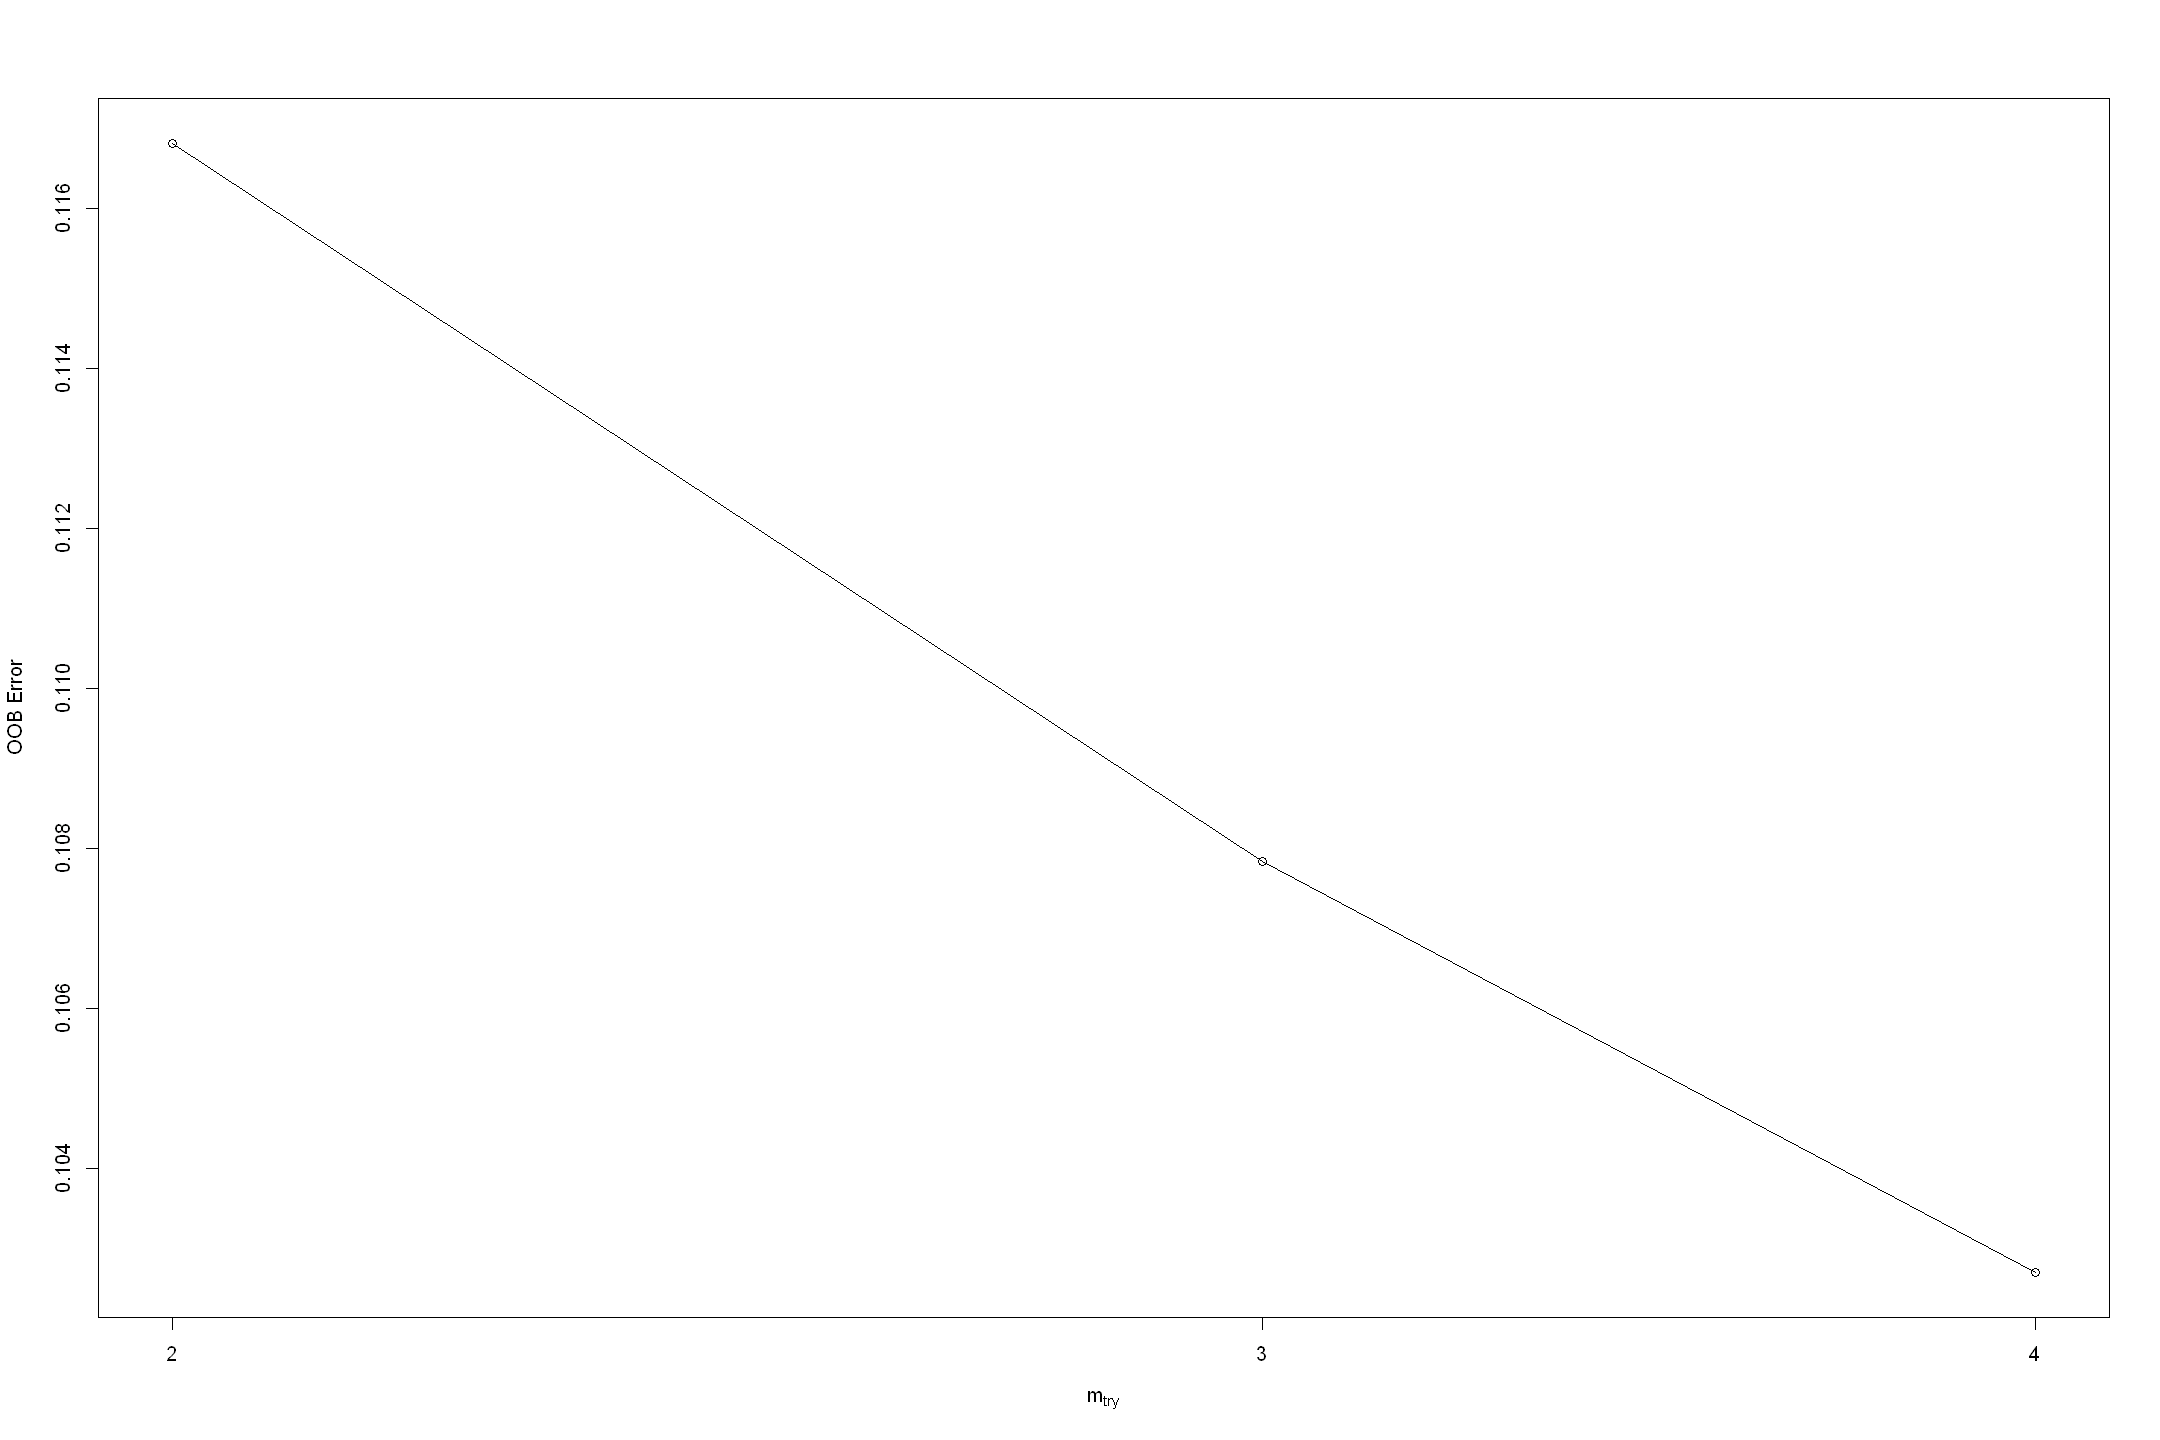

In [ ]:
set.seed(24)

# Optimisation du mtry avec tuneRF
best_mtry <- tuneRF(x = gym_train[ , -which(names(gym_train) == "Experience_Level")],
                    y = gym_train$Experience_Level,
                    stepFactor = 1.5,
                    improve = 0.05,
                    ntreeTry = 100,
                    trace = TRUE,
                    plot = TRUE,
                    doBest = TRUE)

optimal_mtry <- best_mtry$mtry
cat("Optimal mtry value:", optimal_mtry, "\n")

Le paramètre `mtry` a été optimisé automatiquement à l'aide de la fonction `tuneRF()`, qui teste différentes valeurs de `mtry` autour d'une valeur initiale (ici, `√p = 4`), en les multipliant ou divisant par un facteur `stepFactor = 1.5`. L'évaluation de chaque `mtry` est réalisée à l'aide de 100 arbres (`ntreeTry = 100`) afin d'obtenir une estimation rapide mais fiable de l'erreur OOB. 

Le processus de tuning s'arrête dès qu'aucune amélioration significative (au moins `5%`) de l'erreur OOB n’est observée (`improve = 0.05`). L’option `doBest = TRUE` permet enfin de réentraîner automatiquement un modèle avec la meilleure valeur trouvée, ce qui facilite l'intégration du tuning dans le workflow.

Cette procédure a confirmé que `mtry = 4` (valeur théorique par défaut pour la classification avec 14 variables explicatives) offrait les meilleures performances, sans amélioration notable au-delà.


In [ ]:
# Prédictions Random Forest optimisé (best_mtry) sur test et train
pred_classes_test_best <- predict(best_mtry, gym_test, type = "class")
pred_probs_test_best <- predict(best_mtry, gym_test, type = "prob")

pred_classes_train_best <- predict(best_mtry, gym_train, type = "class")
pred_probs_train_best <- predict(best_mtry, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test_best <- confusionMatrix(pred_classes_test_best, gym_test$Experience_Level)
conf_matrix_train_best <- confusionMatrix(pred_classes_train_best, gym_train$Experience_Level)

# Log loss (MultiLogLoss)
actual_matrix_test_best <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train_best <- model.matrix(~gym_train$Experience_Level-1)
logloss_test_best <- MultiLogLoss(y_pred = pred_probs_test_best, y_true = actual_matrix_test_best)
logloss_train_best <- MultiLogLoss(y_pred = pred_probs_train_best, y_true = actual_matrix_train_best)

# Affichage des résultats
cat("Test Set Performance (Random Forest optimisé):\n")
cat("- Accuracy:", round(conf_matrix_test_best$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test_best, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test_best$table)
cat("\n")

cat("Training Set Performance (Random Forest optimisé):\n")
cat("- Accuracy:", round(conf_matrix_train_best$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train_best, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train_best$table)

Test Set Performance (Random Forest optimisé):
- Accuracy: 0.8918 
- Log loss: 0.2458 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 57  3  0
         2 18 78  0
         3  0  0 38

Training Set Performance (Random Forest optimisé):
- Accuracy: 1 
- Log loss: 0.0653 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 301   0   0
         2   0 325   0
         3   0   0 153


In [ ]:
install.packages("randomForestSRC")
install.packages("ggRandomForests")

package 'randomForestSRC' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'randomForestSRC'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\doria\AppData\Local\Programs\R\R-4.4.1\library\00LOCK\randomForestSRC\libs\x64\randomForestSRC.dll to C:\Users\doria\AppData\Local\Programs\R\R-4.4.1\library\randomForestSRC\libs\x64\randomForestSRC.dll: Permission denied"
Warning message:
"restored 'randomForestSRC'"



The downloaded binary packages are in
	C:\Users\doria\AppData\Local\Temp\RtmpC6RRab\downloaded_packages
package 'ggRandomForests' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\doria\AppData\Local\Temp\RtmpC6RRab\downloaded_packages


In [ ]:
install.packages("ggRandomForest")

Warning message:
"package 'ggRandomForest' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


Warning message:
"package 'ggRandomForests' was built under R version 4.4.3"
Loading required package: randomForestSRC

Warning message:
"package 'randomForestSRC' was built under R version 4.4.3"

 randomForestSRC 3.3.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: 'randomForestSRC'


The following objects are masked from 'package:e1071':

    impute, tune


The following object is masked from 'package:purrr':

    partial




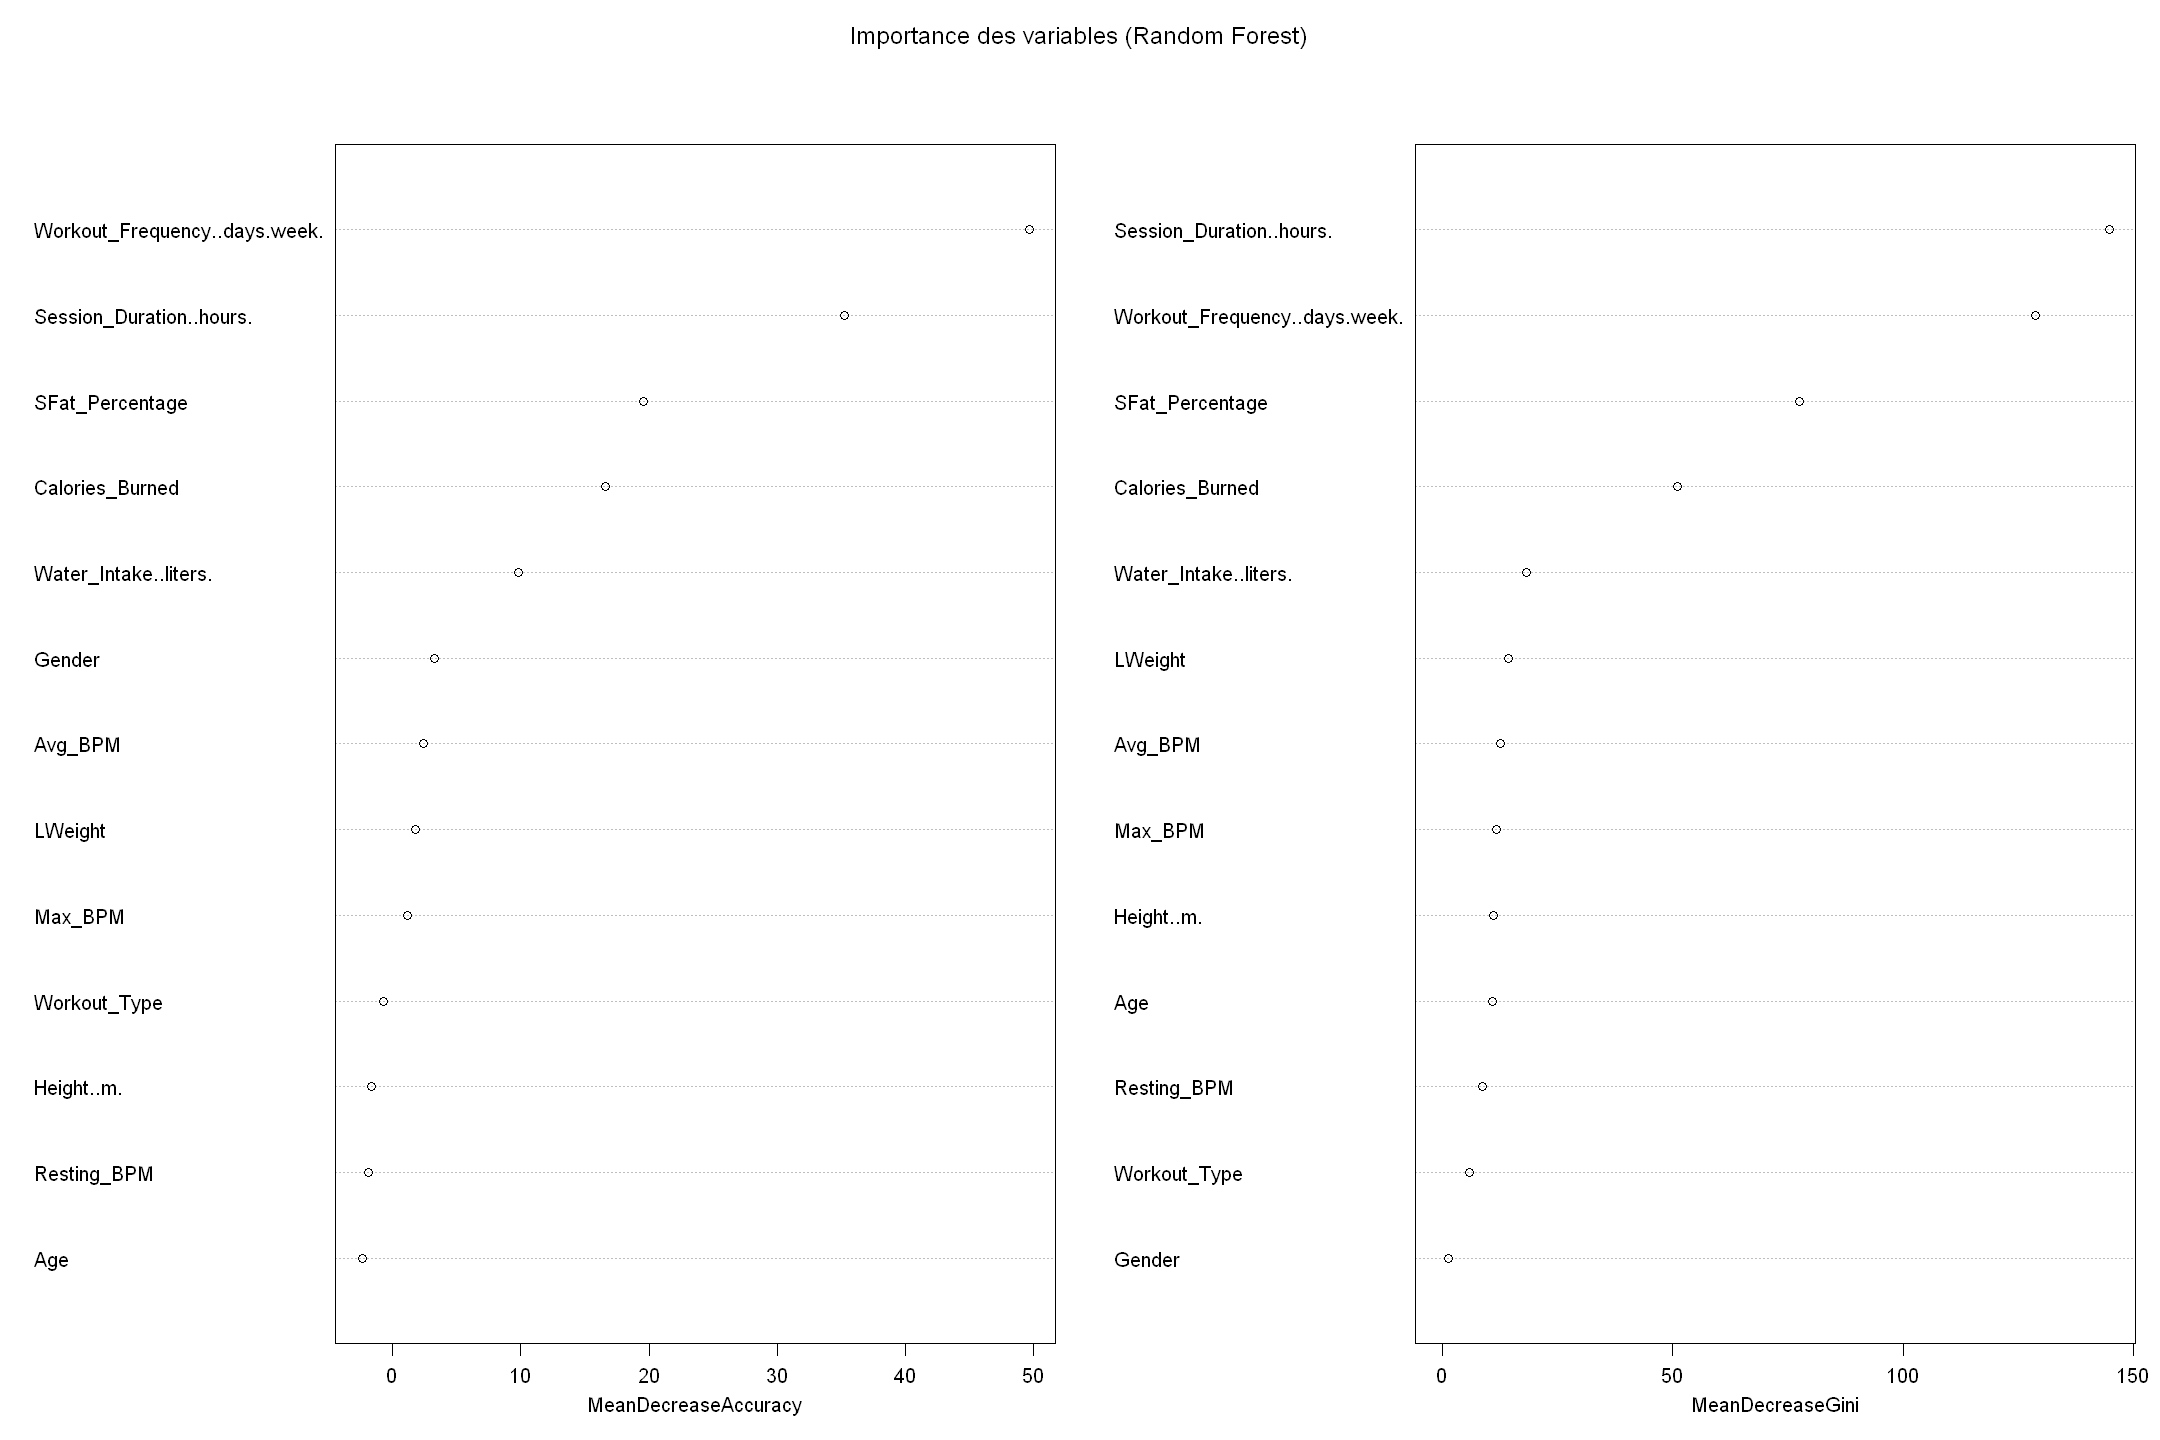

In [ ]:
# Importance des variables
library(ggRandomForests)

#Plot importance
varImpPlot(rf_model, main = "Importance des variables (Random Forest)")

L'importance des variables a été évaluée à l’aide des mesures intégrées à l’algorithme Random Forest. Deux métriques complémentaires ont été analysées :

- **Mean Decrease in Accuracy** : elle mesure la perte de précision du modèle lorsque les valeurs d’une variable sont aléatoirement permutées. Cette mesure est considérée comme la plus fiable car elle reflète directement l’impact de la variable sur la performance globale du modèle.
- **Mean Decrease in Gini** : elle correspond à la réduction moyenne de l’impureté des nœuds (indice de Gini) induite par l’utilisation d’une variable pour diviser les données dans les arbres. Bien qu’efficace, cette métrique peut être biaisée en faveur des variables numériques continues.

Le graphique montre que des variables telles que `Session_Duration..hours.`, `Workout_Frequency` ou encore `Fat_Percentage` sont parmi les plus influentes dans la prédiction du niveau d’expérience. Ces résultats sont cohérents avec l’analyse exploratoire, qui avait déjà mis en évidence des corrélations fortes entre ces variables et la variable cible `Experience_Level`.

Cette observation est tout à fait cohérente : les profils les plus expérimentés sont aussi ceux qui cumulent une fréquence d'entraînement élevée, un volume d’exercice important et un taux de masse grasse plus bas, autant d’indicateurs caractéristiques d’une pratique sportive régulière et avancée.

L’analyse de l’importance des variables permet non seulement d’interpréter le modèle, mais aussi d’identifier les facteurs les plus déterminants dans la progression des adhérents d'une salle de sport.


### Boosting
#### Avec la librairie `xgboost`


#### 1. Entraînement d'un premier modèle baseline

Nous avons d'abord construit un modèle de base en spécifiant les paramètres suivants :
- `objective = "multi:softprob"` : configuration adaptée à une classification multi-classes, permettant d'obtenir les probabilités associées à chaque classe.
- `num_class = 3` : car la variable cible comporte trois niveaux.
- `eval_metric = "mlogloss"` : la fonction de perte choisie est le log loss, adaptée aux probabilités.
- `eta = 0.1` : taux d'apprentissage modéré pour stabiliser l'entraînement.
- `max_depth = 6` : profondeur maximale des arbres.
- `subsample = 0.8` et `colsample_bytree = 0.8` : échantillonnage partiel des données et des variables pour limiter le surapprentissage.

Ce modèle initial a été entraîné avec 300 arbres (`nrounds = 300`).  
Les prédictions ont ensuite été obtenues sous forme de probabilités pour chaque classe.  
La classe prédite correspond à celle ayant la probabilité la plus élevée.

Une évaluation préliminaire par **matrice de confusion** sur le jeu de test a permis d'obtenir une **accuracy de 85.57%**.

---

In [ ]:
library(xgboost)
library(caret)

# Créer les matrices d'entraînement
X_train <- model.matrix(Experience_Level ~ . -1, data = gym_train)
y_train <- as.numeric(gym_train$Experience_Level) - 1  # XGBoost demande des labels 0, 1, 2

X_test <- model.matrix(Experience_Level ~ . -1, data = gym_test)
y_test <- as.numeric(gym_test$Experience_Level) - 1

# Transformer en objets DMatrix pour XGBoost
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest <- xgb.DMatrix(data = X_test, label = y_test)


Warning message:
"package 'xgboost' was built under R version 4.4.3"

Attaching package: 'xgboost'


The following object is masked from 'package:plotly':

    slice


The following object is masked from 'package:dplyr':

    slice




In [ ]:
# Définir les paramètres
params <- list(
  objective = "multi:softprob",   # pour multi-classes avec probabilités
  num_class = 3,                  # 3 classes ici
  eval_metric = "mlogloss"         # log loss pour la stabilité
)

# Entraîner
set.seed(24)
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 300,          # 300 arbres
  eta = 0.1,              # learning rate correct
  max_depth = 6,          # arbres raisonnablement profonds
  subsample = 0.8,        # sous-échantillonnage pour éviter overfitting
  colsample_bytree = 0.8, # sous-échantillonnage des colonnes
  verbose = 0
)


In [ ]:
# Prédictions : probabilités
pred_probs <- predict(xgb_model, newdata = dtest)

# Reformater en matrice : chaque ligne correspond à un individu
pred_matrix <- matrix(pred_probs, ncol = 3, byrow = TRUE)

# Prendre la classe la plus probable
pred_classes <- max.col(pred_matrix) - 1  # car max.col commence à 1

# Comparer aux vraies classes
confusionMatrix(as.factor(pred_classes), as.factor(y_test))

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 57 14  0
         1 18 67  0
         2  0  0 38

Overall Statistics
                                          
               Accuracy : 0.8351          
                 95% CI : (0.7752, 0.8844)
    No Information Rate : 0.4175          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7411          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.7600   0.8272   1.0000
Specificity            0.8824   0.8407   1.0000
Pos Pred Value         0.8028   0.7882   1.0000
Neg Pred Value         0.8537   0.8716   1.0000
Prevalence             0.3866   0.4175   0.1959
Detection Rate         0.2938   0.3454   0.1959
Detection Prevalence   0.3660   0.4381   0.1959
Balanced Accuracy      0.8212   0.8339   1.0000

#### 2. Optimisation des hyperparamètres par validation croisée

Afin d'améliorer ce modèle, nous avons mis en place une **recherche sur grille (grid search)** couplée à une **validation croisée 5 folds**.  
La grille explorait les paramètres suivants :
- `nrounds` : 300 et 500
- `max_depth` : 4, 6, 8
- `eta` : 0.05 et 0.1
- `gamma` : 0 et 1
- `colsample_bytree` : 0.7 et 1
- `min_child_weight` : 1 et 5
- `subsample` : 0.7 et 1

Le critère d'optimisation était la **précision (`Accuracy`)** sur les données de validation.

Cette recherche a permis d'identifier la meilleure combinaison d'hyperparamètres.

---

In [ ]:
# Grille d'hyperparamètres à explorer
grid <- expand.grid(
  nrounds = c(300, 500),
  max_depth = c(4, 6, 8),
  eta = c(0.05, 0.1),
  gamma = c(0, 1),
  colsample_bytree = c(0.7, 1),
  min_child_weight = c(1, 5),
  subsample = c(0.7, 1)
)

# 5-fold CV
ctrl <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = TRUE,
  allowParallel = TRUE
)

set.seed(24)
xgb_tuned_full <- train(
  Experience_Level ~ .,
  data = gym_train, # Utiliser gym_train au lieu de train_data
  method = "xgbTree",
  trControl = ctrl,
  tuneGrid = grid,
  metric = "Accuracy",
  verbose = 0 # Mettre à 1 ou TRUE pour voir la progression si désiré
)


#### 3. Entraînement du modèle final

Un modèle final a ensuite été réentraîné sur l'intégralité du jeu `gym_train` en utilisant les hyperparamètres optimaux trouvés.  
Ce modèle utilise :
- Le meilleur `nrounds`
- Le meilleur `max_depth`
- Le meilleur `eta`, `gamma`, `subsample`, `colsample_bytree`, `min_child_weight`

---

In [ ]:
# Extraire les meilleurs paramètres trouvés
best_params <- xgb_tuned_full$bestTune

# Créer une matrice DMatrix pour tout gym_train
dtrain <- xgb.DMatrix(data = X_train, label = y_train)

# Réentraîner avec les meilleurs hyperparamètres
set.seed(24)
xgb_final_model <- xgboost(
  data = dtrain,
  objective = "multi:softprob",
  num_class = 3,
  eval_metric = "mlogloss",
  nrounds = best_params$nrounds,
  max_depth = best_params$max_depth,
  eta = best_params$eta,
  gamma = best_params$gamma,
  colsample_bytree = best_params$colsample_bytree,
  min_child_weight = best_params$min_child_weight,
  subsample = best_params$subsample,
  verbose = 0
)

#### 4. Évaluation finale

Les prédictions finales sur le jeu de test `gym_test` ont été réalisées en prenant la classe associée à la probabilité la plus élevée.

L'évaluation par **matrice de confusion** a permis d'obtenir une **accuracy finale** (précision) correspondant à la performance maximale atteinte par le modèle optimisé.

---

In [ ]:
# Prédictions finales XGBoost sur le jeu de test (probabilités)
pred_probs_final <- predict(xgb_final_model, newdata = dtest)
pred_matrix_final <- matrix(pred_probs_final, ncol = 3, byrow = TRUE)

# Classe prédite = colonne avec la probabilité max (commence à 1)
pred_classes_final <- max.col(pred_matrix_final)
# Adapter les niveaux pour correspondre à gym_test$Experience_Level
pred_classes_final_factor <- factor(pred_classes_final, levels = 1:3, labels = levels(gym_test$Experience_Level))

# Calcul MultiLogLoss pour le test
actual_matrix_test_xgb <- model.matrix(~gym_test$Experience_Level-1)
logloss_test_xgb <- MultiLogLoss(y_pred = pred_matrix_final, y_true = actual_matrix_test_xgb)

# Accuracy et matrice de confusion (test)
conf_matrix_test_xgb <- confusionMatrix(pred_classes_final_factor, gym_test$Experience_Level)
accuracy_test_xgb <- conf_matrix_test_xgb$overall["Accuracy"]

# Prédictions sur le jeu d'entraînement (probabilités)
pred_probs_train_final <- predict(xgb_final_model, newdata = dtrain)
pred_matrix_train_final <- matrix(pred_probs_train_final, ncol = 3, byrow = TRUE)
pred_classes_train_final <- max.col(pred_matrix_train_final)
pred_classes_train_final_factor <- factor(pred_classes_train_final, levels = 1:3, labels = levels(gym_train$Experience_Level))

actual_matrix_train_xgb <- model.matrix(~gym_train$Experience_Level-1)
logloss_train_xgb <- MultiLogLoss(y_pred = pred_matrix_train_final, y_true = actual_matrix_train_xgb)

# Accuracy et matrice de confusion (train)
conf_matrix_train_xgb <- confusionMatrix(pred_classes_train_final_factor, gym_train$Experience_Level)
accuracy_train_xgb <- conf_matrix_train_xgb$overall["Accuracy"]

# Affichage des résultats
cat("MultiLogLoss XGBoost (test):", round(logloss_test_xgb, 4), "\n")
cat("Accuracy XGBoost (test):", round(accuracy_test_xgb, 4), "\n")
cat("Matrice de confusion (test):\n")
print(conf_matrix_test_xgb$table)
cat("\n")

cat("MultiLogLoss XGBoost (train):", round(logloss_train_xgb, 4), "\n")
cat("Accuracy XGBoost (train):", round(accuracy_train_xgb, 4), "\n")
cat("Matrice de confusion (train):\n")
print(conf_matrix_train_xgb$table)

MultiLogLoss XGBoost (test): 0.2236 
Accuracy XGBoost (test): 0.8814 
Matrice de confusion (test):
          Reference
Prediction  1  2  3
         1 56  4  0
         2 19 77  0
         3  0  0 38

MultiLogLoss XGBoost (train): 0.1417 
Accuracy XGBoost (train): 0.9461 
Matrice de confusion (train):
          Reference
Prediction   1   2   3
         1 259   0   0
         2  42 325   0
         3   0   0 153


## Conclusions Classification

#### Tableau recapitulatif 

In [ ]:
print(results)

                  Methode Accuracy   LogLoss     Temps
Accuracy            Logit   0.8608 0.2558057  3.738958
Accuracy1             LDA   0.8557 0.2298512  2.246977
Accuracy2             KNN   0.7784 0.4992530  2.820027
Accuracy3     SVM radiale   0.8505 0.2774857 30.340128
Accuracy4 SVM polynomiale   0.8557 0.2544166 13.126528


Voici une synthèse combinée des performances des différents modèles testés pour prédire le niveau d'expérience (Experience_Level) :

| Modèle            | Accuracy | Log Loss | Temps (s) |
| :---------------- | :------- | :------- | :-------- |
| **CART**          | **0.902**| **0.198**| N/A       |
| Random Forest     | 0.892    | 0.246    | N/A       |
| XGBoost           | 0.881    | 0.224    | 20 min    |
| Logit             | 0.8608   | 0.2558   | 3.74      |
| LDA               | 0.8557   | 0.2299   | **2.25**  |
| SVM polynomiale   | 0.8557   | 0.2544   | 13.13     |
| SVM radiale       | 0.8505   | 0.2775   | 30.34     |
| KNN               | 0.7784   | 0.4993   | 2.82      |




Plusieurs modèles d'apprentissage supervisé ont été évalués :

1.  **CART (Classification and Regression Trees)** : Affiche la meilleure performance globale avec l'**accuracy la plus élevée (90.2%)** et la **log loss la plus faible (0.198)**. Cela indique une excellente capacité de classification et des probabilités de prédiction bien calibrées. Son interprétabilité est également un atout.

2.  **Random Forest** : Obtient une très bonne accuracy (89.2%) et une log loss de 0.246. Le modèle est robuste et performant, mais ses probabilités sont un peu moins précises que celles du CART.

3.  **XGBoost** : Atteint une accuracy de 88.1% et une log loss de 0.224. Malgré un tuning approfondi, il reste légèrement en retrait en termes d'accuracy sur ce jeu de données, mais ses probabilités sont mieux calibrées que celles du Random Forest et proches de celles de LDA.

4.  **LDA (Analyse Discriminante Linéaire)** : Ressort comme un modèle très performant, en particulier si l'on considère le compromis performance/rapidité. Il combine une bonne accuracy (85.57%), une excellente log loss (0.230, la deuxième meilleure) et le **temps de calcul le plus court (2.25s)**. Il offre une bonne capacité de discrimination et des probabilités bien calibrées.

5.  **Régression Logistique (Logit)** : Obtient des résultats très proches de ceux de LDA en termes d'accuracy (86.08%) et une log loss de 0.256. Elle reste une alternative robuste, explicable, fiable et rapide (3.74s).

6.  **SVM (Machines à Vecteurs de Support)** :
    *   Le **SVM avec noyau polynomial** (Accuracy: 85.57%, Log Loss: 0.254) donne de bons résultats, comparables à LDA et Logit, mais il est nettement plus lent (13.13s).
    *   Le **SVM avec noyau radial** (Accuracy: 85.05%, Log Loss: 0.277) est encore plus lent (30.34s) sans offrir d'avantage significatif en performance.

7.  **KNN (K Plus Proches Voisins)** : Est clairement le modèle le moins performant ici, avec l'accuracy la plus faible (77.84%) et la log loss la plus élevée (0.499), indiquant qu'il distingue mal les classes.

**Conclusion :**

Pour ce jeu de données, le modèle **CART** se révèle le plus performant en termes de précision pure et de qualité des probabilités.

Cependant, si la rapidité d'exécution est un critère primordial tout en maintenant une excellente qualité de prédiction probabiliste, **LDA** et la **Régression Logistique** sont d'excellents choix, offrant un très bon compromis entre précision, qualité des probabilités et vitesse.

Bien que Random Forest et XGBoost (qui est particulièrement long à l'execution) soient réputés pour leur puissance, ils n'ont pas surpassé le modèle CART plus simple sur cet ensemble de données spécifique. Le choix final du modèle dépendra du compromis souhaité entre performance pure, interprétabilité, qualité des probabilités et contraintes de temps de calcul.

**Courbes ROC**

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Sett

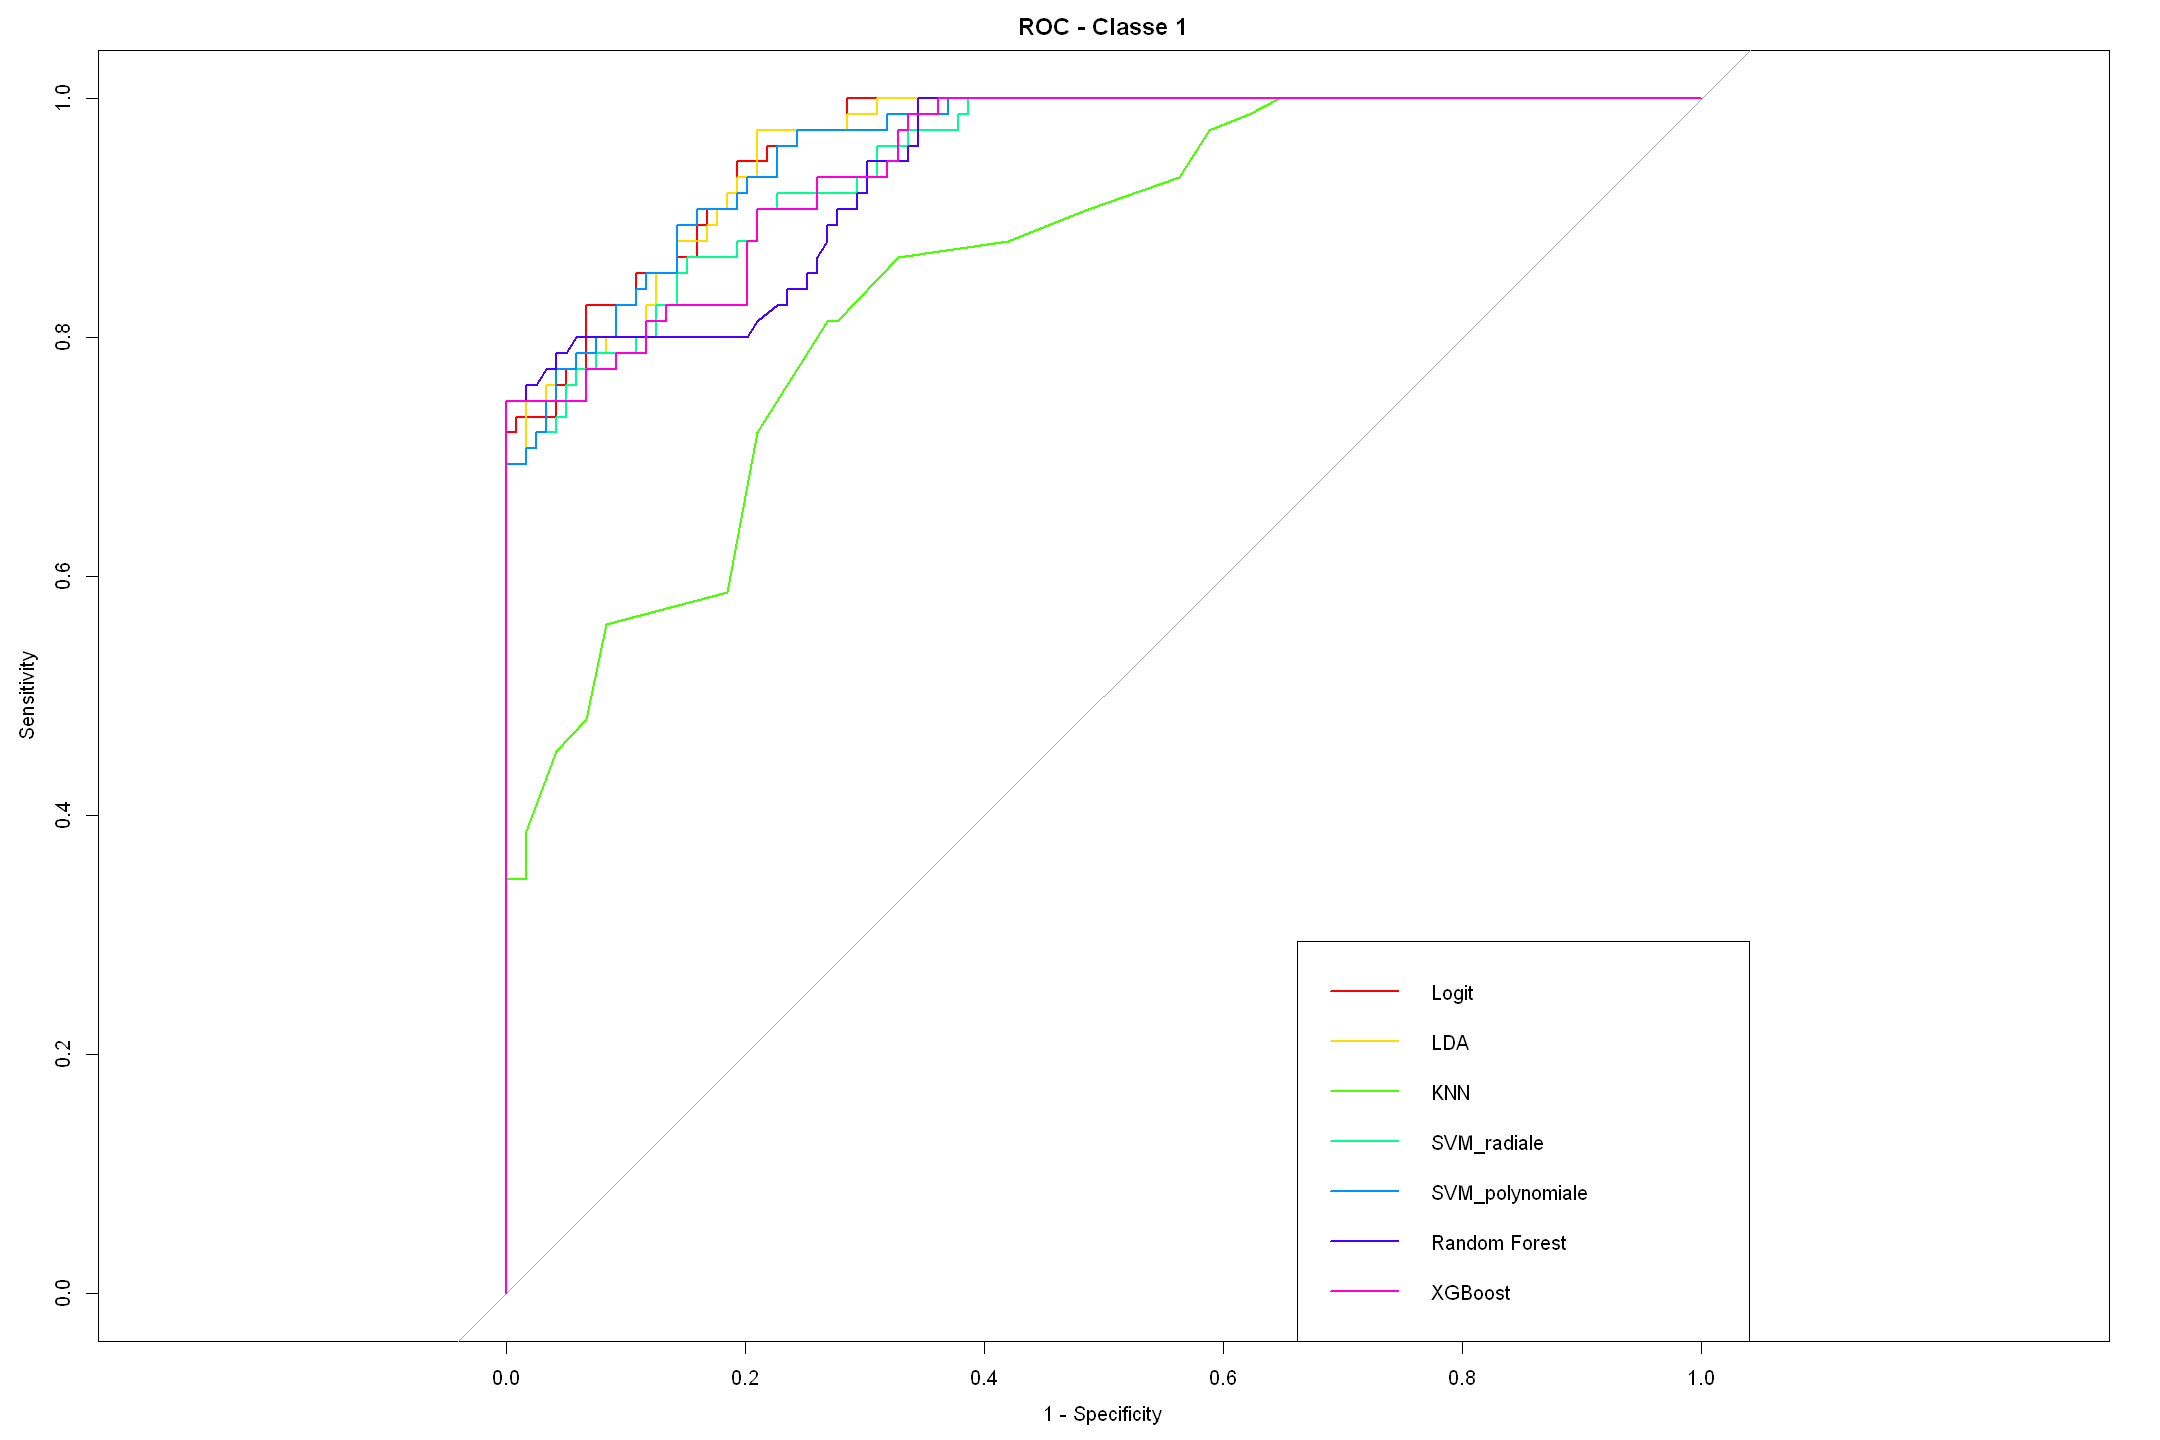

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



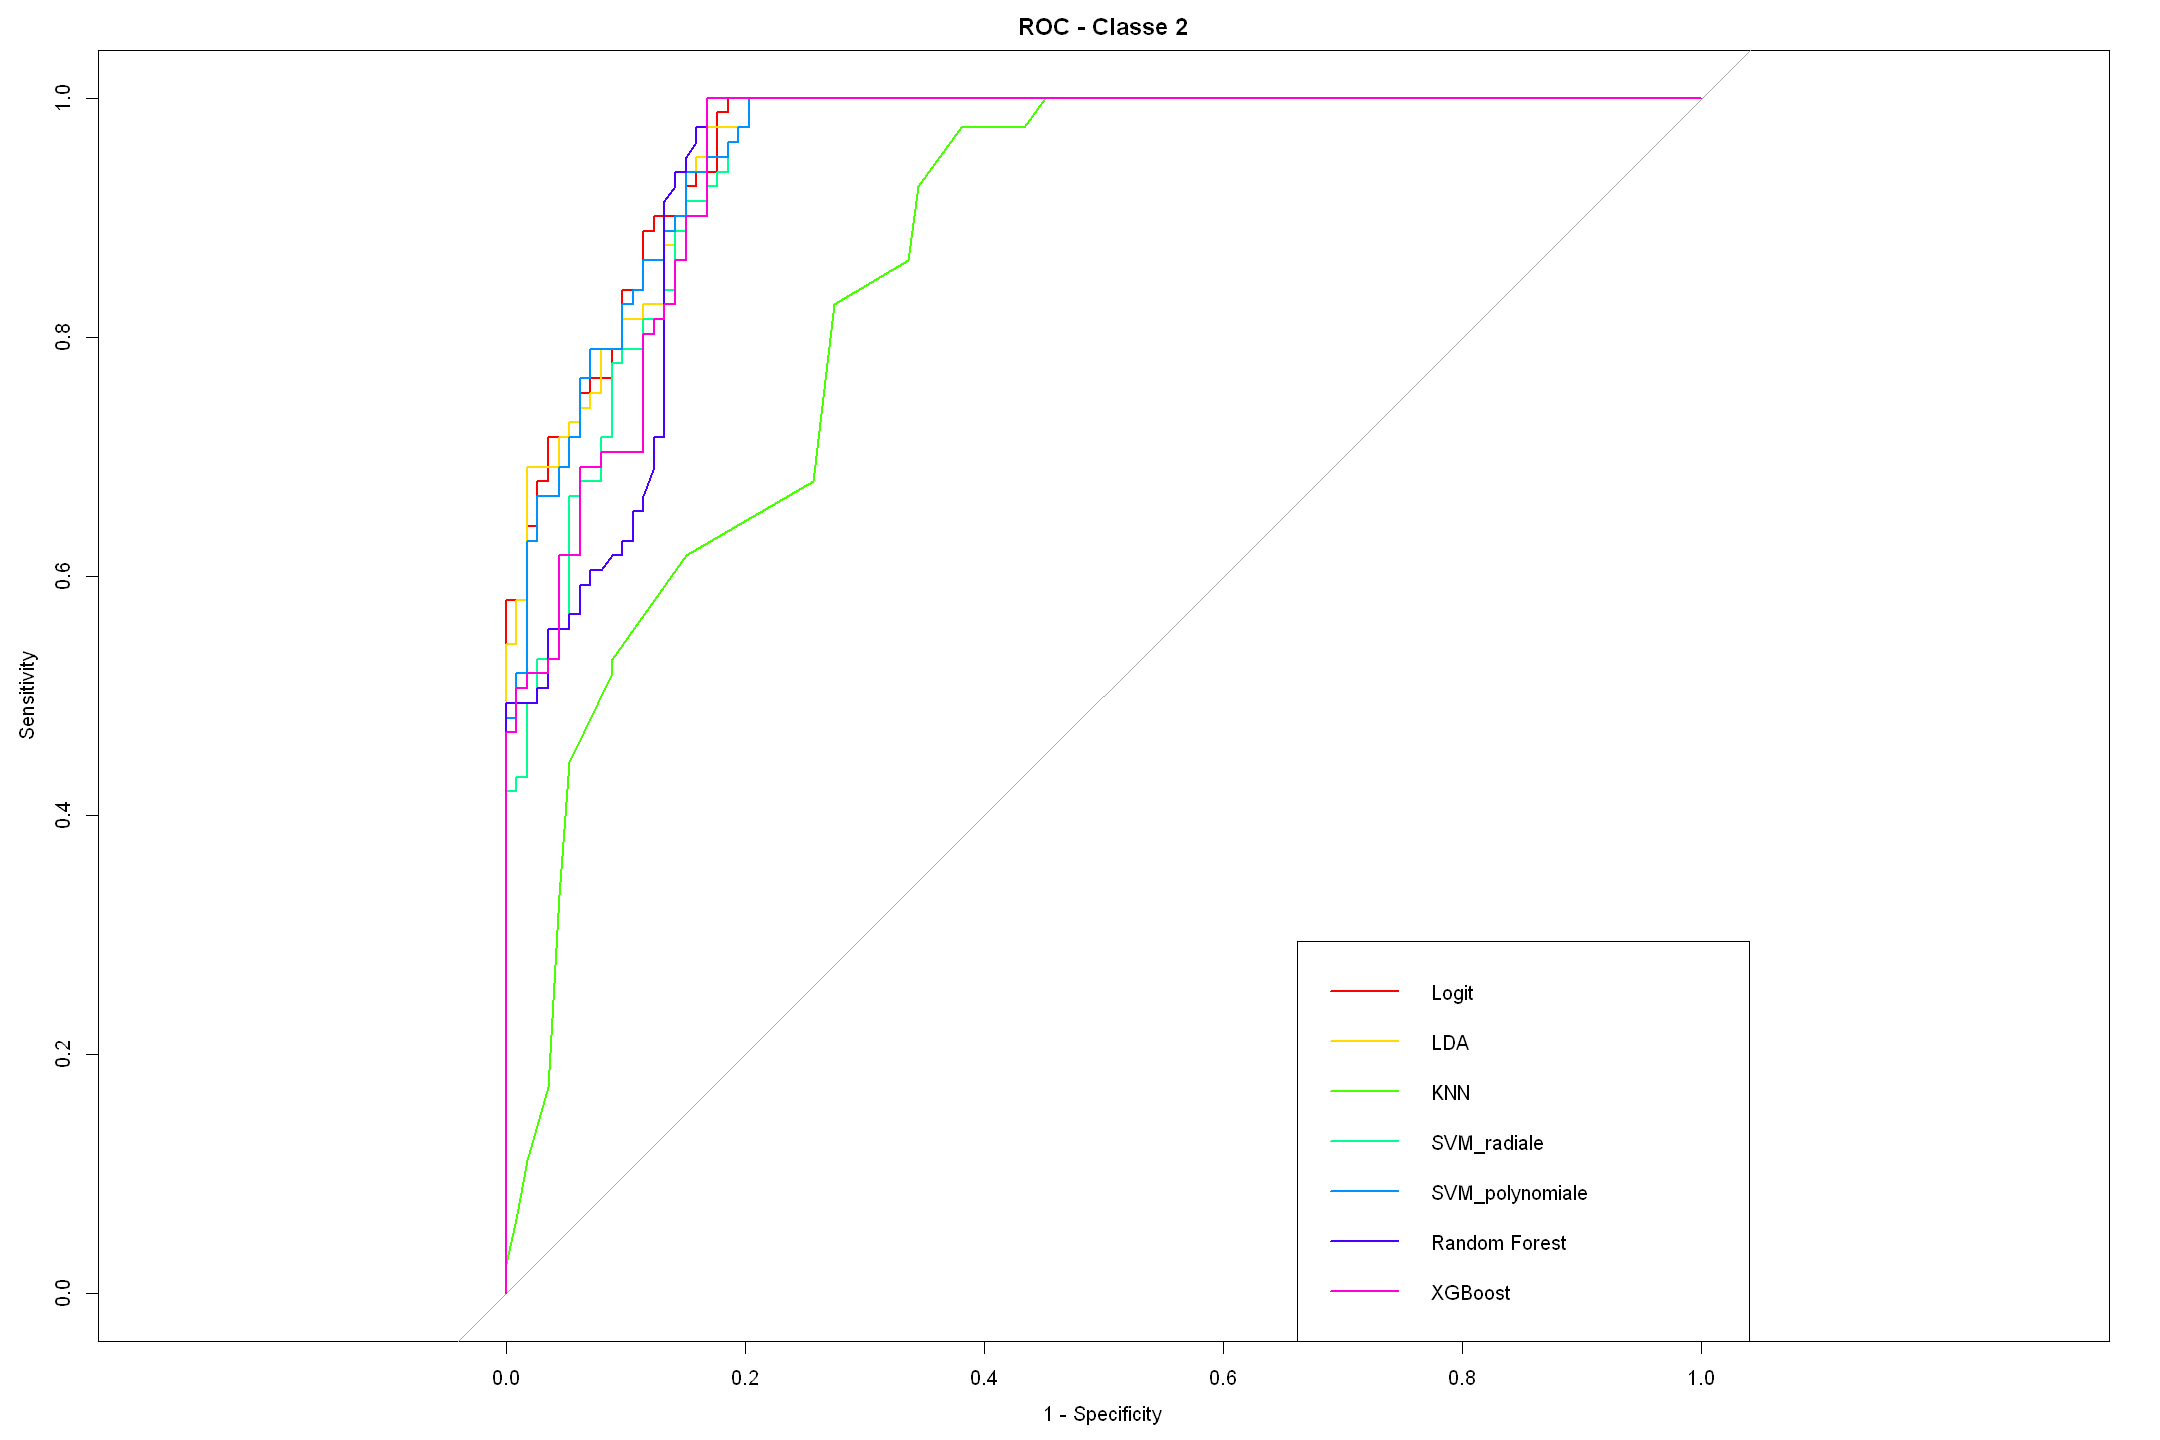

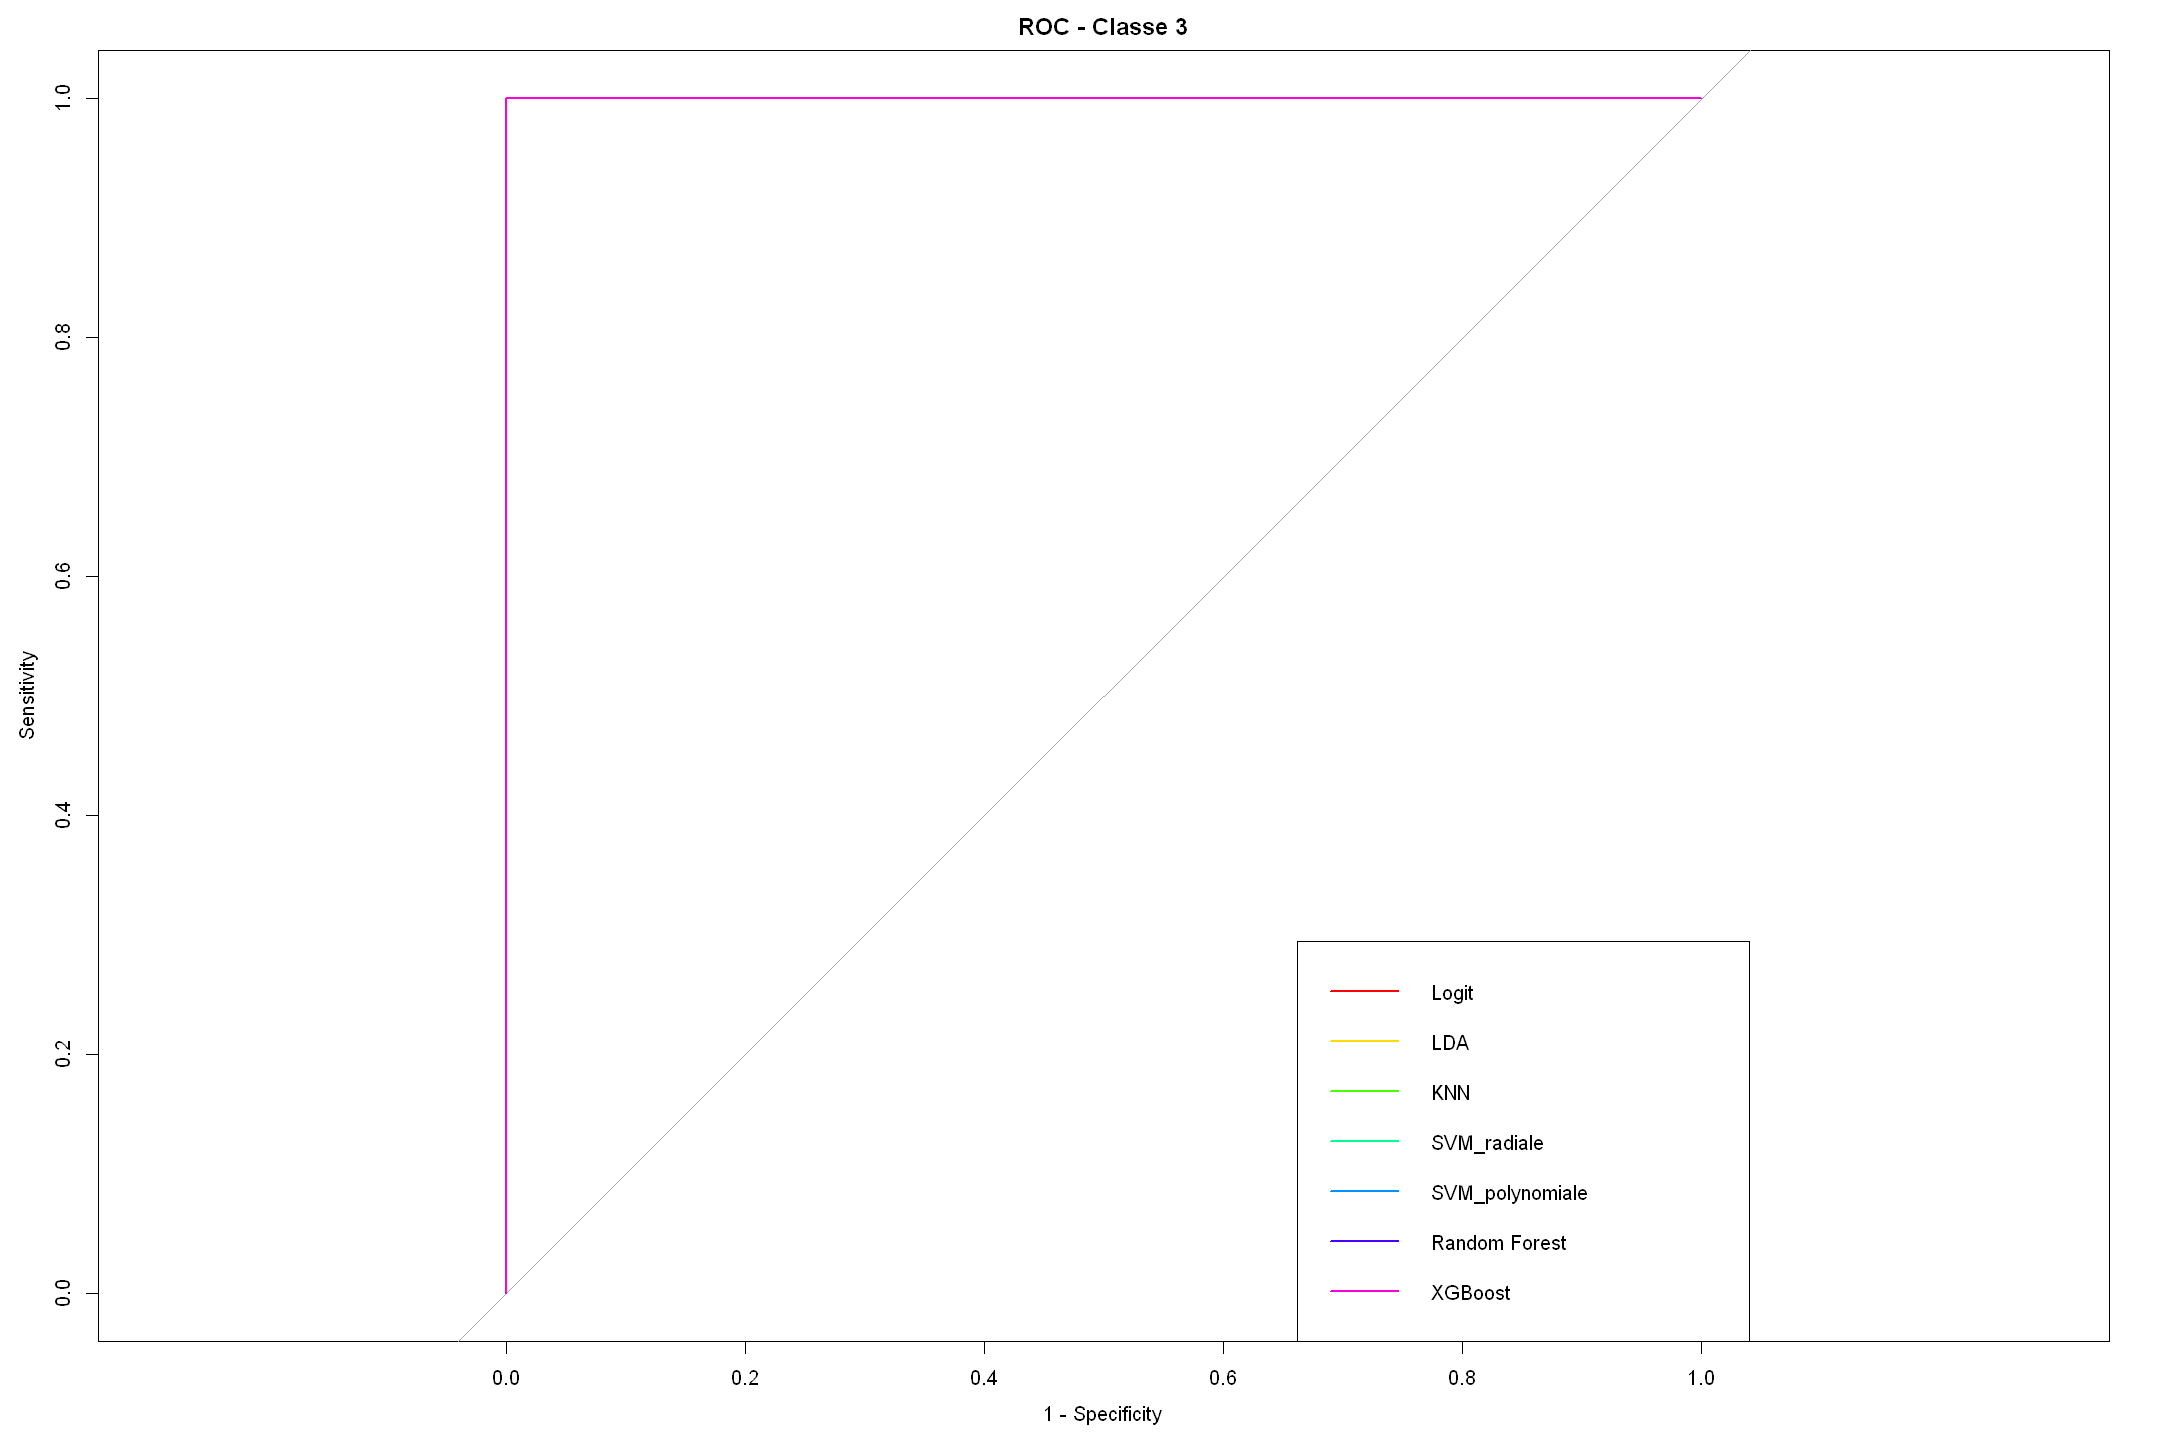

In [ ]:
library(pROC)
all_probs <- list(
  "Logit" = probabilities_logit,
  "LDA" = probabilities_lda,
  "KNN" = probabilities_knn,
  "SVM_radiale" = probabilities_svm.rad,
  "SVM_polynomiale" = probabilities_svm.pol,
  "Random Forest" = pred_probs_test_rf,
  "XGBoost" = pred_matrix_final
)

for (cl in 1:3) {
  # Paramètres
  #cl <- "2"  # classe d’intérêt
  models <- names(all_probs)  # les deux modèles à comparer
  # Génération automatique d'autant de couleurs qu'il y a de modèles
  colors <- rainbow(length(models))
  names(colors) <- models


  # Sécuriser les étiquettes
  true_class_test <- as.character(true_class_test)
  response_test <- true_class_test == cl

  # Préparer la liste pour stocker les objets ROC
  roc_list <- list()

  # Boucle sur les deux modèles
  for (model in models) {
    predictor_test <- all_probs[[model]][, cl]
    roc_obj <- roc(response = response_test, predictor = predictor_test)
    roc_list[[model]] <- roc_obj
  }

  # Tracer la première courbe pour initialiser le plot
  plot(roc_list[[models[1]]],
      col = colors[models[1]],
      lwd = 2,
      legacy.axes = TRUE,
      main = paste("ROC - Classe", cl),
      print.auc = FALSE)

  for (i in 2:length(models)) {
    # Ajouter les courbes ROC pour chaque modèle
    lines(roc_list[[models[i]]], col = colors[models[i]], lwd = 2)
  }

  legend("bottomright", legend = names(all_probs), col = colors, lwd = 2)
}

 

On constate ainsément que pour les niveaux d'expérience 1 et 2, le modèle KNN est le moins performant (courbe verte). Les 4 autres modèles ont des performances assez proches, mais la courbe associée à la regression logit étant souvent legerment au dessus des autres, c'est ce modèle le plus performant. 

###  Analyse des courbes ROC – Classification multiclasse


#####  Classe 1 et 2

Les courbes ROC pour les classes 1 et 2 sont sembblables, on retrouve: 
Knn a la courbe la plus basse, indiquant une performance médiocre. En suivant on trouve XGBoost et random forest et la SVM radiale assez proches avec une bonne préformance. Enfin la SVM polynomial et la regression logistique et la LDA sont proche et on les meilleurs performance, leur AUC sont proches de 1, ce qui témoigne de leurs très bonnes performances. 



#####  Classe 3 
Tous les modèles ont une courbe ROC parfaite pour la classe 3, indiquant qu'ils classifient parfaitement les observations de cette classe. Cela est cohérent avec le fait que la classe 3 est bien séparée des autres classes dans les données.




# Conclusion générale

En résumé, ce travail a exploré la prédiction de deux variables clés : les calories brûlées (Calories_Burned) et le niveau d'expérience (Experience_Level).

Pour la prédiction des **calories brûlées**, les modèles de boosting (GBM) ont offert la meilleure performance brute (R² de 0.997). Néanmoins, des modèles comme le LASSO Quadratique et le SVR RBF ont également atteint d'excellents scores (R² de 0.992) tout en présentant des compromis intéressants en termes de temps d'optimisation et, **pour le LASSO, d'interprétabilité**. L'analyse en composantes principales (ACP) avait déjà souligné l'importance de la `Session_Duration..hours.`, un facteur confirmé par les modèles comme déterminant majeur de la dépense calorique.

Concernant la prédiction du **niveau d'expérience**, le modèle CART s'est distingué par la meilleure combinaison d'accuracy (90.2%) et de log loss. Toutefois, l'analyse discriminante linéaire (LDA) et la régression logistique ont démontré une efficacité remarquable, offrant un excellent équilibre entre performance, rapidité d'exécution et interprétabilité. L'ACP et la LDA ont révélé que si les experts (niveau 3) sont relativement bien séparés, notamment grâce à des variables comme la durée des sessions et des attributs physiques (poids, taille), la distinction entre débutants (niveau 1) et intermédiaires (niveau 2) est plus ardue, ces groupes se chevauchant davantage. L'hydratation (`Water_Intake..liters.`) est apparue comme un facteur secondaire aidant à cette différenciation plus fine.

En conclusion, le choix du modèle optimal dépendra fortement de l'objectif visé (performance pure, interprétabilité, rapidité) et de la nature de la variable à prédire. Les analyses exploratoires préalables, telles que l'ACP et la LDA, se sont avérées cruciales pour orienter la modélisation et comprendre les dynamiques sous-jacentes aux données, notamment la complexité de séparer certains niveaux d'expérience malgré des tendances générales claires.

# Bilan

Ce projet a permis d'explorer en profondeur les techniques d'apprentissage supervisé pour la prédiction de variables continues et catégorielles à partir de données réelles issues d'une salle de sport. Cela nous a permis : 
- D'apprendre à se répartir efficacement le travail en se mettant des deadlines.
- De découvrir et d'appliquer une variété de modèles, et de voir lesquels sont les plus interprétables et performants pour des tâches spécifiques.
- Faire les notebooks dans les deux langages (R et python) nous a permis de réaliser que le langage R était souvent plus intuitif pour l'interprétabilité, avec des fonctions de visualisation très puissantes et faciles à utiliser.